In [2]:
import numpy as np
import pandas as pd
import torch


from rdkit import Chem, RDLogger
RDLogger.DisableLog('rdApp.*')
from rdkit.Chem import PandasTools


from collections import Counter
from itertools import product
import zipfile
from io import BytesIO

import selfies as sf

from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

from tqdm import tqdm

/Users/jonghopark/miniconda3/envs/moses/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import sys
sys.path.append("..")
import moses
from moses.vae import VAE
from moses.vae_property import VAEPROPERTY
from moses.utils import CharVocab, StringDataset, SELFIESVocab
from moses.vae.trainer import VAETrainer
from moses.vae_property.trainer import VAEPROPERTYTrainer 

from moses.metrics import QED, SA, logP
from moses.utils import get_mol

# 1. Loading data

## 1.1 Loading model

In [4]:
folder_path = "../model_results/ZINC250K_vae_property_obj_ws"

config_path = "vae_property_config.pt"
model_path = "vae_property_model_080.pt"

config = torch.load(f"{folder_path}/{config_path}")

vocab_path = "vae_property_vocab.pt"
vocab = torch.load(f"{folder_path}/{vocab_path}")

model = VAEPROPERTY(vocab, config)
model.load_state_dict(torch.load(f"{folder_path}/{model_path}"))



<All keys matched successfully>

## 1.2 Loading train data

In [5]:
data_folder_path = "../moses/dataset/data/ZINC250K"

file_name = "train.csv"

data = pd.read_csv(f"{data_folder_path}/{file_name}")

In [6]:
data.head() #it has smiles, selfies, logP, qed, SAS, obj values

,SMILES,SELFIES,logP,qed,SAS,obj
0,COCCOc1ccc(CNC(=O)c2cnc3ccc(C)cn23)cc1,[C][O][C][C][O][C][=C][C][=C][Branch2][Ring1][...,2.59792,0.672152,2.174005,1.186756
1,Cc1cc(C(=O)NC(C)(C)c2cccc(F)c2)[nH]n1,[C][C][C][=C][Branch2][Ring1][Branch2][C][=Bra...,2.52232,0.891576,2.577987,1.879891
2,CCc1n[nH]c(SCc2nnnn2-c2cc(C)ccc2F)n1,[C][C][C][=N][NH1][C][Branch2][Ring1][=Branch1...,2.08262,0.724791,2.787800,0.836156
3,COc1ccc(CC(=O)Nc2cccc3ncccc23)cc1,[C][O][C][=C][C][=C][Branch2][Ring1][Branch1][...,3.42460,0.801260,1.647545,2.358755
4,CCOc1ccc(Cl)c(C(=O)Nc2cc(C)nn2CCC#N)n1,[C][C][O][C][=C][C][=C][Branch1][C][Cl][C][Bra...,2.80460,0.876945,2.582261,1.802464


### 1.2.1 generate whole_latent_data

In [7]:
np.random.seed(42)
samples = data.iloc[np.random.choice(data.shape[0], 1000, replace=False)]

In [8]:
def get_latent_info(mol_smiles, model):
    mu, log_var, z, _ = model.forward_encoder(model.string2tensor(mol_smiles).reshape(1,-1))

    return mu, log_var, z

In [9]:
def get_latent_whole_info(data, model):
    mu_list = []
    log_var_list = []
    z_list = []
    for i in range(len(data)):
        mu, log_var, z = get_latent_info(data["SMILES"].iloc[i], model)
        mu_list.append(mu)
        log_var_list.append(log_var)
        z_list.append(z)

    mu_df = pd.DataFrame([[point.detach().cpu().numpy()]for point in mu_list], columns=["mu"], index=data.index)
    logvar_df = pd.DataFrame([[point.detach().cpu().numpy()]for point in log_var_list], columns=["logvar"], index=data.index)
    z_df = pd.DataFrame([[point.detach().cpu().numpy()]for point in z_list], columns=["z"], index=data.index)

    return mu_df, logvar_df, z_df

In [10]:
mu_df, log_var_df, z_df = get_latent_whole_info(samples, model)

In [11]:
whole_latent_info = pd.concat([samples, mu_df, log_var_df, z_df], axis=1)

In [12]:
whole_latent_info

,SMILES,SELFIES,logP,qed,SAS,obj,mu,logvar,z
38683,CC(C)n1nnnc1SCc1cc(F)cc2c1OCOC2,[C][C][Branch1][C][C][N][N][=N][N][=C][Ring1][...,2.55190,0.808834,2.786591,1.257578,"[[0.0006688088, -0.04799132, 0.009349651, 0.00...","[[-0.0018990822, -0.0017098114, 0.0023532398, ...","[[0.16621077, 0.15409438, -1.523145, 0.1359638..."
64939,O=C(CCO)N1CCC2(CC(Nc3ncccn3)CO2)C1,[O][=C][Branch1][Ring2][C][C][O][N][C][C][C][B...,0.03090,0.813958,4.044754,0.025037,"[[-0.00095851347, 0.021082483, 0.007405185, 0....","[[4.9378723e-05, -0.0030402318, 0.0017250776, ...","[[-0.5880075, 1.0126122, -1.0380818, 2.133908,..."
3954,COc1c(CN(CCC#N)Cc2ccccn2)c(C)nn1C,[C][O][C][=C][Branch2][Ring1][C][C][N][Branch1...,2.04800,0.782484,2.591605,1.320817,"[[0.009314321, 0.0017299056, 0.01059019, -0.00...","[[0.00043804199, -0.0008841902, -0.0006967876,...","[[-1.993314, 0.5143128, 0.19437343, -1.7323496..."
120374,CC(C)CCn1c(=O)c2sccc2n2c(=O)[nH]nc12,[C][C][Branch1][C][C][C][C][N][C][=Branch1][C]...,1.44510,0.787737,2.793158,1.145527,"[[0.0019169301, -0.035416692, 0.0028020684, 0....","[[0.0007841289, -0.0021196902, -0.0014276989, ...","[[-0.46751958, 0.56775856, -0.6709473, -0.9692..."
172861,N#Cc1ccccc1N1CCN(C(=O)CCN2CCCCC2=O)CC1,[N][#C][C][=C][C][=C][C][=C][Ring1][=Branch1][...,1.60948,0.835036,2.200988,1.974191,"[[0.0012648702, 0.018271655, -0.010631787, 0.0...","[[-0.000246834, -0.0021136627, -0.0008503087, ...","[[0.89308584, 1.0562788, -0.32748878, 1.723473..."
...,...,...,...,...,...,...,...,...,...
3963,CCOc1ccc(C2NC(=O)NC3=C2C(=O)N(CCC(C)C)C3)cc1,[C][C][O][C][=C][C][=C][Branch2][Ring1][=N][C]...,2.58160,0.833919,2.937811,1.231782,"[[0.0339616, 0.026932195, -0.010883499, 0.0052...","[[0.00015386939, -0.0031673014, -0.0016510524,...","[[-1.9509919, -1.2364212, -0.9482397, 0.821312..."
79890,Cc1cc(C)c(NC(=O)CNc2nc3ccccc3nc2C)c(C)c1,[C][C][=C][C][Branch1][C][C][=C][Branch2][Ring...,3.91408,0.758875,2.142944,1.651432,"[[0.024229053, -0.001015991, 0.01246443, 0.001...","[[-0.00049760565, -0.00026541203, -0.000601597...","[[1.1160204, -1.1535043, 1.2719135, -0.3435712..."
15295,Cc1cccc(N2CC(C(=O)N3CCOC(C)C3)CC2=O)c1C,[C][C][=C][C][=C][C][Branch2][Ring1][#Branch2]...,1.90364,0.837225,2.955786,1.230338,"[[0.0052305683, 0.016977385, -0.02318297, -0.0...","[[-0.0023915023, -0.0017191097, -0.0006081946,...","[[1.4562868, 1.4950308, -1.5698559, 1.4833773,..."
218373,CN(Cc1cccnc1)S(=O)(=O)N1CCNCC1,[C][N][Branch1][#Branch2][C][C][=C][C][=C][N][...,-0.33660,0.812984,2.360259,1.704662,"[[-0.008896768, 0.05477962, -0.019030368, 0.02...","[[0.0043442287, -0.005062647, -0.00561619, 0.0...","[[-0.26744223, 0.19364794, 2.5223353, 1.552215..."


## 1.2.2 for test mol, generate molecular diagram

In [13]:
def sample_latent_space(mu, model, ranges=(3,3), latent_dim=128, n_trials=1000, n_grid=6, temp=0.01, orthogonal_vec=(None,None)):

    np.random.seed(42)

    if orthogonal_vec[0] is None or orthogonal_vec[1] is None: # orthogonal vectors are not given -> set two basis vectors
        orthogonal_vec = np.eye(latent_dim)[np.random.randint(0, latent_dim, 2)]

    x_range, y_range = ranges

    dx = np.linspace(-x_range, x_range, 2*n_grid+1)
    dy = np.linspace(-y_range, y_range, 2*n_grid+1)

    grid = pd.DataFrame(columns=range(2*n_grid+1), index=range(2*n_grid+1))


    for i_x, i_y in tqdm(product(range(2*n_grid+1), range(2*n_grid+1)), desc='whole_iters', total=(2*n_grid+1)**2): #each data points
        z_point = mu + dx[i_x]*orthogonal_vec[0] + dy[i_y]*orthogonal_vec[1] # move the point to the direction of the unit vector
        most_freq_mol = decode_z(z_point, model, n_trials, temp)

        grid.iloc[i_x, i_y] = most_freq_mol
    
    return grid

def decode_z(z, model, n_trials, temp):
    # decode n_trials times from z using the model sample function, and pick most frequent one
    z_input = torch.tensor(z).repeat(n_trials).reshape(n_trials, -1)

    z_input = z_input.float()

    decoded_mols = model.sample(n_batch=z_input.shape[0], z=z_input, temp=temp)

    valid_decoded_mols = [Chem.MolFromSmiles(mol) for mol in decoded_mols if Chem.MolFromSmiles(mol) is not None]
    
    print(f"ratio of valid molecules : {len(valid_decoded_mols)}/{n_trials}")

    canon_dec_mols = [Chem.MolToSmiles(Chem.MolFromSmiles(mol), canonical=True) for mol in decoded_mols if Chem.MolFromSmiles(mol) is not None]

    mol_freq = Counter(canon_dec_mols)

    most_freq_mol, _ = find_argmax(mol_freq)

    return most_freq_mol

def find_argmax(counter):
    # Get the most common element and its count
    most_common_element = counter.most_common(1)
    if most_common_element:
        element, count = most_common_element[0]
        return element, count
    else:
        return None, None


def plot_freq_mols(freq_mols_grid, save_name=None):
    n_rows, n_cols = freq_mols_grid.shape

    fig, ax = plt.subplots(n_rows, n_cols, figsize=(10,10))

    for i in range(n_rows):
        for j in range(n_cols):
            mol = Chem.MolFromSmiles(freq_mols_grid.iloc[i,j])
            if mol is not None:
                img = Chem.Draw.MolToImage(mol, size=(300,300))
                ax[i,j].imshow(img)
                ax[i,j].axis("off")
            else:
                ax[i,j].axis("off")

    if save_name is not None:
        plt.savefig(save_name)
        plt.clf()
    

In [14]:
test_mol = whole_latent_info.iloc[0]

In [15]:
test_mol

SMILES                       CC(C)n1nnnc1SCc1cc(F)cc2c1OCOC2
SELFIES    [C][C][Branch1][C][C][N][N][=N][N][=C][Ring1][...
logP                                                  2.5519
qed                                                 0.808834
SAS                                                 2.786591
obj                                                 1.257578
mu         [[0.0006688088, -0.04799132, 0.009349651, 0.00...
logvar     [[-0.0018990822, -0.0017098114, 0.0023532398, ...
z          [[0.16621077, 0.15409438, -1.523145, 0.1359638...
Name: 38683, dtype: object

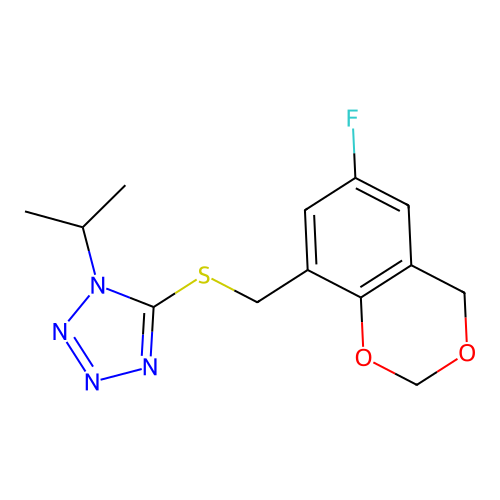

In [16]:
img = Chem.Draw.MolToImage(Chem.MolFromSmiles(test_mol['SMILES']), size=(500,500))


img

In [18]:
ranges_list = [(10,10), (20,20), (30,30)]

temp_list = [0.01, 0.1, 1]

experiments = list(product(ranges_list, temp_list))

v1 = np.ones(config.d_z)
v1 = v1/np.linalg.norm(v1) # 1/sqrt(128)*np.ones(128)

v2 = np.array([1 if i < config.d_z//2 else -1 for i in range(config.d_z)])
v2 = v2/np.linalg.norm(v2) # 1/sqrt(128)*[1,1,1,1,1...,-1(65th coord),-1,-1,-1,-1... -1]

for i, (ranges, temp) in enumerate(experiments):
    print(f"------------- Experiment {i} -------------")
    grid = sample_latent_space(test_mol["mu"][0], model, ranges=ranges, temp=temp, n_trials=1000, n_grid=10, orthogonal_vec=(v1,v2))
    plot_freq_mols(grid, save_name=f"figures/two_other_orthogonal_basis/test_mol_{i}.png")

------------- Experiment 0 -------------


whole_iters:   0%|          | 0/441 [00:00<?, ?it/s]

ratio of valid molecules : 1000/1000


whole_iters:   0%|          | 1/441 [00:02<15:30,  2.11s/it]

ratio of valid molecules : 1000/1000


whole_iters:   0%|          | 2/441 [00:04<15:17,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:   1%|          | 3/441 [00:06<15:11,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:   1%|          | 4/441 [00:08<15:04,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:   1%|          | 5/441 [00:10<15:02,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:   1%|▏         | 6/441 [00:12<15:01,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:   2%|▏         | 7/441 [00:14<14:51,  2.06s/it]

ratio of valid molecules : 1000/1000


whole_iters:   2%|▏         | 8/441 [00:16<15:03,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:   2%|▏         | 9/441 [00:18<15:04,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:   2%|▏         | 10/441 [00:20<14:59,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:   2%|▏         | 11/441 [00:22<14:54,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:   3%|▎         | 12/441 [00:24<14:55,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:   3%|▎         | 13/441 [00:27<14:51,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:   3%|▎         | 14/441 [00:29<14:49,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:   3%|▎         | 15/441 [00:31<14:54,  2.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:   4%|▎         | 16/441 [00:33<14:57,  2.11s/it]

ratio of valid molecules : 1000/1000


whole_iters:   4%|▍         | 17/441 [00:35<15:01,  2.13s/it]

ratio of valid molecules : 1000/1000


whole_iters:   4%|▍         | 18/441 [00:37<14:48,  2.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:   4%|▍         | 19/441 [00:39<14:43,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:   5%|▍         | 20/441 [00:41<14:31,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:   5%|▍         | 21/441 [00:43<14:26,  2.06s/it]

ratio of valid molecules : 1000/1000


whole_iters:   5%|▍         | 22/441 [00:45<14:26,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:   5%|▌         | 23/441 [00:47<14:27,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:   5%|▌         | 24/441 [00:49<14:24,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:   6%|▌         | 25/441 [00:52<14:23,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:   6%|▌         | 26/441 [00:54<14:18,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:   6%|▌         | 27/441 [00:56<14:16,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:   6%|▋         | 28/441 [00:58<14:14,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:   7%|▋         | 29/441 [01:00<14:12,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:   7%|▋         | 30/441 [01:02<14:17,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:   7%|▋         | 31/441 [01:04<14:05,  2.06s/it]

ratio of valid molecules : 1000/1000


whole_iters:   7%|▋         | 32/441 [01:06<14:08,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:   7%|▋         | 33/441 [01:08<14:15,  2.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:   8%|▊         | 34/441 [01:10<14:12,  2.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:   8%|▊         | 35/441 [01:12<14:19,  2.12s/it]

ratio of valid molecules : 1000/1000


whole_iters:   8%|▊         | 36/441 [01:15<14:32,  2.15s/it]

ratio of valid molecules : 1000/1000


whole_iters:   8%|▊         | 37/441 [01:17<14:18,  2.13s/it]

ratio of valid molecules : 1000/1000


whole_iters:   9%|▊         | 38/441 [01:19<14:22,  2.14s/it]

ratio of valid molecules : 1000/1000


whole_iters:   9%|▉         | 39/441 [01:21<14:14,  2.13s/it]

ratio of valid molecules : 1000/1000


whole_iters:   9%|▉         | 40/441 [01:23<14:08,  2.12s/it]

ratio of valid molecules : 1000/1000


whole_iters:   9%|▉         | 41/441 [01:25<13:53,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  10%|▉         | 42/441 [01:27<13:51,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  10%|▉         | 43/441 [01:29<13:57,  2.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:  10%|▉         | 44/441 [01:32<14:01,  2.12s/it]

ratio of valid molecules : 1000/1000


whole_iters:  10%|█         | 45/441 [01:34<13:58,  2.12s/it]

ratio of valid molecules : 1000/1000


whole_iters:  10%|█         | 46/441 [01:36<13:53,  2.11s/it]

ratio of valid molecules : 1000/1000


whole_iters:  11%|█         | 47/441 [01:38<13:47,  2.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:  11%|█         | 48/441 [01:40<14:14,  2.17s/it]

ratio of valid molecules : 1000/1000


whole_iters:  11%|█         | 49/441 [01:42<14:02,  2.15s/it]

ratio of valid molecules : 1000/1000


whole_iters:  11%|█▏        | 50/441 [01:44<13:48,  2.12s/it]

ratio of valid molecules : 1000/1000


whole_iters:  12%|█▏        | 51/441 [01:46<13:37,  2.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:  12%|█▏        | 52/441 [01:49<14:06,  2.18s/it]

ratio of valid molecules : 1000/1000


whole_iters:  12%|█▏        | 53/441 [01:51<13:53,  2.15s/it]

ratio of valid molecules : 1000/1000


whole_iters:  12%|█▏        | 54/441 [01:53<13:46,  2.13s/it]

ratio of valid molecules : 1000/1000


whole_iters:  12%|█▏        | 55/441 [01:55<13:48,  2.15s/it]

ratio of valid molecules : 1000/1000


whole_iters:  13%|█▎        | 56/441 [01:57<13:43,  2.14s/it]

ratio of valid molecules : 1000/1000


whole_iters:  13%|█▎        | 57/441 [01:59<13:36,  2.13s/it]

ratio of valid molecules : 1000/1000


whole_iters:  13%|█▎        | 58/441 [02:01<13:30,  2.12s/it]

ratio of valid molecules : 1000/1000


whole_iters:  13%|█▎        | 59/441 [02:03<13:25,  2.11s/it]

ratio of valid molecules : 1000/1000


whole_iters:  14%|█▎        | 60/441 [02:06<13:20,  2.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:  14%|█▍        | 61/441 [02:08<13:15,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  14%|█▍        | 62/441 [02:10<13:11,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  14%|█▍        | 63/441 [02:12<13:12,  2.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:  15%|█▍        | 64/441 [02:14<13:14,  2.11s/it]

ratio of valid molecules : 1000/1000


whole_iters:  15%|█▍        | 65/441 [02:16<13:07,  2.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:  15%|█▍        | 66/441 [02:18<13:07,  2.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:  15%|█▌        | 67/441 [02:20<13:03,  2.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:  15%|█▌        | 68/441 [02:22<13:07,  2.11s/it]

ratio of valid molecules : 1000/1000


whole_iters:  16%|█▌        | 69/441 [02:24<13:04,  2.11s/it]

ratio of valid molecules : 1000/1000


whole_iters:  16%|█▌        | 70/441 [02:27<13:07,  2.12s/it]

ratio of valid molecules : 1000/1000


whole_iters:  16%|█▌        | 71/441 [02:29<12:58,  2.11s/it]

ratio of valid molecules : 1000/1000


whole_iters:  16%|█▋        | 72/441 [02:31<13:17,  2.16s/it]

ratio of valid molecules : 1000/1000


whole_iters:  17%|█▋        | 73/441 [02:33<13:14,  2.16s/it]

ratio of valid molecules : 1000/1000


whole_iters:  17%|█▋        | 74/441 [02:35<13:12,  2.16s/it]

ratio of valid molecules : 1000/1000


whole_iters:  17%|█▋        | 75/441 [02:37<13:05,  2.15s/it]

ratio of valid molecules : 1000/1000


whole_iters:  17%|█▋        | 76/441 [02:40<13:07,  2.16s/it]

ratio of valid molecules : 1000/1000


whole_iters:  17%|█▋        | 77/441 [02:42<13:18,  2.19s/it]

ratio of valid molecules : 1000/1000


whole_iters:  18%|█▊        | 78/441 [02:44<13:07,  2.17s/it]

ratio of valid molecules : 1000/1000


whole_iters:  18%|█▊        | 79/441 [02:46<13:01,  2.16s/it]

ratio of valid molecules : 1000/1000


whole_iters:  18%|█▊        | 80/441 [02:48<12:52,  2.14s/it]

ratio of valid molecules : 1000/1000


whole_iters:  18%|█▊        | 81/441 [02:50<12:43,  2.12s/it]

ratio of valid molecules : 1000/1000


whole_iters:  19%|█▊        | 82/441 [02:52<12:39,  2.12s/it]

ratio of valid molecules : 1000/1000


whole_iters:  19%|█▉        | 83/441 [02:55<12:35,  2.11s/it]

ratio of valid molecules : 1000/1000


whole_iters:  19%|█▉        | 85/441 [02:59<12:43,  2.14s/it]

ratio of valid molecules : 1000/1000


whole_iters:  20%|█▉        | 86/441 [03:01<12:38,  2.14s/it]

ratio of valid molecules : 1000/1000
ratio of valid molecules : 1000/1000


whole_iters:  20%|█▉        | 87/441 [03:03<12:28,  2.11s/it]

ratio of valid molecules : 1000/1000


whole_iters:  20%|██        | 89/441 [03:07<12:29,  2.13s/it]

ratio of valid molecules : 1000/1000


whole_iters:  20%|██        | 90/441 [03:09<12:21,  2.11s/it]

ratio of valid molecules : 1000/1000


whole_iters:  21%|██        | 91/441 [03:12<12:13,  2.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:  21%|██        | 92/441 [03:14<12:13,  2.10s/it]

ratio of valid molecules : 1000/1000
ratio of valid molecules : 1000/1000


whole_iters:  21%|██        | 93/441 [03:16<12:12,  2.11s/it]

ratio of valid molecules : 1000/1000


whole_iters:  21%|██▏       | 94/441 [03:18<12:11,  2.11s/it]

ratio of valid molecules : 1000/1000


whole_iters:  22%|██▏       | 95/441 [03:20<12:10,  2.11s/it]

ratio of valid molecules : 1000/1000


whole_iters:  22%|██▏       | 96/441 [03:22<12:13,  2.13s/it]

ratio of valid molecules : 1000/1000


whole_iters:  22%|██▏       | 97/441 [03:24<12:08,  2.12s/it]

ratio of valid molecules : 1000/1000


whole_iters:  22%|██▏       | 98/441 [03:26<12:09,  2.13s/it]

ratio of valid molecules : 1000/1000


whole_iters:  22%|██▏       | 99/441 [03:28<12:07,  2.13s/it]

ratio of valid molecules : 1000/1000


whole_iters:  23%|██▎       | 100/441 [03:31<12:07,  2.13s/it]

ratio of valid molecules : 1000/1000


whole_iters:  23%|██▎       | 101/441 [03:33<12:07,  2.14s/it]

ratio of valid molecules : 1000/1000


whole_iters:  23%|██▎       | 102/441 [03:35<12:03,  2.13s/it]

ratio of valid molecules : 1000/1000


whole_iters:  23%|██▎       | 103/441 [03:37<12:01,  2.14s/it]

ratio of valid molecules : 1000/1000


whole_iters:  24%|██▎       | 104/441 [03:39<11:59,  2.14s/it]

ratio of valid molecules : 1000/1000


whole_iters:  24%|██▍       | 106/441 [03:43<11:44,  2.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:  24%|██▍       | 107/441 [03:45<11:36,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  24%|██▍       | 108/441 [03:47<11:30,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:  25%|██▍       | 109/441 [03:49<11:24,  2.06s/it]

ratio of valid molecules : 1000/1000


whole_iters:  25%|██▍       | 110/441 [03:52<11:21,  2.06s/it]

ratio of valid molecules : 1000/1000


whole_iters:  25%|██▌       | 111/441 [03:54<11:18,  2.06s/it]

ratio of valid molecules : 1000/1000


whole_iters:  25%|██▌       | 112/441 [03:56<11:15,  2.05s/it]

ratio of valid molecules : 1000/1000


whole_iters:  26%|██▌       | 113/441 [03:58<11:11,  2.05s/it]

ratio of valid molecules : 1000/1000


whole_iters:  26%|██▌       | 114/441 [04:00<11:10,  2.05s/it]

ratio of valid molecules : 1000/1000


whole_iters:  26%|██▌       | 115/441 [04:02<11:13,  2.06s/it]

ratio of valid molecules : 1000/1000
ratio of valid molecules : 1000/1000


whole_iters:  27%|██▋       | 117/441 [04:06<11:08,  2.06s/it]

ratio of valid molecules : 1000/1000
ratio of valid molecules : 1000/1000


whole_iters:  27%|██▋       | 118/441 [04:08<11:05,  2.06s/it]

ratio of valid molecules : 1000/1000


whole_iters:  27%|██▋       | 119/441 [04:10<11:09,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  27%|██▋       | 120/441 [04:12<11:14,  2.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:  27%|██▋       | 121/441 [04:14<11:16,  2.11s/it]

ratio of valid molecules : 1000/1000


whole_iters:  28%|██▊       | 122/441 [04:17<11:17,  2.12s/it]

ratio of valid molecules : 1000/1000


whole_iters:  28%|██▊       | 123/441 [04:19<11:53,  2.24s/it]

ratio of valid molecules : 1000/1000


whole_iters:  28%|██▊       | 124/441 [04:21<11:43,  2.22s/it]

ratio of valid molecules : 1000/1000


whole_iters:  28%|██▊       | 125/441 [04:23<11:33,  2.19s/it]

ratio of valid molecules : 1000/1000


whole_iters:  29%|██▉       | 127/441 [04:28<11:09,  2.13s/it]

ratio of valid molecules : 1000/1000


whole_iters:  29%|██▉       | 128/441 [04:30<10:59,  2.11s/it]

ratio of valid molecules : 1000/1000


whole_iters:  29%|██▉       | 129/441 [04:32<10:52,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  29%|██▉       | 130/441 [04:34<10:46,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  30%|██▉       | 131/441 [04:36<10:42,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:  30%|██▉       | 132/441 [04:38<10:38,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:  30%|███       | 133/441 [04:40<10:35,  2.06s/it]

ratio of valid molecules : 1000/1000


whole_iters:  30%|███       | 134/441 [04:42<10:30,  2.05s/it]

ratio of valid molecules : 1000/1000
ratio of valid molecules : 1000/1000


whole_iters:  31%|███       | 136/441 [04:46<10:27,  2.06s/it]

ratio of valid molecules : 1000/1000
ratio of valid molecules : 1000/1000


whole_iters:  31%|███▏      | 138/441 [04:50<10:24,  2.06s/it]

ratio of valid molecules : 1000/1000
ratio of valid molecules : 1000/1000


whole_iters:  32%|███▏      | 139/441 [04:52<10:23,  2.06s/it]

ratio of valid molecules : 1000/1000


whole_iters:  32%|███▏      | 140/441 [04:54<10:22,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:  32%|███▏      | 141/441 [04:56<10:28,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  32%|███▏      | 142/441 [04:59<10:29,  2.11s/it]

ratio of valid molecules : 1000/1000


whole_iters:  32%|███▏      | 143/441 [05:01<10:33,  2.13s/it]

ratio of valid molecules : 1000/1000


whole_iters:  33%|███▎      | 144/441 [05:03<10:33,  2.13s/it]

ratio of valid molecules : 1000/1000


whole_iters:  33%|███▎      | 145/441 [05:05<10:34,  2.14s/it]

ratio of valid molecules : 1000/1000


whole_iters:  33%|███▎      | 146/441 [05:07<10:32,  2.14s/it]

ratio of valid molecules : 1000/1000


whole_iters:  34%|███▎      | 148/441 [05:11<10:19,  2.11s/it]

ratio of valid molecules : 1000/1000


whole_iters:  34%|███▍      | 149/441 [05:13<10:12,  2.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:  34%|███▍      | 150/441 [05:16<10:06,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  34%|███▍      | 151/441 [05:18<10:01,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:  34%|███▍      | 152/441 [05:20<09:56,  2.06s/it]

ratio of valid molecules : 1000/1000


whole_iters:  35%|███▍      | 153/441 [05:22<09:54,  2.06s/it]

ratio of valid molecules : 1000/1000


whole_iters:  35%|███▍      | 154/441 [05:24<09:50,  2.06s/it]

ratio of valid molecules : 1000/1000


whole_iters:  35%|███▌      | 155/441 [05:26<09:46,  2.05s/it]

ratio of valid molecules : 1000/1000


whole_iters:  35%|███▌      | 156/441 [05:28<09:44,  2.05s/it]

ratio of valid molecules : 1000/1000


whole_iters:  36%|███▌      | 157/441 [05:30<09:41,  2.05s/it]

ratio of valid molecules : 1000/1000


whole_iters:  36%|███▌      | 158/441 [05:32<09:42,  2.06s/it]

ratio of valid molecules : 1000/1000


whole_iters:  36%|███▌      | 159/441 [05:34<09:53,  2.10s/it]

ratio of valid molecules : 1000/1000
ratio of valid molecules : 1000/1000


whole_iters:  36%|███▋      | 160/441 [05:36<09:51,  2.11s/it]

ratio of valid molecules : 1000/1000


whole_iters:  37%|███▋      | 161/441 [05:38<09:49,  2.11s/it]

ratio of valid molecules : 1000/1000


whole_iters:  37%|███▋      | 162/441 [05:41<09:55,  2.14s/it]

ratio of valid molecules : 1000/1000


whole_iters:  37%|███▋      | 163/441 [05:43<10:00,  2.16s/it]

ratio of valid molecules : 1000/1000


whole_iters:  37%|███▋      | 164/441 [05:45<09:59,  2.16s/it]

ratio of valid molecules : 1000/1000


whole_iters:  37%|███▋      | 165/441 [05:47<10:06,  2.20s/it]

ratio of valid molecules : 1000/1000


whole_iters:  38%|███▊      | 166/441 [05:50<10:13,  2.23s/it]

ratio of valid molecules : 1000/1000


whole_iters:  38%|███▊      | 167/441 [05:52<10:16,  2.25s/it]

ratio of valid molecules : 1000/1000


whole_iters:  38%|███▊      | 169/441 [05:56<09:51,  2.18s/it]

ratio of valid molecules : 1000/1000
ratio of valid molecules : 1000/1000


whole_iters:  39%|███▉      | 171/441 [06:00<09:35,  2.13s/it]

ratio of valid molecules : 1000/1000


whole_iters:  39%|███▉      | 172/441 [06:02<09:26,  2.11s/it]

ratio of valid molecules : 1000/1000


whole_iters:  39%|███▉      | 173/441 [06:04<09:19,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  39%|███▉      | 174/441 [06:06<09:14,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  40%|███▉      | 175/441 [06:08<09:10,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:  40%|███▉      | 176/441 [06:10<09:08,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:  40%|████      | 177/441 [06:13<09:05,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:  40%|████      | 178/441 [06:15<09:02,  2.06s/it]

ratio of valid molecules : 1000/1000


whole_iters:  41%|████      | 179/441 [06:17<09:01,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:  41%|████      | 180/441 [06:19<09:01,  2.08s/it]

ratio of valid molecules : 1000/1000
ratio of valid molecules : 1000/1000


whole_iters:  41%|████      | 181/441 [06:21<09:08,  2.11s/it]

ratio of valid molecules : 1000/1000


whole_iters:  41%|████▏     | 182/441 [06:23<09:12,  2.13s/it]

ratio of valid molecules : 1000/1000


whole_iters:  41%|████▏     | 183/441 [06:25<09:07,  2.12s/it]

ratio of valid molecules : 1000/1000


whole_iters:  42%|████▏     | 184/441 [06:27<09:07,  2.13s/it]

ratio of valid molecules : 1000/1000


whole_iters:  42%|████▏     | 185/441 [06:30<09:06,  2.13s/it]

ratio of valid molecules : 1000/1000


whole_iters:  42%|████▏     | 186/441 [06:32<09:07,  2.15s/it]

ratio of valid molecules : 1000/1000


whole_iters:  42%|████▏     | 187/441 [06:34<08:57,  2.12s/it]

ratio of valid molecules : 1000/1000


whole_iters:  43%|████▎     | 188/441 [06:36<08:59,  2.13s/it]

ratio of valid molecules : 1000/1000


whole_iters:  43%|████▎     | 190/441 [06:40<09:02,  2.16s/it]

ratio of valid molecules : 1000/1000


whole_iters:  43%|████▎     | 191/441 [06:42<08:53,  2.13s/it]

ratio of valid molecules : 1000/1000


whole_iters:  44%|████▎     | 192/441 [06:44<08:44,  2.11s/it]

ratio of valid molecules : 1000/1000


whole_iters:  44%|████▍     | 193/441 [06:47<08:40,  2.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:  44%|████▍     | 194/441 [06:49<08:34,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  44%|████▍     | 195/441 [06:51<08:31,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  44%|████▍     | 196/441 [06:53<08:27,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:  45%|████▍     | 197/441 [06:55<08:26,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:  45%|████▍     | 198/441 [06:57<08:21,  2.06s/it]

ratio of valid molecules : 1000/1000


whole_iters:  45%|████▌     | 199/441 [06:59<08:19,  2.06s/it]

ratio of valid molecules : 1000/1000


whole_iters:  45%|████▌     | 200/441 [07:01<08:18,  2.07s/it]

ratio of valid molecules : 1000/1000
ratio of valid molecules : 1000/1000


whole_iters:  46%|████▌     | 201/441 [07:03<08:16,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:  46%|████▌     | 202/441 [07:05<08:15,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:  46%|████▌     | 203/441 [07:07<08:14,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  46%|████▋     | 204/441 [07:09<08:14,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  46%|████▋     | 205/441 [07:11<08:14,  2.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:  47%|████▋     | 206/441 [07:14<08:16,  2.11s/it]

ratio of valid molecules : 1000/1000


whole_iters:  47%|████▋     | 207/441 [07:16<08:17,  2.13s/it]

ratio of valid molecules : 1000/1000


whole_iters:  47%|████▋     | 208/441 [07:18<08:20,  2.15s/it]

ratio of valid molecules : 1000/1000


whole_iters:  47%|████▋     | 209/441 [07:20<08:17,  2.15s/it]

ratio of valid molecules : 1000/1000


whole_iters:  48%|████▊     | 211/441 [07:24<08:14,  2.15s/it]

ratio of valid molecules : 1000/1000


whole_iters:  48%|████▊     | 212/441 [07:26<08:09,  2.14s/it]

ratio of valid molecules : 1000/1000


whole_iters:  48%|████▊     | 213/441 [07:29<08:06,  2.13s/it]

ratio of valid molecules : 1000/1000


whole_iters:  49%|████▊     | 214/441 [07:31<07:58,  2.11s/it]

ratio of valid molecules : 1000/1000


whole_iters:  49%|████▉     | 215/441 [07:33<07:55,  2.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:  49%|████▉     | 216/441 [07:35<07:53,  2.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:  49%|████▉     | 217/441 [07:37<07:50,  2.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:  49%|████▉     | 218/441 [07:39<07:44,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  50%|████▉     | 219/441 [07:41<07:43,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  50%|████▉     | 220/441 [07:43<07:40,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  50%|█████     | 221/441 [07:45<07:36,  2.08s/it]

ratio of valid molecules : 1000/1000
ratio of valid molecules : 1000/1000


whole_iters:  50%|█████     | 222/441 [07:47<07:33,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:  51%|█████     | 223/441 [07:49<07:31,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:  51%|█████     | 224/441 [07:51<07:31,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  51%|█████     | 225/441 [07:54<07:31,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  51%|█████     | 226/441 [07:56<07:32,  2.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:  51%|█████▏    | 227/441 [07:58<07:33,  2.12s/it]

ratio of valid molecules : 1000/1000


whole_iters:  52%|█████▏    | 228/441 [08:00<07:34,  2.13s/it]

ratio of valid molecules : 1000/1000


whole_iters:  52%|█████▏    | 229/441 [08:02<07:35,  2.15s/it]

ratio of valid molecules : 1000/1000


whole_iters:  52%|█████▏    | 230/441 [08:04<07:34,  2.15s/it]

ratio of valid molecules : 1000/1000


whole_iters:  53%|█████▎    | 232/441 [08:09<07:23,  2.12s/it]

ratio of valid molecules : 1000/1000


whole_iters:  53%|█████▎    | 233/441 [08:11<07:16,  2.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:  53%|█████▎    | 234/441 [08:13<07:12,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  53%|█████▎    | 235/441 [08:15<07:09,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  54%|█████▎    | 236/441 [08:17<07:06,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  54%|█████▎    | 237/441 [08:19<07:04,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  54%|█████▍    | 238/441 [08:21<07:00,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:  54%|█████▍    | 239/441 [08:23<06:58,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:  54%|█████▍    | 240/441 [08:25<06:55,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:  55%|█████▍    | 241/441 [08:27<06:53,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:  55%|█████▍    | 242/441 [08:29<06:52,  2.07s/it]

ratio of valid molecules : 1000/1000
ratio of valid molecules : 1000/1000


whole_iters:  55%|█████▌    | 243/441 [08:31<06:51,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  55%|█████▌    | 244/441 [08:34<06:57,  2.12s/it]

ratio of valid molecules : 1000/1000


whole_iters:  56%|█████▌    | 245/441 [08:36<06:57,  2.13s/it]

ratio of valid molecules : 1000/1000


whole_iters:  56%|█████▌    | 246/441 [08:38<07:00,  2.16s/it]

ratio of valid molecules : 1000/1000


whole_iters:  56%|█████▌    | 247/441 [08:40<06:58,  2.16s/it]

ratio of valid molecules : 1000/1000


whole_iters:  56%|█████▌    | 248/441 [08:42<06:57,  2.17s/it]

ratio of valid molecules : 1000/1000


whole_iters:  56%|█████▋    | 249/441 [08:44<06:55,  2.16s/it]

ratio of valid molecules : 1000/1000


whole_iters:  57%|█████▋    | 250/441 [08:47<06:58,  2.19s/it]

ratio of valid molecules : 1000/1000


whole_iters:  57%|█████▋    | 251/441 [08:49<06:54,  2.18s/it]

ratio of valid molecules : 1000/1000


whole_iters:  57%|█████▋    | 253/441 [08:54<07:09,  2.28s/it]

ratio of valid molecules : 1000/1000


whole_iters:  58%|█████▊    | 254/441 [08:56<06:55,  2.22s/it]

ratio of valid molecules : 1000/1000


whole_iters:  58%|█████▊    | 255/441 [08:58<06:42,  2.16s/it]

ratio of valid molecules : 1000/1000


whole_iters:  58%|█████▊    | 256/441 [09:00<06:41,  2.17s/it]

ratio of valid molecules : 1000/1000


whole_iters:  58%|█████▊    | 257/441 [09:02<06:35,  2.15s/it]

ratio of valid molecules : 1000/1000
ratio of valid molecules : 1000/1000


whole_iters:  59%|█████▊    | 259/441 [09:06<06:21,  2.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:  59%|█████▉    | 260/441 [09:08<06:17,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  59%|█████▉    | 261/441 [09:10<06:12,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:  59%|█████▉    | 262/441 [09:12<06:08,  2.06s/it]

ratio of valid molecules : 1000/1000


whole_iters:  60%|█████▉    | 263/441 [09:14<06:04,  2.05s/it]

ratio of valid molecules : 1000/1000


whole_iters:  60%|█████▉    | 264/441 [09:16<06:01,  2.04s/it]

ratio of valid molecules : 1000/1000
ratio of valid molecules : 1000/1000


whole_iters:  60%|██████    | 265/441 [09:18<05:59,  2.04s/it]

ratio of valid molecules : 1000/1000


whole_iters:  60%|██████    | 266/441 [09:20<05:58,  2.05s/it]

ratio of valid molecules : 1000/1000


whole_iters:  61%|██████    | 267/441 [09:22<06:02,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  61%|██████    | 268/441 [09:25<06:07,  2.13s/it]

ratio of valid molecules : 1000/1000


whole_iters:  61%|██████    | 269/441 [09:27<06:05,  2.12s/it]

ratio of valid molecules : 1000/1000


whole_iters:  61%|██████    | 270/441 [09:29<06:03,  2.13s/it]

ratio of valid molecules : 1000/1000


whole_iters:  61%|██████▏   | 271/441 [09:31<05:59,  2.12s/it]

ratio of valid molecules : 1000/1000


whole_iters:  62%|██████▏   | 272/441 [09:33<05:57,  2.11s/it]

ratio of valid molecules : 1000/1000


whole_iters:  62%|██████▏   | 274/441 [09:37<05:47,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  62%|██████▏   | 275/441 [09:39<05:41,  2.06s/it]

ratio of valid molecules : 1000/1000


whole_iters:  63%|██████▎   | 276/441 [09:41<05:36,  2.04s/it]

ratio of valid molecules : 1000/1000


whole_iters:  63%|██████▎   | 277/441 [09:43<05:33,  2.03s/it]

ratio of valid molecules : 1000/1000


whole_iters:  63%|██████▎   | 278/441 [09:45<05:29,  2.02s/it]

ratio of valid molecules : 1000/1000


whole_iters:  63%|██████▎   | 279/441 [09:47<05:27,  2.02s/it]

ratio of valid molecules : 1000/1000


whole_iters:  63%|██████▎   | 280/441 [09:49<05:25,  2.02s/it]

ratio of valid molecules : 1000/1000


whole_iters:  64%|██████▎   | 281/441 [09:51<05:22,  2.02s/it]

ratio of valid molecules : 1000/1000


whole_iters:  64%|██████▍   | 282/441 [09:53<05:19,  2.01s/it]

ratio of valid molecules : 1000/1000


whole_iters:  64%|██████▍   | 283/441 [09:55<05:17,  2.01s/it]

ratio of valid molecules : 1000/1000


whole_iters:  64%|██████▍   | 284/441 [09:57<05:15,  2.01s/it]

ratio of valid molecules : 1000/1000


whole_iters:  65%|██████▍   | 285/441 [09:59<05:13,  2.01s/it]

ratio of valid molecules : 1000/1000
ratio of valid molecules : 1000/1000


whole_iters:  65%|██████▍   | 286/441 [10:01<05:12,  2.02s/it]

ratio of valid molecules : 1000/1000


whole_iters:  65%|██████▌   | 287/441 [10:03<05:11,  2.03s/it]

ratio of valid molecules : 1000/1000


whole_iters:  65%|██████▌   | 288/441 [10:05<05:11,  2.03s/it]

ratio of valid molecules : 1000/1000


whole_iters:  66%|██████▌   | 289/441 [10:08<05:10,  2.04s/it]

ratio of valid molecules : 1000/1000


whole_iters:  66%|██████▌   | 290/441 [10:10<05:09,  2.05s/it]

ratio of valid molecules : 1000/1000


whole_iters:  66%|██████▌   | 291/441 [10:12<05:09,  2.06s/it]

ratio of valid molecules : 1000/1000


whole_iters:  66%|██████▌   | 292/441 [10:14<05:09,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  66%|██████▋   | 293/441 [10:16<05:07,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  67%|██████▋   | 295/441 [10:20<05:01,  2.06s/it]

ratio of valid molecules : 1000/1000


whole_iters:  67%|██████▋   | 296/441 [10:22<04:57,  2.05s/it]

ratio of valid molecules : 1000/1000


whole_iters:  67%|██████▋   | 297/441 [10:24<04:52,  2.03s/it]

ratio of valid molecules : 1000/1000


whole_iters:  68%|██████▊   | 298/441 [10:26<04:49,  2.03s/it]

ratio of valid molecules : 1000/1000


whole_iters:  68%|██████▊   | 299/441 [10:28<04:47,  2.02s/it]

ratio of valid molecules : 1000/1000


whole_iters:  68%|██████▊   | 300/441 [10:30<04:44,  2.02s/it]

ratio of valid molecules : 1000/1000


whole_iters:  68%|██████▊   | 301/441 [10:32<04:41,  2.01s/it]

ratio of valid molecules : 1000/1000


whole_iters:  68%|██████▊   | 302/441 [10:34<04:40,  2.01s/it]

ratio of valid molecules : 1000/1000


whole_iters:  69%|██████▊   | 303/441 [10:36<04:37,  2.01s/it]

ratio of valid molecules : 1000/1000
ratio of valid molecules : 1000/1000


whole_iters:  69%|██████▉   | 305/441 [10:40<04:33,  2.01s/it]

ratio of valid molecules : 1000/1000


whole_iters:  69%|██████▉   | 306/441 [10:42<04:31,  2.01s/it]

ratio of valid molecules : 1000/1000
ratio of valid molecules : 1000/1000


whole_iters:  70%|██████▉   | 307/441 [10:44<04:31,  2.03s/it]

ratio of valid molecules : 1000/1000


whole_iters:  70%|██████▉   | 308/441 [10:46<04:30,  2.03s/it]

ratio of valid molecules : 1000/1000


whole_iters:  70%|███████   | 309/441 [10:48<04:30,  2.05s/it]

ratio of valid molecules : 1000/1000


whole_iters:  70%|███████   | 310/441 [10:50<04:29,  2.06s/it]

ratio of valid molecules : 1000/1000


whole_iters:  71%|███████   | 311/441 [10:52<04:28,  2.06s/it]

ratio of valid molecules : 1000/1000


whole_iters:  71%|███████   | 312/441 [10:55<04:27,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:  71%|███████   | 313/441 [10:57<04:26,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  71%|███████   | 314/441 [10:59<04:25,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  72%|███████▏  | 316/441 [11:03<04:18,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:  72%|███████▏  | 317/441 [11:05<04:14,  2.05s/it]

ratio of valid molecules : 1000/1000


whole_iters:  72%|███████▏  | 318/441 [11:07<04:16,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  72%|███████▏  | 319/441 [11:09<04:12,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:  73%|███████▎  | 320/441 [11:11<04:08,  2.05s/it]

ratio of valid molecules : 1000/1000


whole_iters:  73%|███████▎  | 321/441 [11:13<04:05,  2.05s/it]

ratio of valid molecules : 1000/1000


whole_iters:  73%|███████▎  | 322/441 [11:15<04:02,  2.04s/it]

ratio of valid molecules : 1000/1000


whole_iters:  73%|███████▎  | 323/441 [11:17<03:59,  2.03s/it]

ratio of valid molecules : 1000/1000


whole_iters:  73%|███████▎  | 324/441 [11:19<03:57,  2.03s/it]

ratio of valid molecules : 1000/1000


whole_iters:  74%|███████▎  | 325/441 [11:21<03:54,  2.02s/it]

ratio of valid molecules : 1000/1000


whole_iters:  74%|███████▍  | 326/441 [11:23<03:52,  2.02s/it]

ratio of valid molecules : 1000/1000


whole_iters:  74%|███████▍  | 327/441 [11:25<03:50,  2.02s/it]

ratio of valid molecules : 1000/1000
ratio of valid molecules : 1000/1000


whole_iters:  74%|███████▍  | 328/441 [11:27<03:49,  2.03s/it]

ratio of valid molecules : 1000/1000


whole_iters:  75%|███████▍  | 329/441 [11:29<03:47,  2.03s/it]

ratio of valid molecules : 1000/1000


whole_iters:  75%|███████▍  | 330/441 [11:31<03:47,  2.05s/it]

ratio of valid molecules : 1000/1000


whole_iters:  75%|███████▌  | 331/441 [11:33<03:45,  2.05s/it]

ratio of valid molecules : 1000/1000


whole_iters:  75%|███████▌  | 332/441 [11:36<03:44,  2.06s/it]

ratio of valid molecules : 1000/1000


whole_iters:  76%|███████▌  | 333/441 [11:38<03:43,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:  76%|███████▌  | 334/441 [11:40<03:42,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  76%|███████▌  | 335/441 [11:42<03:41,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  76%|███████▋  | 337/441 [11:46<03:36,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  77%|███████▋  | 338/441 [11:48<03:32,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:  77%|███████▋  | 339/441 [11:50<03:29,  2.05s/it]

ratio of valid molecules : 1000/1000


whole_iters:  77%|███████▋  | 340/441 [11:52<03:25,  2.04s/it]

ratio of valid molecules : 1000/1000


whole_iters:  77%|███████▋  | 341/441 [11:54<03:23,  2.04s/it]

ratio of valid molecules : 1000/1000


whole_iters:  78%|███████▊  | 342/441 [11:56<03:20,  2.03s/it]

ratio of valid molecules : 1000/1000


whole_iters:  78%|███████▊  | 343/441 [11:58<03:18,  2.03s/it]

ratio of valid molecules : 1000/1000
ratio of valid molecules : 1000/1000


whole_iters:  78%|███████▊  | 345/441 [12:02<03:14,  2.03s/it]

ratio of valid molecules : 1000/1000


whole_iters:  78%|███████▊  | 346/441 [12:04<03:11,  2.02s/it]

ratio of valid molecules : 1000/1000


whole_iters:  79%|███████▊  | 347/441 [12:06<03:09,  2.02s/it]

ratio of valid molecules : 1000/1000


whole_iters:  79%|███████▉  | 348/441 [12:08<03:07,  2.01s/it]

ratio of valid molecules : 1000/1000
ratio of valid molecules : 1000/1000


whole_iters:  79%|███████▉  | 349/441 [12:10<03:05,  2.02s/it]

ratio of valid molecules : 1000/1000


whole_iters:  79%|███████▉  | 350/441 [12:12<03:04,  2.02s/it]

ratio of valid molecules : 1000/1000


whole_iters:  80%|███████▉  | 351/441 [12:14<03:03,  2.04s/it]

ratio of valid molecules : 1000/1000


whole_iters:  80%|███████▉  | 352/441 [12:16<03:02,  2.05s/it]

ratio of valid molecules : 1000/1000


whole_iters:  80%|████████  | 353/441 [12:19<03:01,  2.06s/it]

ratio of valid molecules : 1000/1000


whole_iters:  80%|████████  | 354/441 [12:21<03:00,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:  80%|████████  | 355/441 [12:23<02:59,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  81%|████████  | 356/441 [12:25<02:57,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  81%|████████  | 358/441 [12:29<02:52,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:  81%|████████▏ | 359/441 [12:31<02:48,  2.05s/it]

ratio of valid molecules : 1000/1000


whole_iters:  82%|████████▏ | 360/441 [12:33<02:45,  2.04s/it]

ratio of valid molecules : 1000/1000


whole_iters:  82%|████████▏ | 361/441 [12:35<02:42,  2.04s/it]

ratio of valid molecules : 1000/1000


whole_iters:  82%|████████▏ | 362/441 [12:37<02:39,  2.02s/it]

ratio of valid molecules : 1000/1000


whole_iters:  82%|████████▏ | 363/441 [12:39<02:37,  2.02s/it]

ratio of valid molecules : 1000/1000


whole_iters:  83%|████████▎ | 364/441 [12:41<02:35,  2.02s/it]

ratio of valid molecules : 1000/1000


whole_iters:  83%|████████▎ | 365/441 [12:43<02:33,  2.02s/it]

ratio of valid molecules : 1000/1000


whole_iters:  83%|████████▎ | 366/441 [12:45<02:31,  2.01s/it]

ratio of valid molecules : 1000/1000


whole_iters:  83%|████████▎ | 367/441 [12:47<02:29,  2.01s/it]

ratio of valid molecules : 1000/1000


whole_iters:  83%|████████▎ | 368/441 [12:49<02:27,  2.01s/it]

ratio of valid molecules : 1000/1000


whole_iters:  84%|████████▎ | 369/441 [12:51<02:24,  2.01s/it]

ratio of valid molecules : 1000/1000


whole_iters:  84%|████████▍ | 370/441 [12:53<02:23,  2.02s/it]

ratio of valid molecules : 1000/1000
ratio of valid molecules : 1000/1000


whole_iters:  84%|████████▍ | 371/441 [12:55<02:21,  2.03s/it]

ratio of valid molecules : 1000/1000


whole_iters:  84%|████████▍ | 372/441 [12:57<02:20,  2.04s/it]

ratio of valid molecules : 1000/1000


whole_iters:  85%|████████▍ | 373/441 [12:59<02:19,  2.04s/it]

ratio of valid molecules : 1000/1000


whole_iters:  85%|████████▍ | 374/441 [13:01<02:17,  2.05s/it]

ratio of valid molecules : 1000/1000


whole_iters:  85%|████████▌ | 375/441 [13:03<02:16,  2.06s/it]

ratio of valid molecules : 1000/1000


whole_iters:  85%|████████▌ | 376/441 [13:06<02:15,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  85%|████████▌ | 377/441 [13:08<02:13,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  86%|████████▌ | 379/441 [13:12<02:08,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:  86%|████████▌ | 380/441 [13:14<02:05,  2.05s/it]

ratio of valid molecules : 1000/1000


whole_iters:  86%|████████▋ | 381/441 [13:16<02:02,  2.04s/it]

ratio of valid molecules : 1000/1000


whole_iters:  87%|████████▋ | 382/441 [13:18<01:59,  2.03s/it]

ratio of valid molecules : 1000/1000


whole_iters:  87%|████████▋ | 383/441 [13:20<01:57,  2.02s/it]

ratio of valid molecules : 1000/1000


whole_iters:  87%|████████▋ | 384/441 [13:22<01:54,  2.02s/it]

ratio of valid molecules : 1000/1000


whole_iters:  87%|████████▋ | 385/441 [13:24<01:52,  2.02s/it]

ratio of valid molecules : 1000/1000


whole_iters:  88%|████████▊ | 386/441 [13:26<01:50,  2.02s/it]

ratio of valid molecules : 1000/1000


whole_iters:  88%|████████▊ | 387/441 [13:28<01:48,  2.02s/it]

ratio of valid molecules : 1000/1000


whole_iters:  88%|████████▊ | 388/441 [13:30<01:46,  2.02s/it]

ratio of valid molecules : 1000/1000
ratio of valid molecules : 1000/1000


whole_iters:  88%|████████▊ | 390/441 [13:34<01:42,  2.01s/it]

ratio of valid molecules : 1000/1000


whole_iters:  89%|████████▊ | 391/441 [13:36<01:40,  2.01s/it]

ratio of valid molecules : 1000/1000
ratio of valid molecules : 1000/1000


whole_iters:  89%|████████▉ | 392/441 [13:38<01:37,  2.00s/it]

ratio of valid molecules : 1000/1000


whole_iters:  89%|████████▉ | 393/441 [13:40<01:36,  2.02s/it]

ratio of valid molecules : 1000/1000


whole_iters:  89%|████████▉ | 394/441 [13:42<01:35,  2.04s/it]

ratio of valid molecules : 1000/1000


whole_iters:  90%|████████▉ | 395/441 [13:44<01:34,  2.05s/it]

ratio of valid molecules : 1000/1000


whole_iters:  90%|████████▉ | 396/441 [13:46<01:32,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:  90%|█████████ | 397/441 [13:48<01:31,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:  90%|█████████ | 398/441 [13:50<01:29,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  90%|█████████ | 399/441 [13:53<01:27,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  91%|█████████ | 401/441 [13:57<01:22,  2.06s/it]

ratio of valid molecules : 1000/1000


whole_iters:  91%|█████████ | 402/441 [13:59<01:19,  2.04s/it]

ratio of valid molecules : 1000/1000


whole_iters:  91%|█████████▏| 403/441 [14:01<01:17,  2.03s/it]

ratio of valid molecules : 1000/1000


whole_iters:  92%|█████████▏| 404/441 [14:03<01:15,  2.03s/it]

ratio of valid molecules : 1000/1000


whole_iters:  92%|█████████▏| 405/441 [14:05<01:13,  2.03s/it]

ratio of valid molecules : 1000/1000


whole_iters:  92%|█████████▏| 406/441 [14:07<01:10,  2.03s/it]

ratio of valid molecules : 1000/1000


whole_iters:  92%|█████████▏| 407/441 [14:09<01:08,  2.03s/it]

ratio of valid molecules : 1000/1000


whole_iters:  93%|█████████▎| 408/441 [14:11<01:06,  2.03s/it]

ratio of valid molecules : 1000/1000


whole_iters:  93%|█████████▎| 409/441 [14:13<01:04,  2.02s/it]

ratio of valid molecules : 1000/1000


whole_iters:  93%|█████████▎| 410/441 [14:15<01:02,  2.02s/it]

ratio of valid molecules : 1000/1000


whole_iters:  93%|█████████▎| 411/441 [14:17<01:00,  2.02s/it]

ratio of valid molecules : 1000/1000


whole_iters:  93%|█████████▎| 412/441 [14:19<00:58,  2.03s/it]

ratio of valid molecules : 1000/1000


whole_iters:  94%|█████████▎| 413/441 [14:21<00:56,  2.03s/it]

ratio of valid molecules : 1000/1000
ratio of valid molecules : 1000/1000


whole_iters:  94%|█████████▍| 414/441 [14:23<00:54,  2.03s/it]

ratio of valid molecules : 1000/1000


whole_iters:  94%|█████████▍| 415/441 [14:25<00:52,  2.04s/it]

ratio of valid molecules : 1000/1000


whole_iters:  94%|█████████▍| 416/441 [14:27<00:51,  2.05s/it]

ratio of valid molecules : 1000/1000


whole_iters:  95%|█████████▍| 417/441 [14:29<00:49,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:  95%|█████████▍| 418/441 [14:31<00:47,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  95%|█████████▌| 419/441 [14:33<00:45,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  95%|█████████▌| 421/441 [14:37<00:41,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:  96%|█████████▌| 422/441 [14:39<00:39,  2.06s/it]

ratio of valid molecules : 1000/1000


whole_iters:  96%|█████████▌| 423/441 [14:42<00:36,  2.05s/it]

ratio of valid molecules : 1000/1000


whole_iters:  96%|█████████▌| 424/441 [14:44<00:34,  2.04s/it]

ratio of valid molecules : 1000/1000


whole_iters:  96%|█████████▋| 425/441 [14:46<00:32,  2.03s/it]

ratio of valid molecules : 1000/1000


whole_iters:  97%|█████████▋| 426/441 [14:48<00:30,  2.03s/it]

ratio of valid molecules : 1000/1000


whole_iters:  97%|█████████▋| 427/441 [14:50<00:28,  2.03s/it]

ratio of valid molecules : 1000/1000


whole_iters:  97%|█████████▋| 428/441 [14:52<00:26,  2.02s/it]

ratio of valid molecules : 1000/1000


whole_iters:  97%|█████████▋| 429/441 [14:54<00:24,  2.02s/it]

ratio of valid molecules : 1000/1000


whole_iters:  98%|█████████▊| 430/441 [14:56<00:22,  2.02s/it]

ratio of valid molecules : 1000/1000


whole_iters:  98%|█████████▊| 431/441 [14:58<00:20,  2.02s/it]

ratio of valid molecules : 1000/1000


whole_iters:  98%|█████████▊| 432/441 [15:00<00:18,  2.02s/it]

ratio of valid molecules : 1000/1000
ratio of valid molecules : 1000/1000


whole_iters:  98%|█████████▊| 434/441 [15:04<00:14,  2.02s/it]

ratio of valid molecules : 1000/1000
ratio of valid molecules : 1000/1000


whole_iters:  99%|█████████▊| 435/441 [15:06<00:12,  2.03s/it]

ratio of valid molecules : 1000/1000


whole_iters:  99%|█████████▉| 436/441 [15:08<00:10,  2.04s/it]

ratio of valid molecules : 1000/1000


whole_iters:  99%|█████████▉| 437/441 [15:10<00:08,  2.05s/it]

ratio of valid molecules : 1000/1000


whole_iters:  99%|█████████▉| 438/441 [15:12<00:06,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters: 100%|█████████▉| 439/441 [15:14<00:04,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters: 100%|█████████▉| 440/441 [15:16<00:02,  2.10s/it]

ratio of valid molecules : 1000/1000


whole_iters: 100%|██████████| 441/441 [15:18<00:00,  2.08s/it]


------------- Experiment 1 -------------


whole_iters:   0%|          | 0/441 [00:00<?, ?it/s]

ratio of valid molecules : 1000/1000


whole_iters:   0%|          | 1/441 [00:02<15:44,  2.15s/it]

ratio of valid molecules : 1000/1000


whole_iters:   0%|          | 2/441 [00:04<15:39,  2.14s/it]

ratio of valid molecules : 1000/1000


whole_iters:   1%|          | 3/441 [00:06<15:30,  2.12s/it]

ratio of valid molecules : 1000/1000


whole_iters:   1%|          | 4/441 [00:08<15:26,  2.12s/it]

ratio of valid molecules : 1000/1000


whole_iters:   1%|          | 5/441 [00:10<15:19,  2.11s/it]

ratio of valid molecules : 1000/1000


whole_iters:   1%|▏         | 6/441 [00:12<15:18,  2.11s/it]

ratio of valid molecules : 1000/1000


whole_iters:   2%|▏         | 7/441 [00:14<15:14,  2.11s/it]

ratio of valid molecules : 1000/1000


whole_iters:   2%|▏         | 8/441 [00:16<15:12,  2.11s/it]

ratio of valid molecules : 1000/1000


whole_iters:   2%|▏         | 9/441 [00:19<15:13,  2.11s/it]

ratio of valid molecules : 1000/1000


whole_iters:   2%|▏         | 10/441 [00:21<15:10,  2.11s/it]

ratio of valid molecules : 1000/1000


whole_iters:   2%|▏         | 11/441 [00:23<15:07,  2.11s/it]

ratio of valid molecules : 1000/1000


whole_iters:   3%|▎         | 12/441 [00:25<15:06,  2.11s/it]

ratio of valid molecules : 1000/1000


whole_iters:   3%|▎         | 13/441 [00:27<15:02,  2.11s/it]

ratio of valid molecules : 1000/1000


whole_iters:   3%|▎         | 14/441 [00:29<15:00,  2.11s/it]

ratio of valid molecules : 1000/1000


whole_iters:   3%|▎         | 15/441 [00:31<15:00,  2.11s/it]

ratio of valid molecules : 1000/1000


whole_iters:   4%|▎         | 16/441 [00:33<14:57,  2.11s/it]

ratio of valid molecules : 1000/1000


whole_iters:   4%|▍         | 17/441 [00:35<14:53,  2.11s/it]

ratio of valid molecules : 1000/1000


whole_iters:   4%|▍         | 18/441 [00:38<14:50,  2.11s/it]

ratio of valid molecules : 1000/1000


whole_iters:   4%|▍         | 19/441 [00:40<14:49,  2.11s/it]

ratio of valid molecules : 1000/1000


whole_iters:   5%|▍         | 20/441 [00:42<14:48,  2.11s/it]

ratio of valid molecules : 1000/1000


whole_iters:   5%|▍         | 21/441 [00:44<14:46,  2.11s/it]

ratio of valid molecules : 1000/1000


whole_iters:   5%|▍         | 22/441 [00:46<14:41,  2.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:   5%|▌         | 23/441 [00:48<14:35,  2.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:   5%|▌         | 24/441 [00:50<14:32,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:   6%|▌         | 25/441 [00:52<14:31,  2.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:   6%|▌         | 26/441 [00:54<14:31,  2.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:   6%|▌         | 27/441 [00:56<14:28,  2.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:   6%|▋         | 28/441 [00:59<14:26,  2.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:   7%|▋         | 29/441 [01:01<14:23,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:   7%|▋         | 30/441 [01:03<14:19,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:   7%|▋         | 31/441 [01:05<14:18,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:   7%|▋         | 32/441 [01:07<14:19,  2.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:   7%|▋         | 33/441 [01:09<14:17,  2.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:   8%|▊         | 34/441 [01:11<14:15,  2.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:   8%|▊         | 35/441 [01:13<14:13,  2.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:   8%|▊         | 36/441 [01:15<14:10,  2.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:   8%|▊         | 37/441 [01:17<14:09,  2.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:   9%|▊         | 38/441 [01:20<14:11,  2.11s/it]

ratio of valid molecules : 1000/1000


whole_iters:   9%|▉         | 39/441 [01:22<14:09,  2.11s/it]

ratio of valid molecules : 1000/1000


whole_iters:   9%|▉         | 40/441 [01:24<14:06,  2.11s/it]

ratio of valid molecules : 1000/1000


whole_iters:   9%|▉         | 41/441 [01:26<14:00,  2.10s/it]

ratio of valid molecules : 999/1000


whole_iters:  10%|▉         | 42/441 [01:28<13:57,  2.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:  10%|▉         | 43/441 [01:30<13:51,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  10%|▉         | 44/441 [01:32<13:49,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  10%|█         | 45/441 [01:34<13:49,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  10%|█         | 46/441 [01:36<13:46,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  11%|█         | 47/441 [01:38<13:43,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  11%|█         | 48/441 [01:40<13:43,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  11%|█         | 49/441 [01:43<13:39,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  11%|█▏        | 50/441 [01:45<13:41,  2.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:  12%|█▏        | 51/441 [01:47<13:39,  2.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:  12%|█▏        | 52/441 [01:49<13:38,  2.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:  12%|█▏        | 53/441 [01:51<13:33,  2.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:  12%|█▏        | 54/441 [01:53<13:32,  2.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:  12%|█▏        | 55/441 [01:55<13:29,  2.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:  13%|█▎        | 56/441 [01:57<13:28,  2.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:  13%|█▎        | 57/441 [01:59<13:28,  2.11s/it]

ratio of valid molecules : 1000/1000


whole_iters:  13%|█▎        | 58/441 [02:02<13:27,  2.11s/it]

ratio of valid molecules : 1000/1000


whole_iters:  13%|█▎        | 59/441 [02:04<13:24,  2.11s/it]

ratio of valid molecules : 1000/1000


whole_iters:  14%|█▎        | 60/441 [02:06<13:21,  2.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:  14%|█▍        | 61/441 [02:08<13:20,  2.11s/it]

ratio of valid molecules : 1000/1000


whole_iters:  14%|█▍        | 62/441 [02:10<13:20,  2.11s/it]

ratio of valid molecules : 1000/1000


whole_iters:  14%|█▍        | 63/441 [02:12<13:18,  2.11s/it]

ratio of valid molecules : 1000/1000


whole_iters:  15%|█▍        | 64/441 [02:14<13:13,  2.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:  15%|█▍        | 65/441 [02:16<13:08,  2.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:  15%|█▍        | 66/441 [02:18<13:05,  2.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:  15%|█▌        | 67/441 [02:20<13:02,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  15%|█▌        | 68/441 [02:22<13:00,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  16%|█▌        | 69/441 [02:25<12:58,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  16%|█▌        | 70/441 [02:27<12:56,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  16%|█▌        | 71/441 [02:29<12:54,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  16%|█▋        | 72/441 [02:31<12:50,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  17%|█▋        | 73/441 [02:33<12:49,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  17%|█▋        | 74/441 [02:35<12:49,  2.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:  17%|█▋        | 75/441 [02:37<12:51,  2.11s/it]

ratio of valid molecules : 1000/1000


whole_iters:  17%|█▋        | 76/441 [02:39<12:47,  2.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:  17%|█▋        | 77/441 [02:41<12:44,  2.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:  18%|█▊        | 78/441 [02:43<12:42,  2.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:  18%|█▊        | 79/441 [02:46<12:42,  2.11s/it]

ratio of valid molecules : 1000/1000


whole_iters:  18%|█▊        | 80/441 [02:48<12:40,  2.11s/it]

ratio of valid molecules : 1000/1000


whole_iters:  18%|█▊        | 81/441 [02:50<12:36,  2.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:  19%|█▊        | 82/441 [02:52<12:33,  2.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:  19%|█▉        | 83/441 [02:54<12:32,  2.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:  19%|█▉        | 84/441 [02:56<12:19,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:  19%|█▉        | 85/441 [02:58<12:19,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  20%|█▉        | 86/441 [03:00<12:20,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  20%|█▉        | 87/441 [03:02<12:18,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  20%|█▉        | 88/441 [03:04<12:16,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  20%|██        | 89/441 [03:06<12:14,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  20%|██        | 90/441 [03:09<12:12,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  21%|██        | 91/441 [03:11<12:11,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  21%|██        | 92/441 [03:13<12:11,  2.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:  21%|██        | 93/441 [03:15<12:08,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  21%|██▏       | 94/441 [03:17<12:07,  2.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:  22%|██▏       | 95/441 [03:19<12:04,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  22%|██▏       | 96/441 [03:21<12:03,  2.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:  22%|██▏       | 97/441 [03:23<12:01,  2.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:  22%|██▏       | 98/441 [03:25<12:00,  2.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:  22%|██▏       | 99/441 [03:27<11:57,  2.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:  23%|██▎       | 100/441 [03:30<11:55,  2.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:  23%|██▎       | 101/441 [03:32<11:52,  2.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:  23%|██▎       | 102/441 [03:34<11:51,  2.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:  23%|██▎       | 103/441 [03:36<11:48,  2.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:  24%|██▎       | 104/441 [03:38<11:47,  2.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:  24%|██▍       | 105/441 [03:40<11:47,  2.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:  24%|██▍       | 106/441 [03:42<11:42,  2.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:  24%|██▍       | 107/441 [03:44<11:41,  2.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:  24%|██▍       | 108/441 [03:46<11:38,  2.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:  25%|██▍       | 109/441 [03:48<11:35,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  25%|██▍       | 110/441 [03:50<11:26,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:  25%|██▌       | 111/441 [03:53<11:26,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  25%|██▌       | 112/441 [03:55<11:25,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  26%|██▌       | 113/441 [03:57<11:25,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  26%|██▌       | 114/441 [03:59<11:24,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  26%|██▌       | 115/441 [04:01<11:21,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  26%|██▋       | 116/441 [04:03<11:18,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  27%|██▋       | 117/441 [04:05<11:15,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  27%|██▋       | 118/441 [04:07<11:15,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  27%|██▋       | 119/441 [04:09<11:15,  2.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:  27%|██▋       | 120/441 [04:11<11:13,  2.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:  27%|██▋       | 121/441 [04:13<11:11,  2.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:  28%|██▊       | 122/441 [04:16<11:10,  2.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:  28%|██▊       | 123/441 [04:18<11:07,  2.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:  28%|██▊       | 124/441 [04:20<11:04,  2.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:  28%|██▊       | 125/441 [04:22<11:00,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  29%|██▊       | 126/441 [04:24<10:57,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  29%|██▉       | 127/441 [04:26<10:54,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  29%|██▉       | 128/441 [04:28<10:53,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  29%|██▉       | 129/441 [04:30<10:49,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  29%|██▉       | 130/441 [04:32<10:47,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  30%|██▉       | 131/441 [04:34<10:44,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  30%|██▉       | 132/441 [04:36<10:43,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  30%|███       | 133/441 [04:39<10:42,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  30%|███       | 134/441 [04:41<10:39,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  31%|███       | 135/441 [04:43<10:38,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  31%|███       | 136/441 [04:45<10:36,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  31%|███       | 137/441 [04:47<10:36,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  31%|███▏      | 138/441 [04:49<10:35,  2.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:  32%|███▏      | 139/441 [04:51<10:31,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  32%|███▏      | 140/441 [04:53<10:30,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  32%|███▏      | 141/441 [04:55<10:29,  2.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:  32%|███▏      | 142/441 [04:57<10:28,  2.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:  32%|███▏      | 143/441 [04:59<10:26,  2.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:  33%|███▎      | 144/441 [05:02<10:24,  2.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:  33%|███▎      | 145/441 [05:04<10:21,  2.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:  33%|███▎      | 146/441 [05:06<10:19,  2.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:  33%|███▎      | 147/441 [05:08<10:17,  2.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:  34%|███▎      | 148/441 [05:10<10:13,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  34%|███▍      | 149/441 [05:12<10:11,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  34%|███▍      | 150/441 [05:14<10:08,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  34%|███▍      | 151/441 [05:16<10:04,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  34%|███▍      | 152/441 [05:18<10:03,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  35%|███▍      | 153/441 [05:20<10:02,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  35%|███▍      | 154/441 [05:22<09:58,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  35%|███▌      | 155/441 [05:25<09:54,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  35%|███▌      | 156/441 [05:27<09:51,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  36%|███▌      | 157/441 [05:29<09:51,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  36%|███▌      | 158/441 [05:31<09:50,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  36%|███▌      | 159/441 [05:33<09:48,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  36%|███▋      | 160/441 [05:35<09:46,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  37%|███▋      | 161/441 [05:37<09:45,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  37%|███▋      | 162/441 [05:39<09:46,  2.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:  37%|███▋      | 163/441 [05:41<09:46,  2.11s/it]

ratio of valid molecules : 1000/1000


whole_iters:  37%|███▋      | 164/441 [05:43<09:44,  2.11s/it]

ratio of valid molecules : 1000/1000


whole_iters:  37%|███▋      | 165/441 [05:46<09:42,  2.11s/it]

ratio of valid molecules : 1000/1000


whole_iters:  38%|███▊      | 166/441 [05:48<09:40,  2.11s/it]

ratio of valid molecules : 1000/1000


whole_iters:  38%|███▊      | 167/441 [05:50<09:36,  2.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:  38%|███▊      | 168/441 [05:52<09:33,  2.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:  38%|███▊      | 169/441 [05:54<09:28,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  39%|███▊      | 170/441 [05:56<09:25,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  39%|███▉      | 171/441 [05:58<09:24,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  39%|███▉      | 172/441 [06:00<09:20,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  39%|███▉      | 173/441 [06:02<09:16,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  39%|███▉      | 174/441 [06:04<09:13,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:  40%|███▉      | 175/441 [06:06<09:13,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  40%|███▉      | 176/441 [06:08<09:11,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  40%|████      | 177/441 [06:11<09:10,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  40%|████      | 178/441 [06:13<09:07,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  41%|████      | 179/441 [06:15<09:09,  2.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:  41%|████      | 180/441 [06:17<09:06,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  41%|████      | 181/441 [06:19<09:05,  2.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:  41%|████▏     | 182/441 [06:21<09:03,  2.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:  41%|████▏     | 183/441 [06:23<09:01,  2.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:  42%|████▏     | 184/441 [06:25<08:58,  2.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:  42%|████▏     | 185/441 [06:27<08:54,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  42%|████▏     | 186/441 [06:29<08:52,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  42%|████▏     | 187/441 [06:32<08:51,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  43%|████▎     | 188/441 [06:34<08:49,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  43%|████▎     | 189/441 [06:36<08:47,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  43%|████▎     | 190/441 [06:38<08:43,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  43%|████▎     | 191/441 [06:40<08:41,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  44%|████▎     | 192/441 [06:42<08:40,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  44%|████▍     | 193/441 [06:44<08:36,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  44%|████▍     | 194/441 [06:46<08:34,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  44%|████▍     | 195/441 [06:48<08:33,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  44%|████▍     | 196/441 [06:50<08:30,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  45%|████▍     | 197/441 [06:52<08:28,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  45%|████▍     | 198/441 [06:54<08:26,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  45%|████▌     | 199/441 [06:57<08:24,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  45%|████▌     | 200/441 [06:59<08:24,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  46%|████▌     | 201/441 [07:01<08:21,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  46%|████▌     | 202/441 [07:03<08:19,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  46%|████▌     | 203/441 [07:05<08:16,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  46%|████▋     | 204/441 [07:07<08:16,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  46%|████▋     | 205/441 [07:09<08:14,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  47%|████▋     | 206/441 [07:11<08:09,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  47%|████▋     | 207/441 [07:13<08:08,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  47%|████▋     | 208/441 [07:15<08:07,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  47%|████▋     | 209/441 [07:17<08:07,  2.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:  48%|████▊     | 210/441 [07:20<08:04,  2.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:  48%|████▊     | 211/441 [07:22<08:01,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  48%|████▊     | 212/441 [07:24<07:58,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  48%|████▊     | 213/441 [07:26<07:54,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  49%|████▊     | 214/441 [07:28<07:52,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  49%|████▉     | 215/441 [07:30<07:49,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  49%|████▉     | 216/441 [07:32<07:48,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  49%|████▉     | 217/441 [07:34<07:46,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  49%|████▉     | 218/441 [07:36<07:44,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  50%|████▉     | 219/441 [07:38<07:41,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  50%|████▉     | 220/441 [07:40<07:38,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  50%|█████     | 221/441 [07:42<07:38,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  50%|█████     | 222/441 [07:45<07:36,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  51%|█████     | 223/441 [07:47<07:33,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  51%|█████     | 224/441 [07:49<07:32,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  51%|█████     | 225/441 [07:51<07:30,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  51%|█████     | 226/441 [07:53<07:29,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  51%|█████▏    | 227/441 [07:55<07:26,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  52%|█████▏    | 228/441 [07:57<07:23,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  52%|█████▏    | 229/441 [07:59<07:22,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  52%|█████▏    | 230/441 [08:01<07:21,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  52%|█████▏    | 231/441 [08:03<07:20,  2.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:  53%|█████▎    | 232/441 [08:05<07:15,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  53%|█████▎    | 233/441 [08:07<07:11,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  53%|█████▎    | 234/441 [08:09<07:03,  2.05s/it]

ratio of valid molecules : 1000/1000


whole_iters:  53%|█████▎    | 235/441 [08:11<07:03,  2.06s/it]

ratio of valid molecules : 1000/1000


whole_iters:  54%|█████▎    | 236/441 [08:14<07:02,  2.06s/it]

ratio of valid molecules : 1000/1000


whole_iters:  54%|█████▎    | 237/441 [08:16<07:00,  2.06s/it]

ratio of valid molecules : 1000/1000


whole_iters:  54%|█████▍    | 238/441 [08:18<06:58,  2.06s/it]

ratio of valid molecules : 1000/1000


whole_iters:  54%|█████▍    | 239/441 [08:20<07:01,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  54%|█████▍    | 240/441 [08:22<06:58,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  55%|█████▍    | 241/441 [08:24<06:56,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  55%|█████▍    | 242/441 [08:26<06:55,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  55%|█████▌    | 243/441 [08:28<06:53,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  55%|█████▌    | 244/441 [08:30<06:49,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  56%|█████▌    | 245/441 [08:32<06:48,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  56%|█████▌    | 246/441 [08:34<06:47,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  56%|█████▌    | 247/441 [08:37<06:45,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  56%|█████▌    | 248/441 [08:39<06:44,  2.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:  56%|█████▋    | 249/441 [08:41<06:43,  2.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:  57%|█████▋    | 250/441 [08:43<06:41,  2.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:  57%|█████▋    | 251/441 [08:45<06:38,  2.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:  57%|█████▋    | 252/441 [08:47<06:36,  2.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:  57%|█████▋    | 253/441 [08:49<06:34,  2.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:  58%|█████▊    | 254/441 [08:51<06:31,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  58%|█████▊    | 255/441 [08:53<06:27,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  58%|█████▊    | 256/441 [08:55<06:24,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  58%|█████▊    | 257/441 [08:57<06:19,  2.06s/it]

ratio of valid molecules : 1000/1000


whole_iters:  59%|█████▊    | 258/441 [08:59<06:18,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:  59%|█████▊    | 259/441 [09:02<06:15,  2.06s/it]

ratio of valid molecules : 1000/1000


whole_iters:  59%|█████▉    | 260/441 [09:04<06:13,  2.06s/it]

ratio of valid molecules : 1000/1000


whole_iters:  59%|█████▉    | 261/441 [09:06<06:11,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:  59%|█████▉    | 262/441 [09:08<06:11,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:  60%|█████▉    | 263/441 [09:10<06:09,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  60%|█████▉    | 264/441 [09:12<06:07,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  60%|██████    | 265/441 [09:14<06:05,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  60%|██████    | 266/441 [09:16<06:04,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  61%|██████    | 267/441 [09:18<06:02,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  61%|██████    | 268/441 [09:20<06:02,  2.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:  61%|██████    | 269/441 [09:22<05:59,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  61%|██████    | 270/441 [09:24<05:57,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  61%|██████▏   | 271/441 [09:27<05:55,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  62%|██████▏   | 272/441 [09:29<05:52,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  62%|██████▏   | 273/441 [09:31<05:51,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  62%|██████▏   | 274/441 [09:33<05:48,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  62%|██████▏   | 275/441 [09:35<05:45,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  63%|██████▎   | 276/441 [09:37<05:42,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  63%|██████▎   | 277/441 [09:39<05:40,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  63%|██████▎   | 278/441 [09:41<05:39,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  63%|██████▎   | 279/441 [09:43<05:36,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  63%|██████▎   | 280/441 [09:45<05:34,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  64%|██████▎   | 281/441 [09:47<05:31,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:  64%|██████▍   | 282/441 [09:49<05:30,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  64%|██████▍   | 283/441 [09:51<05:27,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  64%|██████▍   | 284/441 [09:54<05:25,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:  65%|██████▍   | 285/441 [09:56<05:23,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:  65%|██████▍   | 286/441 [09:58<05:21,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  65%|██████▌   | 287/441 [10:00<05:20,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  65%|██████▌   | 288/441 [10:02<05:19,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  66%|██████▌   | 289/441 [10:04<05:17,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  66%|██████▌   | 290/441 [10:06<05:15,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  66%|██████▌   | 291/441 [10:08<05:12,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  66%|██████▌   | 292/441 [10:10<05:12,  2.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:  66%|██████▋   | 293/441 [10:12<05:11,  2.11s/it]

ratio of valid molecules : 1000/1000


whole_iters:  67%|██████▋   | 294/441 [10:14<05:09,  2.11s/it]

ratio of valid molecules : 1000/1000


whole_iters:  67%|██████▋   | 295/441 [10:17<05:05,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  67%|██████▋   | 296/441 [10:19<05:01,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  67%|██████▋   | 297/441 [10:21<04:59,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  68%|██████▊   | 298/441 [10:23<04:56,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  68%|██████▊   | 299/441 [10:25<04:54,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  68%|██████▊   | 300/441 [10:27<04:52,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  68%|██████▊   | 301/441 [10:29<04:50,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  68%|██████▊   | 302/441 [10:31<04:47,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:  69%|██████▊   | 303/441 [10:33<04:45,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:  69%|██████▉   | 304/441 [10:35<04:43,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:  69%|██████▉   | 305/441 [10:37<04:40,  2.06s/it]

ratio of valid molecules : 1000/1000


whole_iters:  69%|██████▉   | 306/441 [10:39<04:39,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:  70%|██████▉   | 307/441 [10:41<04:38,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  70%|██████▉   | 308/441 [10:43<04:36,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  70%|███████   | 309/441 [10:46<04:34,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  70%|███████   | 310/441 [10:48<04:32,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  71%|███████   | 311/441 [10:50<04:31,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  71%|███████   | 312/441 [10:52<04:29,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  71%|███████   | 313/441 [10:54<04:27,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  71%|███████   | 314/441 [10:56<04:25,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  71%|███████▏  | 315/441 [10:58<04:23,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  72%|███████▏  | 316/441 [11:00<04:20,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  72%|███████▏  | 317/441 [11:02<04:17,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  72%|███████▏  | 318/441 [11:04<04:14,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:  72%|███████▏  | 319/441 [11:06<04:12,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:  73%|███████▎  | 320/441 [11:08<04:11,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:  73%|███████▎  | 321/441 [11:11<04:08,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:  73%|███████▎  | 322/441 [11:13<04:05,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:  73%|███████▎  | 323/441 [11:15<04:03,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:  73%|███████▎  | 324/441 [11:17<04:02,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:  74%|███████▎  | 325/441 [11:19<04:00,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:  74%|███████▍  | 326/441 [11:21<03:58,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:  74%|███████▍  | 327/441 [11:23<03:56,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  74%|███████▍  | 328/441 [11:25<03:55,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  75%|███████▍  | 329/441 [11:27<03:52,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  75%|███████▍  | 330/441 [11:29<03:51,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  75%|███████▌  | 331/441 [11:31<03:48,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  75%|███████▌  | 332/441 [11:33<03:47,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  76%|███████▌  | 333/441 [11:36<03:48,  2.12s/it]

ratio of valid molecules : 1000/1000


whole_iters:  76%|███████▌  | 334/441 [11:38<03:47,  2.13s/it]

ratio of valid molecules : 1000/1000


whole_iters:  76%|███████▌  | 335/441 [11:40<03:44,  2.12s/it]

ratio of valid molecules : 1000/1000


whole_iters:  76%|███████▌  | 336/441 [11:42<03:41,  2.11s/it]

ratio of valid molecules : 1000/1000


whole_iters:  76%|███████▋  | 337/441 [11:44<03:37,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  77%|███████▋  | 338/441 [11:46<03:31,  2.06s/it]

ratio of valid molecules : 1000/1000


whole_iters:  77%|███████▋  | 339/441 [11:48<03:30,  2.06s/it]

ratio of valid molecules : 1000/1000


whole_iters:  77%|███████▋  | 340/441 [11:50<03:28,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:  77%|███████▋  | 341/441 [11:52<03:26,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:  78%|███████▊  | 342/441 [11:54<03:24,  2.06s/it]

ratio of valid molecules : 1000/1000


whole_iters:  78%|███████▊  | 343/441 [11:56<03:25,  2.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:  78%|███████▊  | 344/441 [11:58<03:22,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  78%|███████▊  | 345/441 [12:01<03:19,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  78%|███████▊  | 346/441 [12:03<03:17,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  79%|███████▊  | 347/441 [12:05<03:15,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:  79%|███████▉  | 348/441 [12:07<03:12,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:  79%|███████▉  | 349/441 [12:09<03:10,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:  79%|███████▉  | 350/441 [12:11<03:08,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:  80%|███████▉  | 351/441 [12:13<03:06,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:  80%|███████▉  | 352/441 [12:15<03:04,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  80%|████████  | 353/441 [12:17<03:02,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  80%|████████  | 354/441 [12:19<03:03,  2.11s/it]

ratio of valid molecules : 1000/1000


whole_iters:  80%|████████  | 355/441 [12:21<03:01,  2.11s/it]

ratio of valid molecules : 1000/1000


whole_iters:  81%|████████  | 356/441 [12:23<02:57,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  81%|████████  | 357/441 [12:26<02:55,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  81%|████████  | 358/441 [12:28<02:52,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:  81%|████████▏ | 359/441 [12:30<02:49,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:  82%|████████▏ | 360/441 [12:32<02:47,  2.06s/it]

ratio of valid molecules : 1000/1000


whole_iters:  82%|████████▏ | 361/441 [12:34<02:44,  2.06s/it]

ratio of valid molecules : 1000/1000


whole_iters:  82%|████████▏ | 362/441 [12:36<02:42,  2.06s/it]

ratio of valid molecules : 999/1000


whole_iters:  82%|████████▏ | 363/441 [12:38<02:40,  2.06s/it]

ratio of valid molecules : 1000/1000


whole_iters:  83%|████████▎ | 364/441 [12:40<02:38,  2.06s/it]

ratio of valid molecules : 1000/1000


whole_iters:  83%|████████▎ | 365/441 [12:42<02:36,  2.06s/it]

ratio of valid molecules : 1000/1000


whole_iters:  83%|████████▎ | 366/441 [12:44<02:34,  2.06s/it]

ratio of valid molecules : 1000/1000


whole_iters:  83%|████████▎ | 367/441 [12:46<02:32,  2.06s/it]

ratio of valid molecules : 1000/1000


whole_iters:  83%|████████▎ | 368/441 [12:48<02:30,  2.06s/it]

ratio of valid molecules : 1000/1000


whole_iters:  84%|████████▎ | 369/441 [12:50<02:28,  2.06s/it]

ratio of valid molecules : 1000/1000


whole_iters:  84%|████████▍ | 370/441 [12:52<02:26,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:  84%|████████▍ | 371/441 [12:54<02:24,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:  84%|████████▍ | 372/441 [12:56<02:22,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:  85%|████████▍ | 373/441 [12:59<02:20,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:  85%|████████▍ | 374/441 [13:01<02:18,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:  85%|████████▌ | 375/441 [13:03<02:16,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:  85%|████████▌ | 376/441 [13:05<02:15,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  85%|████████▌ | 377/441 [13:07<02:13,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  86%|████████▌ | 378/441 [13:09<02:11,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  86%|████████▌ | 379/441 [13:11<02:08,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:  86%|████████▌ | 380/441 [13:13<02:06,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:  86%|████████▋ | 381/441 [13:15<02:03,  2.06s/it]

ratio of valid molecules : 1000/1000


whole_iters:  87%|████████▋ | 382/441 [13:17<02:01,  2.06s/it]

ratio of valid molecules : 1000/1000


whole_iters:  87%|████████▋ | 383/441 [13:19<01:59,  2.06s/it]

ratio of valid molecules : 1000/1000


whole_iters:  87%|████████▋ | 384/441 [13:21<01:57,  2.06s/it]

ratio of valid molecules : 1000/1000


whole_iters:  87%|████████▋ | 385/441 [13:23<01:55,  2.06s/it]

ratio of valid molecules : 1000/1000


whole_iters:  88%|████████▊ | 386/441 [13:25<01:53,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:  88%|████████▊ | 387/441 [13:27<01:51,  2.06s/it]

ratio of valid molecules : 1000/1000


whole_iters:  88%|████████▊ | 388/441 [13:30<01:49,  2.06s/it]

ratio of valid molecules : 1000/1000


whole_iters:  88%|████████▊ | 389/441 [13:32<01:47,  2.06s/it]

ratio of valid molecules : 1000/1000


whole_iters:  88%|████████▊ | 390/441 [13:34<01:45,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:  89%|████████▊ | 391/441 [13:36<01:43,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:  89%|████████▉ | 392/441 [13:38<01:41,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:  89%|████████▉ | 393/441 [13:40<01:39,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:  89%|████████▉ | 394/441 [13:42<01:37,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:  90%|████████▉ | 395/441 [13:44<01:35,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:  90%|████████▉ | 396/441 [13:46<01:33,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  90%|█████████ | 397/441 [13:48<01:31,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  90%|█████████ | 398/441 [13:50<01:29,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  90%|█████████ | 399/441 [13:52<01:27,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  91%|█████████ | 400/441 [13:54<01:25,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:  91%|█████████ | 401/441 [13:56<01:22,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:  91%|█████████ | 402/441 [13:59<01:20,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:  91%|█████████▏| 403/441 [14:01<01:18,  2.06s/it]

ratio of valid molecules : 1000/1000


whole_iters:  92%|█████████▏| 404/441 [14:03<01:16,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:  92%|█████████▏| 405/441 [14:05<01:14,  2.06s/it]

ratio of valid molecules : 1000/1000


whole_iters:  92%|█████████▏| 406/441 [14:07<01:12,  2.06s/it]

ratio of valid molecules : 1000/1000


whole_iters:  92%|█████████▏| 407/441 [14:09<01:09,  2.06s/it]

ratio of valid molecules : 1000/1000


whole_iters:  93%|█████████▎| 408/441 [14:11<01:08,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:  93%|█████████▎| 409/441 [14:13<01:06,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:  93%|█████████▎| 410/441 [14:15<01:04,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:  93%|█████████▎| 411/441 [14:17<01:02,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:  93%|█████████▎| 412/441 [14:19<01:00,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:  94%|█████████▎| 413/441 [14:21<00:58,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:  94%|█████████▍| 414/441 [14:23<00:55,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:  94%|█████████▍| 415/441 [14:25<00:53,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:  94%|█████████▍| 416/441 [14:28<00:51,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:  95%|█████████▍| 417/441 [14:30<00:49,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:  95%|█████████▍| 418/441 [14:32<00:47,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  95%|█████████▌| 419/441 [14:34<00:45,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  95%|█████████▌| 420/441 [14:36<00:43,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  95%|█████████▌| 421/441 [14:38<00:41,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  96%|█████████▌| 422/441 [14:40<00:39,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:  96%|█████████▌| 423/441 [14:42<00:37,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:  96%|█████████▌| 424/441 [14:44<00:35,  2.06s/it]

ratio of valid molecules : 1000/1000


whole_iters:  96%|█████████▋| 425/441 [14:46<00:33,  2.06s/it]

ratio of valid molecules : 1000/1000


whole_iters:  97%|█████████▋| 426/441 [14:48<00:30,  2.06s/it]

ratio of valid molecules : 1000/1000


whole_iters:  97%|█████████▋| 427/441 [14:50<00:28,  2.06s/it]

ratio of valid molecules : 1000/1000


whole_iters:  97%|█████████▋| 428/441 [14:52<00:26,  2.06s/it]

ratio of valid molecules : 1000/1000


whole_iters:  97%|█████████▋| 429/441 [14:54<00:24,  2.06s/it]

ratio of valid molecules : 1000/1000


whole_iters:  98%|█████████▊| 430/441 [14:56<00:22,  2.06s/it]

ratio of valid molecules : 1000/1000


whole_iters:  98%|█████████▊| 431/441 [14:59<00:20,  2.06s/it]

ratio of valid molecules : 1000/1000


whole_iters:  98%|█████████▊| 432/441 [15:01<00:18,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:  98%|█████████▊| 433/441 [15:03<00:16,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:  98%|█████████▊| 434/441 [15:05<00:14,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:  99%|█████████▊| 435/441 [15:07<00:12,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:  99%|█████████▉| 436/441 [15:09<00:10,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  99%|█████████▉| 437/441 [15:11<00:08,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  99%|█████████▉| 438/441 [15:13<00:06,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters: 100%|█████████▉| 439/441 [15:15<00:04,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters: 100%|█████████▉| 440/441 [15:17<00:02,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters: 100%|██████████| 441/441 [15:19<00:00,  2.09s/it]


------------- Experiment 2 -------------


whole_iters:   0%|          | 0/441 [00:00<?, ?it/s]

ratio of valid molecules : 874/1000


whole_iters:   0%|          | 1/441 [00:02<17:16,  2.36s/it]

ratio of valid molecules : 880/1000


whole_iters:   0%|          | 2/441 [00:04<16:47,  2.29s/it]

ratio of valid molecules : 884/1000


whole_iters:   1%|          | 3/441 [00:06<16:34,  2.27s/it]

ratio of valid molecules : 875/1000


whole_iters:   1%|          | 4/441 [00:09<16:29,  2.26s/it]

ratio of valid molecules : 884/1000


whole_iters:   1%|          | 5/441 [00:11<16:26,  2.26s/it]

ratio of valid molecules : 870/1000


whole_iters:   1%|▏         | 6/441 [00:13<16:23,  2.26s/it]

ratio of valid molecules : 868/1000


whole_iters:   2%|▏         | 7/441 [00:15<16:23,  2.27s/it]

ratio of valid molecules : 876/1000


whole_iters:   2%|▏         | 8/441 [00:18<16:20,  2.26s/it]

ratio of valid molecules : 876/1000


whole_iters:   2%|▏         | 9/441 [00:20<16:17,  2.26s/it]

ratio of valid molecules : 864/1000


whole_iters:   2%|▏         | 10/441 [00:22<16:16,  2.27s/it]

ratio of valid molecules : 854/1000


whole_iters:   2%|▏         | 11/441 [00:24<16:11,  2.26s/it]

ratio of valid molecules : 865/1000


whole_iters:   3%|▎         | 12/441 [00:27<16:09,  2.26s/it]

ratio of valid molecules : 873/1000


whole_iters:   3%|▎         | 13/441 [00:29<16:07,  2.26s/it]

ratio of valid molecules : 876/1000


whole_iters:   3%|▎         | 14/441 [00:31<16:07,  2.27s/it]

ratio of valid molecules : 856/1000


whole_iters:   3%|▎         | 15/441 [00:34<16:05,  2.27s/it]

ratio of valid molecules : 881/1000


whole_iters:   4%|▎         | 16/441 [00:36<16:03,  2.27s/it]

ratio of valid molecules : 883/1000


whole_iters:   4%|▍         | 17/441 [00:38<15:57,  2.26s/it]

ratio of valid molecules : 893/1000


whole_iters:   4%|▍         | 18/441 [00:40<15:54,  2.26s/it]

ratio of valid molecules : 888/1000


whole_iters:   4%|▍         | 19/441 [00:43<16:07,  2.29s/it]

ratio of valid molecules : 868/1000


whole_iters:   5%|▍         | 20/441 [00:45<15:59,  2.28s/it]

ratio of valid molecules : 881/1000


whole_iters:   5%|▍         | 21/441 [00:47<15:52,  2.27s/it]

ratio of valid molecules : 859/1000


whole_iters:   5%|▍         | 22/441 [00:49<15:50,  2.27s/it]

ratio of valid molecules : 877/1000


whole_iters:   5%|▌         | 23/441 [00:52<15:47,  2.27s/it]

ratio of valid molecules : 873/1000


whole_iters:   5%|▌         | 24/441 [00:54<15:43,  2.26s/it]

ratio of valid molecules : 858/1000


whole_iters:   6%|▌         | 25/441 [00:56<15:38,  2.26s/it]

ratio of valid molecules : 865/1000


whole_iters:   6%|▌         | 26/441 [00:58<15:37,  2.26s/it]

ratio of valid molecules : 880/1000


whole_iters:   6%|▌         | 27/441 [01:01<15:33,  2.25s/it]

ratio of valid molecules : 884/1000


whole_iters:   6%|▋         | 28/441 [01:03<15:32,  2.26s/it]

ratio of valid molecules : 881/1000


whole_iters:   7%|▋         | 29/441 [01:05<15:28,  2.25s/it]

ratio of valid molecules : 868/1000


whole_iters:   7%|▋         | 30/441 [01:07<15:21,  2.24s/it]

ratio of valid molecules : 858/1000


whole_iters:   7%|▋         | 31/441 [01:10<15:22,  2.25s/it]

ratio of valid molecules : 878/1000


whole_iters:   7%|▋         | 32/441 [01:12<15:21,  2.25s/it]

ratio of valid molecules : 863/1000


whole_iters:   7%|▋         | 33/441 [01:14<15:23,  2.26s/it]

ratio of valid molecules : 889/1000


whole_iters:   8%|▊         | 34/441 [01:16<15:20,  2.26s/it]

ratio of valid molecules : 885/1000


whole_iters:   8%|▊         | 35/441 [01:19<15:17,  2.26s/it]

ratio of valid molecules : 884/1000


whole_iters:   8%|▊         | 36/441 [01:21<15:18,  2.27s/it]

ratio of valid molecules : 866/1000


whole_iters:   8%|▊         | 37/441 [01:23<15:16,  2.27s/it]

ratio of valid molecules : 872/1000


whole_iters:   9%|▊         | 38/441 [01:26<15:13,  2.27s/it]

ratio of valid molecules : 864/1000


whole_iters:   9%|▉         | 39/441 [01:28<15:10,  2.27s/it]

ratio of valid molecules : 856/1000


whole_iters:   9%|▉         | 40/441 [01:30<15:05,  2.26s/it]

ratio of valid molecules : 870/1000


whole_iters:   9%|▉         | 41/441 [01:32<15:04,  2.26s/it]

ratio of valid molecules : 877/1000


whole_iters:  10%|▉         | 42/441 [01:35<15:01,  2.26s/it]

ratio of valid molecules : 889/1000


whole_iters:  10%|▉         | 43/441 [01:37<14:58,  2.26s/it]

ratio of valid molecules : 877/1000


whole_iters:  10%|▉         | 44/441 [01:39<14:56,  2.26s/it]

ratio of valid molecules : 867/1000


whole_iters:  10%|█         | 45/441 [01:41<14:55,  2.26s/it]

ratio of valid molecules : 871/1000


whole_iters:  10%|█         | 46/441 [01:44<14:56,  2.27s/it]

ratio of valid molecules : 878/1000


whole_iters:  11%|█         | 47/441 [01:46<14:52,  2.27s/it]

ratio of valid molecules : 883/1000


whole_iters:  11%|█         | 48/441 [01:48<14:47,  2.26s/it]

ratio of valid molecules : 866/1000


whole_iters:  11%|█         | 49/441 [01:50<14:47,  2.26s/it]

ratio of valid molecules : 855/1000


whole_iters:  11%|█▏        | 50/441 [01:53<14:46,  2.27s/it]

ratio of valid molecules : 867/1000


whole_iters:  12%|█▏        | 51/441 [01:55<14:41,  2.26s/it]

ratio of valid molecules : 875/1000


whole_iters:  12%|█▏        | 52/441 [01:57<14:40,  2.26s/it]

ratio of valid molecules : 881/1000


whole_iters:  12%|█▏        | 53/441 [01:59<14:39,  2.27s/it]

ratio of valid molecules : 865/1000


whole_iters:  12%|█▏        | 54/441 [02:02<14:36,  2.27s/it]

ratio of valid molecules : 876/1000


whole_iters:  12%|█▏        | 55/441 [02:04<14:34,  2.27s/it]

ratio of valid molecules : 875/1000


whole_iters:  13%|█▎        | 56/441 [02:06<14:31,  2.26s/it]

ratio of valid molecules : 905/1000


whole_iters:  13%|█▎        | 57/441 [02:09<14:26,  2.26s/it]

ratio of valid molecules : 873/1000


whole_iters:  13%|█▎        | 58/441 [02:11<14:26,  2.26s/it]

ratio of valid molecules : 875/1000


whole_iters:  13%|█▎        | 59/441 [02:13<14:23,  2.26s/it]

ratio of valid molecules : 879/1000


whole_iters:  14%|█▎        | 60/441 [02:15<14:20,  2.26s/it]

ratio of valid molecules : 891/1000


whole_iters:  14%|█▍        | 61/441 [02:18<14:20,  2.27s/it]

ratio of valid molecules : 880/1000


whole_iters:  14%|█▍        | 62/441 [02:20<14:16,  2.26s/it]

ratio of valid molecules : 873/1000


whole_iters:  14%|█▍        | 63/441 [02:22<14:15,  2.26s/it]

ratio of valid molecules : 852/1000


whole_iters:  15%|█▍        | 64/441 [02:24<14:14,  2.27s/it]

ratio of valid molecules : 878/1000


whole_iters:  15%|█▍        | 65/441 [02:27<14:10,  2.26s/it]

ratio of valid molecules : 877/1000


whole_iters:  15%|█▍        | 66/441 [02:29<14:11,  2.27s/it]

ratio of valid molecules : 869/1000


whole_iters:  15%|█▌        | 67/441 [02:31<14:08,  2.27s/it]

ratio of valid molecules : 891/1000


whole_iters:  15%|█▌        | 68/441 [02:33<14:06,  2.27s/it]

ratio of valid molecules : 873/1000


whole_iters:  16%|█▌        | 69/441 [02:36<14:04,  2.27s/it]

ratio of valid molecules : 866/1000


whole_iters:  16%|█▌        | 70/441 [02:38<14:06,  2.28s/it]

ratio of valid molecules : 859/1000


whole_iters:  16%|█▌        | 71/441 [02:40<14:02,  2.28s/it]

ratio of valid molecules : 892/1000


whole_iters:  16%|█▋        | 72/441 [02:43<13:57,  2.27s/it]

ratio of valid molecules : 861/1000


whole_iters:  17%|█▋        | 73/441 [02:45<13:56,  2.27s/it]

ratio of valid molecules : 876/1000


whole_iters:  17%|█▋        | 74/441 [02:47<13:50,  2.26s/it]

ratio of valid molecules : 874/1000


whole_iters:  17%|█▋        | 75/441 [02:49<13:48,  2.26s/it]

ratio of valid molecules : 871/1000


whole_iters:  17%|█▋        | 76/441 [02:52<13:45,  2.26s/it]

ratio of valid molecules : 873/1000


whole_iters:  17%|█▋        | 77/441 [02:54<13:43,  2.26s/it]

ratio of valid molecules : 882/1000


whole_iters:  18%|█▊        | 78/441 [02:56<13:40,  2.26s/it]

ratio of valid molecules : 892/1000


whole_iters:  18%|█▊        | 79/441 [02:58<13:37,  2.26s/it]

ratio of valid molecules : 877/1000


whole_iters:  18%|█▊        | 80/441 [03:01<13:34,  2.26s/it]

ratio of valid molecules : 879/1000


whole_iters:  18%|█▊        | 81/441 [03:03<13:33,  2.26s/it]

ratio of valid molecules : 873/1000


whole_iters:  19%|█▊        | 82/441 [03:05<13:31,  2.26s/it]

ratio of valid molecules : 868/1000


whole_iters:  19%|█▉        | 83/441 [03:07<13:32,  2.27s/it]

ratio of valid molecules : 886/1000


whole_iters:  19%|█▉        | 84/441 [03:10<13:27,  2.26s/it]

ratio of valid molecules : 874/1000


whole_iters:  19%|█▉        | 85/441 [03:12<13:26,  2.27s/it]

ratio of valid molecules : 888/1000


whole_iters:  20%|█▉        | 86/441 [03:14<13:23,  2.26s/it]

ratio of valid molecules : 867/1000


whole_iters:  20%|█▉        | 87/441 [03:16<13:22,  2.27s/it]

ratio of valid molecules : 889/1000


whole_iters:  20%|█▉        | 88/441 [03:19<13:17,  2.26s/it]

ratio of valid molecules : 861/1000


whole_iters:  20%|██        | 89/441 [03:21<13:14,  2.26s/it]

ratio of valid molecules : 867/1000


whole_iters:  20%|██        | 90/441 [03:23<13:14,  2.26s/it]

ratio of valid molecules : 877/1000


whole_iters:  21%|██        | 91/441 [03:26<13:13,  2.27s/it]

ratio of valid molecules : 884/1000


whole_iters:  21%|██        | 92/441 [03:28<13:07,  2.26s/it]

ratio of valid molecules : 892/1000


whole_iters:  21%|██        | 93/441 [03:30<13:05,  2.26s/it]

ratio of valid molecules : 882/1000


whole_iters:  21%|██▏       | 94/441 [03:32<13:02,  2.26s/it]

ratio of valid molecules : 886/1000


whole_iters:  22%|██▏       | 95/441 [03:35<13:01,  2.26s/it]

ratio of valid molecules : 894/1000


whole_iters:  22%|██▏       | 96/441 [03:37<12:58,  2.26s/it]

ratio of valid molecules : 894/1000


whole_iters:  22%|██▏       | 97/441 [03:39<12:55,  2.25s/it]

ratio of valid molecules : 854/1000


whole_iters:  22%|██▏       | 98/441 [03:41<12:52,  2.25s/it]

ratio of valid molecules : 871/1000


whole_iters:  22%|██▏       | 99/441 [03:44<12:50,  2.25s/it]

ratio of valid molecules : 862/1000


whole_iters:  23%|██▎       | 100/441 [03:46<12:51,  2.26s/it]

ratio of valid molecules : 889/1000


whole_iters:  23%|██▎       | 101/441 [03:48<12:45,  2.25s/it]

ratio of valid molecules : 888/1000


whole_iters:  23%|██▎       | 102/441 [03:50<12:41,  2.25s/it]

ratio of valid molecules : 875/1000


whole_iters:  23%|██▎       | 103/441 [03:53<12:43,  2.26s/it]

ratio of valid molecules : 885/1000


whole_iters:  24%|██▎       | 104/441 [03:55<12:41,  2.26s/it]

ratio of valid molecules : 877/1000


whole_iters:  24%|██▍       | 105/441 [03:57<12:38,  2.26s/it]

ratio of valid molecules : 877/1000


whole_iters:  24%|██▍       | 106/441 [03:59<12:36,  2.26s/it]

ratio of valid molecules : 877/1000


whole_iters:  24%|██▍       | 107/441 [04:02<12:34,  2.26s/it]

ratio of valid molecules : 867/1000


whole_iters:  24%|██▍       | 108/441 [04:04<12:25,  2.24s/it]

ratio of valid molecules : 862/1000


whole_iters:  25%|██▍       | 109/441 [04:06<12:27,  2.25s/it]

ratio of valid molecules : 865/1000


whole_iters:  25%|██▍       | 110/441 [04:08<12:25,  2.25s/it]

ratio of valid molecules : 865/1000


whole_iters:  25%|██▌       | 111/441 [04:11<12:25,  2.26s/it]

ratio of valid molecules : 879/1000


whole_iters:  25%|██▌       | 112/441 [04:13<12:21,  2.25s/it]

ratio of valid molecules : 869/1000


whole_iters:  26%|██▌       | 113/441 [04:15<12:19,  2.25s/it]

ratio of valid molecules : 896/1000


whole_iters:  26%|██▌       | 114/441 [04:17<12:16,  2.25s/it]

ratio of valid molecules : 868/1000


whole_iters:  26%|██▌       | 115/441 [04:20<12:17,  2.26s/it]

ratio of valid molecules : 889/1000


whole_iters:  26%|██▋       | 116/441 [04:22<12:14,  2.26s/it]

ratio of valid molecules : 883/1000


whole_iters:  27%|██▋       | 117/441 [04:24<12:12,  2.26s/it]

ratio of valid molecules : 864/1000


whole_iters:  27%|██▋       | 118/441 [04:26<12:10,  2.26s/it]

ratio of valid molecules : 878/1000


whole_iters:  27%|██▋       | 119/441 [04:29<12:07,  2.26s/it]

ratio of valid molecules : 882/1000


whole_iters:  27%|██▋       | 120/441 [04:31<12:03,  2.25s/it]

ratio of valid molecules : 862/1000


whole_iters:  27%|██▋       | 121/441 [04:33<12:02,  2.26s/it]

ratio of valid molecules : 876/1000


whole_iters:  28%|██▊       | 122/441 [04:35<12:00,  2.26s/it]

ratio of valid molecules : 897/1000


whole_iters:  28%|██▊       | 123/441 [04:38<11:58,  2.26s/it]

ratio of valid molecules : 871/1000


whole_iters:  28%|██▊       | 124/441 [04:40<11:57,  2.26s/it]

ratio of valid molecules : 873/1000


whole_iters:  28%|██▊       | 125/441 [04:42<11:54,  2.26s/it]

ratio of valid molecules : 872/1000


whole_iters:  29%|██▊       | 126/441 [04:44<11:51,  2.26s/it]

ratio of valid molecules : 885/1000


whole_iters:  29%|██▉       | 127/441 [04:47<11:51,  2.27s/it]

ratio of valid molecules : 879/1000


whole_iters:  29%|██▉       | 128/441 [04:49<11:46,  2.26s/it]

ratio of valid molecules : 863/1000


whole_iters:  29%|██▉       | 129/441 [04:51<11:43,  2.25s/it]

ratio of valid molecules : 872/1000


whole_iters:  29%|██▉       | 130/441 [04:54<11:42,  2.26s/it]

ratio of valid molecules : 873/1000


whole_iters:  30%|██▉       | 131/441 [04:56<11:41,  2.26s/it]

ratio of valid molecules : 893/1000


whole_iters:  30%|██▉       | 132/441 [04:58<11:37,  2.26s/it]

ratio of valid molecules : 864/1000


whole_iters:  30%|███       | 133/441 [05:00<11:36,  2.26s/it]

ratio of valid molecules : 875/1000


whole_iters:  30%|███       | 134/441 [05:03<11:29,  2.24s/it]

ratio of valid molecules : 879/1000


whole_iters:  31%|███       | 135/441 [05:05<11:27,  2.25s/it]

ratio of valid molecules : 890/1000


whole_iters:  31%|███       | 136/441 [05:07<11:27,  2.25s/it]

ratio of valid molecules : 894/1000


whole_iters:  31%|███       | 137/441 [05:09<11:28,  2.26s/it]

ratio of valid molecules : 884/1000


whole_iters:  31%|███▏      | 138/441 [05:12<11:26,  2.26s/it]

ratio of valid molecules : 873/1000


whole_iters:  32%|███▏      | 139/441 [05:14<11:23,  2.26s/it]

ratio of valid molecules : 892/1000


whole_iters:  32%|███▏      | 140/441 [05:16<11:21,  2.26s/it]

ratio of valid molecules : 872/1000


whole_iters:  32%|███▏      | 141/441 [05:18<11:18,  2.26s/it]

ratio of valid molecules : 890/1000


whole_iters:  32%|███▏      | 142/441 [05:21<11:16,  2.26s/it]

ratio of valid molecules : 867/1000


whole_iters:  32%|███▏      | 143/441 [05:23<11:12,  2.26s/it]

ratio of valid molecules : 881/1000


whole_iters:  33%|███▎      | 144/441 [05:25<11:11,  2.26s/it]

ratio of valid molecules : 883/1000


whole_iters:  33%|███▎      | 145/441 [05:27<11:10,  2.27s/it]

ratio of valid molecules : 874/1000


whole_iters:  33%|███▎      | 146/441 [05:30<11:08,  2.27s/it]

ratio of valid molecules : 876/1000


whole_iters:  33%|███▎      | 147/441 [05:32<11:06,  2.27s/it]

ratio of valid molecules : 887/1000


whole_iters:  34%|███▎      | 148/441 [05:34<11:02,  2.26s/it]

ratio of valid molecules : 891/1000


whole_iters:  34%|███▍      | 149/441 [05:36<10:57,  2.25s/it]

ratio of valid molecules : 873/1000


whole_iters:  34%|███▍      | 150/441 [05:39<10:57,  2.26s/it]

ratio of valid molecules : 880/1000


whole_iters:  34%|███▍      | 151/441 [05:41<10:55,  2.26s/it]

ratio of valid molecules : 865/1000


whole_iters:  34%|███▍      | 152/441 [05:43<10:51,  2.25s/it]

ratio of valid molecules : 874/1000


whole_iters:  35%|███▍      | 153/441 [05:45<10:44,  2.24s/it]

ratio of valid molecules : 863/1000


whole_iters:  35%|███▍      | 154/441 [05:48<10:45,  2.25s/it]

ratio of valid molecules : 893/1000


whole_iters:  35%|███▌      | 155/441 [05:50<10:43,  2.25s/it]

ratio of valid molecules : 870/1000


whole_iters:  35%|███▌      | 156/441 [05:52<10:40,  2.25s/it]

ratio of valid molecules : 892/1000


whole_iters:  36%|███▌      | 157/441 [05:54<10:39,  2.25s/it]

ratio of valid molecules : 881/1000


whole_iters:  36%|███▌      | 158/441 [05:57<10:32,  2.24s/it]

ratio of valid molecules : 867/1000


whole_iters:  36%|███▌      | 159/441 [05:59<10:32,  2.24s/it]

ratio of valid molecules : 869/1000


whole_iters:  36%|███▋      | 160/441 [06:01<10:31,  2.25s/it]

ratio of valid molecules : 874/1000


whole_iters:  37%|███▋      | 161/441 [06:03<10:30,  2.25s/it]

ratio of valid molecules : 864/1000


whole_iters:  37%|███▋      | 162/441 [06:06<10:27,  2.25s/it]

ratio of valid molecules : 886/1000


whole_iters:  37%|███▋      | 163/441 [06:08<10:26,  2.25s/it]

ratio of valid molecules : 879/1000


whole_iters:  37%|███▋      | 164/441 [06:10<10:25,  2.26s/it]

ratio of valid molecules : 876/1000


whole_iters:  37%|███▋      | 165/441 [06:12<10:22,  2.26s/it]

ratio of valid molecules : 887/1000


whole_iters:  38%|███▊      | 166/441 [06:15<10:21,  2.26s/it]

ratio of valid molecules : 896/1000


whole_iters:  38%|███▊      | 167/441 [06:17<10:16,  2.25s/it]

ratio of valid molecules : 883/1000


whole_iters:  38%|███▊      | 168/441 [06:19<10:15,  2.26s/it]

ratio of valid molecules : 885/1000


whole_iters:  38%|███▊      | 169/441 [06:21<10:13,  2.26s/it]

ratio of valid molecules : 883/1000


whole_iters:  39%|███▊      | 170/441 [06:24<10:10,  2.25s/it]

ratio of valid molecules : 872/1000


whole_iters:  39%|███▉      | 171/441 [06:26<10:07,  2.25s/it]

ratio of valid molecules : 865/1000


whole_iters:  39%|███▉      | 172/441 [06:28<10:07,  2.26s/it]

ratio of valid molecules : 890/1000


whole_iters:  39%|███▉      | 173/441 [06:30<10:04,  2.25s/it]

ratio of valid molecules : 879/1000


whole_iters:  39%|███▉      | 174/441 [06:33<10:01,  2.25s/it]

ratio of valid molecules : 876/1000


whole_iters:  40%|███▉      | 175/441 [06:35<10:00,  2.26s/it]

ratio of valid molecules : 884/1000


whole_iters:  40%|███▉      | 176/441 [06:37<09:56,  2.25s/it]

ratio of valid molecules : 892/1000


whole_iters:  40%|████      | 177/441 [06:39<09:53,  2.25s/it]

ratio of valid molecules : 889/1000


whole_iters:  40%|████      | 178/441 [06:42<09:52,  2.25s/it]

ratio of valid molecules : 862/1000


whole_iters:  41%|████      | 179/441 [06:44<09:49,  2.25s/it]

ratio of valid molecules : 876/1000


whole_iters:  41%|████      | 180/441 [06:46<09:48,  2.25s/it]

ratio of valid molecules : 891/1000


whole_iters:  41%|████      | 181/441 [06:49<09:47,  2.26s/it]

ratio of valid molecules : 880/1000


whole_iters:  41%|████▏     | 182/441 [06:51<09:46,  2.26s/it]

ratio of valid molecules : 875/1000


whole_iters:  41%|████▏     | 183/441 [06:53<09:43,  2.26s/it]

ratio of valid molecules : 888/1000


whole_iters:  42%|████▏     | 184/441 [06:55<09:42,  2.27s/it]

ratio of valid molecules : 875/1000


whole_iters:  42%|████▏     | 185/441 [06:58<09:39,  2.26s/it]

ratio of valid molecules : 881/1000


whole_iters:  42%|████▏     | 186/441 [07:00<09:38,  2.27s/it]

ratio of valid molecules : 880/1000


whole_iters:  42%|████▏     | 187/441 [07:02<09:35,  2.26s/it]

ratio of valid molecules : 898/1000


whole_iters:  43%|████▎     | 188/441 [07:04<09:32,  2.26s/it]

ratio of valid molecules : 878/1000


whole_iters:  43%|████▎     | 189/441 [07:07<09:29,  2.26s/it]

ratio of valid molecules : 886/1000


whole_iters:  43%|████▎     | 190/441 [07:09<09:28,  2.27s/it]

ratio of valid molecules : 871/1000


whole_iters:  43%|████▎     | 191/441 [07:11<09:25,  2.26s/it]

ratio of valid molecules : 865/1000


whole_iters:  44%|████▎     | 192/441 [07:13<09:21,  2.26s/it]

ratio of valid molecules : 888/1000


whole_iters:  44%|████▍     | 193/441 [07:16<09:20,  2.26s/it]

ratio of valid molecules : 881/1000


whole_iters:  44%|████▍     | 194/441 [07:18<09:17,  2.26s/it]

ratio of valid molecules : 892/1000


whole_iters:  44%|████▍     | 195/441 [07:20<09:14,  2.25s/it]

ratio of valid molecules : 885/1000


whole_iters:  44%|████▍     | 196/441 [07:22<09:11,  2.25s/it]

ratio of valid molecules : 876/1000


whole_iters:  45%|████▍     | 197/441 [07:25<09:10,  2.25s/it]

ratio of valid molecules : 880/1000


whole_iters:  45%|████▍     | 198/441 [07:27<09:06,  2.25s/it]

ratio of valid molecules : 895/1000


whole_iters:  45%|████▌     | 199/441 [07:29<09:04,  2.25s/it]

ratio of valid molecules : 886/1000


whole_iters:  45%|████▌     | 200/441 [07:31<09:01,  2.25s/it]

ratio of valid molecules : 876/1000


whole_iters:  46%|████▌     | 201/441 [07:34<08:58,  2.24s/it]

ratio of valid molecules : 874/1000


whole_iters:  46%|████▌     | 202/441 [07:36<08:57,  2.25s/it]

ratio of valid molecules : 881/1000


whole_iters:  46%|████▌     | 203/441 [07:38<08:55,  2.25s/it]

ratio of valid molecules : 880/1000


whole_iters:  46%|████▋     | 204/441 [07:40<08:53,  2.25s/it]

ratio of valid molecules : 883/1000


whole_iters:  46%|████▋     | 205/441 [07:43<08:52,  2.26s/it]

ratio of valid molecules : 879/1000


whole_iters:  47%|████▋     | 206/441 [07:45<08:49,  2.25s/it]

ratio of valid molecules : 887/1000


whole_iters:  47%|████▋     | 207/441 [07:47<08:46,  2.25s/it]

ratio of valid molecules : 884/1000


whole_iters:  47%|████▋     | 208/441 [07:49<08:45,  2.25s/it]

ratio of valid molecules : 887/1000


whole_iters:  47%|████▋     | 209/441 [07:52<08:41,  2.25s/it]

ratio of valid molecules : 849/1000


whole_iters:  48%|████▊     | 210/441 [07:54<08:40,  2.25s/it]

ratio of valid molecules : 872/1000


whole_iters:  48%|████▊     | 211/441 [07:56<08:38,  2.25s/it]

ratio of valid molecules : 883/1000


whole_iters:  48%|████▊     | 212/441 [07:58<08:36,  2.26s/it]

ratio of valid molecules : 863/1000


whole_iters:  48%|████▊     | 213/441 [08:01<08:35,  2.26s/it]

ratio of valid molecules : 878/1000


whole_iters:  49%|████▊     | 214/441 [08:03<08:32,  2.26s/it]

ratio of valid molecules : 897/1000


whole_iters:  49%|████▉     | 215/441 [08:05<08:29,  2.25s/it]

ratio of valid molecules : 874/1000


whole_iters:  49%|████▉     | 216/441 [08:07<08:28,  2.26s/it]

ratio of valid molecules : 877/1000


whole_iters:  49%|████▉     | 217/441 [08:10<08:25,  2.26s/it]

ratio of valid molecules : 895/1000


whole_iters:  49%|████▉     | 218/441 [08:12<08:23,  2.26s/it]

ratio of valid molecules : 857/1000


whole_iters:  50%|████▉     | 219/441 [08:14<08:21,  2.26s/it]

ratio of valid molecules : 865/1000


whole_iters:  50%|████▉     | 220/441 [08:17<08:19,  2.26s/it]

ratio of valid molecules : 902/1000


whole_iters:  50%|█████     | 221/441 [08:19<08:16,  2.26s/it]

ratio of valid molecules : 878/1000


whole_iters:  50%|█████     | 222/441 [08:21<08:14,  2.26s/it]

ratio of valid molecules : 889/1000


whole_iters:  51%|█████     | 223/441 [08:23<08:09,  2.24s/it]

ratio of valid molecules : 878/1000


whole_iters:  51%|█████     | 224/441 [08:26<08:09,  2.25s/it]

ratio of valid molecules : 885/1000


whole_iters:  51%|█████     | 225/441 [08:28<08:05,  2.25s/it]

ratio of valid molecules : 871/1000


whole_iters:  51%|█████     | 226/441 [08:30<08:05,  2.26s/it]

ratio of valid molecules : 883/1000


whole_iters:  51%|█████▏    | 227/441 [08:32<08:03,  2.26s/it]

ratio of valid molecules : 886/1000


whole_iters:  52%|█████▏    | 228/441 [08:35<08:02,  2.26s/it]

ratio of valid molecules : 888/1000


whole_iters:  52%|█████▏    | 229/441 [08:37<07:57,  2.25s/it]

ratio of valid molecules : 871/1000


whole_iters:  52%|█████▏    | 230/441 [08:39<07:54,  2.25s/it]

ratio of valid molecules : 892/1000


whole_iters:  52%|█████▏    | 231/441 [08:41<07:52,  2.25s/it]

ratio of valid molecules : 852/1000


whole_iters:  53%|█████▎    | 232/441 [08:44<07:51,  2.25s/it]

ratio of valid molecules : 895/1000


whole_iters:  53%|█████▎    | 233/441 [08:46<07:48,  2.25s/it]

ratio of valid molecules : 881/1000


whole_iters:  53%|█████▎    | 234/441 [08:48<07:42,  2.24s/it]

ratio of valid molecules : 882/1000


whole_iters:  53%|█████▎    | 235/441 [08:50<07:42,  2.24s/it]

ratio of valid molecules : 896/1000


whole_iters:  54%|█████▎    | 236/441 [08:52<07:39,  2.24s/it]

ratio of valid molecules : 875/1000


whole_iters:  54%|█████▎    | 237/441 [08:55<07:37,  2.24s/it]

ratio of valid molecules : 885/1000


whole_iters:  54%|█████▍    | 238/441 [08:57<07:36,  2.25s/it]

ratio of valid molecules : 869/1000


whole_iters:  54%|█████▍    | 239/441 [08:59<07:33,  2.25s/it]

ratio of valid molecules : 870/1000


whole_iters:  54%|█████▍    | 240/441 [09:01<07:31,  2.25s/it]

ratio of valid molecules : 882/1000


whole_iters:  55%|█████▍    | 241/441 [09:04<07:28,  2.24s/it]

ratio of valid molecules : 858/1000


whole_iters:  55%|█████▍    | 242/441 [09:06<07:27,  2.25s/it]

ratio of valid molecules : 860/1000


whole_iters:  55%|█████▌    | 243/441 [09:08<07:25,  2.25s/it]

ratio of valid molecules : 877/1000


whole_iters:  55%|█████▌    | 244/441 [09:10<07:23,  2.25s/it]

ratio of valid molecules : 882/1000


whole_iters:  56%|█████▌    | 245/441 [09:13<07:20,  2.25s/it]

ratio of valid molecules : 879/1000


whole_iters:  56%|█████▌    | 246/441 [09:15<07:18,  2.25s/it]

ratio of valid molecules : 873/1000


whole_iters:  56%|█████▌    | 247/441 [09:17<07:14,  2.24s/it]

ratio of valid molecules : 866/1000


whole_iters:  56%|█████▌    | 248/441 [09:19<07:13,  2.24s/it]

ratio of valid molecules : 883/1000


whole_iters:  56%|█████▋    | 249/441 [09:22<07:11,  2.25s/it]

ratio of valid molecules : 875/1000


whole_iters:  57%|█████▋    | 250/441 [09:24<07:10,  2.25s/it]

ratio of valid molecules : 867/1000


whole_iters:  57%|█████▋    | 251/441 [09:26<07:08,  2.25s/it]

ratio of valid molecules : 856/1000


whole_iters:  57%|█████▋    | 252/441 [09:28<07:04,  2.25s/it]

ratio of valid molecules : 855/1000


whole_iters:  57%|█████▋    | 253/441 [09:31<07:04,  2.26s/it]

ratio of valid molecules : 856/1000


whole_iters:  58%|█████▊    | 254/441 [09:33<07:00,  2.25s/it]

ratio of valid molecules : 874/1000


whole_iters:  58%|█████▊    | 255/441 [09:35<06:59,  2.25s/it]

ratio of valid molecules : 891/1000


whole_iters:  58%|█████▊    | 256/441 [09:37<06:56,  2.25s/it]

ratio of valid molecules : 874/1000


whole_iters:  58%|█████▊    | 257/441 [09:40<06:55,  2.26s/it]

ratio of valid molecules : 881/1000


whole_iters:  59%|█████▊    | 258/441 [09:42<06:54,  2.26s/it]

ratio of valid molecules : 880/1000


whole_iters:  59%|█████▊    | 259/441 [09:44<06:51,  2.26s/it]

ratio of valid molecules : 896/1000


whole_iters:  59%|█████▉    | 260/441 [09:47<06:49,  2.26s/it]

ratio of valid molecules : 876/1000


whole_iters:  59%|█████▉    | 261/441 [09:49<06:46,  2.26s/it]

ratio of valid molecules : 874/1000


whole_iters:  59%|█████▉    | 262/441 [09:51<06:46,  2.27s/it]

ratio of valid molecules : 886/1000


whole_iters:  60%|█████▉    | 263/441 [09:53<06:43,  2.27s/it]

ratio of valid molecules : 855/1000


whole_iters:  60%|█████▉    | 264/441 [09:56<06:40,  2.26s/it]

ratio of valid molecules : 862/1000


whole_iters:  60%|██████    | 265/441 [09:58<06:38,  2.26s/it]

ratio of valid molecules : 888/1000


whole_iters:  60%|██████    | 266/441 [10:00<06:30,  2.23s/it]

ratio of valid molecules : 885/1000


whole_iters:  61%|██████    | 267/441 [10:02<06:28,  2.23s/it]

ratio of valid molecules : 872/1000


whole_iters:  61%|██████    | 268/441 [10:05<06:27,  2.24s/it]

ratio of valid molecules : 886/1000


whole_iters:  61%|██████    | 269/441 [10:07<06:25,  2.24s/it]

ratio of valid molecules : 878/1000


whole_iters:  61%|██████    | 270/441 [10:09<06:25,  2.25s/it]

ratio of valid molecules : 861/1000


whole_iters:  61%|██████▏   | 271/441 [10:11<06:22,  2.25s/it]

ratio of valid molecules : 883/1000


whole_iters:  62%|██████▏   | 272/441 [10:14<06:20,  2.25s/it]

ratio of valid molecules : 882/1000


whole_iters:  62%|██████▏   | 273/441 [10:16<06:22,  2.28s/it]

ratio of valid molecules : 886/1000


whole_iters:  62%|██████▏   | 274/441 [10:18<06:21,  2.28s/it]

ratio of valid molecules : 865/1000


whole_iters:  62%|██████▏   | 275/441 [10:20<06:16,  2.27s/it]

ratio of valid molecules : 872/1000


whole_iters:  63%|██████▎   | 276/441 [10:23<06:13,  2.26s/it]

ratio of valid molecules : 867/1000


whole_iters:  63%|██████▎   | 277/441 [10:25<06:10,  2.26s/it]

ratio of valid molecules : 896/1000


whole_iters:  63%|██████▎   | 278/441 [10:27<06:07,  2.26s/it]

ratio of valid molecules : 878/1000


whole_iters:  63%|██████▎   | 279/441 [10:29<06:05,  2.25s/it]

ratio of valid molecules : 886/1000


whole_iters:  63%|██████▎   | 280/441 [10:32<06:06,  2.28s/it]

ratio of valid molecules : 868/1000


whole_iters:  64%|██████▎   | 281/441 [10:34<06:08,  2.30s/it]

ratio of valid molecules : 887/1000


whole_iters:  64%|██████▍   | 282/441 [10:36<06:05,  2.30s/it]

ratio of valid molecules : 879/1000


whole_iters:  64%|██████▍   | 283/441 [10:39<06:00,  2.28s/it]

ratio of valid molecules : 878/1000


whole_iters:  64%|██████▍   | 284/441 [10:41<05:57,  2.27s/it]

ratio of valid molecules : 877/1000


whole_iters:  65%|██████▍   | 285/441 [10:43<05:52,  2.26s/it]

ratio of valid molecules : 885/1000


whole_iters:  65%|██████▍   | 286/441 [10:45<05:50,  2.26s/it]

ratio of valid molecules : 881/1000


whole_iters:  65%|██████▌   | 287/441 [10:48<05:48,  2.27s/it]

ratio of valid molecules : 885/1000


whole_iters:  65%|██████▌   | 288/441 [10:50<05:44,  2.25s/it]

ratio of valid molecules : 898/1000


whole_iters:  66%|██████▌   | 289/441 [10:52<05:41,  2.24s/it]

ratio of valid molecules : 889/1000


whole_iters:  66%|██████▌   | 290/441 [10:54<05:38,  2.24s/it]

ratio of valid molecules : 876/1000


whole_iters:  66%|██████▌   | 291/441 [10:57<05:35,  2.24s/it]

ratio of valid molecules : 905/1000


whole_iters:  66%|██████▌   | 292/441 [10:59<05:32,  2.23s/it]

ratio of valid molecules : 865/1000


whole_iters:  66%|██████▋   | 293/441 [11:01<05:29,  2.23s/it]

ratio of valid molecules : 867/1000


whole_iters:  67%|██████▋   | 294/441 [11:03<05:27,  2.23s/it]

ratio of valid molecules : 873/1000


whole_iters:  67%|██████▋   | 295/441 [11:05<05:25,  2.23s/it]

ratio of valid molecules : 869/1000


whole_iters:  67%|██████▋   | 296/441 [11:08<05:23,  2.23s/it]

ratio of valid molecules : 861/1000


whole_iters:  67%|██████▋   | 297/441 [11:10<05:20,  2.23s/it]

ratio of valid molecules : 879/1000


whole_iters:  68%|██████▊   | 298/441 [11:12<05:18,  2.23s/it]

ratio of valid molecules : 871/1000


whole_iters:  68%|██████▊   | 299/441 [11:14<05:16,  2.23s/it]

ratio of valid molecules : 894/1000


whole_iters:  68%|██████▊   | 300/441 [11:17<05:12,  2.22s/it]

ratio of valid molecules : 885/1000


whole_iters:  68%|██████▊   | 301/441 [11:19<05:11,  2.22s/it]

ratio of valid molecules : 899/1000


whole_iters:  68%|██████▊   | 302/441 [11:21<05:08,  2.22s/it]

ratio of valid molecules : 865/1000


whole_iters:  69%|██████▊   | 303/441 [11:23<05:05,  2.21s/it]

ratio of valid molecules : 875/1000


whole_iters:  69%|██████▉   | 304/441 [11:25<05:04,  2.22s/it]

ratio of valid molecules : 881/1000


whole_iters:  69%|██████▉   | 305/441 [11:28<05:02,  2.22s/it]

ratio of valid molecules : 865/1000


whole_iters:  69%|██████▉   | 306/441 [11:30<05:00,  2.23s/it]

ratio of valid molecules : 873/1000


whole_iters:  70%|██████▉   | 307/441 [11:32<04:58,  2.23s/it]

ratio of valid molecules : 878/1000


whole_iters:  70%|██████▉   | 308/441 [11:34<04:55,  2.22s/it]

ratio of valid molecules : 879/1000


whole_iters:  70%|███████   | 309/441 [11:37<04:53,  2.23s/it]

ratio of valid molecules : 877/1000


whole_iters:  70%|███████   | 310/441 [11:39<04:52,  2.23s/it]

ratio of valid molecules : 891/1000


whole_iters:  71%|███████   | 311/441 [11:41<04:49,  2.23s/it]

ratio of valid molecules : 881/1000


whole_iters:  71%|███████   | 312/441 [11:43<04:46,  2.22s/it]

ratio of valid molecules : 886/1000


whole_iters:  71%|███████   | 313/441 [11:45<04:42,  2.21s/it]

ratio of valid molecules : 853/1000


whole_iters:  71%|███████   | 314/441 [11:48<04:41,  2.22s/it]

ratio of valid molecules : 878/1000


whole_iters:  71%|███████▏  | 315/441 [11:50<04:39,  2.22s/it]

ratio of valid molecules : 876/1000


whole_iters:  72%|███████▏  | 316/441 [11:52<04:38,  2.23s/it]

ratio of valid molecules : 882/1000


whole_iters:  72%|███████▏  | 317/441 [11:54<04:36,  2.23s/it]

ratio of valid molecules : 876/1000


whole_iters:  72%|███████▏  | 318/441 [11:57<04:34,  2.23s/it]

ratio of valid molecules : 890/1000


whole_iters:  72%|███████▏  | 319/441 [11:59<04:31,  2.23s/it]

ratio of valid molecules : 897/1000


whole_iters:  73%|███████▎  | 320/441 [12:01<04:29,  2.23s/it]

ratio of valid molecules : 885/1000


whole_iters:  73%|███████▎  | 321/441 [12:03<04:27,  2.23s/it]

ratio of valid molecules : 866/1000


whole_iters:  73%|███████▎  | 322/441 [12:06<04:25,  2.23s/it]

ratio of valid molecules : 891/1000


whole_iters:  73%|███████▎  | 323/441 [12:08<04:22,  2.23s/it]

ratio of valid molecules : 887/1000


whole_iters:  73%|███████▎  | 324/441 [12:10<04:20,  2.22s/it]

ratio of valid molecules : 880/1000


whole_iters:  74%|███████▎  | 325/441 [12:12<04:17,  2.22s/it]

ratio of valid molecules : 885/1000


whole_iters:  74%|███████▍  | 326/441 [12:14<04:16,  2.23s/it]

ratio of valid molecules : 885/1000


whole_iters:  74%|███████▍  | 327/441 [12:17<04:13,  2.22s/it]

ratio of valid molecules : 880/1000


whole_iters:  74%|███████▍  | 328/441 [12:19<04:11,  2.22s/it]

ratio of valid molecules : 891/1000


whole_iters:  75%|███████▍  | 329/441 [12:21<04:09,  2.23s/it]

ratio of valid molecules : 878/1000


whole_iters:  75%|███████▍  | 330/441 [12:23<04:07,  2.23s/it]

ratio of valid molecules : 884/1000


whole_iters:  75%|███████▌  | 331/441 [12:26<04:05,  2.23s/it]

ratio of valid molecules : 884/1000


whole_iters:  75%|███████▌  | 332/441 [12:28<04:03,  2.23s/it]

ratio of valid molecules : 879/1000


whole_iters:  76%|███████▌  | 333/441 [12:30<04:00,  2.23s/it]

ratio of valid molecules : 868/1000


whole_iters:  76%|███████▌  | 334/441 [12:32<03:58,  2.23s/it]

ratio of valid molecules : 877/1000


whole_iters:  76%|███████▌  | 335/441 [12:34<03:55,  2.23s/it]

ratio of valid molecules : 897/1000


whole_iters:  76%|███████▌  | 336/441 [12:37<03:53,  2.22s/it]

ratio of valid molecules : 881/1000


whole_iters:  76%|███████▋  | 337/441 [12:39<03:51,  2.22s/it]

ratio of valid molecules : 889/1000


whole_iters:  77%|███████▋  | 338/441 [12:41<03:49,  2.22s/it]

ratio of valid molecules : 869/1000


whole_iters:  77%|███████▋  | 339/441 [12:43<03:47,  2.23s/it]

ratio of valid molecules : 887/1000


whole_iters:  77%|███████▋  | 340/441 [12:46<03:44,  2.23s/it]

ratio of valid molecules : 861/1000


whole_iters:  77%|███████▋  | 341/441 [12:48<03:43,  2.23s/it]

ratio of valid molecules : 893/1000


whole_iters:  78%|███████▊  | 342/441 [12:50<03:40,  2.23s/it]

ratio of valid molecules : 892/1000


whole_iters:  78%|███████▊  | 343/441 [12:52<03:37,  2.22s/it]

ratio of valid molecules : 892/1000


whole_iters:  78%|███████▊  | 344/441 [12:55<03:36,  2.23s/it]

ratio of valid molecules : 881/1000


whole_iters:  78%|███████▊  | 345/441 [12:57<03:34,  2.23s/it]

ratio of valid molecules : 877/1000


whole_iters:  78%|███████▊  | 346/441 [12:59<03:32,  2.24s/it]

ratio of valid molecules : 885/1000


whole_iters:  79%|███████▊  | 347/441 [13:01<03:30,  2.24s/it]

ratio of valid molecules : 897/1000


whole_iters:  79%|███████▉  | 348/441 [13:03<03:27,  2.23s/it]

ratio of valid molecules : 887/1000


whole_iters:  79%|███████▉  | 349/441 [13:06<03:25,  2.23s/it]

ratio of valid molecules : 884/1000


whole_iters:  79%|███████▉  | 350/441 [13:08<03:23,  2.24s/it]

ratio of valid molecules : 891/1000


whole_iters:  80%|███████▉  | 351/441 [13:10<03:21,  2.24s/it]

ratio of valid molecules : 896/1000


whole_iters:  80%|███████▉  | 352/441 [13:12<03:18,  2.23s/it]

ratio of valid molecules : 883/1000


whole_iters:  80%|████████  | 353/441 [13:15<03:16,  2.23s/it]

ratio of valid molecules : 890/1000


whole_iters:  80%|████████  | 354/441 [13:17<03:13,  2.23s/it]

ratio of valid molecules : 888/1000


whole_iters:  80%|████████  | 355/441 [13:19<03:11,  2.23s/it]

ratio of valid molecules : 894/1000


whole_iters:  81%|████████  | 356/441 [13:21<03:09,  2.22s/it]

ratio of valid molecules : 881/1000


whole_iters:  81%|████████  | 357/441 [13:24<03:07,  2.23s/it]

ratio of valid molecules : 861/1000


whole_iters:  81%|████████  | 358/441 [13:26<03:04,  2.23s/it]

ratio of valid molecules : 889/1000


whole_iters:  81%|████████▏ | 359/441 [13:28<03:02,  2.23s/it]

ratio of valid molecules : 880/1000


whole_iters:  82%|████████▏ | 360/441 [13:30<03:00,  2.23s/it]

ratio of valid molecules : 875/1000


whole_iters:  82%|████████▏ | 361/441 [13:32<02:58,  2.23s/it]

ratio of valid molecules : 890/1000


whole_iters:  82%|████████▏ | 362/441 [13:35<02:56,  2.23s/it]

ratio of valid molecules : 873/1000


whole_iters:  82%|████████▏ | 363/441 [13:37<02:54,  2.24s/it]

ratio of valid molecules : 903/1000


whole_iters:  83%|████████▎ | 364/441 [13:39<02:51,  2.23s/it]

ratio of valid molecules : 885/1000


whole_iters:  83%|████████▎ | 365/441 [13:41<02:49,  2.23s/it]

ratio of valid molecules : 865/1000


whole_iters:  83%|████████▎ | 366/441 [13:44<02:47,  2.24s/it]

ratio of valid molecules : 877/1000


whole_iters:  83%|████████▎ | 367/441 [13:46<02:45,  2.23s/it]

ratio of valid molecules : 889/1000


whole_iters:  83%|████████▎ | 368/441 [13:48<02:43,  2.24s/it]

ratio of valid molecules : 892/1000


whole_iters:  84%|████████▎ | 369/441 [13:50<02:40,  2.23s/it]

ratio of valid molecules : 872/1000


whole_iters:  84%|████████▍ | 370/441 [13:53<02:38,  2.23s/it]

ratio of valid molecules : 881/1000


whole_iters:  84%|████████▍ | 371/441 [13:55<02:36,  2.23s/it]

ratio of valid molecules : 889/1000


whole_iters:  84%|████████▍ | 372/441 [13:57<02:34,  2.23s/it]

ratio of valid molecules : 873/1000


whole_iters:  85%|████████▍ | 373/441 [13:59<02:31,  2.23s/it]

ratio of valid molecules : 891/1000


whole_iters:  85%|████████▍ | 374/441 [14:01<02:29,  2.23s/it]

ratio of valid molecules : 871/1000


whole_iters:  85%|████████▌ | 375/441 [14:04<02:27,  2.24s/it]

ratio of valid molecules : 888/1000


whole_iters:  85%|████████▌ | 376/441 [14:06<02:25,  2.24s/it]

ratio of valid molecules : 896/1000


whole_iters:  85%|████████▌ | 377/441 [14:08<02:23,  2.23s/it]

ratio of valid molecules : 888/1000


whole_iters:  86%|████████▌ | 378/441 [14:10<02:20,  2.24s/it]

ratio of valid molecules : 877/1000


whole_iters:  86%|████████▌ | 379/441 [14:13<02:18,  2.24s/it]

ratio of valid molecules : 892/1000


whole_iters:  86%|████████▌ | 380/441 [14:15<02:16,  2.24s/it]

ratio of valid molecules : 887/1000


whole_iters:  86%|████████▋ | 381/441 [14:17<02:13,  2.22s/it]

ratio of valid molecules : 880/1000


whole_iters:  87%|████████▋ | 382/441 [14:19<02:11,  2.22s/it]

ratio of valid molecules : 888/1000


whole_iters:  87%|████████▋ | 383/441 [14:22<02:09,  2.23s/it]

ratio of valid molecules : 891/1000


whole_iters:  87%|████████▋ | 384/441 [14:24<02:06,  2.22s/it]

ratio of valid molecules : 876/1000


whole_iters:  87%|████████▋ | 385/441 [14:26<02:04,  2.23s/it]

ratio of valid molecules : 894/1000


whole_iters:  88%|████████▊ | 386/441 [14:28<02:02,  2.22s/it]

ratio of valid molecules : 876/1000


whole_iters:  88%|████████▊ | 387/441 [14:30<02:00,  2.23s/it]

ratio of valid molecules : 870/1000


whole_iters:  88%|████████▊ | 388/441 [14:33<01:58,  2.24s/it]

ratio of valid molecules : 883/1000


whole_iters:  88%|████████▊ | 389/441 [14:35<01:56,  2.24s/it]

ratio of valid molecules : 870/1000


whole_iters:  88%|████████▊ | 390/441 [14:37<01:54,  2.25s/it]

ratio of valid molecules : 887/1000


whole_iters:  89%|████████▊ | 391/441 [14:40<01:52,  2.25s/it]

ratio of valid molecules : 896/1000


whole_iters:  89%|████████▉ | 392/441 [14:42<01:50,  2.25s/it]

ratio of valid molecules : 895/1000


whole_iters:  89%|████████▉ | 393/441 [14:44<01:47,  2.24s/it]

ratio of valid molecules : 884/1000


whole_iters:  89%|████████▉ | 394/441 [14:46<01:45,  2.24s/it]

ratio of valid molecules : 867/1000


whole_iters:  90%|████████▉ | 395/441 [14:48<01:42,  2.24s/it]

ratio of valid molecules : 885/1000


whole_iters:  90%|████████▉ | 396/441 [14:51<01:40,  2.24s/it]

ratio of valid molecules : 874/1000


whole_iters:  90%|█████████ | 397/441 [14:53<01:38,  2.24s/it]

ratio of valid molecules : 893/1000


whole_iters:  90%|█████████ | 398/441 [14:55<01:36,  2.24s/it]

ratio of valid molecules : 906/1000


whole_iters:  90%|█████████ | 399/441 [14:57<01:33,  2.24s/it]

ratio of valid molecules : 899/1000


whole_iters:  91%|█████████ | 400/441 [15:00<01:31,  2.23s/it]

ratio of valid molecules : 881/1000


whole_iters:  91%|█████████ | 401/441 [15:02<01:29,  2.24s/it]

ratio of valid molecules : 882/1000


whole_iters:  91%|█████████ | 402/441 [15:04<01:27,  2.24s/it]

ratio of valid molecules : 883/1000


whole_iters:  91%|█████████▏| 403/441 [15:06<01:25,  2.24s/it]

ratio of valid molecules : 873/1000


whole_iters:  92%|█████████▏| 404/441 [15:09<01:22,  2.24s/it]

ratio of valid molecules : 876/1000


whole_iters:  92%|█████████▏| 405/441 [15:11<01:20,  2.24s/it]

ratio of valid molecules : 881/1000


whole_iters:  92%|█████████▏| 406/441 [15:13<01:18,  2.24s/it]

ratio of valid molecules : 876/1000


whole_iters:  92%|█████████▏| 407/441 [15:15<01:16,  2.24s/it]

ratio of valid molecules : 887/1000


whole_iters:  93%|█████████▎| 408/441 [15:18<01:13,  2.24s/it]

ratio of valid molecules : 870/1000


whole_iters:  93%|█████████▎| 409/441 [15:20<01:11,  2.24s/it]

ratio of valid molecules : 882/1000


whole_iters:  93%|█████████▎| 410/441 [15:22<01:09,  2.23s/it]

ratio of valid molecules : 881/1000


whole_iters:  93%|█████████▎| 411/441 [15:24<01:06,  2.23s/it]

ratio of valid molecules : 871/1000


whole_iters:  93%|█████████▎| 412/441 [15:26<01:04,  2.24s/it]

ratio of valid molecules : 872/1000


whole_iters:  94%|█████████▎| 413/441 [15:29<01:02,  2.24s/it]

ratio of valid molecules : 879/1000


whole_iters:  94%|█████████▍| 414/441 [15:31<01:00,  2.24s/it]

ratio of valid molecules : 897/1000


whole_iters:  94%|█████████▍| 415/441 [15:33<00:58,  2.24s/it]

ratio of valid molecules : 878/1000


whole_iters:  94%|█████████▍| 416/441 [15:35<00:55,  2.24s/it]

ratio of valid molecules : 872/1000


whole_iters:  95%|█████████▍| 417/441 [15:38<00:53,  2.24s/it]

ratio of valid molecules : 879/1000


whole_iters:  95%|█████████▍| 418/441 [15:40<00:51,  2.24s/it]

ratio of valid molecules : 891/1000


whole_iters:  95%|█████████▌| 419/441 [15:42<00:49,  2.24s/it]

ratio of valid molecules : 893/1000


whole_iters:  95%|█████████▌| 420/441 [15:44<00:46,  2.24s/it]

ratio of valid molecules : 904/1000


whole_iters:  95%|█████████▌| 421/441 [15:47<00:44,  2.24s/it]

ratio of valid molecules : 883/1000


whole_iters:  96%|█████████▌| 422/441 [15:49<00:42,  2.23s/it]

ratio of valid molecules : 868/1000


whole_iters:  96%|█████████▌| 423/441 [15:51<00:40,  2.24s/it]

ratio of valid molecules : 881/1000


whole_iters:  96%|█████████▌| 424/441 [15:53<00:38,  2.24s/it]

ratio of valid molecules : 873/1000


whole_iters:  96%|█████████▋| 425/441 [15:56<00:35,  2.24s/it]

ratio of valid molecules : 891/1000


whole_iters:  97%|█████████▋| 426/441 [15:58<00:33,  2.24s/it]

ratio of valid molecules : 889/1000


whole_iters:  97%|█████████▋| 427/441 [16:00<00:31,  2.24s/it]

ratio of valid molecules : 888/1000


whole_iters:  97%|█████████▋| 428/441 [16:02<00:29,  2.24s/it]

ratio of valid molecules : 875/1000


whole_iters:  97%|█████████▋| 429/441 [16:05<00:26,  2.24s/it]

ratio of valid molecules : 873/1000


whole_iters:  98%|█████████▊| 430/441 [16:07<00:24,  2.24s/it]

ratio of valid molecules : 881/1000


whole_iters:  98%|█████████▊| 431/441 [16:09<00:22,  2.24s/it]

ratio of valid molecules : 889/1000


whole_iters:  98%|█████████▊| 432/441 [16:11<00:20,  2.24s/it]

ratio of valid molecules : 877/1000


whole_iters:  98%|█████████▊| 433/441 [16:13<00:17,  2.24s/it]

ratio of valid molecules : 904/1000


whole_iters:  98%|█████████▊| 434/441 [16:16<00:15,  2.24s/it]

ratio of valid molecules : 879/1000


whole_iters:  99%|█████████▊| 435/441 [16:18<00:13,  2.23s/it]

ratio of valid molecules : 887/1000


whole_iters:  99%|█████████▉| 436/441 [16:20<00:11,  2.23s/it]

ratio of valid molecules : 888/1000


whole_iters:  99%|█████████▉| 437/441 [16:22<00:08,  2.25s/it]

ratio of valid molecules : 878/1000


whole_iters:  99%|█████████▉| 438/441 [16:25<00:06,  2.25s/it]

ratio of valid molecules : 873/1000


whole_iters: 100%|█████████▉| 439/441 [16:27<00:04,  2.24s/it]

ratio of valid molecules : 882/1000


whole_iters: 100%|█████████▉| 440/441 [16:29<00:02,  2.24s/it]

ratio of valid molecules : 875/1000


whole_iters: 100%|██████████| 441/441 [16:31<00:00,  2.25s/it]


------------- Experiment 3 -------------


whole_iters:   0%|          | 1/441 [00:02<14:52,  2.03s/it]

ratio of valid molecules : 1000/1000
ratio of valid molecules : 1000/1000


whole_iters:   0%|          | 2/441 [00:04<14:54,  2.04s/it]

ratio of valid molecules : 1000/1000


whole_iters:   1%|          | 3/441 [00:06<14:55,  2.04s/it]

ratio of valid molecules : 1000/1000


whole_iters:   1%|          | 4/441 [00:08<14:49,  2.03s/it]

ratio of valid molecules : 1000/1000


whole_iters:   1%|          | 5/441 [00:10<14:57,  2.06s/it]

ratio of valid molecules : 1000/1000


whole_iters:   1%|▏         | 6/441 [00:12<15:00,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:   2%|▏         | 7/441 [00:14<14:58,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:   2%|▏         | 8/441 [00:16<14:53,  2.06s/it]

ratio of valid molecules : 1000/1000


whole_iters:   2%|▏         | 9/441 [00:18<14:52,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:   2%|▏         | 10/441 [00:20<14:59,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:   2%|▏         | 11/441 [00:22<14:58,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:   3%|▎         | 12/441 [00:24<14:57,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:   3%|▎         | 13/441 [00:26<14:52,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:   3%|▎         | 15/441 [00:30<14:28,  2.04s/it]

ratio of valid molecules : 1000/1000


whole_iters:   4%|▎         | 16/441 [00:32<14:08,  2.00s/it]

ratio of valid molecules : 1000/1000


whole_iters:   4%|▍         | 17/441 [00:34<13:55,  1.97s/it]

ratio of valid molecules : 1000/1000


whole_iters:   4%|▍         | 18/441 [00:36<13:48,  1.96s/it]

ratio of valid molecules : 1000/1000


whole_iters:   4%|▍         | 19/441 [00:38<13:38,  1.94s/it]

ratio of valid molecules : 1000/1000
ratio of valid molecules : 1000/1000


whole_iters:   5%|▍         | 21/441 [00:42<13:40,  1.95s/it]

ratio of valid molecules : 1000/1000


whole_iters:   5%|▍         | 22/441 [00:44<13:44,  1.97s/it]

ratio of valid molecules : 1000/1000
ratio of valid molecules : 1000/1000


whole_iters:   5%|▌         | 23/441 [00:46<13:55,  2.00s/it]

ratio of valid molecules : 1000/1000


whole_iters:   5%|▌         | 24/441 [00:48<14:02,  2.02s/it]

ratio of valid molecules : 1000/1000


whole_iters:   6%|▌         | 25/441 [00:50<14:09,  2.04s/it]

ratio of valid molecules : 1000/1000


whole_iters:   6%|▌         | 26/441 [00:52<14:11,  2.05s/it]

ratio of valid molecules : 1000/1000


whole_iters:   6%|▌         | 27/441 [00:54<14:12,  2.06s/it]

ratio of valid molecules : 1000/1000


whole_iters:   6%|▋         | 28/441 [00:56<14:14,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:   7%|▋         | 29/441 [00:59<14:12,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:   7%|▋         | 30/441 [01:01<14:11,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:   7%|▋         | 31/441 [01:03<14:10,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:   7%|▋         | 32/441 [01:05<14:12,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:   7%|▋         | 33/441 [01:07<14:14,  2.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:   8%|▊         | 34/441 [01:09<14:12,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:   8%|▊         | 35/441 [01:11<14:10,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:   8%|▊         | 37/441 [01:15<13:51,  2.06s/it]

ratio of valid molecules : 1000/1000


whole_iters:   9%|▊         | 38/441 [01:17<13:34,  2.02s/it]

ratio of valid molecules : 1000/1000


whole_iters:   9%|▉         | 39/441 [01:19<13:19,  1.99s/it]

ratio of valid molecules : 1000/1000


whole_iters:   9%|▉         | 40/441 [01:21<13:09,  1.97s/it]

ratio of valid molecules : 1000/1000


whole_iters:   9%|▉         | 41/441 [01:23<13:03,  1.96s/it]

ratio of valid molecules : 1000/1000


whole_iters:  10%|▉         | 42/441 [01:25<13:03,  1.96s/it]

ratio of valid molecules : 1000/1000
ratio of valid molecules : 1000/1000


whole_iters:  10%|▉         | 43/441 [01:27<13:10,  1.99s/it]

ratio of valid molecules : 1000/1000


whole_iters:  10%|▉         | 44/441 [01:29<13:20,  2.02s/it]

ratio of valid molecules : 1000/1000


whole_iters:  10%|█         | 45/441 [01:31<13:32,  2.05s/it]

ratio of valid molecules : 1000/1000


whole_iters:  10%|█         | 46/441 [01:33<13:33,  2.06s/it]

ratio of valid molecules : 1000/1000


whole_iters:  11%|█         | 47/441 [01:35<13:35,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:  11%|█         | 48/441 [01:37<13:32,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:  11%|█         | 49/441 [01:39<13:30,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:  11%|█▏        | 50/441 [01:41<13:28,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:  12%|█▏        | 51/441 [01:44<13:26,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:  12%|█▏        | 52/441 [01:46<13:25,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:  12%|█▏        | 53/441 [01:48<13:25,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  12%|█▏        | 54/441 [01:50<13:26,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  12%|█▏        | 55/441 [01:52<13:27,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  13%|█▎        | 56/441 [01:54<13:28,  2.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:  13%|█▎        | 57/441 [01:56<13:26,  2.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:  13%|█▎        | 59/441 [02:00<13:10,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:  14%|█▎        | 60/441 [02:02<12:53,  2.03s/it]

ratio of valid molecules : 1000/1000


whole_iters:  14%|█▍        | 61/441 [02:04<12:38,  2.00s/it]

ratio of valid molecules : 1000/1000


whole_iters:  14%|█▍        | 62/441 [02:06<12:31,  1.98s/it]

ratio of valid molecules : 1000/1000


whole_iters:  14%|█▍        | 63/441 [02:08<12:32,  1.99s/it]

ratio of valid molecules : 1000/1000
ratio of valid molecules : 1000/1000


whole_iters:  15%|█▍        | 64/441 [02:10<12:37,  2.01s/it]

ratio of valid molecules : 1000/1000


whole_iters:  15%|█▍        | 65/441 [02:12<12:42,  2.03s/it]

ratio of valid molecules : 1000/1000


whole_iters:  15%|█▍        | 66/441 [02:14<12:51,  2.06s/it]

ratio of valid molecules : 1000/1000


whole_iters:  15%|█▌        | 67/441 [02:16<12:54,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:  15%|█▌        | 68/441 [02:19<12:52,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:  16%|█▌        | 69/441 [02:21<12:52,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  16%|█▌        | 70/441 [02:23<12:50,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  16%|█▌        | 71/441 [02:25<12:47,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:  16%|█▋        | 72/441 [02:27<12:44,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:  17%|█▋        | 73/441 [02:29<12:41,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:  17%|█▋        | 74/441 [02:31<12:41,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  17%|█▋        | 75/441 [02:33<12:39,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:  17%|█▋        | 76/441 [02:35<12:42,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  17%|█▋        | 77/441 [02:37<12:42,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  18%|█▊        | 78/441 [02:39<12:42,  2.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:  18%|█▊        | 79/441 [02:41<12:39,  2.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:  18%|█▊        | 80/441 [02:44<12:32,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  19%|█▊        | 82/441 [02:47<12:04,  2.02s/it]

ratio of valid molecules : 1000/1000


whole_iters:  19%|█▉        | 83/441 [02:49<11:51,  1.99s/it]

ratio of valid molecules : 1000/1000
ratio of valid molecules : 1000/1000


whole_iters:  19%|█▉        | 84/441 [02:51<11:55,  2.00s/it]

ratio of valid molecules : 1000/1000


whole_iters:  19%|█▉        | 85/441 [02:53<11:59,  2.02s/it]

ratio of valid molecules : 1000/1000


whole_iters:  20%|█▉        | 86/441 [02:56<12:08,  2.05s/it]

ratio of valid molecules : 1000/1000


whole_iters:  20%|█▉        | 87/441 [02:58<12:09,  2.06s/it]

ratio of valid molecules : 1000/1000


whole_iters:  20%|█▉        | 88/441 [03:00<12:13,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  20%|██        | 89/441 [03:02<12:09,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:  20%|██        | 90/441 [03:04<12:07,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:  21%|██        | 91/441 [03:06<12:05,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:  21%|██        | 92/441 [03:08<12:03,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:  21%|██        | 93/441 [03:10<12:02,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  21%|██▏       | 94/441 [03:12<12:00,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  22%|██▏       | 95/441 [03:14<11:55,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:  22%|██▏       | 96/441 [03:16<11:54,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:  22%|██▏       | 97/441 [03:18<11:52,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:  22%|██▏       | 98/441 [03:21<11:52,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  22%|██▏       | 99/441 [03:23<11:50,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  23%|██▎       | 100/441 [03:25<11:48,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  23%|██▎       | 101/441 [03:27<11:42,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:  23%|██▎       | 103/441 [03:31<11:27,  2.03s/it]

ratio of valid molecules : 1000/1000


whole_iters:  24%|██▎       | 104/441 [03:33<11:14,  2.00s/it]

ratio of valid molecules : 1000/1000
ratio of valid molecules : 1000/1000


whole_iters:  24%|██▍       | 105/441 [03:35<11:16,  2.01s/it]

ratio of valid molecules : 1000/1000


whole_iters:  24%|██▍       | 106/441 [03:37<11:19,  2.03s/it]

ratio of valid molecules : 1000/1000


whole_iters:  24%|██▍       | 107/441 [03:39<11:22,  2.04s/it]

ratio of valid molecules : 1000/1000


whole_iters:  24%|██▍       | 108/441 [03:41<11:20,  2.04s/it]

ratio of valid molecules : 1000/1000


whole_iters:  25%|██▍       | 109/441 [03:43<11:17,  2.04s/it]

ratio of valid molecules : 1000/1000


whole_iters:  25%|██▍       | 110/441 [03:45<11:14,  2.04s/it]

ratio of valid molecules : 1000/1000


whole_iters:  25%|██▌       | 111/441 [03:47<11:14,  2.04s/it]

ratio of valid molecules : 1000/1000


whole_iters:  25%|██▌       | 112/441 [03:49<11:14,  2.05s/it]

ratio of valid molecules : 1000/1000


whole_iters:  26%|██▌       | 113/441 [03:51<11:12,  2.05s/it]

ratio of valid molecules : 1000/1000


whole_iters:  26%|██▌       | 114/441 [03:53<11:08,  2.05s/it]

ratio of valid molecules : 1000/1000


whole_iters:  26%|██▌       | 115/441 [03:55<11:06,  2.04s/it]

ratio of valid molecules : 1000/1000


whole_iters:  26%|██▋       | 116/441 [03:57<11:05,  2.05s/it]

ratio of valid molecules : 1000/1000


whole_iters:  27%|██▋       | 117/441 [03:59<11:05,  2.05s/it]

ratio of valid molecules : 1000/1000


whole_iters:  27%|██▋       | 118/441 [04:01<11:01,  2.05s/it]

ratio of valid molecules : 1000/1000


whole_iters:  27%|██▋       | 119/441 [04:03<10:58,  2.05s/it]

ratio of valid molecules : 1000/1000


whole_iters:  27%|██▋       | 120/441 [04:05<10:55,  2.04s/it]

ratio of valid molecules : 1000/1000


whole_iters:  27%|██▋       | 121/441 [04:07<10:53,  2.04s/it]

ratio of valid molecules : 1000/1000


whole_iters:  28%|██▊       | 123/441 [04:12<10:44,  2.03s/it]

ratio of valid molecules : 1000/1000


whole_iters:  28%|██▊       | 124/441 [04:13<10:36,  2.01s/it]

ratio of valid molecules : 1000/1000


whole_iters:  28%|██▊       | 125/441 [04:15<10:30,  1.99s/it]

ratio of valid molecules : 1000/1000


whole_iters:  29%|██▊       | 126/441 [04:17<10:26,  1.99s/it]

ratio of valid molecules : 1000/1000
ratio of valid molecules : 1000/1000


whole_iters:  29%|██▉       | 128/441 [04:21<10:27,  2.01s/it]

ratio of valid molecules : 1000/1000
ratio of valid molecules : 1000/1000


whole_iters:  29%|██▉       | 130/441 [04:25<10:22,  2.00s/it]

ratio of valid molecules : 1000/1000


whole_iters:  30%|██▉       | 131/441 [04:27<10:20,  2.00s/it]

ratio of valid molecules : 1000/1000
ratio of valid molecules : 1000/1000


whole_iters:  30%|██▉       | 132/441 [04:29<10:19,  2.00s/it]

ratio of valid molecules : 1000/1000


whole_iters:  30%|███       | 133/441 [04:31<10:17,  2.01s/it]

ratio of valid molecules : 1000/1000


whole_iters:  30%|███       | 134/441 [04:33<10:15,  2.00s/it]

ratio of valid molecules : 1000/1000


whole_iters:  31%|███       | 135/441 [04:36<10:15,  2.01s/it]

ratio of valid molecules : 1000/1000


whole_iters:  31%|███       | 136/441 [04:38<10:13,  2.01s/it]

ratio of valid molecules : 1000/1000


whole_iters:  31%|███       | 137/441 [04:39<10:06,  1.99s/it]

ratio of valid molecules : 1000/1000


whole_iters:  31%|███▏      | 138/441 [04:42<10:08,  2.01s/it]

ratio of valid molecules : 1000/1000


whole_iters:  32%|███▏      | 139/441 [04:44<10:08,  2.01s/it]

ratio of valid molecules : 1000/1000


whole_iters:  32%|███▏      | 140/441 [04:46<10:07,  2.02s/it]

ratio of valid molecules : 1000/1000


whole_iters:  32%|███▏      | 141/441 [04:48<10:05,  2.02s/it]

ratio of valid molecules : 1000/1000


whole_iters:  32%|███▏      | 142/441 [04:50<10:03,  2.02s/it]

ratio of valid molecules : 1000/1000


whole_iters:  32%|███▏      | 143/441 [04:52<10:01,  2.02s/it]

ratio of valid molecules : 1000/1000


whole_iters:  33%|███▎      | 144/441 [04:54<09:58,  2.01s/it]

ratio of valid molecules : 1000/1000


whole_iters:  33%|███▎      | 146/441 [04:58<09:45,  1.98s/it]

ratio of valid molecules : 1000/1000


whole_iters:  33%|███▎      | 147/441 [05:00<09:41,  1.98s/it]

ratio of valid molecules : 1000/1000


whole_iters:  34%|███▎      | 148/441 [05:02<09:41,  1.98s/it]

ratio of valid molecules : 1000/1000
ratio of valid molecules : 1000/1000


whole_iters:  34%|███▍      | 150/441 [05:05<09:37,  1.99s/it]

ratio of valid molecules : 1000/1000


whole_iters:  34%|███▍      | 151/441 [05:07<09:36,  1.99s/it]

ratio of valid molecules : 1000/1000


whole_iters:  34%|███▍      | 152/441 [05:09<09:34,  1.99s/it]

ratio of valid molecules : 1000/1000


whole_iters:  35%|███▍      | 153/441 [05:11<09:32,  1.99s/it]

ratio of valid molecules : 1000/1000


whole_iters:  35%|███▍      | 154/441 [05:13<09:30,  1.99s/it]

ratio of valid molecules : 1000/1000


whole_iters:  35%|███▌      | 155/441 [05:15<09:29,  1.99s/it]

ratio of valid molecules : 1000/1000


whole_iters:  35%|███▌      | 156/441 [05:17<09:26,  1.99s/it]

ratio of valid molecules : 1000/1000
ratio of valid molecules : 1000/1000


whole_iters:  36%|███▌      | 158/441 [05:21<09:24,  2.00s/it]

ratio of valid molecules : 1000/1000
ratio of valid molecules : 1000/1000


whole_iters:  36%|███▌      | 159/441 [05:23<09:27,  2.01s/it]

ratio of valid molecules : 1000/1000


whole_iters:  36%|███▋      | 160/441 [05:26<09:31,  2.03s/it]

ratio of valid molecules : 1000/1000


whole_iters:  37%|███▋      | 161/441 [05:28<09:33,  2.05s/it]

ratio of valid molecules : 1000/1000


whole_iters:  37%|███▋      | 162/441 [05:30<09:25,  2.03s/it]

ratio of valid molecules : 1000/1000


whole_iters:  37%|███▋      | 163/441 [05:32<09:24,  2.03s/it]

ratio of valid molecules : 1000/1000


whole_iters:  37%|███▋      | 164/441 [05:34<09:22,  2.03s/it]

ratio of valid molecules : 1000/1000


whole_iters:  38%|███▊      | 166/441 [05:38<09:14,  2.01s/it]

ratio of valid molecules : 1000/1000


whole_iters:  38%|███▊      | 167/441 [05:40<09:12,  2.02s/it]

ratio of valid molecules : 1000/1000


whole_iters:  38%|███▊      | 168/441 [05:42<09:06,  2.00s/it]

ratio of valid molecules : 1000/1000


whole_iters:  38%|███▊      | 169/441 [05:44<09:03,  2.00s/it]

ratio of valid molecules : 1000/1000
ratio of valid molecules : 1000/1000


whole_iters:  39%|███▉      | 171/441 [05:48<08:57,  1.99s/it]

ratio of valid molecules : 1000/1000


whole_iters:  39%|███▉      | 172/441 [05:50<08:54,  1.99s/it]

ratio of valid molecules : 1000/1000


whole_iters:  39%|███▉      | 173/441 [05:52<08:52,  1.99s/it]

ratio of valid molecules : 1000/1000


whole_iters:  39%|███▉      | 174/441 [05:54<08:49,  1.98s/it]

ratio of valid molecules : 1000/1000


whole_iters:  40%|███▉      | 175/441 [05:56<08:48,  1.99s/it]

ratio of valid molecules : 1000/1000
ratio of valid molecules : 1000/1000


whole_iters:  40%|████      | 177/441 [06:00<08:44,  1.99s/it]

ratio of valid molecules : 1000/1000


whole_iters:  40%|████      | 178/441 [06:02<08:44,  1.99s/it]

ratio of valid molecules : 1000/1000


whole_iters:  41%|████      | 179/441 [06:04<08:42,  1.99s/it]

ratio of valid molecules : 1000/1000
ratio of valid molecules : 1000/1000


whole_iters:  41%|████      | 180/441 [06:06<08:52,  2.04s/it]

ratio of valid molecules : 1000/1000


whole_iters:  41%|████      | 181/441 [06:08<08:55,  2.06s/it]

ratio of valid molecules : 1000/1000


whole_iters:  41%|████▏     | 182/441 [06:10<08:55,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:  41%|████▏     | 183/441 [06:12<08:50,  2.06s/it]

ratio of valid molecules : 1000/1000


whole_iters:  42%|████▏     | 184/441 [06:14<08:49,  2.06s/it]

ratio of valid molecules : 1000/1000


whole_iters:  42%|████▏     | 185/441 [06:16<08:48,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:  42%|████▏     | 186/441 [06:18<08:46,  2.06s/it]

ratio of valid molecules : 1000/1000


whole_iters:  42%|████▏     | 187/441 [06:20<08:45,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:  43%|████▎     | 189/441 [06:24<08:34,  2.04s/it]

ratio of valid molecules : 1000/1000


whole_iters:  43%|████▎     | 190/441 [06:26<08:29,  2.03s/it]

ratio of valid molecules : 1000/1000


whole_iters:  43%|████▎     | 191/441 [06:28<08:23,  2.02s/it]

ratio of valid molecules : 1000/1000


whole_iters:  44%|████▎     | 192/441 [06:30<08:19,  2.01s/it]

ratio of valid molecules : 1000/1000


whole_iters:  44%|████▍     | 193/441 [06:32<08:17,  2.00s/it]

ratio of valid molecules : 1000/1000
ratio of valid molecules : 1000/1000


whole_iters:  44%|████▍     | 194/441 [06:34<08:14,  2.00s/it]

ratio of valid molecules : 1000/1000


whole_iters:  44%|████▍     | 196/441 [06:38<08:10,  2.00s/it]

ratio of valid molecules : 1000/1000


whole_iters:  45%|████▍     | 197/441 [06:40<08:07,  2.00s/it]

ratio of valid molecules : 1000/1000


whole_iters:  45%|████▍     | 198/441 [06:42<08:04,  2.00s/it]

ratio of valid molecules : 1000/1000


whole_iters:  45%|████▌     | 199/441 [06:44<08:05,  2.00s/it]

ratio of valid molecules : 1000/1000


whole_iters:  45%|████▌     | 200/441 [06:46<08:02,  2.00s/it]

ratio of valid molecules : 1000/1000
ratio of valid molecules : 1000/1000


whole_iters:  46%|████▌     | 201/441 [06:48<08:02,  2.01s/it]

ratio of valid molecules : 1000/1000


whole_iters:  46%|████▌     | 202/441 [06:50<08:02,  2.02s/it]

ratio of valid molecules : 1000/1000


whole_iters:  46%|████▌     | 203/441 [06:52<08:06,  2.04s/it]

ratio of valid molecules : 1000/1000


whole_iters:  46%|████▋     | 204/441 [06:55<08:08,  2.06s/it]

ratio of valid molecules : 1000/1000


whole_iters:  46%|████▋     | 205/441 [06:57<08:08,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:  47%|████▋     | 206/441 [06:59<08:07,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:  47%|████▋     | 207/441 [07:01<08:06,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  47%|████▋     | 208/441 [07:03<08:05,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  47%|████▋     | 209/441 [07:05<08:02,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  48%|████▊     | 211/441 [07:09<07:52,  2.06s/it]

ratio of valid molecules : 1000/1000


whole_iters:  48%|████▊     | 212/441 [07:11<07:45,  2.03s/it]

ratio of valid molecules : 1000/1000


whole_iters:  48%|████▊     | 213/441 [07:13<07:41,  2.02s/it]

ratio of valid molecules : 1000/1000


whole_iters:  49%|████▊     | 214/441 [07:15<07:36,  2.01s/it]

ratio of valid molecules : 1000/1000


whole_iters:  49%|████▉     | 215/441 [07:17<07:33,  2.01s/it]

ratio of valid molecules : 1000/1000


whole_iters:  49%|████▉     | 216/441 [07:19<07:30,  2.00s/it]

ratio of valid molecules : 1000/1000


whole_iters:  49%|████▉     | 217/441 [07:21<07:27,  2.00s/it]

ratio of valid molecules : 1000/1000


whole_iters:  49%|████▉     | 218/441 [07:23<07:28,  2.01s/it]

ratio of valid molecules : 1000/1000


whole_iters:  50%|████▉     | 219/441 [07:25<07:26,  2.01s/it]

ratio of valid molecules : 1000/1000


whole_iters:  50%|████▉     | 220/441 [07:27<07:23,  2.01s/it]

ratio of valid molecules : 1000/1000


whole_iters:  50%|█████     | 221/441 [07:29<07:20,  2.00s/it]

ratio of valid molecules : 1000/1000
ratio of valid molecules : 1000/1000


whole_iters:  50%|█████     | 222/441 [07:31<07:19,  2.01s/it]

ratio of valid molecules : 1000/1000


whole_iters:  51%|█████     | 223/441 [07:33<07:21,  2.02s/it]

ratio of valid molecules : 1000/1000


whole_iters:  51%|█████     | 224/441 [07:35<07:22,  2.04s/it]

ratio of valid molecules : 1000/1000


whole_iters:  51%|█████     | 225/441 [07:37<07:24,  2.06s/it]

ratio of valid molecules : 1000/1000


whole_iters:  51%|█████     | 226/441 [07:39<07:23,  2.06s/it]

ratio of valid molecules : 1000/1000


whole_iters:  51%|█████▏    | 227/441 [07:41<07:23,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:  52%|█████▏    | 228/441 [07:44<07:21,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:  52%|█████▏    | 229/441 [07:46<07:20,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  52%|█████▏    | 230/441 [07:48<07:17,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:  53%|█████▎    | 232/441 [07:52<07:08,  2.05s/it]

ratio of valid molecules : 1000/1000


whole_iters:  53%|█████▎    | 233/441 [07:54<07:02,  2.03s/it]

ratio of valid molecules : 1000/1000


whole_iters:  53%|█████▎    | 234/441 [07:56<06:58,  2.02s/it]

ratio of valid molecules : 1000/1000


whole_iters:  53%|█████▎    | 235/441 [07:58<06:55,  2.02s/it]

ratio of valid molecules : 1000/1000


whole_iters:  54%|█████▎    | 236/441 [08:00<06:51,  2.01s/it]

ratio of valid molecules : 1000/1000


whole_iters:  54%|█████▎    | 237/441 [08:02<06:49,  2.01s/it]

ratio of valid molecules : 1000/1000


whole_iters:  54%|█████▍    | 238/441 [08:04<06:45,  2.00s/it]

ratio of valid molecules : 1000/1000


whole_iters:  54%|█████▍    | 239/441 [08:06<06:43,  2.00s/it]

ratio of valid molecules : 1000/1000


whole_iters:  54%|█████▍    | 240/441 [08:08<06:40,  1.99s/it]

ratio of valid molecules : 1000/1000


whole_iters:  55%|█████▍    | 241/441 [08:10<06:38,  1.99s/it]

ratio of valid molecules : 1000/1000


whole_iters:  55%|█████▍    | 242/441 [08:12<06:36,  1.99s/it]

ratio of valid molecules : 1000/1000
ratio of valid molecules : 1000/1000


whole_iters:  55%|█████▌    | 243/441 [08:14<06:36,  2.00s/it]

ratio of valid molecules : 1000/1000


whole_iters:  55%|█████▌    | 244/441 [08:16<06:36,  2.01s/it]

ratio of valid molecules : 1000/1000


whole_iters:  56%|█████▌    | 245/441 [08:18<06:38,  2.03s/it]

ratio of valid molecules : 1000/1000


whole_iters:  56%|█████▌    | 246/441 [08:20<06:39,  2.05s/it]

ratio of valid molecules : 1000/1000


whole_iters:  56%|█████▌    | 247/441 [08:22<06:39,  2.06s/it]

ratio of valid molecules : 1000/1000


whole_iters:  56%|█████▌    | 248/441 [08:24<06:40,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:  56%|█████▋    | 249/441 [08:26<06:39,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  57%|█████▋    | 250/441 [08:28<06:37,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  57%|█████▋    | 251/441 [08:30<06:35,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  57%|█████▋    | 253/441 [08:34<06:27,  2.06s/it]

ratio of valid molecules : 1000/1000


whole_iters:  58%|█████▊    | 254/441 [08:36<06:21,  2.04s/it]

ratio of valid molecules : 1000/1000


whole_iters:  58%|█████▊    | 255/441 [08:38<06:16,  2.03s/it]

ratio of valid molecules : 1000/1000


whole_iters:  58%|█████▊    | 256/441 [08:40<06:14,  2.02s/it]

ratio of valid molecules : 1000/1000


whole_iters:  58%|█████▊    | 257/441 [08:42<06:10,  2.01s/it]

ratio of valid molecules : 1000/1000


whole_iters:  59%|█████▊    | 258/441 [08:44<06:07,  2.01s/it]

ratio of valid molecules : 1000/1000


whole_iters:  59%|█████▊    | 259/441 [08:46<06:03,  2.00s/it]

ratio of valid molecules : 1000/1000


whole_iters:  59%|█████▉    | 260/441 [08:48<06:02,  2.00s/it]

ratio of valid molecules : 1000/1000


whole_iters:  59%|█████▉    | 261/441 [08:50<06:00,  2.00s/it]

ratio of valid molecules : 1000/1000
ratio of valid molecules : 1000/1000


whole_iters:  59%|█████▉    | 262/441 [08:52<05:58,  2.00s/it]

ratio of valid molecules : 1000/1000


whole_iters:  60%|█████▉    | 264/441 [08:56<05:55,  2.01s/it]

ratio of valid molecules : 1000/1000
ratio of valid molecules : 1000/1000


whole_iters:  60%|██████    | 265/441 [08:58<05:54,  2.02s/it]

ratio of valid molecules : 1000/1000


whole_iters:  60%|██████    | 266/441 [09:01<05:54,  2.03s/it]

ratio of valid molecules : 1000/1000


whole_iters:  61%|██████    | 267/441 [09:03<05:55,  2.04s/it]

ratio of valid molecules : 1000/1000


whole_iters:  61%|██████    | 268/441 [09:05<05:56,  2.06s/it]

ratio of valid molecules : 1000/1000


whole_iters:  61%|██████    | 269/441 [09:07<05:55,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:  61%|██████    | 270/441 [09:09<05:55,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  61%|██████▏   | 271/441 [09:11<05:53,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  62%|██████▏   | 272/441 [09:13<05:51,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  62%|██████▏   | 273/441 [09:15<05:49,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  62%|██████▏   | 274/441 [09:17<05:43,  2.06s/it]

ratio of valid molecules : 1000/1000


whole_iters:  63%|██████▎   | 276/441 [09:21<05:34,  2.03s/it]

ratio of valid molecules : 1000/1000


whole_iters:  63%|██████▎   | 277/441 [09:23<05:30,  2.02s/it]

ratio of valid molecules : 1000/1000


whole_iters:  63%|██████▎   | 278/441 [09:25<05:27,  2.01s/it]

ratio of valid molecules : 1000/1000


whole_iters:  63%|██████▎   | 279/441 [09:27<05:23,  2.00s/it]

ratio of valid molecules : 1000/1000


whole_iters:  63%|██████▎   | 280/441 [09:29<05:22,  2.00s/it]

ratio of valid molecules : 1000/1000


whole_iters:  64%|██████▎   | 281/441 [09:31<05:19,  2.00s/it]

ratio of valid molecules : 1000/1000


whole_iters:  64%|██████▍   | 282/441 [09:33<05:17,  2.00s/it]

ratio of valid molecules : 1000/1000


whole_iters:  64%|██████▍   | 283/441 [09:35<05:14,  1.99s/it]

ratio of valid molecules : 1000/1000


whole_iters:  64%|██████▍   | 284/441 [09:37<05:12,  1.99s/it]

ratio of valid molecules : 1000/1000
ratio of valid molecules : 1000/1000


whole_iters:  65%|██████▍   | 285/441 [09:39<05:11,  1.99s/it]

ratio of valid molecules : 1000/1000


whole_iters:  65%|██████▍   | 286/441 [09:41<05:11,  2.01s/it]

ratio of valid molecules : 1000/1000


whole_iters:  65%|██████▌   | 287/441 [09:43<05:11,  2.02s/it]

ratio of valid molecules : 1000/1000


whole_iters:  65%|██████▌   | 288/441 [09:45<05:13,  2.05s/it]

ratio of valid molecules : 1000/1000


whole_iters:  66%|██████▌   | 289/441 [09:47<05:12,  2.06s/it]

ratio of valid molecules : 1000/1000


whole_iters:  66%|██████▌   | 290/441 [09:49<05:12,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:  66%|██████▌   | 291/441 [09:52<05:11,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  66%|██████▌   | 292/441 [09:54<05:09,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  66%|██████▋   | 293/441 [09:56<05:07,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  67%|██████▋   | 295/441 [10:00<05:00,  2.06s/it]

ratio of valid molecules : 1000/1000
ratio of valid molecules : 1000/1000


whole_iters:  67%|██████▋   | 297/441 [10:04<04:51,  2.03s/it]

ratio of valid molecules : 1000/1000


whole_iters:  68%|██████▊   | 298/441 [10:06<04:49,  2.02s/it]

ratio of valid molecules : 1000/1000


whole_iters:  68%|██████▊   | 299/441 [10:08<04:45,  2.01s/it]

ratio of valid molecules : 1000/1000


whole_iters:  68%|██████▊   | 300/441 [10:10<04:42,  2.00s/it]

ratio of valid molecules : 1000/1000
ratio of valid molecules : 1000/1000


whole_iters:  68%|██████▊   | 301/441 [10:12<04:40,  2.00s/it]

ratio of valid molecules : 1000/1000


whole_iters:  69%|██████▊   | 303/441 [10:16<04:36,  2.00s/it]

ratio of valid molecules : 1000/1000


whole_iters:  69%|██████▉   | 304/441 [10:18<04:33,  2.00s/it]

ratio of valid molecules : 1000/1000


whole_iters:  69%|██████▉   | 305/441 [10:20<04:31,  2.00s/it]

ratio of valid molecules : 1000/1000


whole_iters:  69%|██████▉   | 306/441 [10:22<04:30,  2.00s/it]

ratio of valid molecules : 1000/1000
ratio of valid molecules : 1000/1000


whole_iters:  70%|██████▉   | 307/441 [10:24<04:29,  2.01s/it]

ratio of valid molecules : 1000/1000


whole_iters:  70%|██████▉   | 308/441 [10:26<04:29,  2.03s/it]

ratio of valid molecules : 1000/1000


whole_iters:  70%|███████   | 309/441 [10:28<04:29,  2.04s/it]

ratio of valid molecules : 1000/1000


whole_iters:  70%|███████   | 310/441 [10:30<04:29,  2.06s/it]

ratio of valid molecules : 1000/1000


whole_iters:  71%|███████   | 311/441 [10:32<04:28,  2.06s/it]

ratio of valid molecules : 1000/1000


whole_iters:  71%|███████   | 312/441 [10:34<04:27,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:  71%|███████   | 313/441 [10:36<04:25,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:  71%|███████   | 314/441 [10:38<04:24,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  72%|███████▏  | 316/441 [10:42<04:16,  2.05s/it]

ratio of valid molecules : 1000/1000
ratio of valid molecules : 1000/1000


whole_iters:  72%|███████▏  | 318/441 [10:46<04:09,  2.03s/it]

ratio of valid molecules : 1000/1000


whole_iters:  72%|███████▏  | 319/441 [10:48<04:06,  2.02s/it]

ratio of valid molecules : 1000/1000


whole_iters:  73%|███████▎  | 320/441 [10:50<04:03,  2.01s/it]

ratio of valid molecules : 1000/1000


whole_iters:  73%|███████▎  | 321/441 [10:52<04:00,  2.01s/it]

ratio of valid molecules : 1000/1000


whole_iters:  73%|███████▎  | 322/441 [10:54<03:58,  2.00s/it]

ratio of valid molecules : 1000/1000


whole_iters:  73%|███████▎  | 323/441 [10:56<03:55,  2.00s/it]

ratio of valid molecules : 1000/1000


whole_iters:  73%|███████▎  | 324/441 [10:58<03:54,  2.00s/it]

ratio of valid molecules : 1000/1000


whole_iters:  74%|███████▎  | 325/441 [11:00<03:51,  2.00s/it]

ratio of valid molecules : 1000/1000


whole_iters:  74%|███████▍  | 326/441 [11:02<03:48,  1.99s/it]

ratio of valid molecules : 1000/1000


whole_iters:  74%|███████▍  | 327/441 [11:04<03:47,  1.99s/it]

ratio of valid molecules : 1000/1000
ratio of valid molecules : 1000/1000


whole_iters:  74%|███████▍  | 328/441 [11:06<03:46,  2.00s/it]

ratio of valid molecules : 1000/1000


whole_iters:  75%|███████▍  | 329/441 [11:09<03:46,  2.02s/it]

ratio of valid molecules : 1000/1000


whole_iters:  75%|███████▍  | 330/441 [11:11<03:47,  2.05s/it]

ratio of valid molecules : 1000/1000


whole_iters:  75%|███████▌  | 331/441 [11:13<03:46,  2.06s/it]

ratio of valid molecules : 1000/1000


whole_iters:  75%|███████▌  | 332/441 [11:15<03:45,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:  76%|███████▌  | 333/441 [11:17<03:43,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:  76%|███████▌  | 334/441 [11:19<03:41,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:  76%|███████▌  | 335/441 [11:21<03:40,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  76%|███████▋  | 337/441 [11:25<03:34,  2.06s/it]

ratio of valid molecules : 1000/1000


whole_iters:  77%|███████▋  | 338/441 [11:27<03:30,  2.04s/it]

ratio of valid molecules : 1000/1000


whole_iters:  77%|███████▋  | 339/441 [11:29<03:26,  2.02s/it]

ratio of valid molecules : 1000/1000
ratio of valid molecules : 1000/1000


whole_iters:  77%|███████▋  | 341/441 [11:33<03:21,  2.01s/it]

ratio of valid molecules : 1000/1000


whole_iters:  78%|███████▊  | 342/441 [11:35<03:18,  2.01s/it]

ratio of valid molecules : 1000/1000


whole_iters:  78%|███████▊  | 343/441 [11:37<03:16,  2.00s/it]

ratio of valid molecules : 1000/1000


whole_iters:  78%|███████▊  | 344/441 [11:39<03:14,  2.00s/it]

ratio of valid molecules : 1000/1000
ratio of valid molecules : 1000/1000


whole_iters:  78%|███████▊  | 346/441 [11:43<03:10,  2.00s/it]

ratio of valid molecules : 1000/1000


whole_iters:  79%|███████▊  | 347/441 [11:45<03:07,  2.00s/it]

ratio of valid molecules : 1000/1000


whole_iters:  79%|███████▉  | 348/441 [11:47<03:05,  2.00s/it]

ratio of valid molecules : 1000/1000
ratio of valid molecules : 1000/1000


whole_iters:  79%|███████▉  | 349/441 [11:49<03:04,  2.00s/it]

ratio of valid molecules : 1000/1000


whole_iters:  79%|███████▉  | 350/441 [11:51<03:03,  2.02s/it]

ratio of valid molecules : 1000/1000


whole_iters:  80%|███████▉  | 351/441 [11:53<03:03,  2.04s/it]

ratio of valid molecules : 1000/1000


whole_iters:  80%|███████▉  | 352/441 [11:55<03:02,  2.05s/it]

ratio of valid molecules : 1000/1000


whole_iters:  80%|████████  | 353/441 [11:57<03:00,  2.06s/it]

ratio of valid molecules : 1000/1000


whole_iters:  80%|████████  | 354/441 [12:00<02:59,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:  80%|████████  | 355/441 [12:02<02:57,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:  81%|████████  | 356/441 [12:04<02:56,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:  81%|████████  | 358/441 [12:08<02:49,  2.05s/it]

ratio of valid molecules : 1000/1000
ratio of valid molecules : 1000/1000


whole_iters:  82%|████████▏ | 360/441 [12:12<02:44,  2.03s/it]

ratio of valid molecules : 1000/1000


whole_iters:  82%|████████▏ | 361/441 [12:14<02:41,  2.02s/it]

ratio of valid molecules : 1000/1000


whole_iters:  82%|████████▏ | 362/441 [12:16<02:39,  2.01s/it]

ratio of valid molecules : 1000/1000


whole_iters:  82%|████████▏ | 363/441 [12:18<02:36,  2.01s/it]

ratio of valid molecules : 1000/1000


whole_iters:  83%|████████▎ | 364/441 [12:20<02:34,  2.01s/it]

ratio of valid molecules : 1000/1000


whole_iters:  83%|████████▎ | 365/441 [12:22<02:32,  2.00s/it]

ratio of valid molecules : 1000/1000


whole_iters:  83%|████████▎ | 366/441 [12:24<02:30,  2.00s/it]

ratio of valid molecules : 1000/1000


whole_iters:  83%|████████▎ | 367/441 [12:26<02:28,  2.00s/it]

ratio of valid molecules : 1000/1000
ratio of valid molecules : 1000/1000


whole_iters:  83%|████████▎ | 368/441 [12:28<02:26,  2.01s/it]

ratio of valid molecules : 1000/1000


whole_iters:  84%|████████▍ | 370/441 [12:32<02:22,  2.01s/it]

ratio of valid molecules : 1000/1000
ratio of valid molecules : 1000/1000


whole_iters:  84%|████████▍ | 371/441 [12:34<02:22,  2.04s/it]

ratio of valid molecules : 1000/1000


whole_iters:  84%|████████▍ | 372/441 [12:36<02:21,  2.05s/it]

ratio of valid molecules : 1000/1000


whole_iters:  85%|████████▍ | 373/441 [12:38<02:19,  2.05s/it]

ratio of valid molecules : 1000/1000


whole_iters:  85%|████████▍ | 374/441 [12:40<02:18,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:  85%|████████▌ | 375/441 [12:42<02:16,  2.06s/it]

ratio of valid molecules : 1000/1000


whole_iters:  85%|████████▌ | 376/441 [12:44<02:13,  2.06s/it]

ratio of valid molecules : 1000/1000


whole_iters:  85%|████████▌ | 377/441 [12:46<02:11,  2.06s/it]

ratio of valid molecules : 1000/1000


whole_iters:  86%|████████▌ | 378/441 [12:48<02:09,  2.06s/it]

ratio of valid molecules : 1000/1000


whole_iters:  86%|████████▌ | 380/441 [12:52<02:04,  2.04s/it]

ratio of valid molecules : 1000/1000


whole_iters:  86%|████████▋ | 381/441 [12:54<02:01,  2.03s/it]

ratio of valid molecules : 1000/1000


whole_iters:  87%|████████▋ | 382/441 [12:56<01:59,  2.02s/it]

ratio of valid molecules : 1000/1000


whole_iters:  87%|████████▋ | 383/441 [12:58<01:56,  2.01s/it]

ratio of valid molecules : 1000/1000


whole_iters:  87%|████████▋ | 384/441 [13:00<01:54,  2.01s/it]

ratio of valid molecules : 1000/1000


whole_iters:  87%|████████▋ | 385/441 [13:02<01:52,  2.00s/it]

ratio of valid molecules : 1000/1000


whole_iters:  88%|████████▊ | 386/441 [13:04<01:50,  2.00s/it]

ratio of valid molecules : 1000/1000


whole_iters:  88%|████████▊ | 387/441 [13:06<01:47,  2.00s/it]

ratio of valid molecules : 1000/1000


whole_iters:  88%|████████▊ | 388/441 [13:08<01:45,  2.00s/it]

ratio of valid molecules : 1000/1000


whole_iters:  88%|████████▊ | 389/441 [13:10<01:43,  2.00s/it]

ratio of valid molecules : 1000/1000


whole_iters:  88%|████████▊ | 390/441 [13:12<01:42,  2.00s/it]

ratio of valid molecules : 1000/1000
ratio of valid molecules : 1000/1000


whole_iters:  89%|████████▊ | 391/441 [13:14<01:40,  2.01s/it]

ratio of valid molecules : 1000/1000


whole_iters:  89%|████████▉ | 392/441 [13:17<01:39,  2.03s/it]

ratio of valid molecules : 1000/1000


whole_iters:  89%|████████▉ | 393/441 [13:19<01:38,  2.04s/it]

ratio of valid molecules : 1000/1000


whole_iters:  89%|████████▉ | 394/441 [13:21<01:36,  2.05s/it]

ratio of valid molecules : 1000/1000


whole_iters:  90%|████████▉ | 395/441 [13:23<01:33,  2.02s/it]

ratio of valid molecules : 1000/1000


whole_iters:  90%|████████▉ | 396/441 [13:25<01:31,  2.03s/it]

ratio of valid molecules : 1000/1000


whole_iters:  90%|█████████ | 397/441 [13:27<01:29,  2.03s/it]

ratio of valid molecules : 1000/1000


whole_iters:  90%|█████████ | 398/441 [13:29<01:27,  2.03s/it]

ratio of valid molecules : 1000/1000


whole_iters:  90%|█████████ | 399/441 [13:31<01:25,  2.03s/it]

ratio of valid molecules : 1000/1000


whole_iters:  91%|█████████ | 400/441 [13:33<01:24,  2.06s/it]

ratio of valid molecules : 1000/1000


whole_iters:  91%|█████████ | 402/441 [13:37<01:19,  2.04s/it]

ratio of valid molecules : 1000/1000


whole_iters:  91%|█████████▏| 403/441 [13:39<01:16,  2.02s/it]

ratio of valid molecules : 1000/1000


whole_iters:  92%|█████████▏| 404/441 [13:41<01:14,  2.01s/it]

ratio of valid molecules : 1000/1000
ratio of valid molecules : 1000/1000


whole_iters:  92%|█████████▏| 406/441 [13:45<01:09,  2.00s/it]

ratio of valid molecules : 1000/1000


whole_iters:  92%|█████████▏| 407/441 [13:47<01:07,  2.00s/it]

ratio of valid molecules : 1000/1000


whole_iters:  93%|█████████▎| 408/441 [13:49<01:05,  2.00s/it]

ratio of valid molecules : 1000/1000


whole_iters:  93%|█████████▎| 409/441 [13:51<01:03,  2.00s/it]

ratio of valid molecules : 1000/1000


whole_iters:  93%|█████████▎| 410/441 [13:53<01:01,  1.99s/it]

ratio of valid molecules : 1000/1000


whole_iters:  93%|█████████▎| 411/441 [13:55<00:59,  2.00s/it]

ratio of valid molecules : 1000/1000
ratio of valid molecules : 1000/1000


whole_iters:  93%|█████████▎| 412/441 [13:57<00:58,  2.02s/it]

ratio of valid molecules : 1000/1000


whole_iters:  94%|█████████▎| 413/441 [13:59<00:56,  2.03s/it]

ratio of valid molecules : 1000/1000


whole_iters:  94%|█████████▍| 414/441 [14:01<00:54,  2.04s/it]

ratio of valid molecules : 1000/1000


whole_iters:  94%|█████████▍| 415/441 [14:03<00:53,  2.04s/it]

ratio of valid molecules : 1000/1000


whole_iters:  94%|█████████▍| 416/441 [14:05<00:51,  2.05s/it]

ratio of valid molecules : 1000/1000


whole_iters:  95%|█████████▍| 417/441 [14:07<00:49,  2.05s/it]

ratio of valid molecules : 1000/1000


whole_iters:  95%|█████████▌| 419/441 [14:11<00:44,  2.03s/it]

ratio of valid molecules : 1000/1000


whole_iters:  95%|█████████▌| 420/441 [14:13<00:42,  2.02s/it]

ratio of valid molecules : 1000/1000
ratio of valid molecules : 1000/1000


whole_iters:  95%|█████████▌| 421/441 [14:15<00:40,  2.04s/it]

ratio of valid molecules : 1000/1000


whole_iters:  96%|█████████▌| 422/441 [14:17<00:38,  2.05s/it]

ratio of valid molecules : 1000/1000


whole_iters:  96%|█████████▌| 424/441 [14:21<00:34,  2.04s/it]

ratio of valid molecules : 1000/1000


whole_iters:  96%|█████████▋| 425/441 [14:23<00:32,  2.02s/it]

ratio of valid molecules : 1000/1000


whole_iters:  97%|█████████▋| 426/441 [14:25<00:30,  2.01s/it]

ratio of valid molecules : 1000/1000


whole_iters:  97%|█████████▋| 427/441 [14:27<00:27,  2.00s/it]

ratio of valid molecules : 1000/1000


whole_iters:  97%|█████████▋| 428/441 [14:29<00:25,  1.99s/it]

ratio of valid molecules : 1000/1000


whole_iters:  97%|█████████▋| 429/441 [14:31<00:23,  2.00s/it]

ratio of valid molecules : 1000/1000


whole_iters:  98%|█████████▊| 430/441 [14:33<00:21,  1.99s/it]

ratio of valid molecules : 1000/1000


whole_iters:  98%|█████████▊| 431/441 [14:35<00:19,  1.99s/it]

ratio of valid molecules : 1000/1000
ratio of valid molecules : 1000/1000


whole_iters:  98%|█████████▊| 432/441 [14:37<00:18,  2.01s/it]

ratio of valid molecules : 1000/1000


whole_iters:  98%|█████████▊| 434/441 [14:41<00:14,  2.01s/it]

ratio of valid molecules : 1000/1000


whole_iters:  99%|█████████▊| 435/441 [14:43<00:12,  2.01s/it]

ratio of valid molecules : 1000/1000
ratio of valid molecules : 1000/1000


whole_iters:  99%|█████████▉| 436/441 [14:45<00:10,  2.01s/it]

ratio of valid molecules : 1000/1000


whole_iters:  99%|█████████▉| 437/441 [14:47<00:08,  2.01s/it]

ratio of valid molecules : 1000/1000


whole_iters: 100%|█████████▉| 439/441 [14:51<00:04,  2.01s/it]

ratio of valid molecules : 1000/1000


whole_iters: 100%|█████████▉| 440/441 [14:53<00:01,  2.00s/it]

ratio of valid molecules : 1000/1000


whole_iters: 100%|██████████| 441/441 [14:55<00:00,  2.03s/it]

ratio of valid molecules : 1000/1000


------------- Experiment 4 -------------


whole_iters:   0%|          | 0/441 [00:00<?, ?it/s]

ratio of valid molecules : 1000/1000


whole_iters:   0%|          | 1/441 [00:02<15:44,  2.15s/it]

ratio of valid molecules : 999/1000


whole_iters:   0%|          | 2/441 [00:04<15:27,  2.11s/it]

ratio of valid molecules : 1000/1000


whole_iters:   1%|          | 3/441 [00:06<15:25,  2.11s/it]

ratio of valid molecules : 1000/1000


whole_iters:   1%|          | 4/441 [00:08<15:19,  2.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:   1%|          | 5/441 [00:10<15:22,  2.12s/it]

ratio of valid molecules : 1000/1000


whole_iters:   1%|▏         | 6/441 [00:12<15:22,  2.12s/it]

ratio of valid molecules : 1000/1000


whole_iters:   2%|▏         | 7/441 [00:14<15:22,  2.13s/it]

ratio of valid molecules : 1000/1000


whole_iters:   2%|▏         | 8/441 [00:16<15:20,  2.13s/it]

ratio of valid molecules : 1000/1000


whole_iters:   2%|▏         | 9/441 [00:19<15:21,  2.13s/it]

ratio of valid molecules : 1000/1000


whole_iters:   2%|▏         | 10/441 [00:21<15:18,  2.13s/it]

ratio of valid molecules : 1000/1000


whole_iters:   2%|▏         | 11/441 [00:23<15:15,  2.13s/it]

ratio of valid molecules : 1000/1000


whole_iters:   3%|▎         | 12/441 [00:25<15:10,  2.12s/it]

ratio of valid molecules : 1000/1000


whole_iters:   3%|▎         | 13/441 [00:27<15:09,  2.12s/it]

ratio of valid molecules : 1000/1000


whole_iters:   3%|▎         | 14/441 [00:29<15:05,  2.12s/it]

ratio of valid molecules : 1000/1000


whole_iters:   3%|▎         | 15/441 [00:31<15:04,  2.12s/it]

ratio of valid molecules : 999/1000


whole_iters:   4%|▎         | 16/441 [00:33<14:58,  2.11s/it]

ratio of valid molecules : 1000/1000


whole_iters:   4%|▍         | 17/441 [00:36<14:57,  2.12s/it]

ratio of valid molecules : 999/1000


whole_iters:   4%|▍         | 18/441 [00:38<14:56,  2.12s/it]

ratio of valid molecules : 999/1000


whole_iters:   4%|▍         | 19/441 [00:40<14:57,  2.13s/it]

ratio of valid molecules : 1000/1000


whole_iters:   5%|▍         | 20/441 [00:42<14:56,  2.13s/it]

ratio of valid molecules : 1000/1000


whole_iters:   5%|▍         | 21/441 [00:44<14:55,  2.13s/it]

ratio of valid molecules : 1000/1000


whole_iters:   5%|▍         | 22/441 [00:46<14:48,  2.12s/it]

ratio of valid molecules : 1000/1000


whole_iters:   5%|▌         | 23/441 [00:48<14:46,  2.12s/it]

ratio of valid molecules : 1000/1000


whole_iters:   5%|▌         | 24/441 [00:50<14:39,  2.11s/it]

ratio of valid molecules : 1000/1000


whole_iters:   6%|▌         | 25/441 [00:53<14:39,  2.11s/it]

ratio of valid molecules : 1000/1000


whole_iters:   6%|▌         | 26/441 [00:55<14:39,  2.12s/it]

ratio of valid molecules : 1000/1000


whole_iters:   6%|▌         | 27/441 [00:57<14:37,  2.12s/it]

ratio of valid molecules : 1000/1000


whole_iters:   6%|▋         | 28/441 [00:59<14:34,  2.12s/it]

ratio of valid molecules : 1000/1000


whole_iters:   7%|▋         | 29/441 [01:01<14:34,  2.12s/it]

ratio of valid molecules : 1000/1000


whole_iters:   7%|▋         | 30/441 [01:03<14:31,  2.12s/it]

ratio of valid molecules : 1000/1000


whole_iters:   7%|▋         | 31/441 [01:05<14:33,  2.13s/it]

ratio of valid molecules : 1000/1000


whole_iters:   7%|▋         | 32/441 [01:07<14:29,  2.13s/it]

ratio of valid molecules : 1000/1000


whole_iters:   7%|▋         | 33/441 [01:10<14:29,  2.13s/it]

ratio of valid molecules : 1000/1000


whole_iters:   8%|▊         | 34/441 [01:12<14:26,  2.13s/it]

ratio of valid molecules : 1000/1000


whole_iters:   8%|▊         | 35/441 [01:14<14:24,  2.13s/it]

ratio of valid molecules : 999/1000


whole_iters:   8%|▊         | 36/441 [01:16<14:23,  2.13s/it]

ratio of valid molecules : 1000/1000


whole_iters:   8%|▊         | 37/441 [01:18<14:21,  2.13s/it]

ratio of valid molecules : 1000/1000


whole_iters:   9%|▊         | 38/441 [01:20<14:14,  2.12s/it]

ratio of valid molecules : 999/1000


whole_iters:   9%|▉         | 39/441 [01:22<14:15,  2.13s/it]

ratio of valid molecules : 999/1000


whole_iters:   9%|▉         | 40/441 [01:24<14:14,  2.13s/it]

ratio of valid molecules : 1000/1000


whole_iters:   9%|▉         | 41/441 [01:27<14:10,  2.13s/it]

ratio of valid molecules : 999/1000


whole_iters:  10%|▉         | 42/441 [01:29<14:08,  2.13s/it]

ratio of valid molecules : 1000/1000


whole_iters:  10%|▉         | 43/441 [01:31<14:05,  2.12s/it]

ratio of valid molecules : 1000/1000


whole_iters:  10%|▉         | 44/441 [01:33<14:02,  2.12s/it]

ratio of valid molecules : 1000/1000


whole_iters:  10%|█         | 45/441 [01:35<13:59,  2.12s/it]

ratio of valid molecules : 1000/1000


whole_iters:  10%|█         | 46/441 [01:37<13:57,  2.12s/it]

ratio of valid molecules : 1000/1000


whole_iters:  11%|█         | 47/441 [01:39<13:58,  2.13s/it]

ratio of valid molecules : 1000/1000


whole_iters:  11%|█         | 48/441 [01:41<13:56,  2.13s/it]

ratio of valid molecules : 1000/1000


whole_iters:  11%|█         | 49/441 [01:44<13:56,  2.13s/it]

ratio of valid molecules : 1000/1000


whole_iters:  11%|█▏        | 50/441 [01:46<13:53,  2.13s/it]

ratio of valid molecules : 1000/1000


whole_iters:  12%|█▏        | 51/441 [01:48<13:51,  2.13s/it]

ratio of valid molecules : 1000/1000


whole_iters:  12%|█▏        | 52/441 [01:50<13:48,  2.13s/it]

ratio of valid molecules : 1000/1000


whole_iters:  12%|█▏        | 53/441 [01:52<13:46,  2.13s/it]

ratio of valid molecules : 1000/1000


whole_iters:  12%|█▏        | 54/441 [01:54<13:43,  2.13s/it]

ratio of valid molecules : 1000/1000


whole_iters:  12%|█▏        | 55/441 [01:56<13:42,  2.13s/it]

ratio of valid molecules : 1000/1000


whole_iters:  13%|█▎        | 56/441 [01:58<13:39,  2.13s/it]

ratio of valid molecules : 1000/1000


whole_iters:  13%|█▎        | 57/441 [02:01<13:35,  2.12s/it]

ratio of valid molecules : 1000/1000


whole_iters:  13%|█▎        | 58/441 [02:03<13:34,  2.13s/it]

ratio of valid molecules : 1000/1000


whole_iters:  13%|█▎        | 59/441 [02:05<13:34,  2.13s/it]

ratio of valid molecules : 1000/1000


whole_iters:  14%|█▎        | 60/441 [02:07<13:30,  2.13s/it]

ratio of valid molecules : 1000/1000


whole_iters:  14%|█▍        | 61/441 [02:09<13:27,  2.13s/it]

ratio of valid molecules : 1000/1000


whole_iters:  14%|█▍        | 62/441 [02:11<13:26,  2.13s/it]

ratio of valid molecules : 1000/1000


whole_iters:  14%|█▍        | 63/441 [02:13<13:24,  2.13s/it]

ratio of valid molecules : 1000/1000


whole_iters:  15%|█▍        | 64/441 [02:15<13:18,  2.12s/it]

ratio of valid molecules : 1000/1000


whole_iters:  15%|█▍        | 65/441 [02:18<13:15,  2.12s/it]

ratio of valid molecules : 1000/1000


whole_iters:  15%|█▍        | 66/441 [02:20<13:11,  2.11s/it]

ratio of valid molecules : 1000/1000


whole_iters:  15%|█▌        | 67/441 [02:22<13:11,  2.12s/it]

ratio of valid molecules : 1000/1000


whole_iters:  15%|█▌        | 68/441 [02:24<13:09,  2.12s/it]

ratio of valid molecules : 1000/1000


whole_iters:  16%|█▌        | 69/441 [02:26<13:09,  2.12s/it]

ratio of valid molecules : 1000/1000


whole_iters:  16%|█▌        | 70/441 [02:28<13:06,  2.12s/it]

ratio of valid molecules : 1000/1000


whole_iters:  16%|█▌        | 71/441 [02:30<13:02,  2.12s/it]

ratio of valid molecules : 1000/1000


whole_iters:  16%|█▋        | 72/441 [02:32<12:59,  2.11s/it]

ratio of valid molecules : 1000/1000


whole_iters:  17%|█▋        | 73/441 [02:35<12:59,  2.12s/it]

ratio of valid molecules : 1000/1000


whole_iters:  17%|█▋        | 74/441 [02:37<12:57,  2.12s/it]

ratio of valid molecules : 1000/1000


whole_iters:  17%|█▋        | 75/441 [02:39<12:56,  2.12s/it]

ratio of valid molecules : 1000/1000


whole_iters:  17%|█▋        | 76/441 [02:41<12:53,  2.12s/it]

ratio of valid molecules : 999/1000


whole_iters:  17%|█▋        | 77/441 [02:43<12:53,  2.13s/it]

ratio of valid molecules : 1000/1000


whole_iters:  18%|█▊        | 78/441 [02:45<12:52,  2.13s/it]

ratio of valid molecules : 1000/1000


whole_iters:  18%|█▊        | 79/441 [02:47<12:50,  2.13s/it]

ratio of valid molecules : 1000/1000


whole_iters:  18%|█▊        | 80/441 [02:49<12:45,  2.12s/it]

ratio of valid molecules : 1000/1000


whole_iters:  18%|█▊        | 81/441 [02:52<12:44,  2.12s/it]

ratio of valid molecules : 1000/1000


whole_iters:  19%|█▊        | 82/441 [02:54<12:44,  2.13s/it]

ratio of valid molecules : 1000/1000


whole_iters:  19%|█▉        | 83/441 [02:56<12:44,  2.14s/it]

ratio of valid molecules : 999/1000


whole_iters:  19%|█▉        | 84/441 [02:58<12:41,  2.13s/it]

ratio of valid molecules : 1000/1000


whole_iters:  19%|█▉        | 85/441 [03:00<12:36,  2.12s/it]

ratio of valid molecules : 1000/1000


whole_iters:  20%|█▉        | 86/441 [03:02<12:31,  2.12s/it]

ratio of valid molecules : 1000/1000


whole_iters:  20%|█▉        | 87/441 [03:04<12:28,  2.12s/it]

ratio of valid molecules : 1000/1000


whole_iters:  20%|█▉        | 88/441 [03:06<12:23,  2.11s/it]

ratio of valid molecules : 1000/1000


whole_iters:  20%|██        | 89/441 [03:08<12:22,  2.11s/it]

ratio of valid molecules : 1000/1000


whole_iters:  20%|██        | 90/441 [03:11<12:22,  2.12s/it]

ratio of valid molecules : 1000/1000


whole_iters:  21%|██        | 91/441 [03:13<12:21,  2.12s/it]

ratio of valid molecules : 1000/1000


whole_iters:  21%|██        | 92/441 [03:15<12:20,  2.12s/it]

ratio of valid molecules : 1000/1000


whole_iters:  21%|██        | 93/441 [03:17<12:18,  2.12s/it]

ratio of valid molecules : 1000/1000


whole_iters:  21%|██▏       | 94/441 [03:19<12:17,  2.12s/it]

ratio of valid molecules : 1000/1000


whole_iters:  22%|██▏       | 95/441 [03:21<12:14,  2.12s/it]

ratio of valid molecules : 1000/1000


whole_iters:  22%|██▏       | 96/441 [03:23<12:11,  2.12s/it]

ratio of valid molecules : 1000/1000


whole_iters:  22%|██▏       | 97/441 [03:25<12:10,  2.12s/it]

ratio of valid molecules : 1000/1000


whole_iters:  22%|██▏       | 98/441 [03:28<12:09,  2.13s/it]

ratio of valid molecules : 999/1000


whole_iters:  22%|██▏       | 99/441 [03:30<12:09,  2.13s/it]

ratio of valid molecules : 1000/1000


whole_iters:  23%|██▎       | 100/441 [03:32<12:05,  2.13s/it]

ratio of valid molecules : 999/1000


whole_iters:  23%|██▎       | 101/441 [03:34<12:03,  2.13s/it]

ratio of valid molecules : 1000/1000


whole_iters:  23%|██▎       | 102/441 [03:36<12:01,  2.13s/it]

ratio of valid molecules : 1000/1000


whole_iters:  23%|██▎       | 103/441 [03:38<11:58,  2.12s/it]

ratio of valid molecules : 1000/1000


whole_iters:  24%|██▎       | 104/441 [03:40<11:57,  2.13s/it]

ratio of valid molecules : 1000/1000


whole_iters:  24%|██▍       | 105/441 [03:43<11:57,  2.13s/it]

ratio of valid molecules : 1000/1000


whole_iters:  24%|██▍       | 106/441 [03:45<11:52,  2.13s/it]

ratio of valid molecules : 999/1000


whole_iters:  24%|██▍       | 107/441 [03:47<11:50,  2.13s/it]

ratio of valid molecules : 1000/1000


whole_iters:  24%|██▍       | 108/441 [03:49<11:48,  2.13s/it]

ratio of valid molecules : 1000/1000


whole_iters:  25%|██▍       | 109/441 [03:51<11:45,  2.13s/it]

ratio of valid molecules : 1000/1000


whole_iters:  25%|██▍       | 110/441 [03:53<11:39,  2.11s/it]

ratio of valid molecules : 1000/1000


whole_iters:  25%|██▌       | 111/441 [03:55<11:38,  2.12s/it]

ratio of valid molecules : 1000/1000


whole_iters:  25%|██▌       | 112/441 [03:57<11:38,  2.12s/it]

ratio of valid molecules : 1000/1000


whole_iters:  26%|██▌       | 113/441 [03:59<11:36,  2.12s/it]

ratio of valid molecules : 1000/1000


whole_iters:  26%|██▌       | 114/441 [04:02<11:33,  2.12s/it]

ratio of valid molecules : 1000/1000


whole_iters:  26%|██▌       | 115/441 [04:04<11:32,  2.12s/it]

ratio of valid molecules : 1000/1000


whole_iters:  26%|██▋       | 116/441 [04:06<11:29,  2.12s/it]

ratio of valid molecules : 1000/1000


whole_iters:  27%|██▋       | 117/441 [04:08<11:30,  2.13s/it]

ratio of valid molecules : 1000/1000


whole_iters:  27%|██▋       | 118/441 [04:10<11:27,  2.13s/it]

ratio of valid molecules : 1000/1000


whole_iters:  27%|██▋       | 119/441 [04:12<11:24,  2.12s/it]

ratio of valid molecules : 1000/1000


whole_iters:  27%|██▋       | 120/441 [04:14<11:22,  2.13s/it]

ratio of valid molecules : 1000/1000


whole_iters:  27%|██▋       | 121/441 [04:16<11:20,  2.13s/it]

ratio of valid molecules : 1000/1000


whole_iters:  28%|██▊       | 122/441 [04:19<11:17,  2.12s/it]

ratio of valid molecules : 1000/1000


whole_iters:  28%|██▊       | 123/441 [04:21<11:15,  2.12s/it]

ratio of valid molecules : 1000/1000


whole_iters:  28%|██▊       | 124/441 [04:23<11:14,  2.13s/it]

ratio of valid molecules : 1000/1000


whole_iters:  28%|██▊       | 125/441 [04:25<11:14,  2.14s/it]

ratio of valid molecules : 999/1000


whole_iters:  29%|██▊       | 126/441 [04:27<11:13,  2.14s/it]

ratio of valid molecules : 1000/1000


whole_iters:  29%|██▉       | 127/441 [04:29<11:08,  2.13s/it]

ratio of valid molecules : 1000/1000


whole_iters:  29%|██▉       | 128/441 [04:31<11:03,  2.12s/it]

ratio of valid molecules : 1000/1000


whole_iters:  29%|██▉       | 129/441 [04:33<11:02,  2.12s/it]

ratio of valid molecules : 1000/1000


whole_iters:  29%|██▉       | 130/441 [04:36<10:57,  2.11s/it]

ratio of valid molecules : 1000/1000


whole_iters:  30%|██▉       | 131/441 [04:38<10:54,  2.11s/it]

ratio of valid molecules : 1000/1000


whole_iters:  30%|██▉       | 132/441 [04:40<10:52,  2.11s/it]

ratio of valid molecules : 1000/1000


whole_iters:  30%|███       | 133/441 [04:42<10:52,  2.12s/it]

ratio of valid molecules : 1000/1000


whole_iters:  30%|███       | 134/441 [04:44<10:47,  2.11s/it]

ratio of valid molecules : 1000/1000


whole_iters:  31%|███       | 135/441 [04:46<10:45,  2.11s/it]

ratio of valid molecules : 1000/1000


whole_iters:  31%|███       | 136/441 [04:48<10:49,  2.13s/it]

ratio of valid molecules : 1000/1000


whole_iters:  31%|███       | 137/441 [04:51<11:00,  2.17s/it]

ratio of valid molecules : 1000/1000


whole_iters:  31%|███▏      | 138/441 [04:53<10:57,  2.17s/it]

ratio of valid molecules : 1000/1000


whole_iters:  32%|███▏      | 139/441 [04:55<10:55,  2.17s/it]

ratio of valid molecules : 1000/1000


whole_iters:  32%|███▏      | 140/441 [04:57<10:50,  2.16s/it]

ratio of valid molecules : 1000/1000


whole_iters:  32%|███▏      | 141/441 [04:59<10:49,  2.16s/it]

ratio of valid molecules : 1000/1000


whole_iters:  32%|███▏      | 142/441 [05:01<10:52,  2.18s/it]

ratio of valid molecules : 1000/1000


whole_iters:  32%|███▏      | 143/441 [05:04<10:56,  2.20s/it]

ratio of valid molecules : 1000/1000


whole_iters:  33%|███▎      | 144/441 [05:06<10:49,  2.19s/it]

ratio of valid molecules : 1000/1000


whole_iters:  33%|███▎      | 145/441 [05:08<10:43,  2.18s/it]

ratio of valid molecules : 1000/1000


whole_iters:  33%|███▎      | 146/441 [05:10<10:37,  2.16s/it]

ratio of valid molecules : 1000/1000


whole_iters:  33%|███▎      | 147/441 [05:12<10:32,  2.15s/it]

ratio of valid molecules : 1000/1000


whole_iters:  34%|███▎      | 148/441 [05:14<10:26,  2.14s/it]

ratio of valid molecules : 1000/1000


whole_iters:  34%|███▍      | 149/441 [05:16<10:22,  2.13s/it]

ratio of valid molecules : 1000/1000


whole_iters:  34%|███▍      | 150/441 [05:19<10:16,  2.12s/it]

ratio of valid molecules : 1000/1000


whole_iters:  34%|███▍      | 151/441 [05:21<10:11,  2.11s/it]

ratio of valid molecules : 1000/1000


whole_iters:  34%|███▍      | 152/441 [05:23<10:06,  2.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:  35%|███▍      | 153/441 [05:25<10:10,  2.12s/it]

ratio of valid molecules : 1000/1000


whole_iters:  35%|███▍      | 154/441 [05:27<10:13,  2.14s/it]

ratio of valid molecules : 1000/1000


whole_iters:  35%|███▌      | 155/441 [05:29<10:14,  2.15s/it]

ratio of valid molecules : 1000/1000


whole_iters:  35%|███▌      | 156/441 [05:31<10:12,  2.15s/it]

ratio of valid molecules : 1000/1000


whole_iters:  36%|███▌      | 157/441 [05:34<10:15,  2.17s/it]

ratio of valid molecules : 1000/1000


whole_iters:  36%|███▌      | 158/441 [05:36<10:06,  2.14s/it]

ratio of valid molecules : 1000/1000


whole_iters:  36%|███▌      | 159/441 [05:38<10:01,  2.13s/it]

ratio of valid molecules : 1000/1000


whole_iters:  36%|███▋      | 160/441 [05:40<09:56,  2.12s/it]

ratio of valid molecules : 1000/1000


whole_iters:  37%|███▋      | 161/441 [05:42<09:53,  2.12s/it]

ratio of valid molecules : 1000/1000


whole_iters:  37%|███▋      | 162/441 [05:44<09:49,  2.11s/it]

ratio of valid molecules : 1000/1000


whole_iters:  37%|███▋      | 163/441 [05:46<09:48,  2.12s/it]

ratio of valid molecules : 1000/1000


whole_iters:  37%|███▋      | 164/441 [05:48<09:46,  2.12s/it]

ratio of valid molecules : 1000/1000


whole_iters:  37%|███▋      | 165/441 [05:50<09:43,  2.12s/it]

ratio of valid molecules : 1000/1000


whole_iters:  38%|███▊      | 166/441 [05:53<09:40,  2.11s/it]

ratio of valid molecules : 1000/1000


whole_iters:  38%|███▊      | 167/441 [05:55<09:38,  2.11s/it]

ratio of valid molecules : 1000/1000


whole_iters:  38%|███▊      | 168/441 [05:57<09:40,  2.13s/it]

ratio of valid molecules : 1000/1000


whole_iters:  38%|███▊      | 169/441 [05:59<09:40,  2.14s/it]

ratio of valid molecules : 1000/1000


whole_iters:  39%|███▊      | 170/441 [06:01<09:34,  2.12s/it]

ratio of valid molecules : 1000/1000


whole_iters:  39%|███▉      | 171/441 [06:03<09:30,  2.11s/it]

ratio of valid molecules : 1000/1000


whole_iters:  39%|███▉      | 172/441 [06:05<09:26,  2.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:  39%|███▉      | 173/441 [06:07<09:22,  2.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:  39%|███▉      | 174/441 [06:09<09:18,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  40%|███▉      | 175/441 [06:12<09:17,  2.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:  40%|███▉      | 176/441 [06:14<09:15,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  40%|████      | 177/441 [06:16<09:11,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  40%|████      | 178/441 [06:18<09:05,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:  41%|████      | 179/441 [06:20<09:04,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  41%|████      | 180/441 [06:22<09:03,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  41%|████      | 181/441 [06:24<09:03,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  41%|████▏     | 182/441 [06:26<09:02,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  41%|████▏     | 183/441 [06:28<09:02,  2.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:  42%|████▏     | 184/441 [06:30<08:58,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  42%|████▏     | 185/441 [06:32<08:52,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  42%|████▏     | 186/441 [06:34<08:51,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  42%|████▏     | 187/441 [06:37<08:55,  2.11s/it]

ratio of valid molecules : 1000/1000


whole_iters:  43%|████▎     | 188/441 [06:39<08:55,  2.12s/it]

ratio of valid molecules : 1000/1000


whole_iters:  43%|████▎     | 189/441 [06:41<08:54,  2.12s/it]

ratio of valid molecules : 1000/1000


whole_iters:  43%|████▎     | 190/441 [06:43<08:54,  2.13s/it]

ratio of valid molecules : 1000/1000


whole_iters:  43%|████▎     | 191/441 [06:45<08:49,  2.12s/it]

ratio of valid molecules : 1000/1000


whole_iters:  44%|████▎     | 192/441 [06:47<08:44,  2.11s/it]

ratio of valid molecules : 1000/1000


whole_iters:  44%|████▍     | 193/441 [06:49<08:42,  2.11s/it]

ratio of valid molecules : 1000/1000


whole_iters:  44%|████▍     | 194/441 [06:51<08:36,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  44%|████▍     | 195/441 [06:53<08:33,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  44%|████▍     | 196/441 [06:56<08:30,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  45%|████▍     | 197/441 [06:58<08:29,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  45%|████▍     | 198/441 [07:00<08:26,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  45%|████▌     | 199/441 [07:02<08:28,  2.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:  45%|████▌     | 200/441 [07:04<08:25,  2.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:  46%|████▌     | 201/441 [07:06<08:24,  2.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:  46%|████▌     | 202/441 [07:08<08:22,  2.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:  46%|████▌     | 203/441 [07:10<08:21,  2.11s/it]

ratio of valid molecules : 1000/1000


whole_iters:  46%|████▋     | 204/441 [07:12<08:20,  2.11s/it]

ratio of valid molecules : 1000/1000


whole_iters:  46%|████▋     | 205/441 [07:15<08:18,  2.11s/it]

ratio of valid molecules : 1000/1000


whole_iters:  47%|████▋     | 206/441 [07:17<08:15,  2.11s/it]

ratio of valid molecules : 1000/1000


whole_iters:  47%|████▋     | 207/441 [07:19<08:17,  2.13s/it]

ratio of valid molecules : 1000/1000


whole_iters:  47%|████▋     | 208/441 [07:21<08:15,  2.12s/it]

ratio of valid molecules : 1000/1000


whole_iters:  47%|████▋     | 209/441 [07:23<08:13,  2.13s/it]

ratio of valid molecules : 1000/1000


whole_iters:  48%|████▊     | 210/441 [07:25<08:10,  2.12s/it]

ratio of valid molecules : 1000/1000


whole_iters:  48%|████▊     | 211/441 [07:27<08:07,  2.12s/it]

ratio of valid molecules : 1000/1000


whole_iters:  48%|████▊     | 212/441 [07:29<08:02,  2.11s/it]

ratio of valid molecules : 1000/1000


whole_iters:  48%|████▊     | 213/441 [07:31<07:58,  2.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:  49%|████▊     | 214/441 [07:34<07:55,  2.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:  49%|████▉     | 215/441 [07:36<07:52,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  49%|████▉     | 216/441 [07:38<07:49,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  49%|████▉     | 217/441 [07:40<07:48,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  49%|████▉     | 218/441 [07:42<07:44,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  50%|████▉     | 219/441 [07:44<07:41,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  50%|████▉     | 220/441 [07:46<07:39,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  50%|█████     | 221/441 [07:48<07:38,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  50%|█████     | 222/441 [07:50<07:38,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  51%|█████     | 223/441 [07:52<07:37,  2.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:  51%|█████     | 224/441 [07:54<07:35,  2.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:  51%|█████     | 225/441 [07:56<07:30,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  51%|█████     | 226/441 [07:59<07:30,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  51%|█████▏    | 227/441 [08:01<07:30,  2.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:  52%|█████▏    | 228/441 [08:03<07:28,  2.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:  52%|█████▏    | 229/441 [08:05<07:26,  2.11s/it]

ratio of valid molecules : 1000/1000


whole_iters:  52%|█████▏    | 230/441 [08:07<07:25,  2.11s/it]

ratio of valid molecules : 1000/1000


whole_iters:  52%|█████▏    | 231/441 [08:09<07:23,  2.11s/it]

ratio of valid molecules : 1000/1000


whole_iters:  53%|█████▎    | 232/441 [08:11<07:18,  2.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:  53%|█████▎    | 233/441 [08:13<07:16,  2.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:  53%|█████▎    | 234/441 [08:15<07:13,  2.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:  53%|█████▎    | 235/441 [08:18<07:11,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  54%|█████▎    | 236/441 [08:20<07:08,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  54%|█████▎    | 237/441 [08:22<07:06,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  54%|█████▍    | 238/441 [08:24<07:04,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  54%|█████▍    | 239/441 [08:26<07:01,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  54%|█████▍    | 240/441 [08:28<06:58,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  55%|█████▍    | 241/441 [08:30<06:56,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  55%|█████▍    | 242/441 [08:32<06:55,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  55%|█████▌    | 243/441 [08:34<06:55,  2.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:  55%|█████▌    | 244/441 [08:36<06:53,  2.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:  56%|█████▌    | 245/441 [08:38<06:51,  2.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:  56%|█████▌    | 246/441 [08:41<06:49,  2.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:  56%|█████▌    | 247/441 [08:43<06:49,  2.11s/it]

ratio of valid molecules : 1000/1000


whole_iters:  56%|█████▌    | 248/441 [08:45<06:47,  2.11s/it]

ratio of valid molecules : 1000/1000


whole_iters:  56%|█████▋    | 249/441 [08:47<06:45,  2.11s/it]

ratio of valid molecules : 1000/1000


whole_iters:  57%|█████▋    | 250/441 [08:49<06:44,  2.12s/it]

ratio of valid molecules : 1000/1000


whole_iters:  57%|█████▋    | 251/441 [08:51<06:43,  2.12s/it]

ratio of valid molecules : 1000/1000


whole_iters:  57%|█████▋    | 252/441 [08:53<06:41,  2.12s/it]

ratio of valid molecules : 1000/1000


whole_iters:  57%|█████▋    | 253/441 [08:55<06:38,  2.12s/it]

ratio of valid molecules : 1000/1000


whole_iters:  58%|█████▊    | 254/441 [08:57<06:35,  2.12s/it]

ratio of valid molecules : 1000/1000


whole_iters:  58%|█████▊    | 255/441 [09:00<06:31,  2.11s/it]

ratio of valid molecules : 1000/1000


whole_iters:  58%|█████▊    | 256/441 [09:02<06:28,  2.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:  58%|█████▊    | 257/441 [09:04<06:26,  2.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:  59%|█████▊    | 258/441 [09:06<06:23,  2.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:  59%|█████▊    | 259/441 [09:08<06:21,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  59%|█████▉    | 260/441 [09:10<06:18,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  59%|█████▉    | 261/441 [09:12<06:17,  2.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:  59%|█████▉    | 262/441 [09:14<06:15,  2.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:  60%|█████▉    | 263/441 [09:16<06:13,  2.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:  60%|█████▉    | 264/441 [09:18<06:11,  2.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:  60%|██████    | 265/441 [09:21<06:10,  2.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:  60%|██████    | 266/441 [09:23<06:07,  2.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:  61%|██████    | 267/441 [09:25<06:06,  2.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:  61%|██████    | 268/441 [09:27<06:04,  2.11s/it]

ratio of valid molecules : 1000/1000


whole_iters:  61%|██████    | 269/441 [09:29<06:02,  2.11s/it]

ratio of valid molecules : 1000/1000


whole_iters:  61%|██████    | 270/441 [09:31<06:01,  2.11s/it]

ratio of valid molecules : 1000/1000


whole_iters:  61%|██████▏   | 271/441 [09:33<05:59,  2.12s/it]

ratio of valid molecules : 1000/1000


whole_iters:  62%|██████▏   | 272/441 [09:35<05:56,  2.11s/it]

ratio of valid molecules : 1000/1000


whole_iters:  62%|██████▏   | 273/441 [09:37<05:56,  2.12s/it]

ratio of valid molecules : 1000/1000


whole_iters:  62%|██████▏   | 274/441 [09:40<05:52,  2.11s/it]

ratio of valid molecules : 1000/1000


whole_iters:  62%|██████▏   | 275/441 [09:42<05:48,  2.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:  63%|██████▎   | 276/441 [09:44<05:44,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  63%|██████▎   | 277/441 [09:46<05:43,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  63%|██████▎   | 278/441 [09:48<05:39,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  63%|██████▎   | 279/441 [09:50<05:38,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  63%|██████▎   | 280/441 [09:52<05:36,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  64%|██████▎   | 281/441 [09:54<05:35,  2.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:  64%|██████▍   | 282/441 [09:56<05:32,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  64%|██████▍   | 283/441 [09:58<05:30,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  64%|██████▍   | 284/441 [10:00<05:27,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  65%|██████▍   | 285/441 [10:03<05:26,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  65%|██████▍   | 286/441 [10:05<05:25,  2.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:  65%|██████▌   | 287/441 [10:07<05:25,  2.11s/it]

ratio of valid molecules : 1000/1000


whole_iters:  65%|██████▌   | 288/441 [10:09<05:22,  2.11s/it]

ratio of valid molecules : 1000/1000


whole_iters:  66%|██████▌   | 289/441 [10:11<05:21,  2.12s/it]

ratio of valid molecules : 1000/1000


whole_iters:  66%|██████▌   | 290/441 [10:13<05:19,  2.12s/it]

ratio of valid molecules : 1000/1000


whole_iters:  66%|██████▌   | 291/441 [10:15<05:17,  2.11s/it]

ratio of valid molecules : 1000/1000


whole_iters:  66%|██████▌   | 292/441 [10:17<05:16,  2.13s/it]

ratio of valid molecules : 1000/1000


whole_iters:  66%|██████▋   | 293/441 [10:20<05:14,  2.12s/it]

ratio of valid molecules : 1000/1000


whole_iters:  67%|██████▋   | 294/441 [10:22<05:12,  2.13s/it]

ratio of valid molecules : 1000/1000


whole_iters:  67%|██████▋   | 295/441 [10:24<05:09,  2.12s/it]

ratio of valid molecules : 1000/1000


whole_iters:  67%|██████▋   | 296/441 [10:26<05:06,  2.11s/it]

ratio of valid molecules : 1000/1000


whole_iters:  67%|██████▋   | 297/441 [10:28<05:07,  2.13s/it]

ratio of valid molecules : 1000/1000


whole_iters:  68%|██████▊   | 298/441 [10:30<05:05,  2.14s/it]

ratio of valid molecules : 1000/1000


whole_iters:  68%|██████▊   | 299/441 [10:32<05:05,  2.15s/it]

ratio of valid molecules : 1000/1000


whole_iters:  68%|██████▊   | 300/441 [10:34<04:59,  2.12s/it]

ratio of valid molecules : 1000/1000


whole_iters:  68%|██████▊   | 301/441 [10:37<04:55,  2.11s/it]

ratio of valid molecules : 1000/1000


whole_iters:  68%|██████▊   | 302/441 [10:39<04:53,  2.11s/it]

ratio of valid molecules : 1000/1000


whole_iters:  69%|██████▊   | 303/441 [10:41<04:50,  2.11s/it]

ratio of valid molecules : 1000/1000


whole_iters:  69%|██████▉   | 304/441 [10:43<04:47,  2.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:  69%|██████▉   | 305/441 [10:45<04:45,  2.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:  69%|██████▉   | 306/441 [10:47<04:43,  2.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:  70%|██████▉   | 307/441 [10:49<04:41,  2.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:  70%|██████▉   | 308/441 [10:51<04:40,  2.11s/it]

ratio of valid molecules : 1000/1000


whole_iters:  70%|███████   | 309/441 [10:53<04:37,  2.11s/it]

ratio of valid molecules : 1000/1000


whole_iters:  70%|███████   | 310/441 [10:55<04:36,  2.11s/it]

ratio of valid molecules : 1000/1000


whole_iters:  71%|███████   | 311/441 [10:58<04:34,  2.11s/it]

ratio of valid molecules : 1000/1000


whole_iters:  71%|███████   | 312/441 [11:00<04:32,  2.12s/it]

ratio of valid molecules : 1000/1000


whole_iters:  71%|███████   | 313/441 [11:02<04:30,  2.12s/it]

ratio of valid molecules : 1000/1000


whole_iters:  71%|███████   | 314/441 [11:04<04:29,  2.12s/it]

ratio of valid molecules : 1000/1000


whole_iters:  71%|███████▏  | 315/441 [11:06<04:26,  2.11s/it]

ratio of valid molecules : 1000/1000


whole_iters:  72%|███████▏  | 316/441 [11:08<04:23,  2.11s/it]

ratio of valid molecules : 1000/1000


whole_iters:  72%|███████▏  | 317/441 [11:10<04:20,  2.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:  72%|███████▏  | 318/441 [11:12<04:17,  2.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:  72%|███████▏  | 319/441 [11:14<04:15,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  73%|███████▎  | 320/441 [11:16<04:12,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  73%|███████▎  | 321/441 [11:19<04:09,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  73%|███████▎  | 322/441 [11:21<04:07,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  73%|███████▎  | 323/441 [11:23<04:06,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  73%|███████▎  | 324/441 [11:25<04:04,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  74%|███████▎  | 325/441 [11:27<04:02,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  74%|███████▍  | 326/441 [11:29<04:00,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  74%|███████▍  | 327/441 [11:31<04:04,  2.14s/it]

ratio of valid molecules : 1000/1000


whole_iters:  74%|███████▍  | 328/441 [11:33<03:58,  2.11s/it]

ratio of valid molecules : 1000/1000


whole_iters:  75%|███████▍  | 329/441 [11:35<03:56,  2.11s/it]

ratio of valid molecules : 1000/1000


whole_iters:  75%|███████▍  | 330/441 [11:38<03:54,  2.11s/it]

ratio of valid molecules : 1000/1000


whole_iters:  75%|███████▌  | 331/441 [11:40<03:53,  2.12s/it]

ratio of valid molecules : 1000/1000


whole_iters:  75%|███████▌  | 332/441 [11:42<03:50,  2.12s/it]

ratio of valid molecules : 1000/1000


whole_iters:  76%|███████▌  | 333/441 [11:44<03:49,  2.12s/it]

ratio of valid molecules : 1000/1000


whole_iters:  76%|███████▌  | 334/441 [11:46<03:46,  2.11s/it]

ratio of valid molecules : 1000/1000


whole_iters:  76%|███████▌  | 335/441 [11:48<03:45,  2.12s/it]

ratio of valid molecules : 1000/1000


whole_iters:  76%|███████▌  | 336/441 [11:50<03:42,  2.12s/it]

ratio of valid molecules : 1000/1000


whole_iters:  76%|███████▋  | 337/441 [11:52<03:40,  2.12s/it]

ratio of valid molecules : 1000/1000


whole_iters:  77%|███████▋  | 338/441 [11:54<03:37,  2.11s/it]

ratio of valid molecules : 1000/1000


whole_iters:  77%|███████▋  | 339/441 [11:57<03:34,  2.11s/it]

ratio of valid molecules : 1000/1000


whole_iters:  77%|███████▋  | 340/441 [11:59<03:31,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  77%|███████▋  | 341/441 [12:01<03:29,  2.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:  78%|███████▊  | 342/441 [12:03<03:27,  2.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:  78%|███████▊  | 343/441 [12:05<03:26,  2.11s/it]

ratio of valid molecules : 1000/1000


whole_iters:  78%|███████▊  | 344/441 [12:07<03:24,  2.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:  78%|███████▊  | 345/441 [12:09<03:21,  2.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:  78%|███████▊  | 346/441 [12:11<03:19,  2.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:  79%|███████▊  | 347/441 [12:13<03:16,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  79%|███████▉  | 348/441 [12:15<03:14,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  79%|███████▉  | 349/441 [12:18<03:13,  2.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:  79%|███████▉  | 350/441 [12:20<03:11,  2.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:  80%|███████▉  | 351/441 [12:22<03:09,  2.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:  80%|███████▉  | 352/441 [12:24<03:07,  2.11s/it]

ratio of valid molecules : 1000/1000


whole_iters:  80%|████████  | 353/441 [12:26<03:05,  2.11s/it]

ratio of valid molecules : 1000/1000


whole_iters:  80%|████████  | 354/441 [12:28<03:03,  2.11s/it]

ratio of valid molecules : 1000/1000


whole_iters:  80%|████████  | 355/441 [12:30<03:02,  2.12s/it]

ratio of valid molecules : 1000/1000


whole_iters:  81%|████████  | 356/441 [12:32<03:00,  2.12s/it]

ratio of valid molecules : 1000/1000


whole_iters:  81%|████████  | 357/441 [12:35<02:58,  2.13s/it]

ratio of valid molecules : 1000/1000


whole_iters:  81%|████████  | 358/441 [12:37<02:57,  2.14s/it]

ratio of valid molecules : 1000/1000


whole_iters:  81%|████████▏ | 359/441 [12:39<02:53,  2.12s/it]

ratio of valid molecules : 1000/1000


whole_iters:  82%|████████▏ | 360/441 [12:41<02:51,  2.11s/it]

ratio of valid molecules : 1000/1000


whole_iters:  82%|████████▏ | 361/441 [12:43<02:48,  2.11s/it]

ratio of valid molecules : 1000/1000


whole_iters:  82%|████████▏ | 362/441 [12:45<02:46,  2.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:  82%|████████▏ | 363/441 [12:47<02:43,  2.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:  83%|████████▎ | 364/441 [12:49<02:40,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  83%|████████▎ | 365/441 [12:51<02:37,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  83%|████████▎ | 366/441 [12:53<02:36,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  83%|████████▎ | 367/441 [12:55<02:34,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  83%|████████▎ | 368/441 [12:58<02:32,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  84%|████████▎ | 369/441 [13:00<02:30,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  84%|████████▍ | 370/441 [13:02<02:29,  2.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:  84%|████████▍ | 371/441 [13:04<02:28,  2.12s/it]

ratio of valid molecules : 1000/1000


whole_iters:  84%|████████▍ | 372/441 [13:06<02:25,  2.12s/it]

ratio of valid molecules : 1000/1000


whole_iters:  85%|████████▍ | 373/441 [13:08<02:23,  2.12s/it]

ratio of valid molecules : 1000/1000


whole_iters:  85%|████████▍ | 374/441 [13:10<02:21,  2.12s/it]

ratio of valid molecules : 1000/1000


whole_iters:  85%|████████▌ | 375/441 [13:12<02:18,  2.11s/it]

ratio of valid molecules : 1000/1000


whole_iters:  85%|████████▌ | 376/441 [13:14<02:17,  2.11s/it]

ratio of valid molecules : 1000/1000


whole_iters:  85%|████████▌ | 377/441 [13:17<02:15,  2.11s/it]

ratio of valid molecules : 1000/1000


whole_iters:  86%|████████▌ | 378/441 [13:19<02:13,  2.12s/it]

ratio of valid molecules : 1000/1000


whole_iters:  86%|████████▌ | 379/441 [13:21<02:11,  2.13s/it]

ratio of valid molecules : 1000/1000


whole_iters:  86%|████████▌ | 380/441 [13:23<02:09,  2.12s/it]

ratio of valid molecules : 1000/1000


whole_iters:  86%|████████▋ | 381/441 [13:25<02:06,  2.12s/it]

ratio of valid molecules : 1000/1000


whole_iters:  87%|████████▋ | 382/441 [13:27<02:04,  2.11s/it]

ratio of valid molecules : 1000/1000


whole_iters:  87%|████████▋ | 383/441 [13:29<02:01,  2.10s/it]

ratio of valid molecules : 999/1000


whole_iters:  87%|████████▋ | 384/441 [13:31<01:59,  2.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:  87%|████████▋ | 385/441 [13:33<01:57,  2.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:  88%|████████▊ | 386/441 [13:36<01:55,  2.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:  88%|████████▊ | 387/441 [13:38<01:51,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:  88%|████████▊ | 388/441 [13:40<01:50,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  88%|████████▊ | 389/441 [13:42<01:48,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  88%|████████▊ | 390/441 [13:44<01:46,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  89%|████████▊ | 391/441 [13:46<01:44,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  89%|████████▉ | 392/441 [13:48<01:42,  2.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:  89%|████████▉ | 393/441 [13:50<01:40,  2.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:  89%|████████▉ | 394/441 [13:52<01:38,  2.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:  90%|████████▉ | 395/441 [13:54<01:37,  2.11s/it]

ratio of valid molecules : 1000/1000


whole_iters:  90%|████████▉ | 396/441 [13:56<01:35,  2.11s/it]

ratio of valid molecules : 1000/1000


whole_iters:  90%|█████████ | 397/441 [13:59<01:33,  2.11s/it]

ratio of valid molecules : 1000/1000


whole_iters:  90%|█████████ | 398/441 [14:01<01:30,  2.11s/it]

ratio of valid molecules : 1000/1000


whole_iters:  90%|█████████ | 399/441 [14:03<01:28,  2.11s/it]

ratio of valid molecules : 1000/1000


whole_iters:  91%|█████████ | 400/441 [14:05<01:27,  2.13s/it]

ratio of valid molecules : 1000/1000


whole_iters:  91%|█████████ | 401/441 [14:07<01:26,  2.15s/it]

ratio of valid molecules : 999/1000


whole_iters:  91%|█████████ | 402/441 [14:09<01:24,  2.16s/it]

ratio of valid molecules : 1000/1000


whole_iters:  91%|█████████▏| 403/441 [14:11<01:21,  2.14s/it]

ratio of valid molecules : 1000/1000


whole_iters:  92%|█████████▏| 404/441 [14:14<01:18,  2.13s/it]

ratio of valid molecules : 1000/1000


whole_iters:  92%|█████████▏| 405/441 [14:16<01:16,  2.11s/it]

ratio of valid molecules : 1000/1000


whole_iters:  92%|█████████▏| 406/441 [14:18<01:16,  2.19s/it]

ratio of valid molecules : 1000/1000


whole_iters:  92%|█████████▏| 407/441 [14:20<01:12,  2.14s/it]

ratio of valid molecules : 1000/1000


whole_iters:  93%|█████████▎| 408/441 [14:22<01:10,  2.13s/it]

ratio of valid molecules : 1000/1000


whole_iters:  93%|█████████▎| 409/441 [14:24<01:07,  2.12s/it]

ratio of valid molecules : 1000/1000


whole_iters:  93%|█████████▎| 410/441 [14:26<01:05,  2.13s/it]

ratio of valid molecules : 1000/1000


whole_iters:  93%|█████████▎| 411/441 [14:28<01:03,  2.11s/it]

ratio of valid molecules : 1000/1000


whole_iters:  93%|█████████▎| 412/441 [14:31<01:01,  2.11s/it]

ratio of valid molecules : 1000/1000


whole_iters:  94%|█████████▎| 413/441 [14:33<00:58,  2.11s/it]

ratio of valid molecules : 1000/1000


whole_iters:  94%|█████████▍| 414/441 [14:35<00:56,  2.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:  94%|█████████▍| 415/441 [14:37<00:54,  2.11s/it]

ratio of valid molecules : 1000/1000


whole_iters:  94%|█████████▍| 416/441 [14:39<00:52,  2.11s/it]

ratio of valid molecules : 1000/1000


whole_iters:  95%|█████████▍| 417/441 [14:41<00:50,  2.11s/it]

ratio of valid molecules : 1000/1000


whole_iters:  95%|█████████▍| 418/441 [14:43<00:48,  2.11s/it]

ratio of valid molecules : 1000/1000


whole_iters:  95%|█████████▌| 419/441 [14:45<00:46,  2.11s/it]

ratio of valid molecules : 1000/1000


whole_iters:  95%|█████████▌| 420/441 [14:47<00:44,  2.12s/it]

ratio of valid molecules : 1000/1000


whole_iters:  95%|█████████▌| 421/441 [14:50<00:42,  2.13s/it]

ratio of valid molecules : 1000/1000


whole_iters:  96%|█████████▌| 422/441 [14:52<00:40,  2.14s/it]

ratio of valid molecules : 1000/1000


whole_iters:  96%|█████████▌| 423/441 [14:54<00:38,  2.14s/it]

ratio of valid molecules : 1000/1000


whole_iters:  96%|█████████▌| 424/441 [14:56<00:36,  2.13s/it]

ratio of valid molecules : 1000/1000


whole_iters:  96%|█████████▋| 425/441 [14:58<00:33,  2.12s/it]

ratio of valid molecules : 1000/1000


whole_iters:  97%|█████████▋| 426/441 [15:00<00:31,  2.11s/it]

ratio of valid molecules : 1000/1000


whole_iters:  97%|█████████▋| 427/441 [15:02<00:29,  2.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:  97%|█████████▋| 428/441 [15:04<00:27,  2.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:  97%|█████████▋| 429/441 [15:06<00:25,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  98%|█████████▊| 430/441 [15:09<00:22,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  98%|█████████▊| 431/441 [15:11<00:20,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  98%|█████████▊| 432/441 [15:13<00:18,  2.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:  98%|█████████▊| 433/441 [15:15<00:16,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  98%|█████████▊| 434/441 [15:17<00:14,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  99%|█████████▊| 435/441 [15:19<00:12,  2.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:  99%|█████████▉| 436/441 [15:21<00:10,  2.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:  99%|█████████▉| 437/441 [15:23<00:08,  2.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:  99%|█████████▉| 438/441 [15:25<00:06,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters: 100%|█████████▉| 439/441 [15:27<00:04,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters: 100%|█████████▉| 440/441 [15:30<00:02,  2.10s/it]

ratio of valid molecules : 1000/1000


whole_iters: 100%|██████████| 441/441 [15:32<00:00,  2.11s/it]


------------- Experiment 5 -------------


whole_iters:   0%|          | 0/441 [00:00<?, ?it/s]

ratio of valid molecules : 861/1000


whole_iters:   0%|          | 1/441 [00:02<17:20,  2.37s/it]

ratio of valid molecules : 861/1000


whole_iters:   0%|          | 2/441 [00:04<16:38,  2.28s/it]

ratio of valid molecules : 865/1000


whole_iters:   1%|          | 3/441 [00:06<16:27,  2.25s/it]

ratio of valid molecules : 874/1000


whole_iters:   1%|          | 4/441 [00:09<16:15,  2.23s/it]

ratio of valid molecules : 856/1000


whole_iters:   1%|          | 5/441 [00:11<16:10,  2.23s/it]

ratio of valid molecules : 866/1000


whole_iters:   1%|▏         | 6/441 [00:13<16:03,  2.21s/it]

ratio of valid molecules : 891/1000


whole_iters:   2%|▏         | 7/441 [00:15<15:57,  2.21s/it]

ratio of valid molecules : 881/1000


whole_iters:   2%|▏         | 8/441 [00:17<15:53,  2.20s/it]

ratio of valid molecules : 876/1000


whole_iters:   2%|▏         | 9/441 [00:20<15:55,  2.21s/it]

ratio of valid molecules : 841/1000


whole_iters:   2%|▏         | 10/441 [00:22<15:55,  2.22s/it]

ratio of valid molecules : 876/1000


whole_iters:   2%|▏         | 11/441 [00:24<15:52,  2.21s/it]

ratio of valid molecules : 892/1000


whole_iters:   3%|▎         | 12/441 [00:26<15:46,  2.21s/it]

ratio of valid molecules : 870/1000


whole_iters:   3%|▎         | 13/441 [00:28<15:35,  2.19s/it]

ratio of valid molecules : 876/1000


whole_iters:   3%|▎         | 14/441 [00:30<15:34,  2.19s/it]

ratio of valid molecules : 863/1000


whole_iters:   3%|▎         | 15/441 [00:33<15:32,  2.19s/it]

ratio of valid molecules : 847/1000


whole_iters:   4%|▎         | 16/441 [00:35<15:31,  2.19s/it]

ratio of valid molecules : 858/1000


whole_iters:   4%|▍         | 17/441 [00:37<15:30,  2.19s/it]

ratio of valid molecules : 864/1000


whole_iters:   4%|▍         | 18/441 [00:39<15:31,  2.20s/it]

ratio of valid molecules : 864/1000


whole_iters:   4%|▍         | 19/441 [00:42<15:30,  2.20s/it]

ratio of valid molecules : 851/1000


whole_iters:   5%|▍         | 20/441 [00:44<15:30,  2.21s/it]

ratio of valid molecules : 861/1000


whole_iters:   5%|▍         | 21/441 [00:46<15:25,  2.20s/it]

ratio of valid molecules : 858/1000


whole_iters:   5%|▍         | 22/441 [00:48<15:23,  2.20s/it]

ratio of valid molecules : 866/1000


whole_iters:   5%|▌         | 23/441 [00:50<15:21,  2.21s/it]

ratio of valid molecules : 859/1000


whole_iters:   5%|▌         | 24/441 [00:53<15:19,  2.20s/it]

ratio of valid molecules : 865/1000


whole_iters:   6%|▌         | 25/441 [00:55<15:16,  2.20s/it]

ratio of valid molecules : 872/1000


whole_iters:   6%|▌         | 26/441 [00:57<15:12,  2.20s/it]

ratio of valid molecules : 836/1000


whole_iters:   6%|▌         | 27/441 [00:59<15:13,  2.21s/it]

ratio of valid molecules : 851/1000


whole_iters:   6%|▋         | 28/441 [01:01<15:12,  2.21s/it]

ratio of valid molecules : 864/1000


whole_iters:   7%|▋         | 29/441 [01:04<15:09,  2.21s/it]

ratio of valid molecules : 880/1000


whole_iters:   7%|▋         | 30/441 [01:06<15:06,  2.21s/it]

ratio of valid molecules : 863/1000


whole_iters:   7%|▋         | 31/441 [01:08<15:04,  2.21s/it]

ratio of valid molecules : 874/1000


whole_iters:   7%|▋         | 32/441 [01:10<15:00,  2.20s/it]

ratio of valid molecules : 899/1000


whole_iters:   7%|▋         | 33/441 [01:12<14:59,  2.20s/it]

ratio of valid molecules : 879/1000


whole_iters:   8%|▊         | 34/441 [01:15<14:56,  2.20s/it]

ratio of valid molecules : 869/1000


whole_iters:   8%|▊         | 35/441 [01:17<14:54,  2.20s/it]

ratio of valid molecules : 885/1000


whole_iters:   8%|▊         | 36/441 [01:19<14:49,  2.20s/it]

ratio of valid molecules : 856/1000


whole_iters:   8%|▊         | 37/441 [01:21<14:52,  2.21s/it]

ratio of valid molecules : 890/1000


whole_iters:   9%|▊         | 38/441 [01:23<14:49,  2.21s/it]

ratio of valid molecules : 873/1000


whole_iters:   9%|▉         | 39/441 [01:26<14:44,  2.20s/it]

ratio of valid molecules : 897/1000


whole_iters:   9%|▉         | 40/441 [01:28<14:44,  2.20s/it]

ratio of valid molecules : 852/1000


whole_iters:   9%|▉         | 41/441 [01:30<14:41,  2.20s/it]

ratio of valid molecules : 858/1000


whole_iters:  10%|▉         | 42/441 [01:32<14:39,  2.21s/it]

ratio of valid molecules : 842/1000


whole_iters:  10%|▉         | 43/441 [01:34<14:40,  2.21s/it]

ratio of valid molecules : 861/1000


whole_iters:  10%|▉         | 44/441 [01:37<14:37,  2.21s/it]

ratio of valid molecules : 847/1000


whole_iters:  10%|█         | 45/441 [01:39<14:36,  2.21s/it]

ratio of valid molecules : 854/1000


whole_iters:  10%|█         | 46/441 [01:41<14:33,  2.21s/it]

ratio of valid molecules : 897/1000


whole_iters:  11%|█         | 47/441 [01:43<14:29,  2.21s/it]

ratio of valid molecules : 865/1000


whole_iters:  11%|█         | 48/441 [01:45<14:26,  2.20s/it]

ratio of valid molecules : 852/1000


whole_iters:  11%|█         | 49/441 [01:48<14:27,  2.21s/it]

ratio of valid molecules : 870/1000


whole_iters:  11%|█▏        | 50/441 [01:50<14:24,  2.21s/it]

ratio of valid molecules : 881/1000


whole_iters:  12%|█▏        | 51/441 [01:52<14:20,  2.21s/it]

ratio of valid molecules : 872/1000


whole_iters:  12%|█▏        | 52/441 [01:54<14:18,  2.21s/it]

ratio of valid molecules : 864/1000


whole_iters:  12%|█▏        | 53/441 [01:57<14:15,  2.20s/it]

ratio of valid molecules : 879/1000


whole_iters:  12%|█▏        | 54/441 [01:59<14:11,  2.20s/it]

ratio of valid molecules : 868/1000


whole_iters:  12%|█▏        | 55/441 [02:01<14:15,  2.22s/it]

ratio of valid molecules : 879/1000


whole_iters:  13%|█▎        | 56/441 [02:03<14:12,  2.21s/it]

ratio of valid molecules : 869/1000


whole_iters:  13%|█▎        | 57/441 [02:05<14:10,  2.22s/it]

ratio of valid molecules : 871/1000


whole_iters:  13%|█▎        | 58/441 [02:08<14:07,  2.21s/it]

ratio of valid molecules : 864/1000


whole_iters:  13%|█▎        | 59/441 [02:10<14:05,  2.21s/it]

ratio of valid molecules : 863/1000


whole_iters:  14%|█▎        | 60/441 [02:12<14:01,  2.21s/it]

ratio of valid molecules : 883/1000


whole_iters:  14%|█▍        | 61/441 [02:14<13:58,  2.21s/it]

ratio of valid molecules : 859/1000


whole_iters:  14%|█▍        | 62/441 [02:16<13:58,  2.21s/it]

ratio of valid molecules : 859/1000


whole_iters:  14%|█▍        | 63/441 [02:19<13:55,  2.21s/it]

ratio of valid molecules : 864/1000


whole_iters:  15%|█▍        | 64/441 [02:21<13:52,  2.21s/it]

ratio of valid molecules : 861/1000


whole_iters:  15%|█▍        | 65/441 [02:23<13:50,  2.21s/it]

ratio of valid molecules : 857/1000


whole_iters:  15%|█▍        | 66/441 [02:25<13:49,  2.21s/it]

ratio of valid molecules : 852/1000


whole_iters:  15%|█▌        | 67/441 [02:27<13:47,  2.21s/it]

ratio of valid molecules : 886/1000


whole_iters:  15%|█▌        | 68/441 [02:30<13:41,  2.20s/it]

ratio of valid molecules : 879/1000


whole_iters:  16%|█▌        | 69/441 [02:32<13:38,  2.20s/it]

ratio of valid molecules : 867/1000


whole_iters:  16%|█▌        | 70/441 [02:34<13:41,  2.21s/it]

ratio of valid molecules : 860/1000


whole_iters:  16%|█▌        | 71/441 [02:36<13:54,  2.26s/it]

ratio of valid molecules : 871/1000


whole_iters:  16%|█▋        | 72/441 [02:39<13:50,  2.25s/it]

ratio of valid molecules : 880/1000


whole_iters:  17%|█▋        | 73/441 [02:41<13:50,  2.26s/it]

ratio of valid molecules : 858/1000


whole_iters:  17%|█▋        | 74/441 [02:43<13:43,  2.24s/it]

ratio of valid molecules : 860/1000


whole_iters:  17%|█▋        | 75/441 [02:45<13:43,  2.25s/it]

ratio of valid molecules : 881/1000


whole_iters:  17%|█▋        | 76/441 [02:48<13:34,  2.23s/it]

ratio of valid molecules : 878/1000


whole_iters:  17%|█▋        | 77/441 [02:50<13:29,  2.23s/it]

ratio of valid molecules : 870/1000


whole_iters:  18%|█▊        | 78/441 [02:52<13:19,  2.20s/it]

ratio of valid molecules : 883/1000


whole_iters:  18%|█▊        | 79/441 [02:54<13:12,  2.19s/it]

ratio of valid molecules : 883/1000


whole_iters:  18%|█▊        | 80/441 [02:56<13:11,  2.19s/it]

ratio of valid molecules : 875/1000


whole_iters:  18%|█▊        | 81/441 [02:59<13:08,  2.19s/it]

ratio of valid molecules : 872/1000


whole_iters:  19%|█▊        | 82/441 [03:01<13:08,  2.20s/it]

ratio of valid molecules : 879/1000


whole_iters:  19%|█▉        | 83/441 [03:03<13:08,  2.20s/it]

ratio of valid molecules : 858/1000


whole_iters:  19%|█▉        | 84/441 [03:05<13:07,  2.20s/it]

ratio of valid molecules : 879/1000


whole_iters:  19%|█▉        | 85/441 [03:07<13:05,  2.21s/it]

ratio of valid molecules : 871/1000


whole_iters:  20%|█▉        | 86/441 [03:10<13:02,  2.20s/it]

ratio of valid molecules : 872/1000


whole_iters:  20%|█▉        | 87/441 [03:12<13:01,  2.21s/it]

ratio of valid molecules : 868/1000


whole_iters:  20%|█▉        | 88/441 [03:14<13:00,  2.21s/it]

ratio of valid molecules : 862/1000


whole_iters:  20%|██        | 89/441 [03:16<12:47,  2.18s/it]

ratio of valid molecules : 866/1000


whole_iters:  20%|██        | 90/441 [03:18<12:47,  2.19s/it]

ratio of valid molecules : 880/1000


whole_iters:  21%|██        | 91/441 [03:21<12:45,  2.19s/it]

ratio of valid molecules : 856/1000


whole_iters:  21%|██        | 92/441 [03:23<12:46,  2.20s/it]

ratio of valid molecules : 888/1000


whole_iters:  21%|██        | 93/441 [03:25<12:44,  2.20s/it]

ratio of valid molecules : 865/1000


whole_iters:  21%|██▏       | 94/441 [03:27<12:41,  2.19s/it]

ratio of valid molecules : 871/1000


whole_iters:  22%|██▏       | 95/441 [03:29<12:40,  2.20s/it]

ratio of valid molecules : 868/1000


whole_iters:  22%|██▏       | 96/441 [03:32<12:40,  2.20s/it]

ratio of valid molecules : 876/1000


whole_iters:  22%|██▏       | 97/441 [03:34<12:40,  2.21s/it]

ratio of valid molecules : 874/1000


whole_iters:  22%|██▏       | 98/441 [03:36<12:35,  2.20s/it]

ratio of valid molecules : 867/1000


whole_iters:  22%|██▏       | 99/441 [03:38<12:32,  2.20s/it]

ratio of valid molecules : 863/1000


whole_iters:  23%|██▎       | 100/441 [03:40<12:32,  2.21s/it]

ratio of valid molecules : 872/1000


whole_iters:  23%|██▎       | 101/441 [03:43<12:30,  2.21s/it]

ratio of valid molecules : 870/1000


whole_iters:  23%|██▎       | 102/441 [03:45<12:28,  2.21s/it]

ratio of valid molecules : 883/1000


whole_iters:  23%|██▎       | 103/441 [03:47<12:25,  2.21s/it]

ratio of valid molecules : 894/1000


whole_iters:  24%|██▎       | 104/441 [03:49<12:21,  2.20s/it]

ratio of valid molecules : 881/1000


whole_iters:  24%|██▍       | 105/441 [03:51<12:18,  2.20s/it]

ratio of valid molecules : 878/1000


whole_iters:  24%|██▍       | 106/441 [03:54<12:14,  2.19s/it]

ratio of valid molecules : 864/1000


whole_iters:  24%|██▍       | 107/441 [03:56<12:14,  2.20s/it]

ratio of valid molecules : 866/1000


whole_iters:  24%|██▍       | 108/441 [03:58<12:11,  2.20s/it]

ratio of valid molecules : 866/1000


whole_iters:  25%|██▍       | 109/441 [04:00<12:09,  2.20s/it]

ratio of valid molecules : 878/1000


whole_iters:  25%|██▍       | 110/441 [04:02<12:07,  2.20s/it]

ratio of valid molecules : 861/1000


whole_iters:  25%|██▌       | 111/441 [04:05<12:07,  2.20s/it]

ratio of valid molecules : 878/1000


whole_iters:  25%|██▌       | 112/441 [04:07<12:04,  2.20s/it]

ratio of valid molecules : 859/1000


whole_iters:  26%|██▌       | 113/441 [04:09<12:02,  2.20s/it]

ratio of valid molecules : 852/1000


whole_iters:  26%|██▌       | 114/441 [04:11<12:01,  2.21s/it]

ratio of valid molecules : 869/1000


whole_iters:  26%|██▌       | 115/441 [04:13<11:58,  2.20s/it]

ratio of valid molecules : 858/1000


whole_iters:  26%|██▋       | 116/441 [04:16<11:56,  2.20s/it]

ratio of valid molecules : 878/1000


whole_iters:  27%|██▋       | 117/441 [04:18<11:52,  2.20s/it]

ratio of valid molecules : 847/1000


whole_iters:  27%|██▋       | 118/441 [04:20<11:54,  2.21s/it]

ratio of valid molecules : 874/1000


whole_iters:  27%|██▋       | 119/441 [04:22<11:50,  2.21s/it]

ratio of valid molecules : 864/1000


whole_iters:  27%|██▋       | 120/441 [04:24<11:46,  2.20s/it]

ratio of valid molecules : 867/1000


whole_iters:  27%|██▋       | 121/441 [04:27<11:45,  2.20s/it]

ratio of valid molecules : 855/1000


whole_iters:  28%|██▊       | 122/441 [04:29<11:40,  2.19s/it]

ratio of valid molecules : 868/1000


whole_iters:  28%|██▊       | 123/441 [04:31<11:39,  2.20s/it]

ratio of valid molecules : 888/1000


whole_iters:  28%|██▊       | 124/441 [04:33<11:36,  2.20s/it]

ratio of valid molecules : 857/1000


whole_iters:  28%|██▊       | 125/441 [04:35<11:35,  2.20s/it]

ratio of valid molecules : 865/1000


whole_iters:  29%|██▊       | 126/441 [04:38<11:33,  2.20s/it]

ratio of valid molecules : 874/1000


whole_iters:  29%|██▉       | 127/441 [04:40<11:32,  2.20s/it]

ratio of valid molecules : 855/1000


whole_iters:  29%|██▉       | 128/441 [04:42<11:31,  2.21s/it]

ratio of valid molecules : 878/1000


whole_iters:  29%|██▉       | 129/441 [04:44<11:27,  2.20s/it]

ratio of valid molecules : 870/1000


whole_iters:  29%|██▉       | 130/441 [04:46<11:27,  2.21s/it]

ratio of valid molecules : 886/1000


whole_iters:  30%|██▉       | 131/441 [04:49<11:24,  2.21s/it]

ratio of valid molecules : 879/1000


whole_iters:  30%|██▉       | 132/441 [04:51<11:22,  2.21s/it]

ratio of valid molecules : 891/1000


whole_iters:  30%|███       | 133/441 [04:53<11:19,  2.21s/it]

ratio of valid molecules : 860/1000


whole_iters:  30%|███       | 134/441 [04:55<11:18,  2.21s/it]

ratio of valid molecules : 873/1000


whole_iters:  31%|███       | 135/441 [04:57<11:09,  2.19s/it]

ratio of valid molecules : 874/1000


whole_iters:  31%|███       | 136/441 [05:00<11:07,  2.19s/it]

ratio of valid molecules : 885/1000


whole_iters:  31%|███       | 137/441 [05:02<11:07,  2.19s/it]

ratio of valid molecules : 877/1000


whole_iters:  31%|███▏      | 138/441 [05:04<11:06,  2.20s/it]

ratio of valid molecules : 876/1000


whole_iters:  32%|███▏      | 139/441 [05:06<11:05,  2.20s/it]

ratio of valid molecules : 879/1000


whole_iters:  32%|███▏      | 140/441 [05:08<11:00,  2.20s/it]

ratio of valid molecules : 867/1000


whole_iters:  32%|███▏      | 141/441 [05:11<10:59,  2.20s/it]

ratio of valid molecules : 898/1000


whole_iters:  32%|███▏      | 142/441 [05:13<10:55,  2.19s/it]

ratio of valid molecules : 869/1000


whole_iters:  32%|███▏      | 143/441 [05:15<10:55,  2.20s/it]

ratio of valid molecules : 883/1000


whole_iters:  33%|███▎      | 144/441 [05:17<10:53,  2.20s/it]

ratio of valid molecules : 871/1000


whole_iters:  33%|███▎      | 145/441 [05:19<10:51,  2.20s/it]

ratio of valid molecules : 886/1000


whole_iters:  33%|███▎      | 146/441 [05:22<10:47,  2.20s/it]

ratio of valid molecules : 873/1000


whole_iters:  33%|███▎      | 147/441 [05:24<10:46,  2.20s/it]

ratio of valid molecules : 853/1000


whole_iters:  34%|███▎      | 148/441 [05:26<10:43,  2.20s/it]

ratio of valid molecules : 874/1000


whole_iters:  34%|███▍      | 149/441 [05:28<10:40,  2.19s/it]

ratio of valid molecules : 873/1000


whole_iters:  34%|███▍      | 150/441 [05:30<10:39,  2.20s/it]

ratio of valid molecules : 871/1000


whole_iters:  34%|███▍      | 151/441 [05:33<10:39,  2.20s/it]

ratio of valid molecules : 869/1000


whole_iters:  34%|███▍      | 152/441 [05:35<10:38,  2.21s/it]

ratio of valid molecules : 887/1000


whole_iters:  35%|███▍      | 153/441 [05:37<10:34,  2.20s/it]

ratio of valid molecules : 886/1000


whole_iters:  35%|███▍      | 154/441 [05:39<10:31,  2.20s/it]

ratio of valid molecules : 866/1000


whole_iters:  35%|███▌      | 155/441 [05:41<10:29,  2.20s/it]

ratio of valid molecules : 872/1000


whole_iters:  35%|███▌      | 156/441 [05:44<10:27,  2.20s/it]

ratio of valid molecules : 870/1000


whole_iters:  36%|███▌      | 157/441 [05:46<10:25,  2.20s/it]

ratio of valid molecules : 870/1000


whole_iters:  36%|███▌      | 158/441 [05:48<10:21,  2.20s/it]

ratio of valid molecules : 873/1000


whole_iters:  36%|███▌      | 159/441 [05:50<10:21,  2.20s/it]

ratio of valid molecules : 857/1000


whole_iters:  36%|███▋      | 160/441 [05:52<10:20,  2.21s/it]

ratio of valid molecules : 858/1000


whole_iters:  37%|███▋      | 161/441 [05:55<10:18,  2.21s/it]

ratio of valid molecules : 870/1000


whole_iters:  37%|███▋      | 162/441 [05:57<10:17,  2.21s/it]

ratio of valid molecules : 887/1000


whole_iters:  37%|███▋      | 163/441 [05:59<10:13,  2.21s/it]

ratio of valid molecules : 873/1000


whole_iters:  37%|███▋      | 164/441 [06:01<10:09,  2.20s/it]

ratio of valid molecules : 869/1000


whole_iters:  37%|███▋      | 165/441 [06:03<10:09,  2.21s/it]

ratio of valid molecules : 872/1000


whole_iters:  38%|███▊      | 166/441 [06:06<10:07,  2.21s/it]

ratio of valid molecules : 850/1000


whole_iters:  38%|███▊      | 167/441 [06:08<10:05,  2.21s/it]

ratio of valid molecules : 879/1000


whole_iters:  38%|███▊      | 168/441 [06:10<10:01,  2.20s/it]

ratio of valid molecules : 879/1000


whole_iters:  38%|███▊      | 169/441 [06:12<09:59,  2.20s/it]

ratio of valid molecules : 867/1000


whole_iters:  39%|███▊      | 170/441 [06:15<09:58,  2.21s/it]

ratio of valid molecules : 875/1000


whole_iters:  39%|███▉      | 171/441 [06:17<09:57,  2.21s/it]

ratio of valid molecules : 861/1000


whole_iters:  39%|███▉      | 172/441 [06:19<09:53,  2.21s/it]

ratio of valid molecules : 883/1000


whole_iters:  39%|███▉      | 173/441 [06:21<09:52,  2.21s/it]

ratio of valid molecules : 871/1000


whole_iters:  39%|███▉      | 174/441 [06:23<09:49,  2.21s/it]

ratio of valid molecules : 896/1000


whole_iters:  40%|███▉      | 175/441 [06:26<09:47,  2.21s/it]

ratio of valid molecules : 875/1000


whole_iters:  40%|███▉      | 176/441 [06:28<09:39,  2.19s/it]

ratio of valid molecules : 903/1000


whole_iters:  40%|████      | 177/441 [06:30<09:38,  2.19s/it]

ratio of valid molecules : 883/1000


whole_iters:  40%|████      | 178/441 [06:32<09:37,  2.19s/it]

ratio of valid molecules : 901/1000


whole_iters:  41%|████      | 179/441 [06:34<09:32,  2.19s/it]

ratio of valid molecules : 880/1000


whole_iters:  41%|████      | 180/441 [06:36<09:31,  2.19s/it]

ratio of valid molecules : 868/1000


whole_iters:  41%|████      | 181/441 [06:39<09:29,  2.19s/it]

ratio of valid molecules : 898/1000


whole_iters:  41%|████▏     | 182/441 [06:41<09:28,  2.19s/it]

ratio of valid molecules : 890/1000


whole_iters:  41%|████▏     | 183/441 [06:43<09:25,  2.19s/it]

ratio of valid molecules : 872/1000


whole_iters:  42%|████▏     | 184/441 [06:45<09:24,  2.20s/it]

ratio of valid molecules : 886/1000


whole_iters:  42%|████▏     | 185/441 [06:47<09:20,  2.19s/it]

ratio of valid molecules : 882/1000


whole_iters:  42%|████▏     | 186/441 [06:50<09:16,  2.18s/it]

ratio of valid molecules : 893/1000


whole_iters:  42%|████▏     | 187/441 [06:52<09:15,  2.19s/it]

ratio of valid molecules : 850/1000


whole_iters:  43%|████▎     | 188/441 [06:54<09:14,  2.19s/it]

ratio of valid molecules : 877/1000


whole_iters:  43%|████▎     | 189/441 [06:56<09:12,  2.19s/it]

ratio of valid molecules : 865/1000


whole_iters:  43%|████▎     | 190/441 [06:58<09:12,  2.20s/it]

ratio of valid molecules : 882/1000


whole_iters:  43%|████▎     | 191/441 [07:01<09:10,  2.20s/it]

ratio of valid molecules : 870/1000


whole_iters:  44%|████▎     | 192/441 [07:03<09:10,  2.21s/it]

ratio of valid molecules : 877/1000


whole_iters:  44%|████▍     | 193/441 [07:05<09:08,  2.21s/it]

ratio of valid molecules : 886/1000


whole_iters:  44%|████▍     | 194/441 [07:07<09:04,  2.21s/it]

ratio of valid molecules : 892/1000


whole_iters:  44%|████▍     | 195/441 [07:09<09:02,  2.20s/it]

ratio of valid molecules : 882/1000


whole_iters:  44%|████▍     | 196/441 [07:12<09:01,  2.21s/it]

ratio of valid molecules : 893/1000


whole_iters:  45%|████▍     | 197/441 [07:14<08:58,  2.21s/it]

ratio of valid molecules : 872/1000


whole_iters:  45%|████▍     | 198/441 [07:16<08:55,  2.20s/it]

ratio of valid molecules : 870/1000


whole_iters:  45%|████▌     | 199/441 [07:18<08:53,  2.20s/it]

ratio of valid molecules : 886/1000


whole_iters:  45%|████▌     | 200/441 [07:20<08:51,  2.20s/it]

ratio of valid molecules : 889/1000


whole_iters:  46%|████▌     | 201/441 [07:23<08:48,  2.20s/it]

ratio of valid molecules : 866/1000


whole_iters:  46%|████▌     | 202/441 [07:25<08:46,  2.20s/it]

ratio of valid molecules : 858/1000


whole_iters:  46%|████▌     | 203/441 [07:27<08:47,  2.21s/it]

ratio of valid molecules : 877/1000


whole_iters:  46%|████▋     | 204/441 [07:29<08:43,  2.21s/it]

ratio of valid molecules : 883/1000


whole_iters:  46%|████▋     | 205/441 [07:32<08:40,  2.21s/it]

ratio of valid molecules : 882/1000


whole_iters:  47%|████▋     | 206/441 [07:34<08:38,  2.20s/it]

ratio of valid molecules : 885/1000


whole_iters:  47%|████▋     | 207/441 [07:36<08:33,  2.19s/it]

ratio of valid molecules : 886/1000


whole_iters:  47%|████▋     | 208/441 [07:38<08:31,  2.20s/it]

ratio of valid molecules : 878/1000


whole_iters:  47%|████▋     | 209/441 [07:40<08:29,  2.20s/it]

ratio of valid molecules : 870/1000


whole_iters:  48%|████▊     | 210/441 [07:43<08:28,  2.20s/it]

ratio of valid molecules : 855/1000


whole_iters:  48%|████▊     | 211/441 [07:45<08:25,  2.20s/it]

ratio of valid molecules : 867/1000


whole_iters:  48%|████▊     | 212/441 [07:47<08:24,  2.20s/it]

ratio of valid molecules : 882/1000


whole_iters:  48%|████▊     | 213/441 [07:49<08:21,  2.20s/it]

ratio of valid molecules : 864/1000


whole_iters:  49%|████▊     | 214/441 [07:51<08:19,  2.20s/it]

ratio of valid molecules : 869/1000


whole_iters:  49%|████▉     | 215/441 [07:54<08:18,  2.21s/it]

ratio of valid molecules : 879/1000


whole_iters:  49%|████▉     | 216/441 [07:56<08:18,  2.21s/it]

ratio of valid molecules : 885/1000


whole_iters:  49%|████▉     | 217/441 [07:58<08:15,  2.21s/it]

ratio of valid molecules : 872/1000


whole_iters:  49%|████▉     | 218/441 [08:00<08:12,  2.21s/it]

ratio of valid molecules : 882/1000


whole_iters:  50%|████▉     | 219/441 [08:02<08:10,  2.21s/it]

ratio of valid molecules : 886/1000


whole_iters:  50%|████▉     | 220/441 [08:05<08:07,  2.21s/it]

ratio of valid molecules : 876/1000


whole_iters:  50%|█████     | 221/441 [08:07<08:05,  2.21s/it]

ratio of valid molecules : 887/1000


whole_iters:  50%|█████     | 222/441 [08:09<08:02,  2.20s/it]

ratio of valid molecules : 896/1000


whole_iters:  51%|█████     | 223/441 [08:11<07:59,  2.20s/it]

ratio of valid molecules : 891/1000


whole_iters:  51%|█████     | 224/441 [08:13<07:56,  2.19s/it]

ratio of valid molecules : 874/1000


whole_iters:  51%|█████     | 225/441 [08:16<07:55,  2.20s/it]

ratio of valid molecules : 870/1000


whole_iters:  51%|█████     | 226/441 [08:18<07:53,  2.20s/it]

ratio of valid molecules : 883/1000


whole_iters:  51%|█████▏    | 227/441 [08:20<07:50,  2.20s/it]

ratio of valid molecules : 872/1000


whole_iters:  52%|█████▏    | 228/441 [08:22<07:48,  2.20s/it]

ratio of valid molecules : 883/1000


whole_iters:  52%|█████▏    | 229/441 [08:24<07:47,  2.21s/it]

ratio of valid molecules : 896/1000


whole_iters:  52%|█████▏    | 230/441 [08:27<07:45,  2.21s/it]

ratio of valid molecules : 891/1000


whole_iters:  52%|█████▏    | 231/441 [08:29<07:41,  2.20s/it]

ratio of valid molecules : 882/1000


whole_iters:  53%|█████▎    | 232/441 [08:31<07:40,  2.20s/it]

ratio of valid molecules : 853/1000


whole_iters:  53%|█████▎    | 233/441 [08:33<07:39,  2.21s/it]

ratio of valid molecules : 866/1000


whole_iters:  53%|█████▎    | 234/441 [08:35<07:35,  2.20s/it]

ratio of valid molecules : 886/1000


whole_iters:  53%|█████▎    | 235/441 [08:38<07:32,  2.20s/it]

ratio of valid molecules : 867/1000


whole_iters:  54%|█████▎    | 236/441 [08:40<07:30,  2.20s/it]

ratio of valid molecules : 880/1000


whole_iters:  54%|█████▎    | 237/441 [08:42<07:26,  2.19s/it]

ratio of valid molecules : 880/1000


whole_iters:  54%|█████▍    | 238/441 [08:44<07:24,  2.19s/it]

ratio of valid molecules : 874/1000


whole_iters:  54%|█████▍    | 239/441 [08:46<07:22,  2.19s/it]

ratio of valid molecules : 876/1000


whole_iters:  54%|█████▍    | 240/441 [08:49<07:21,  2.20s/it]

ratio of valid molecules : 897/1000


whole_iters:  55%|█████▍    | 241/441 [08:51<07:18,  2.19s/it]

ratio of valid molecules : 884/1000


whole_iters:  55%|█████▍    | 242/441 [08:53<07:17,  2.20s/it]

ratio of valid molecules : 893/1000


whole_iters:  55%|█████▌    | 243/441 [08:55<07:15,  2.20s/it]

ratio of valid molecules : 903/1000


whole_iters:  55%|█████▌    | 244/441 [08:57<07:12,  2.19s/it]

ratio of valid molecules : 872/1000


whole_iters:  56%|█████▌    | 245/441 [09:00<07:10,  2.20s/it]

ratio of valid molecules : 896/1000


whole_iters:  56%|█████▌    | 246/441 [09:02<07:08,  2.20s/it]

ratio of valid molecules : 872/1000


whole_iters:  56%|█████▌    | 247/441 [09:04<07:01,  2.17s/it]

ratio of valid molecules : 874/1000


whole_iters:  56%|█████▌    | 248/441 [09:06<07:02,  2.19s/it]

ratio of valid molecules : 868/1000


whole_iters:  56%|█████▋    | 249/441 [09:08<07:01,  2.19s/it]

ratio of valid molecules : 864/1000


whole_iters:  57%|█████▋    | 250/441 [09:11<07:00,  2.20s/it]

ratio of valid molecules : 886/1000


whole_iters:  57%|█████▋    | 251/441 [09:13<06:58,  2.20s/it]

ratio of valid molecules : 856/1000


whole_iters:  57%|█████▋    | 252/441 [09:15<06:57,  2.21s/it]

ratio of valid molecules : 867/1000


whole_iters:  57%|█████▋    | 253/441 [09:17<06:55,  2.21s/it]

ratio of valid molecules : 868/1000


whole_iters:  58%|█████▊    | 254/441 [09:19<06:52,  2.21s/it]

ratio of valid molecules : 878/1000


whole_iters:  58%|█████▊    | 255/441 [09:22<06:51,  2.21s/it]

ratio of valid molecules : 874/1000


whole_iters:  58%|█████▊    | 256/441 [09:24<06:47,  2.20s/it]

ratio of valid molecules : 886/1000


whole_iters:  58%|█████▊    | 257/441 [09:26<06:42,  2.19s/it]

ratio of valid molecules : 867/1000


whole_iters:  59%|█████▊    | 258/441 [09:28<06:42,  2.20s/it]

ratio of valid molecules : 882/1000


whole_iters:  59%|█████▊    | 259/441 [09:30<06:40,  2.20s/it]

ratio of valid molecules : 890/1000


whole_iters:  59%|█████▉    | 260/441 [09:33<06:37,  2.20s/it]

ratio of valid molecules : 880/1000


whole_iters:  59%|█████▉    | 261/441 [09:35<06:36,  2.20s/it]

ratio of valid molecules : 890/1000


whole_iters:  59%|█████▉    | 262/441 [09:37<06:34,  2.20s/it]

ratio of valid molecules : 885/1000


whole_iters:  60%|█████▉    | 263/441 [09:39<06:31,  2.20s/it]

ratio of valid molecules : 889/1000


whole_iters:  60%|█████▉    | 264/441 [09:41<06:29,  2.20s/it]

ratio of valid molecules : 891/1000


whole_iters:  60%|██████    | 265/441 [09:44<06:26,  2.20s/it]

ratio of valid molecules : 890/1000


whole_iters:  60%|██████    | 266/441 [09:46<06:24,  2.20s/it]

ratio of valid molecules : 893/1000


whole_iters:  61%|██████    | 267/441 [09:48<06:22,  2.20s/it]

ratio of valid molecules : 898/1000


whole_iters:  61%|██████    | 268/441 [09:50<06:20,  2.20s/it]

ratio of valid molecules : 891/1000


whole_iters:  61%|██████    | 269/441 [09:52<06:18,  2.20s/it]

ratio of valid molecules : 896/1000


whole_iters:  61%|██████    | 270/441 [09:55<06:16,  2.20s/it]

ratio of valid molecules : 901/1000


whole_iters:  61%|██████▏   | 271/441 [09:57<06:13,  2.20s/it]

ratio of valid molecules : 897/1000


whole_iters:  62%|██████▏   | 272/441 [09:59<06:11,  2.20s/it]

ratio of valid molecules : 878/1000


whole_iters:  62%|██████▏   | 273/441 [10:01<06:09,  2.20s/it]

ratio of valid molecules : 872/1000


whole_iters:  62%|██████▏   | 274/441 [10:03<06:05,  2.19s/it]

ratio of valid molecules : 877/1000


whole_iters:  62%|██████▏   | 275/441 [10:05<06:03,  2.19s/it]

ratio of valid molecules : 881/1000


whole_iters:  63%|██████▎   | 276/441 [10:08<06:02,  2.20s/it]

ratio of valid molecules : 864/1000


whole_iters:  63%|██████▎   | 277/441 [10:10<06:01,  2.20s/it]

ratio of valid molecules : 885/1000


whole_iters:  63%|██████▎   | 278/441 [10:12<05:59,  2.21s/it]

ratio of valid molecules : 900/1000


whole_iters:  63%|██████▎   | 279/441 [10:14<05:56,  2.20s/it]

ratio of valid molecules : 869/1000


whole_iters:  63%|██████▎   | 280/441 [10:17<05:55,  2.21s/it]

ratio of valid molecules : 887/1000


whole_iters:  64%|██████▎   | 281/441 [10:19<05:52,  2.20s/it]

ratio of valid molecules : 883/1000


whole_iters:  64%|██████▍   | 282/441 [10:21<05:49,  2.20s/it]

ratio of valid molecules : 861/1000


whole_iters:  64%|██████▍   | 283/441 [10:23<05:48,  2.21s/it]

ratio of valid molecules : 875/1000


whole_iters:  64%|██████▍   | 284/441 [10:25<05:46,  2.21s/it]

ratio of valid molecules : 896/1000


whole_iters:  65%|██████▍   | 285/441 [10:28<05:44,  2.21s/it]

ratio of valid molecules : 886/1000


whole_iters:  65%|██████▍   | 286/441 [10:30<05:42,  2.21s/it]

ratio of valid molecules : 896/1000


whole_iters:  65%|██████▌   | 287/441 [10:32<05:40,  2.21s/it]

ratio of valid molecules : 896/1000


whole_iters:  65%|██████▌   | 288/441 [10:34<05:38,  2.21s/it]

ratio of valid molecules : 904/1000


whole_iters:  66%|██████▌   | 289/441 [10:36<05:35,  2.21s/it]

ratio of valid molecules : 906/1000


whole_iters:  66%|██████▌   | 290/441 [10:39<05:32,  2.20s/it]

ratio of valid molecules : 878/1000


whole_iters:  66%|██████▌   | 291/441 [10:41<05:30,  2.20s/it]

ratio of valid molecules : 886/1000


whole_iters:  66%|██████▌   | 292/441 [10:43<05:27,  2.20s/it]

ratio of valid molecules : 876/1000


whole_iters:  66%|██████▋   | 293/441 [10:45<05:25,  2.20s/it]

ratio of valid molecules : 890/1000


whole_iters:  67%|██████▋   | 294/441 [10:47<05:23,  2.20s/it]

ratio of valid molecules : 870/1000


whole_iters:  67%|██████▋   | 295/441 [10:50<05:20,  2.20s/it]

ratio of valid molecules : 877/1000


whole_iters:  67%|██████▋   | 296/441 [10:52<05:19,  2.20s/it]

ratio of valid molecules : 884/1000


whole_iters:  67%|██████▋   | 297/441 [10:54<05:17,  2.20s/it]

ratio of valid molecules : 893/1000


whole_iters:  68%|██████▊   | 298/441 [10:56<05:14,  2.20s/it]

ratio of valid molecules : 883/1000


whole_iters:  68%|██████▊   | 299/441 [10:58<05:13,  2.21s/it]

ratio of valid molecules : 881/1000


whole_iters:  68%|██████▊   | 300/441 [11:01<05:11,  2.21s/it]

ratio of valid molecules : 888/1000


whole_iters:  68%|██████▊   | 301/441 [11:03<05:09,  2.21s/it]

ratio of valid molecules : 884/1000


whole_iters:  68%|██████▊   | 302/441 [11:05<05:06,  2.21s/it]

ratio of valid molecules : 891/1000


whole_iters:  69%|██████▊   | 303/441 [11:07<05:04,  2.20s/it]

ratio of valid molecules : 868/1000


whole_iters:  69%|██████▉   | 304/441 [11:09<05:02,  2.21s/it]

ratio of valid molecules : 878/1000


whole_iters:  69%|██████▉   | 305/441 [11:12<05:01,  2.22s/it]

ratio of valid molecules : 893/1000


whole_iters:  69%|██████▉   | 306/441 [11:14<04:59,  2.22s/it]

ratio of valid molecules : 898/1000


whole_iters:  70%|██████▉   | 307/441 [11:16<04:56,  2.21s/it]

ratio of valid molecules : 886/1000


whole_iters:  70%|██████▉   | 308/441 [11:18<04:54,  2.21s/it]

ratio of valid molecules : 892/1000


whole_iters:  70%|███████   | 309/441 [11:21<04:52,  2.21s/it]

ratio of valid molecules : 890/1000


whole_iters:  70%|███████   | 310/441 [11:23<04:48,  2.21s/it]

ratio of valid molecules : 874/1000


whole_iters:  71%|███████   | 311/441 [11:25<04:46,  2.20s/it]

ratio of valid molecules : 888/1000


whole_iters:  71%|███████   | 312/441 [11:27<04:44,  2.21s/it]

ratio of valid molecules : 876/1000


whole_iters:  71%|███████   | 313/441 [11:29<04:44,  2.22s/it]

ratio of valid molecules : 869/1000


whole_iters:  71%|███████   | 314/441 [11:32<04:42,  2.22s/it]

ratio of valid molecules : 882/1000


whole_iters:  71%|███████▏  | 315/441 [11:34<04:41,  2.23s/it]

ratio of valid molecules : 885/1000


whole_iters:  72%|███████▏  | 316/441 [11:36<04:38,  2.23s/it]

ratio of valid molecules : 868/1000


whole_iters:  72%|███████▏  | 317/441 [11:38<04:34,  2.22s/it]

ratio of valid molecules : 880/1000


whole_iters:  72%|███████▏  | 318/441 [11:40<04:32,  2.21s/it]

ratio of valid molecules : 881/1000


whole_iters:  72%|███████▏  | 319/441 [11:43<04:30,  2.22s/it]

ratio of valid molecules : 881/1000


whole_iters:  73%|███████▎  | 320/441 [11:45<04:29,  2.23s/it]

ratio of valid molecules : 888/1000


whole_iters:  73%|███████▎  | 321/441 [11:47<04:26,  2.22s/it]

ratio of valid molecules : 882/1000


whole_iters:  73%|███████▎  | 322/441 [11:49<04:25,  2.24s/it]

ratio of valid molecules : 883/1000


whole_iters:  73%|███████▎  | 323/441 [11:52<04:23,  2.23s/it]

ratio of valid molecules : 873/1000


whole_iters:  73%|███████▎  | 324/441 [11:54<04:20,  2.22s/it]

ratio of valid molecules : 892/1000


whole_iters:  74%|███████▎  | 325/441 [11:56<04:17,  2.22s/it]

ratio of valid molecules : 886/1000


whole_iters:  74%|███████▍  | 326/441 [11:58<04:14,  2.22s/it]

ratio of valid molecules : 866/1000


whole_iters:  74%|███████▍  | 327/441 [12:00<04:12,  2.21s/it]

ratio of valid molecules : 874/1000


whole_iters:  74%|███████▍  | 328/441 [12:03<04:09,  2.21s/it]

ratio of valid molecules : 886/1000


whole_iters:  75%|███████▍  | 329/441 [12:05<04:07,  2.21s/it]

ratio of valid molecules : 888/1000


whole_iters:  75%|███████▍  | 330/441 [12:07<04:05,  2.21s/it]

ratio of valid molecules : 890/1000


whole_iters:  75%|███████▌  | 331/441 [12:09<04:03,  2.21s/it]

ratio of valid molecules : 879/1000


whole_iters:  75%|███████▌  | 332/441 [12:12<04:00,  2.21s/it]

ratio of valid molecules : 893/1000


whole_iters:  76%|███████▌  | 333/441 [12:14<03:56,  2.19s/it]

ratio of valid molecules : 892/1000


whole_iters:  76%|███████▌  | 334/441 [12:16<03:54,  2.19s/it]

ratio of valid molecules : 883/1000


whole_iters:  76%|███████▌  | 335/441 [12:18<03:53,  2.20s/it]

ratio of valid molecules : 875/1000


whole_iters:  76%|███████▌  | 336/441 [12:20<03:51,  2.20s/it]

ratio of valid molecules : 855/1000


whole_iters:  76%|███████▋  | 337/441 [12:23<03:49,  2.21s/it]

ratio of valid molecules : 881/1000


whole_iters:  77%|███████▋  | 338/441 [12:25<03:48,  2.21s/it]

ratio of valid molecules : 878/1000


whole_iters:  77%|███████▋  | 339/441 [12:27<03:45,  2.21s/it]

ratio of valid molecules : 880/1000


whole_iters:  77%|███████▋  | 340/441 [12:29<03:42,  2.20s/it]

ratio of valid molecules : 880/1000


whole_iters:  77%|███████▋  | 341/441 [12:31<03:41,  2.21s/it]

ratio of valid molecules : 886/1000


whole_iters:  78%|███████▊  | 342/441 [12:34<03:38,  2.21s/it]

ratio of valid molecules : 886/1000


whole_iters:  78%|███████▊  | 343/441 [12:36<03:36,  2.21s/it]

ratio of valid molecules : 893/1000


whole_iters:  78%|███████▊  | 344/441 [12:38<03:34,  2.21s/it]

ratio of valid molecules : 907/1000


whole_iters:  78%|███████▊  | 345/441 [12:40<03:31,  2.20s/it]

ratio of valid molecules : 892/1000


whole_iters:  78%|███████▊  | 346/441 [12:42<03:29,  2.20s/it]

ratio of valid molecules : 886/1000


whole_iters:  79%|███████▊  | 347/441 [12:45<03:26,  2.20s/it]

ratio of valid molecules : 881/1000


whole_iters:  79%|███████▉  | 348/441 [12:47<03:24,  2.20s/it]

ratio of valid molecules : 878/1000


whole_iters:  79%|███████▉  | 349/441 [12:49<03:22,  2.20s/it]

ratio of valid molecules : 885/1000


whole_iters:  79%|███████▉  | 350/441 [12:51<03:19,  2.20s/it]

ratio of valid molecules : 880/1000


whole_iters:  80%|███████▉  | 351/441 [12:53<03:18,  2.20s/it]

ratio of valid molecules : 874/1000


whole_iters:  80%|███████▉  | 352/441 [12:56<03:16,  2.20s/it]

ratio of valid molecules : 876/1000


whole_iters:  80%|████████  | 353/441 [12:58<03:13,  2.20s/it]

ratio of valid molecules : 885/1000


whole_iters:  80%|████████  | 354/441 [13:00<03:11,  2.20s/it]

ratio of valid molecules : 888/1000


whole_iters:  80%|████████  | 355/441 [13:02<03:09,  2.20s/it]

ratio of valid molecules : 882/1000


whole_iters:  81%|████████  | 356/441 [13:04<03:07,  2.20s/it]

ratio of valid molecules : 881/1000


whole_iters:  81%|████████  | 357/441 [13:07<03:05,  2.21s/it]

ratio of valid molecules : 867/1000


whole_iters:  81%|████████  | 358/441 [13:09<03:03,  2.21s/it]

ratio of valid molecules : 893/1000


whole_iters:  81%|████████▏ | 359/441 [13:11<03:00,  2.21s/it]

ratio of valid molecules : 879/1000


whole_iters:  82%|████████▏ | 360/441 [13:13<02:58,  2.20s/it]

ratio of valid molecules : 869/1000


whole_iters:  82%|████████▏ | 361/441 [13:15<02:55,  2.20s/it]

ratio of valid molecules : 881/1000


whole_iters:  82%|████████▏ | 362/441 [13:18<02:53,  2.20s/it]

ratio of valid molecules : 869/1000


whole_iters:  82%|████████▏ | 363/441 [13:20<02:51,  2.20s/it]

ratio of valid molecules : 879/1000


whole_iters:  83%|████████▎ | 364/441 [13:22<02:49,  2.20s/it]

ratio of valid molecules : 890/1000


whole_iters:  83%|████████▎ | 365/441 [13:24<02:47,  2.20s/it]

ratio of valid molecules : 874/1000


whole_iters:  83%|████████▎ | 366/441 [13:26<02:46,  2.21s/it]

ratio of valid molecules : 872/1000


whole_iters:  83%|████████▎ | 367/441 [13:29<02:43,  2.21s/it]

ratio of valid molecules : 895/1000


whole_iters:  83%|████████▎ | 368/441 [13:31<02:40,  2.20s/it]

ratio of valid molecules : 879/1000


whole_iters:  84%|████████▎ | 369/441 [13:33<02:38,  2.20s/it]

ratio of valid molecules : 896/1000


whole_iters:  84%|████████▍ | 370/441 [13:35<02:35,  2.20s/it]

ratio of valid molecules : 876/1000


whole_iters:  84%|████████▍ | 371/441 [13:37<02:33,  2.20s/it]

ratio of valid molecules : 884/1000


whole_iters:  84%|████████▍ | 372/441 [13:40<02:31,  2.20s/it]

ratio of valid molecules : 870/1000


whole_iters:  85%|████████▍ | 373/441 [13:42<02:29,  2.20s/it]

ratio of valid molecules : 880/1000


whole_iters:  85%|████████▍ | 374/441 [13:44<02:27,  2.21s/it]

ratio of valid molecules : 888/1000


whole_iters:  85%|████████▌ | 375/441 [13:46<02:25,  2.20s/it]

ratio of valid molecules : 873/1000


whole_iters:  85%|████████▌ | 376/441 [13:48<02:23,  2.20s/it]

ratio of valid molecules : 890/1000


whole_iters:  85%|████████▌ | 377/441 [13:51<02:20,  2.20s/it]

ratio of valid molecules : 886/1000


whole_iters:  86%|████████▌ | 378/441 [13:53<02:18,  2.20s/it]

ratio of valid molecules : 892/1000


whole_iters:  86%|████████▌ | 379/441 [13:55<02:16,  2.20s/it]

ratio of valid molecules : 889/1000


whole_iters:  86%|████████▌ | 380/441 [13:57<02:14,  2.20s/it]

ratio of valid molecules : 874/1000


whole_iters:  86%|████████▋ | 381/441 [13:59<02:11,  2.20s/it]

ratio of valid molecules : 899/1000


whole_iters:  87%|████████▋ | 382/441 [14:02<02:09,  2.19s/it]

ratio of valid molecules : 870/1000


whole_iters:  87%|████████▋ | 383/441 [14:04<02:08,  2.21s/it]

ratio of valid molecules : 877/1000


whole_iters:  87%|████████▋ | 384/441 [14:06<02:05,  2.21s/it]

ratio of valid molecules : 883/1000


whole_iters:  87%|████████▋ | 385/441 [14:08<02:03,  2.21s/it]

ratio of valid molecules : 884/1000


whole_iters:  88%|████████▊ | 386/441 [14:10<02:01,  2.21s/it]

ratio of valid molecules : 904/1000


whole_iters:  88%|████████▊ | 387/441 [14:13<01:58,  2.20s/it]

ratio of valid molecules : 907/1000


whole_iters:  88%|████████▊ | 388/441 [14:15<01:56,  2.20s/it]

ratio of valid molecules : 871/1000


whole_iters:  88%|████████▊ | 389/441 [14:17<01:54,  2.20s/it]

ratio of valid molecules : 880/1000


whole_iters:  88%|████████▊ | 390/441 [14:19<01:52,  2.20s/it]

ratio of valid molecules : 878/1000


whole_iters:  89%|████████▊ | 391/441 [14:21<01:50,  2.20s/it]

ratio of valid molecules : 884/1000


whole_iters:  89%|████████▉ | 392/441 [14:24<01:47,  2.20s/it]

ratio of valid molecules : 878/1000


whole_iters:  89%|████████▉ | 393/441 [14:26<01:45,  2.21s/it]

ratio of valid molecules : 885/1000


whole_iters:  89%|████████▉ | 394/441 [14:28<01:43,  2.20s/it]

ratio of valid molecules : 879/1000


whole_iters:  90%|████████▉ | 395/441 [14:30<01:41,  2.21s/it]

ratio of valid molecules : 878/1000


whole_iters:  90%|████████▉ | 396/441 [14:33<01:39,  2.21s/it]

ratio of valid molecules : 877/1000


whole_iters:  90%|█████████ | 397/441 [14:35<01:36,  2.20s/it]

ratio of valid molecules : 882/1000


whole_iters:  90%|█████████ | 398/441 [14:37<01:34,  2.20s/it]

ratio of valid molecules : 877/1000


whole_iters:  90%|█████████ | 399/441 [14:39<01:32,  2.20s/it]

ratio of valid molecules : 881/1000


whole_iters:  91%|█████████ | 400/441 [14:41<01:30,  2.21s/it]

ratio of valid molecules : 883/1000


whole_iters:  91%|█████████ | 401/441 [14:44<01:28,  2.21s/it]

ratio of valid molecules : 870/1000


whole_iters:  91%|█████████ | 402/441 [14:46<01:25,  2.20s/it]

ratio of valid molecules : 913/1000


whole_iters:  91%|█████████▏| 403/441 [14:48<01:23,  2.20s/it]

ratio of valid molecules : 895/1000


whole_iters:  92%|█████████▏| 404/441 [14:50<01:21,  2.20s/it]

ratio of valid molecules : 884/1000


whole_iters:  92%|█████████▏| 405/441 [14:52<01:19,  2.20s/it]

ratio of valid molecules : 875/1000


whole_iters:  92%|█████████▏| 406/441 [14:55<01:17,  2.20s/it]

ratio of valid molecules : 893/1000


whole_iters:  92%|█████████▏| 407/441 [14:57<01:15,  2.21s/it]

ratio of valid molecules : 881/1000


whole_iters:  93%|█████████▎| 408/441 [14:59<01:12,  2.21s/it]

ratio of valid molecules : 893/1000


whole_iters:  93%|█████████▎| 409/441 [15:01<01:10,  2.21s/it]

ratio of valid molecules : 890/1000


whole_iters:  93%|█████████▎| 410/441 [15:03<01:08,  2.20s/it]

ratio of valid molecules : 890/1000


whole_iters:  93%|█████████▎| 411/441 [15:06<01:05,  2.20s/it]

ratio of valid molecules : 881/1000


whole_iters:  93%|█████████▎| 412/441 [15:08<01:03,  2.20s/it]

ratio of valid molecules : 875/1000


whole_iters:  94%|█████████▎| 413/441 [15:10<01:01,  2.20s/it]

ratio of valid molecules : 897/1000


whole_iters:  94%|█████████▍| 414/441 [15:12<00:59,  2.19s/it]

ratio of valid molecules : 886/1000


whole_iters:  94%|█████████▍| 415/441 [15:14<00:56,  2.19s/it]

ratio of valid molecules : 881/1000


whole_iters:  94%|█████████▍| 416/441 [15:17<00:54,  2.20s/it]

ratio of valid molecules : 894/1000


whole_iters:  95%|█████████▍| 417/441 [15:19<00:52,  2.19s/it]

ratio of valid molecules : 911/1000


whole_iters:  95%|█████████▍| 418/441 [15:21<00:50,  2.19s/it]

ratio of valid molecules : 880/1000


whole_iters:  95%|█████████▌| 419/441 [15:23<00:48,  2.19s/it]

ratio of valid molecules : 872/1000


whole_iters:  95%|█████████▌| 420/441 [15:25<00:45,  2.19s/it]

ratio of valid molecules : 865/1000


whole_iters:  95%|█████████▌| 421/441 [15:27<00:43,  2.19s/it]

ratio of valid molecules : 877/1000


whole_iters:  96%|█████████▌| 422/441 [15:30<00:41,  2.19s/it]

ratio of valid molecules : 877/1000


whole_iters:  96%|█████████▌| 423/441 [15:32<00:39,  2.20s/it]

ratio of valid molecules : 896/1000


whole_iters:  96%|█████████▌| 424/441 [15:34<00:37,  2.20s/it]

ratio of valid molecules : 897/1000


whole_iters:  96%|█████████▋| 425/441 [15:36<00:35,  2.20s/it]

ratio of valid molecules : 878/1000


whole_iters:  97%|█████████▋| 426/441 [15:38<00:33,  2.21s/it]

ratio of valid molecules : 876/1000


whole_iters:  97%|█████████▋| 427/441 [15:41<00:30,  2.21s/it]

ratio of valid molecules : 868/1000


whole_iters:  97%|█████████▋| 428/441 [15:43<00:28,  2.20s/it]

ratio of valid molecules : 871/1000


whole_iters:  97%|█████████▋| 429/441 [15:45<00:26,  2.20s/it]

ratio of valid molecules : 875/1000


whole_iters:  98%|█████████▊| 430/441 [15:47<00:24,  2.20s/it]

ratio of valid molecules : 880/1000


whole_iters:  98%|█████████▊| 431/441 [15:49<00:21,  2.20s/it]

ratio of valid molecules : 882/1000


whole_iters:  98%|█████████▊| 432/441 [15:52<00:19,  2.19s/it]

ratio of valid molecules : 886/1000


whole_iters:  98%|█████████▊| 433/441 [15:54<00:17,  2.20s/it]

ratio of valid molecules : 903/1000


whole_iters:  98%|█████████▊| 434/441 [15:56<00:15,  2.19s/it]

ratio of valid molecules : 890/1000


whole_iters:  99%|█████████▊| 435/441 [15:58<00:13,  2.19s/it]

ratio of valid molecules : 889/1000


whole_iters:  99%|█████████▉| 436/441 [16:00<00:10,  2.20s/it]

ratio of valid molecules : 876/1000


whole_iters:  99%|█████████▉| 437/441 [16:03<00:08,  2.20s/it]

ratio of valid molecules : 870/1000


whole_iters:  99%|█████████▉| 438/441 [16:05<00:06,  2.21s/it]

ratio of valid molecules : 883/1000


whole_iters: 100%|█████████▉| 439/441 [16:07<00:04,  2.21s/it]

ratio of valid molecules : 894/1000


whole_iters: 100%|█████████▉| 440/441 [16:09<00:02,  2.20s/it]

ratio of valid molecules : 867/1000


whole_iters: 100%|██████████| 441/441 [16:11<00:00,  2.20s/it]


------------- Experiment 6 -------------


whole_iters:   0%|          | 0/441 [00:00<?, ?it/s]

ratio of valid molecules : 1000/1000


whole_iters:   0%|          | 1/441 [00:02<16:14,  2.22s/it]

ratio of valid molecules : 1000/1000


whole_iters:   0%|          | 2/441 [00:04<15:43,  2.15s/it]

ratio of valid molecules : 1000/1000


whole_iters:   1%|          | 3/441 [00:06<15:22,  2.11s/it]

ratio of valid molecules : 1000/1000


whole_iters:   1%|          | 4/441 [00:08<15:08,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:   1%|          | 5/441 [00:10<15:02,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:   1%|▏         | 6/441 [00:12<14:53,  2.05s/it]

ratio of valid molecules : 1000/1000


whole_iters:   2%|▏         | 7/441 [00:14<14:49,  2.05s/it]

ratio of valid molecules : 1000/1000


whole_iters:   2%|▏         | 8/441 [00:16<14:46,  2.05s/it]

ratio of valid molecules : 1000/1000


whole_iters:   2%|▏         | 9/441 [00:18<14:44,  2.05s/it]

ratio of valid molecules : 1000/1000


whole_iters:   2%|▏         | 10/441 [00:20<14:44,  2.05s/it]

ratio of valid molecules : 1000/1000


whole_iters:   2%|▏         | 11/441 [00:22<14:48,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:   3%|▎         | 12/441 [00:24<14:49,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:   3%|▎         | 13/441 [00:26<14:46,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:   3%|▎         | 14/441 [00:28<14:40,  2.06s/it]

ratio of valid molecules : 1000/1000


whole_iters:   3%|▎         | 15/441 [00:31<14:37,  2.06s/it]

ratio of valid molecules : 1000/1000


whole_iters:   4%|▍         | 17/441 [00:35<14:24,  2.04s/it]

ratio of valid molecules : 1000/1000
ratio of valid molecules : 1000/1000


whole_iters:   4%|▍         | 18/441 [00:37<14:21,  2.04s/it]

ratio of valid molecules : 1000/1000


whole_iters:   4%|▍         | 19/441 [00:39<14:18,  2.03s/it]

ratio of valid molecules : 1000/1000


whole_iters:   5%|▍         | 20/441 [00:41<14:15,  2.03s/it]

ratio of valid molecules : 1000/1000


whole_iters:   5%|▍         | 21/441 [00:43<14:13,  2.03s/it]

ratio of valid molecules : 1000/1000


whole_iters:   5%|▍         | 22/441 [00:45<14:19,  2.05s/it]

ratio of valid molecules : 1000/1000


whole_iters:   5%|▌         | 23/441 [00:47<14:15,  2.05s/it]

ratio of valid molecules : 1000/1000


whole_iters:   5%|▌         | 24/441 [00:49<14:12,  2.04s/it]

ratio of valid molecules : 1000/1000


whole_iters:   6%|▌         | 25/441 [00:51<14:10,  2.04s/it]

ratio of valid molecules : 1000/1000


whole_iters:   6%|▌         | 26/441 [00:53<14:06,  2.04s/it]

ratio of valid molecules : 1000/1000


whole_iters:   6%|▌         | 27/441 [00:55<14:03,  2.04s/it]

ratio of valid molecules : 1000/1000


whole_iters:   6%|▋         | 28/441 [00:57<14:03,  2.04s/it]

ratio of valid molecules : 1000/1000


whole_iters:   7%|▋         | 29/441 [00:59<14:04,  2.05s/it]

ratio of valid molecules : 1000/1000


whole_iters:   7%|▋         | 30/441 [01:01<14:01,  2.05s/it]

ratio of valid molecules : 1000/1000


whole_iters:   7%|▋         | 31/441 [01:03<13:57,  2.04s/it]

ratio of valid molecules : 1000/1000


whole_iters:   7%|▋         | 32/441 [01:05<13:54,  2.04s/it]

ratio of valid molecules : 1000/1000


whole_iters:   7%|▋         | 33/441 [01:07<13:53,  2.04s/it]

ratio of valid molecules : 1000/1000


whole_iters:   8%|▊         | 34/441 [01:09<14:00,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:   8%|▊         | 36/441 [01:13<13:46,  2.04s/it]

ratio of valid molecules : 1000/1000
ratio of valid molecules : 1000/1000


whole_iters:   9%|▊         | 38/441 [01:17<13:32,  2.02s/it]

ratio of valid molecules : 1000/1000
ratio of valid molecules : 1000/1000


whole_iters:   9%|▉         | 39/441 [01:19<13:33,  2.02s/it]

ratio of valid molecules : 1000/1000


whole_iters:   9%|▉         | 40/441 [01:21<13:31,  2.02s/it]

ratio of valid molecules : 1000/1000


whole_iters:   9%|▉         | 41/441 [01:24<13:32,  2.03s/it]

ratio of valid molecules : 1000/1000


whole_iters:  10%|▉         | 42/441 [01:26<13:29,  2.03s/it]

ratio of valid molecules : 1000/1000


whole_iters:  10%|▉         | 43/441 [01:28<13:39,  2.06s/it]

ratio of valid molecules : 1000/1000


whole_iters:  10%|▉         | 44/441 [01:30<13:36,  2.06s/it]

ratio of valid molecules : 1000/1000


whole_iters:  10%|█         | 45/441 [01:32<13:32,  2.05s/it]

ratio of valid molecules : 1000/1000


whole_iters:  10%|█         | 46/441 [01:34<13:25,  2.04s/it]

ratio of valid molecules : 1000/1000


whole_iters:  11%|█         | 47/441 [01:36<13:21,  2.03s/it]

ratio of valid molecules : 1000/1000


whole_iters:  11%|█         | 48/441 [01:38<13:26,  2.05s/it]

ratio of valid molecules : 1000/1000


whole_iters:  11%|█         | 49/441 [01:40<13:28,  2.06s/it]

ratio of valid molecules : 1000/1000


whole_iters:  11%|█▏        | 50/441 [01:42<13:29,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:  12%|█▏        | 51/441 [01:44<13:32,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  12%|█▏        | 52/441 [01:46<13:30,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  12%|█▏        | 54/441 [01:50<13:12,  2.05s/it]

ratio of valid molecules : 1000/1000


whole_iters:  12%|█▏        | 55/441 [01:52<13:06,  2.04s/it]

ratio of valid molecules : 1000/1000


whole_iters:  13%|█▎        | 56/441 [01:54<13:02,  2.03s/it]

ratio of valid molecules : 1000/1000
ratio of valid molecules : 1000/1000


whole_iters:  13%|█▎        | 58/441 [01:58<12:59,  2.04s/it]

ratio of valid molecules : 1000/1000


whole_iters:  13%|█▎        | 59/441 [02:00<12:57,  2.03s/it]

ratio of valid molecules : 1000/1000


whole_iters:  14%|█▎        | 60/441 [02:02<12:49,  2.02s/it]

ratio of valid molecules : 1000/1000
ratio of valid molecules : 1000/1000


whole_iters:  14%|█▍        | 61/441 [02:04<12:49,  2.03s/it]

ratio of valid molecules : 1000/1000


whole_iters:  14%|█▍        | 62/441 [02:07<12:52,  2.04s/it]

ratio of valid molecules : 1000/1000


whole_iters:  14%|█▍        | 63/441 [02:09<12:52,  2.04s/it]

ratio of valid molecules : 1000/1000


whole_iters:  15%|█▍        | 64/441 [02:11<12:50,  2.04s/it]

ratio of valid molecules : 1000/1000


whole_iters:  15%|█▍        | 65/441 [02:13<12:47,  2.04s/it]

ratio of valid molecules : 1000/1000


whole_iters:  15%|█▍        | 66/441 [02:15<12:46,  2.04s/it]

ratio of valid molecules : 1000/1000


whole_iters:  15%|█▌        | 67/441 [02:17<12:43,  2.04s/it]

ratio of valid molecules : 1000/1000


whole_iters:  15%|█▌        | 68/441 [02:19<12:40,  2.04s/it]

ratio of valid molecules : 1000/1000


whole_iters:  16%|█▌        | 69/441 [02:21<12:45,  2.06s/it]

ratio of valid molecules : 1000/1000


whole_iters:  16%|█▌        | 70/441 [02:23<12:49,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:  16%|█▌        | 71/441 [02:25<12:48,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  16%|█▋        | 72/441 [02:27<12:49,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  17%|█▋        | 73/441 [02:29<12:52,  2.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:  17%|█▋        | 74/441 [02:31<12:53,  2.11s/it]

ratio of valid molecules : 1000/1000


whole_iters:  17%|█▋        | 76/441 [02:36<12:35,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:  17%|█▋        | 77/441 [02:37<12:19,  2.03s/it]

ratio of valid molecules : 1000/1000


whole_iters:  18%|█▊        | 78/441 [02:39<12:06,  2.00s/it]

ratio of valid molecules : 1000/1000


whole_iters:  18%|█▊        | 79/441 [02:41<11:57,  1.98s/it]

ratio of valid molecules : 1000/1000


whole_iters:  18%|█▊        | 80/441 [02:43<12:01,  2.00s/it]

ratio of valid molecules : 1000/1000
ratio of valid molecules : 1000/1000


whole_iters:  19%|█▊        | 82/441 [02:47<11:59,  2.00s/it]

ratio of valid molecules : 1000/1000


whole_iters:  19%|█▉        | 83/441 [02:49<11:54,  1.99s/it]

ratio of valid molecules : 1000/1000
ratio of valid molecules : 1000/1000


whole_iters:  19%|█▉        | 84/441 [02:51<11:58,  2.01s/it]

ratio of valid molecules : 1000/1000


whole_iters:  19%|█▉        | 85/441 [02:53<11:59,  2.02s/it]

ratio of valid molecules : 1000/1000


whole_iters:  20%|█▉        | 86/441 [02:56<11:59,  2.03s/it]

ratio of valid molecules : 1000/1000


whole_iters:  20%|█▉        | 88/441 [03:00<11:52,  2.02s/it]

ratio of valid molecules : 1000/1000
ratio of valid molecules : 1000/1000


whole_iters:  20%|██        | 89/441 [03:02<11:57,  2.04s/it]

ratio of valid molecules : 1000/1000


whole_iters:  20%|██        | 90/441 [03:04<12:03,  2.06s/it]

ratio of valid molecules : 1000/1000


whole_iters:  21%|██        | 91/441 [03:06<12:04,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:  21%|██        | 92/441 [03:08<12:04,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  21%|██        | 93/441 [03:10<12:05,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  21%|██▏       | 94/441 [03:12<12:04,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  22%|██▏       | 95/441 [03:14<12:05,  2.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:  22%|██▏       | 96/441 [03:16<12:06,  2.11s/it]

ratio of valid molecules : 1000/1000


whole_iters:  22%|██▏       | 97/441 [03:18<12:06,  2.11s/it]

ratio of valid molecules : 1000/1000


whole_iters:  22%|██▏       | 99/441 [03:22<11:41,  2.05s/it]

ratio of valid molecules : 1000/1000


whole_iters:  23%|██▎       | 100/441 [03:24<11:26,  2.01s/it]

ratio of valid molecules : 1000/1000


whole_iters:  23%|██▎       | 101/441 [03:26<11:21,  2.00s/it]

ratio of valid molecules : 1000/1000


whole_iters:  23%|██▎       | 102/441 [03:28<11:20,  2.01s/it]

ratio of valid molecules : 1000/1000


whole_iters:  23%|██▎       | 103/441 [03:30<11:21,  2.02s/it]

ratio of valid molecules : 1000/1000


whole_iters:  24%|██▎       | 104/441 [03:32<11:15,  2.01s/it]

ratio of valid molecules : 1000/1000


whole_iters:  24%|██▍       | 105/441 [03:34<11:10,  2.00s/it]

ratio of valid molecules : 1000/1000
ratio of valid molecules : 1000/1000


whole_iters:  24%|██▍       | 106/441 [03:36<11:13,  2.01s/it]

ratio of valid molecules : 1000/1000


whole_iters:  24%|██▍       | 108/441 [03:40<11:06,  2.00s/it]

ratio of valid molecules : 1000/1000
ratio of valid molecules : 1000/1000


whole_iters:  25%|██▍       | 109/441 [03:42<11:09,  2.02s/it]

ratio of valid molecules : 1000/1000


whole_iters:  25%|██▍       | 110/441 [03:45<11:17,  2.05s/it]

ratio of valid molecules : 1000/1000


whole_iters:  25%|██▌       | 111/441 [03:47<11:25,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  25%|██▌       | 112/441 [03:49<11:24,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  26%|██▌       | 113/441 [03:51<11:22,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  26%|██▌       | 114/441 [03:53<11:29,  2.11s/it]

ratio of valid molecules : 1000/1000


whole_iters:  26%|██▌       | 115/441 [03:55<11:33,  2.13s/it]

ratio of valid molecules : 1000/1000


whole_iters:  26%|██▋       | 116/441 [03:57<11:31,  2.13s/it]

ratio of valid molecules : 1000/1000


whole_iters:  27%|██▋       | 117/441 [04:00<11:30,  2.13s/it]

ratio of valid molecules : 1000/1000


whole_iters:  27%|██▋       | 118/441 [04:02<11:26,  2.13s/it]

ratio of valid molecules : 1000/1000


whole_iters:  27%|██▋       | 119/441 [04:04<11:25,  2.13s/it]

ratio of valid molecules : 1000/1000


whole_iters:  27%|██▋       | 121/441 [04:08<10:57,  2.05s/it]

ratio of valid molecules : 1000/1000


whole_iters:  28%|██▊       | 122/441 [04:10<10:46,  2.03s/it]

ratio of valid molecules : 1000/1000
ratio of valid molecules : 1000/1000


whole_iters:  28%|██▊       | 124/441 [04:14<10:37,  2.01s/it]

ratio of valid molecules : 1000/1000
ratio of valid molecules : 1000/1000


whole_iters:  29%|██▊       | 126/441 [04:18<10:29,  2.00s/it]

ratio of valid molecules : 1000/1000


whole_iters:  29%|██▉       | 127/441 [04:20<10:28,  2.00s/it]

ratio of valid molecules : 1000/1000


whole_iters:  29%|██▉       | 128/441 [04:22<10:18,  1.98s/it]

ratio of valid molecules : 1000/1000


whole_iters:  29%|██▉       | 129/441 [04:24<10:14,  1.97s/it]

ratio of valid molecules : 1000/1000
ratio of valid molecules : 1000/1000


whole_iters:  29%|██▉       | 130/441 [04:26<10:31,  2.03s/it]

ratio of valid molecules : 1000/1000


whole_iters:  30%|██▉       | 131/441 [04:28<10:39,  2.06s/it]

ratio of valid molecules : 1000/1000


whole_iters:  30%|██▉       | 132/441 [04:30<10:42,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  30%|███       | 133/441 [04:32<10:39,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:  30%|███       | 134/441 [04:34<10:39,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  31%|███       | 135/441 [04:36<10:32,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:  31%|███       | 136/441 [04:38<10:31,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:  31%|███       | 137/441 [04:40<10:29,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:  31%|███▏      | 138/441 [04:42<10:29,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  32%|███▏      | 139/441 [04:45<10:24,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:  32%|███▏      | 140/441 [04:47<10:22,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:  32%|███▏      | 142/441 [04:51<10:13,  2.05s/it]

ratio of valid molecules : 1000/1000


whole_iters:  32%|███▏      | 143/441 [04:53<10:01,  2.02s/it]

ratio of valid molecules : 1000/1000
ratio of valid molecules : 1000/1000


whole_iters:  33%|███▎      | 144/441 [04:55<10:07,  2.04s/it]

ratio of valid molecules : 1000/1000


whole_iters:  33%|███▎      | 146/441 [04:59<09:57,  2.02s/it]

ratio of valid molecules : 1000/1000


whole_iters:  33%|███▎      | 147/441 [05:01<09:49,  2.01s/it]

ratio of valid molecules : 1000/1000


whole_iters:  34%|███▎      | 148/441 [05:03<09:42,  1.99s/it]

ratio of valid molecules : 1000/1000


whole_iters:  34%|███▍      | 149/441 [05:05<09:38,  1.98s/it]

ratio of valid molecules : 1000/1000
ratio of valid molecules : 1000/1000


whole_iters:  34%|███▍      | 150/441 [05:07<09:41,  2.00s/it]

ratio of valid molecules : 1000/1000


whole_iters:  34%|███▍      | 151/441 [05:09<09:45,  2.02s/it]

ratio of valid molecules : 1000/1000


whole_iters:  34%|███▍      | 152/441 [05:11<09:48,  2.03s/it]

ratio of valid molecules : 1000/1000


whole_iters:  35%|███▍      | 153/441 [05:13<09:45,  2.03s/it]

ratio of valid molecules : 1000/1000


whole_iters:  35%|███▍      | 154/441 [05:15<09:45,  2.04s/it]

ratio of valid molecules : 1000/1000


whole_iters:  35%|███▌      | 155/441 [05:17<09:43,  2.04s/it]

ratio of valid molecules : 1000/1000


whole_iters:  35%|███▌      | 156/441 [05:19<09:41,  2.04s/it]

ratio of valid molecules : 1000/1000


whole_iters:  36%|███▌      | 157/441 [05:21<09:40,  2.04s/it]

ratio of valid molecules : 1000/1000


whole_iters:  36%|███▌      | 158/441 [05:23<09:39,  2.05s/it]

ratio of valid molecules : 1000/1000


whole_iters:  36%|███▌      | 159/441 [05:25<09:36,  2.05s/it]

ratio of valid molecules : 1000/1000


whole_iters:  36%|███▋      | 160/441 [05:27<09:34,  2.05s/it]

ratio of valid molecules : 1000/1000


whole_iters:  37%|███▋      | 161/441 [05:29<09:32,  2.04s/it]

ratio of valid molecules : 1000/1000


whole_iters:  37%|███▋      | 163/441 [05:33<09:24,  2.03s/it]

ratio of valid molecules : 1000/1000


whole_iters:  37%|███▋      | 164/441 [05:35<09:17,  2.01s/it]

ratio of valid molecules : 1000/1000
ratio of valid molecules : 1000/1000


whole_iters:  37%|███▋      | 165/441 [05:37<09:20,  2.03s/it]

ratio of valid molecules : 1000/1000


whole_iters:  38%|███▊      | 166/441 [05:39<09:23,  2.05s/it]

ratio of valid molecules : 1000/1000


whole_iters:  38%|███▊      | 168/441 [05:43<09:14,  2.03s/it]

ratio of valid molecules : 1000/1000


whole_iters:  38%|███▊      | 169/441 [05:45<09:07,  2.01s/it]

ratio of valid molecules : 1000/1000


whole_iters:  39%|███▊      | 170/441 [05:47<09:05,  2.01s/it]

ratio of valid molecules : 1000/1000
ratio of valid molecules : 1000/1000


whole_iters:  39%|███▉      | 172/441 [05:51<09:02,  2.02s/it]

ratio of valid molecules : 1000/1000


whole_iters:  39%|███▉      | 173/441 [05:53<09:00,  2.02s/it]

ratio of valid molecules : 1000/1000


whole_iters:  39%|███▉      | 174/441 [05:55<08:57,  2.01s/it]

ratio of valid molecules : 1000/1000
ratio of valid molecules : 1000/1000


whole_iters:  40%|███▉      | 176/441 [05:59<08:54,  2.02s/it]

ratio of valid molecules : 1000/1000


whole_iters:  40%|████      | 177/441 [06:01<08:50,  2.01s/it]

ratio of valid molecules : 1000/1000
ratio of valid molecules : 1000/1000


whole_iters:  40%|████      | 178/441 [06:04<08:50,  2.02s/it]

ratio of valid molecules : 1000/1000


whole_iters:  41%|████      | 179/441 [06:06<08:50,  2.02s/it]

ratio of valid molecules : 1000/1000


whole_iters:  41%|████      | 180/441 [06:08<08:54,  2.05s/it]

ratio of valid molecules : 1000/1000


whole_iters:  41%|████      | 181/441 [06:10<08:55,  2.06s/it]

ratio of valid molecules : 1000/1000


whole_iters:  41%|████▏     | 182/441 [06:12<08:54,  2.06s/it]

ratio of valid molecules : 1000/1000


whole_iters:  41%|████▏     | 183/441 [06:14<08:52,  2.06s/it]

ratio of valid molecules : 1000/1000


whole_iters:  42%|████▏     | 185/441 [06:18<08:40,  2.03s/it]

ratio of valid molecules : 1000/1000


whole_iters:  42%|████▏     | 186/441 [06:20<08:35,  2.02s/it]

ratio of valid molecules : 1000/1000
ratio of valid molecules : 1000/1000


whole_iters:  42%|████▏     | 187/441 [06:22<08:37,  2.04s/it]

ratio of valid molecules : 1000/1000


whole_iters:  43%|████▎     | 189/441 [06:26<08:34,  2.04s/it]

ratio of valid molecules : 1000/1000


whole_iters:  43%|████▎     | 190/441 [06:28<08:30,  2.03s/it]

ratio of valid molecules : 1000/1000


whole_iters:  43%|████▎     | 191/441 [06:30<08:26,  2.03s/it]

ratio of valid molecules : 1000/1000
ratio of valid molecules : 1000/1000


whole_iters:  44%|████▍     | 193/441 [06:34<08:20,  2.02s/it]

ratio of valid molecules : 1000/1000


whole_iters:  44%|████▍     | 194/441 [06:36<08:17,  2.01s/it]

ratio of valid molecules : 1000/1000


whole_iters:  44%|████▍     | 195/441 [06:38<08:14,  2.01s/it]

ratio of valid molecules : 1000/1000


whole_iters:  44%|████▍     | 196/441 [06:40<08:13,  2.02s/it]

ratio of valid molecules : 1000/1000


whole_iters:  45%|████▍     | 197/441 [06:42<08:10,  2.01s/it]

ratio of valid molecules : 1000/1000


whole_iters:  45%|████▍     | 198/441 [06:44<08:08,  2.01s/it]

ratio of valid molecules : 1000/1000
ratio of valid molecules : 1000/1000


whole_iters:  45%|████▌     | 200/441 [06:48<08:04,  2.01s/it]

ratio of valid molecules : 1000/1000
ratio of valid molecules : 1000/1000


whole_iters:  46%|████▌     | 201/441 [06:50<08:06,  2.03s/it]

ratio of valid molecules : 1000/1000


whole_iters:  46%|████▌     | 202/441 [06:52<08:09,  2.05s/it]

ratio of valid molecules : 1000/1000


whole_iters:  46%|████▌     | 203/441 [06:54<08:10,  2.06s/it]

ratio of valid molecules : 1000/1000


whole_iters:  46%|████▋     | 204/441 [06:57<08:11,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:  46%|████▋     | 205/441 [06:59<08:11,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  47%|████▋     | 206/441 [07:01<08:08,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  47%|████▋     | 207/441 [07:03<08:03,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:  47%|████▋     | 208/441 [07:05<08:03,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  47%|████▋     | 209/441 [07:07<08:02,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  48%|████▊     | 211/441 [07:11<07:51,  2.05s/it]

ratio of valid molecules : 1000/1000


whole_iters:  48%|████▊     | 212/441 [07:13<07:47,  2.04s/it]

ratio of valid molecules : 1000/1000


whole_iters:  48%|████▊     | 213/441 [07:15<07:43,  2.03s/it]

ratio of valid molecules : 1000/1000


whole_iters:  49%|████▊     | 214/441 [07:17<07:38,  2.02s/it]

ratio of valid molecules : 1000/1000


whole_iters:  49%|████▉     | 215/441 [07:19<07:35,  2.02s/it]

ratio of valid molecules : 1000/1000


whole_iters:  49%|████▉     | 216/441 [07:21<07:33,  2.02s/it]

ratio of valid molecules : 1000/1000


whole_iters:  49%|████▉     | 217/441 [07:23<07:31,  2.02s/it]

ratio of valid molecules : 1000/1000


whole_iters:  49%|████▉     | 218/441 [07:25<07:27,  2.01s/it]

ratio of valid molecules : 1000/1000


whole_iters:  50%|████▉     | 219/441 [07:27<07:24,  2.00s/it]

ratio of valid molecules : 1000/1000


whole_iters:  50%|████▉     | 220/441 [07:29<07:23,  2.01s/it]

ratio of valid molecules : 1000/1000


whole_iters:  50%|█████     | 221/441 [07:31<07:21,  2.01s/it]

ratio of valid molecules : 1000/1000
ratio of valid molecules : 1000/1000


whole_iters:  50%|█████     | 222/441 [07:33<07:22,  2.02s/it]

ratio of valid molecules : 1000/1000


whole_iters:  51%|█████     | 223/441 [07:35<07:25,  2.05s/it]

ratio of valid molecules : 1000/1000


whole_iters:  51%|█████     | 224/441 [07:37<07:26,  2.06s/it]

ratio of valid molecules : 1000/1000


whole_iters:  51%|█████     | 225/441 [07:39<07:27,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:  51%|█████     | 226/441 [07:42<07:27,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  51%|█████▏    | 227/441 [07:44<07:25,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  52%|█████▏    | 228/441 [07:46<07:24,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  52%|█████▏    | 229/441 [07:48<07:25,  2.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:  52%|█████▏    | 231/441 [07:52<07:16,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  53%|█████▎    | 232/441 [07:54<07:10,  2.06s/it]

ratio of valid molecules : 1000/1000


whole_iters:  53%|█████▎    | 233/441 [07:56<07:06,  2.05s/it]

ratio of valid molecules : 1000/1000


whole_iters:  53%|█████▎    | 234/441 [07:58<07:01,  2.04s/it]

ratio of valid molecules : 1000/1000


whole_iters:  53%|█████▎    | 235/441 [08:00<06:58,  2.03s/it]

ratio of valid molecules : 1000/1000


whole_iters:  54%|█████▎    | 236/441 [08:02<06:55,  2.02s/it]

ratio of valid molecules : 1000/1000


whole_iters:  54%|█████▎    | 237/441 [08:04<06:52,  2.02s/it]

ratio of valid molecules : 1000/1000
ratio of valid molecules : 1000/1000


whole_iters:  54%|█████▍    | 239/441 [08:08<06:46,  2.01s/it]

ratio of valid molecules : 1000/1000


whole_iters:  54%|█████▍    | 240/441 [08:10<06:45,  2.02s/it]

ratio of valid molecules : 1000/1000


whole_iters:  55%|█████▍    | 241/441 [08:12<06:43,  2.02s/it]

ratio of valid molecules : 1000/1000


whole_iters:  55%|█████▍    | 242/441 [08:14<06:41,  2.02s/it]

ratio of valid molecules : 1000/1000
ratio of valid molecules : 1000/1000


whole_iters:  55%|█████▌    | 243/441 [08:16<06:41,  2.03s/it]

ratio of valid molecules : 1000/1000


whole_iters:  55%|█████▌    | 244/441 [08:18<06:42,  2.04s/it]

ratio of valid molecules : 1000/1000


whole_iters:  56%|█████▌    | 245/441 [08:20<06:40,  2.04s/it]

ratio of valid molecules : 1000/1000


whole_iters:  56%|█████▌    | 246/441 [08:22<06:41,  2.06s/it]

ratio of valid molecules : 1000/1000


whole_iters:  56%|█████▌    | 247/441 [08:24<06:41,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:  56%|█████▌    | 248/441 [08:27<06:41,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  56%|█████▋    | 249/441 [08:29<06:39,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  57%|█████▋    | 250/441 [08:31<06:38,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  57%|█████▋    | 251/441 [08:33<06:41,  2.11s/it]

ratio of valid molecules : 1000/1000


whole_iters:  57%|█████▋    | 252/441 [08:35<06:34,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  57%|█████▋    | 253/441 [08:37<06:28,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:  58%|█████▊    | 255/441 [08:41<06:18,  2.04s/it]

ratio of valid molecules : 1000/1000


whole_iters:  58%|█████▊    | 256/441 [08:43<06:14,  2.03s/it]

ratio of valid molecules : 1000/1000


whole_iters:  58%|█████▊    | 257/441 [08:45<06:11,  2.02s/it]

ratio of valid molecules : 1000/1000


whole_iters:  59%|█████▊    | 258/441 [08:47<06:09,  2.02s/it]

ratio of valid molecules : 1000/1000


whole_iters:  59%|█████▊    | 259/441 [08:49<06:05,  2.01s/it]

ratio of valid molecules : 1000/1000


whole_iters:  59%|█████▉    | 260/441 [08:51<06:03,  2.01s/it]

ratio of valid molecules : 1000/1000


whole_iters:  59%|█████▉    | 261/441 [08:53<06:02,  2.01s/it]

ratio of valid molecules : 1000/1000


whole_iters:  59%|█████▉    | 262/441 [08:55<06:00,  2.02s/it]

ratio of valid molecules : 1000/1000


whole_iters:  60%|█████▉    | 263/441 [08:57<05:58,  2.01s/it]

ratio of valid molecules : 1000/1000
ratio of valid molecules : 1000/1000


whole_iters:  60%|█████▉    | 264/441 [08:59<05:56,  2.01s/it]

ratio of valid molecules : 1000/1000


whole_iters:  60%|██████    | 265/441 [09:01<05:58,  2.03s/it]

ratio of valid molecules : 1000/1000


whole_iters:  60%|██████    | 266/441 [09:03<05:59,  2.05s/it]

ratio of valid molecules : 1000/1000


whole_iters:  61%|██████    | 267/441 [09:05<05:58,  2.06s/it]

ratio of valid molecules : 1000/1000


whole_iters:  61%|██████    | 268/441 [09:07<05:57,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:  61%|██████    | 269/441 [09:10<05:55,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:  61%|██████    | 270/441 [09:12<05:55,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  61%|██████▏   | 271/441 [09:14<05:55,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  62%|██████▏   | 273/441 [09:18<05:45,  2.06s/it]

ratio of valid molecules : 1000/1000


whole_iters:  62%|██████▏   | 274/441 [09:20<05:39,  2.04s/it]

ratio of valid molecules : 1000/1000
ratio of valid molecules : 1000/1000


whole_iters:  63%|██████▎   | 276/441 [09:24<05:35,  2.04s/it]

ratio of valid molecules : 1000/1000


whole_iters:  63%|██████▎   | 277/441 [09:26<05:31,  2.02s/it]

ratio of valid molecules : 1000/1000
ratio of valid molecules : 1000/1000


whole_iters:  63%|██████▎   | 279/441 [09:30<05:25,  2.01s/it]

ratio of valid molecules : 1000/1000


whole_iters:  63%|██████▎   | 280/441 [09:32<05:22,  2.00s/it]

ratio of valid molecules : 1000/1000


whole_iters:  64%|██████▎   | 281/441 [09:34<05:20,  2.01s/it]

ratio of valid molecules : 1000/1000


whole_iters:  64%|██████▍   | 282/441 [09:36<05:18,  2.01s/it]

ratio of valid molecules : 1000/1000


whole_iters:  64%|██████▍   | 283/441 [09:38<05:16,  2.00s/it]

ratio of valid molecules : 1000/1000


whole_iters:  64%|██████▍   | 284/441 [09:40<05:14,  2.00s/it]

ratio of valid molecules : 1000/1000


whole_iters:  65%|██████▍   | 285/441 [09:42<05:12,  2.01s/it]

ratio of valid molecules : 1000/1000
ratio of valid molecules : 1000/1000


whole_iters:  65%|██████▍   | 286/441 [09:44<05:13,  2.03s/it]

ratio of valid molecules : 1000/1000


whole_iters:  65%|██████▌   | 287/441 [09:46<05:15,  2.05s/it]

ratio of valid molecules : 1000/1000


whole_iters:  65%|██████▌   | 288/441 [09:48<05:14,  2.06s/it]

ratio of valid molecules : 1000/1000


whole_iters:  66%|██████▌   | 289/441 [09:50<05:15,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:  66%|██████▌   | 290/441 [09:52<05:14,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  66%|██████▌   | 291/441 [09:54<05:12,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  66%|██████▌   | 292/441 [09:56<05:10,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  67%|██████▋   | 294/441 [10:01<05:02,  2.06s/it]

ratio of valid molecules : 1000/1000


whole_iters:  67%|██████▋   | 295/441 [10:03<04:58,  2.04s/it]

ratio of valid molecules : 1000/1000
ratio of valid molecules : 1000/1000


whole_iters:  67%|██████▋   | 296/441 [10:05<04:57,  2.05s/it]

ratio of valid molecules : 1000/1000


whole_iters:  68%|██████▊   | 298/441 [10:09<04:50,  2.03s/it]

ratio of valid molecules : 1000/1000
ratio of valid molecules : 1000/1000


whole_iters:  68%|██████▊   | 300/441 [10:13<04:44,  2.02s/it]

ratio of valid molecules : 1000/1000


whole_iters:  68%|██████▊   | 301/441 [10:15<04:42,  2.02s/it]

ratio of valid molecules : 1000/1000
ratio of valid molecules : 1000/1000


whole_iters:  69%|██████▊   | 303/441 [10:19<04:36,  2.01s/it]

ratio of valid molecules : 1000/1000


whole_iters:  69%|██████▉   | 304/441 [10:21<04:34,  2.00s/it]

ratio of valid molecules : 1000/1000


whole_iters:  69%|██████▉   | 305/441 [10:23<04:32,  2.01s/it]

ratio of valid molecules : 1000/1000
ratio of valid molecules : 1000/1000


whole_iters:  69%|██████▉   | 306/441 [10:25<04:31,  2.01s/it]

ratio of valid molecules : 1000/1000


whole_iters:  70%|██████▉   | 307/441 [10:27<04:32,  2.03s/it]

ratio of valid molecules : 1000/1000


whole_iters:  70%|██████▉   | 308/441 [10:29<04:32,  2.05s/it]

ratio of valid molecules : 1000/1000


whole_iters:  70%|███████   | 309/441 [10:31<04:31,  2.06s/it]

ratio of valid molecules : 1000/1000


whole_iters:  70%|███████   | 310/441 [10:33<04:30,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:  71%|███████   | 311/441 [10:35<04:29,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:  71%|███████   | 312/441 [10:37<04:27,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:  71%|███████   | 314/441 [10:41<04:20,  2.05s/it]

ratio of valid molecules : 1000/1000
ratio of valid molecules : 1000/1000


whole_iters:  71%|███████▏  | 315/441 [10:43<04:16,  2.04s/it]

ratio of valid molecules : 1000/1000


whole_iters:  72%|███████▏  | 316/441 [10:45<04:15,  2.05s/it]

ratio of valid molecules : 1000/1000


whole_iters:  72%|███████▏  | 317/441 [10:47<04:15,  2.06s/it]

ratio of valid molecules : 1000/1000


whole_iters:  72%|███████▏  | 318/441 [10:50<04:15,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:  73%|███████▎  | 320/441 [10:54<04:07,  2.05s/it]

ratio of valid molecules : 1000/1000
ratio of valid molecules : 1000/1000


whole_iters:  73%|███████▎  | 322/441 [10:58<04:01,  2.03s/it]

ratio of valid molecules : 1000/1000


whole_iters:  73%|███████▎  | 323/441 [11:00<03:58,  2.02s/it]

ratio of valid molecules : 1000/1000


whole_iters:  73%|███████▎  | 324/441 [11:02<03:55,  2.01s/it]

ratio of valid molecules : 1000/1000


whole_iters:  74%|███████▎  | 325/441 [11:04<03:53,  2.02s/it]

ratio of valid molecules : 1000/1000


whole_iters:  74%|███████▍  | 326/441 [11:06<03:51,  2.02s/it]

ratio of valid molecules : 1000/1000
ratio of valid molecules : 1000/1000


whole_iters:  74%|███████▍  | 327/441 [11:08<03:50,  2.02s/it]

ratio of valid molecules : 1000/1000


whole_iters:  74%|███████▍  | 328/441 [11:10<03:49,  2.04s/it]

ratio of valid molecules : 1000/1000


whole_iters:  75%|███████▍  | 329/441 [11:12<03:49,  2.05s/it]

ratio of valid molecules : 1000/1000


whole_iters:  75%|███████▍  | 330/441 [11:14<03:48,  2.06s/it]

ratio of valid molecules : 1000/1000


whole_iters:  75%|███████▌  | 331/441 [11:16<03:46,  2.06s/it]

ratio of valid molecules : 1000/1000


whole_iters:  75%|███████▌  | 332/441 [11:18<03:44,  2.06s/it]

ratio of valid molecules : 1000/1000


whole_iters:  76%|███████▌  | 333/441 [11:20<03:42,  2.06s/it]

ratio of valid molecules : 1000/1000


whole_iters:  76%|███████▌  | 335/441 [11:24<03:36,  2.04s/it]

ratio of valid molecules : 1000/1000


whole_iters:  76%|███████▌  | 336/441 [11:26<03:33,  2.03s/it]

ratio of valid molecules : 1000/1000
ratio of valid molecules : 1000/1000


whole_iters:  76%|███████▋  | 337/441 [11:28<03:32,  2.05s/it]

ratio of valid molecules : 1000/1000


whole_iters:  77%|███████▋  | 338/441 [11:30<03:31,  2.05s/it]

ratio of valid molecules : 1000/1000


whole_iters:  77%|███████▋  | 339/441 [11:32<03:29,  2.05s/it]

ratio of valid molecules : 1000/1000


whole_iters:  77%|███████▋  | 340/441 [11:34<03:29,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:  78%|███████▊  | 342/441 [11:39<03:23,  2.06s/it]

ratio of valid molecules : 1000/1000


whole_iters:  78%|███████▊  | 343/441 [11:41<03:19,  2.04s/it]

ratio of valid molecules : 1000/1000


whole_iters:  78%|███████▊  | 344/441 [11:43<03:16,  2.03s/it]

ratio of valid molecules : 1000/1000


whole_iters:  78%|███████▊  | 345/441 [11:45<03:14,  2.02s/it]

ratio of valid molecules : 1000/1000


whole_iters:  78%|███████▊  | 346/441 [11:47<03:11,  2.02s/it]

ratio of valid molecules : 1000/1000


whole_iters:  79%|███████▊  | 347/441 [11:49<03:09,  2.01s/it]

ratio of valid molecules : 1000/1000
ratio of valid molecules : 1000/1000


whole_iters:  79%|███████▉  | 348/441 [11:51<03:07,  2.02s/it]

ratio of valid molecules : 1000/1000


whole_iters:  79%|███████▉  | 349/441 [11:53<03:07,  2.04s/it]

ratio of valid molecules : 1000/1000


whole_iters:  79%|███████▉  | 350/441 [11:55<03:06,  2.05s/it]

ratio of valid molecules : 1000/1000


whole_iters:  80%|███████▉  | 351/441 [11:57<03:04,  2.05s/it]

ratio of valid molecules : 1000/1000


whole_iters:  80%|███████▉  | 352/441 [11:59<03:02,  2.05s/it]

ratio of valid molecules : 1000/1000


whole_iters:  80%|████████  | 354/441 [12:03<02:56,  2.03s/it]

ratio of valid molecules : 1000/1000


whole_iters:  80%|████████  | 355/441 [12:05<02:53,  2.02s/it]

ratio of valid molecules : 1000/1000


whole_iters:  81%|████████  | 356/441 [12:07<02:51,  2.02s/it]

ratio of valid molecules : 1000/1000


whole_iters:  81%|████████  | 357/441 [12:09<02:49,  2.01s/it]

ratio of valid molecules : 1000/1000
ratio of valid molecules : 1000/1000


whole_iters:  81%|████████  | 358/441 [12:11<02:49,  2.05s/it]

ratio of valid molecules : 1000/1000


whole_iters:  81%|████████▏ | 359/441 [12:13<02:47,  2.05s/it]

ratio of valid molecules : 1000/1000


whole_iters:  82%|████████▏ | 360/441 [12:15<02:46,  2.06s/it]

ratio of valid molecules : 1000/1000


whole_iters:  82%|████████▏ | 361/441 [12:17<02:45,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:  82%|████████▏ | 362/441 [12:19<02:43,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:  83%|████████▎ | 364/441 [12:23<02:37,  2.04s/it]

ratio of valid molecules : 1000/1000


whole_iters:  83%|████████▎ | 365/441 [12:25<02:34,  2.03s/it]

ratio of valid molecules : 1000/1000


whole_iters:  83%|████████▎ | 366/441 [12:27<02:31,  2.01s/it]

ratio of valid molecules : 1000/1000


whole_iters:  83%|████████▎ | 367/441 [12:29<02:28,  2.01s/it]

ratio of valid molecules : 1000/1000
ratio of valid molecules : 1000/1000


whole_iters:  84%|████████▎ | 369/441 [12:33<02:25,  2.02s/it]

ratio of valid molecules : 1000/1000


whole_iters:  84%|████████▍ | 370/441 [12:35<02:22,  2.01s/it]

ratio of valid molecules : 1000/1000


whole_iters:  84%|████████▍ | 371/441 [12:37<02:20,  2.01s/it]

ratio of valid molecules : 1000/1000


whole_iters:  84%|████████▍ | 372/441 [12:39<02:18,  2.01s/it]

ratio of valid molecules : 1000/1000


whole_iters:  85%|████████▍ | 373/441 [12:41<02:16,  2.01s/it]

ratio of valid molecules : 1000/1000


whole_iters:  85%|████████▍ | 374/441 [12:43<02:14,  2.00s/it]

ratio of valid molecules : 1000/1000


whole_iters:  85%|████████▌ | 375/441 [12:45<02:12,  2.00s/it]

ratio of valid molecules : 1000/1000


whole_iters:  85%|████████▌ | 376/441 [12:48<02:16,  2.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:  85%|████████▌ | 377/441 [12:50<02:12,  2.07s/it]

ratio of valid molecules : 1000/1000
ratio of valid molecules : 1000/1000


whole_iters:  86%|████████▌ | 378/441 [12:52<02:13,  2.12s/it]

ratio of valid molecules : 1000/1000


whole_iters:  86%|████████▌ | 379/441 [12:54<02:11,  2.12s/it]

ratio of valid molecules : 1000/1000


whole_iters:  86%|████████▌ | 380/441 [12:56<02:07,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  86%|████████▋ | 381/441 [12:58<02:08,  2.14s/it]

ratio of valid molecules : 1000/1000


whole_iters:  87%|████████▋ | 382/441 [14:33<29:21, 29.86s/it]

ratio of valid molecules : 1000/1000


whole_iters:  87%|████████▋ | 383/441 [14:35<20:47, 21.50s/it]

ratio of valid molecules : 1000/1000


whole_iters:  87%|████████▋ | 384/441 [14:37<14:52, 15.66s/it]

ratio of valid molecules : 1000/1000


whole_iters:  88%|████████▊ | 386/441 [14:41<07:58,  8.71s/it]

ratio of valid molecules : 1000/1000


whole_iters:  88%|████████▊ | 387/441 [14:43<06:01,  6.70s/it]

ratio of valid molecules : 1000/1000


whole_iters:  88%|████████▊ | 388/441 [24:32<2:40:07, 181.27s/it]

ratio of valid molecules : 1000/1000


whole_iters:  88%|████████▊ | 389/441 [24:34<1:50:29, 127.50s/it]

ratio of valid molecules : 1000/1000


whole_iters:  88%|████████▊ | 390/441 [24:36<1:16:22, 89.85s/it] 

ratio of valid molecules : 1000/1000


whole_iters:  89%|████████▊ | 391/441 [24:38<52:53, 63.48s/it]  

ratio of valid molecules : 1000/1000


whole_iters:  89%|████████▉ | 392/441 [36:35<3:32:02, 259.63s/it]

ratio of valid molecules : 1000/1000


whole_iters:  89%|████████▉ | 393/441 [36:37<2:25:53, 182.37s/it]

ratio of valid molecules : 1000/1000


whole_iters:  89%|████████▉ | 394/441 [36:39<1:40:28, 128.27s/it]

ratio of valid molecules : 1000/1000


whole_iters:  90%|████████▉ | 395/441 [36:41<1:09:20, 90.46s/it] 

ratio of valid molecules : 1000/1000


whole_iters:  90%|████████▉ | 396/441 [36:43<47:57, 63.94s/it]  

ratio of valid molecules : 1000/1000


whole_iters:  90%|█████████ | 397/441 [36:45<33:16, 45.37s/it]

ratio of valid molecules : 1000/1000


whole_iters:  90%|█████████ | 398/441 [36:47<23:12, 32.38s/it]

ratio of valid molecules : 1000/1000


whole_iters:  90%|█████████ | 399/441 [36:50<16:18, 23.29s/it]

ratio of valid molecules : 1000/1000
ratio of valid molecules : 1000/1000


whole_iters:  91%|█████████ | 400/441 [36:52<11:34, 16.94s/it]

ratio of valid molecules : 1000/1000


whole_iters:  91%|█████████ | 401/441 [36:54<08:19, 12.48s/it]

ratio of valid molecules : 1000/1000


whole_iters:  91%|█████████ | 402/441 [36:56<06:04,  9.35s/it]

ratio of valid molecules : 1000/1000


whole_iters:  92%|█████████▏| 404/441 [37:00<03:28,  5.62s/it]

ratio of valid molecules : 1000/1000
ratio of valid molecules : 1000/1000


whole_iters:  92%|█████████▏| 405/441 [37:02<02:44,  4.57s/it]

ratio of valid molecules : 1000/1000


whole_iters:  92%|█████████▏| 406/441 [37:04<02:13,  3.82s/it]

ratio of valid molecules : 1000/1000


whole_iters:  92%|█████████▏| 407/441 [37:06<01:52,  3.31s/it]

ratio of valid molecules : 1000/1000


whole_iters:  93%|█████████▎| 409/441 [37:10<01:24,  2.65s/it]

ratio of valid molecules : 1000/1000


whole_iters:  93%|█████████▎| 410/441 [37:12<01:16,  2.46s/it]

ratio of valid molecules : 1000/1000


whole_iters:  93%|█████████▎| 411/441 [37:14<01:09,  2.32s/it]

ratio of valid molecules : 1000/1000


whole_iters:  93%|█████████▎| 412/441 [37:16<01:04,  2.23s/it]

ratio of valid molecules : 1000/1000


whole_iters:  94%|█████████▎| 413/441 [37:18<01:00,  2.16s/it]

ratio of valid molecules : 1000/1000


whole_iters:  94%|█████████▍| 414/441 [37:20<00:56,  2.11s/it]

ratio of valid molecules : 1000/1000


whole_iters:  94%|█████████▍| 415/441 [37:22<00:54,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  94%|█████████▍| 416/441 [37:24<00:51,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  95%|█████████▍| 417/441 [37:26<00:49,  2.06s/it]

ratio of valid molecules : 1000/1000


whole_iters:  95%|█████████▍| 418/441 [37:28<00:47,  2.05s/it]

ratio of valid molecules : 1000/1000


whole_iters:  95%|█████████▌| 419/441 [37:30<00:45,  2.05s/it]

ratio of valid molecules : 1000/1000
ratio of valid molecules : 1000/1000


whole_iters:  95%|█████████▌| 420/441 [37:33<00:43,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  95%|█████████▌| 421/441 [37:35<00:41,  2.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:  96%|█████████▌| 422/441 [37:37<00:39,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  96%|█████████▌| 423/441 [37:39<00:37,  2.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:  96%|█████████▌| 424/441 [37:41<00:35,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  97%|█████████▋| 426/441 [37:45<00:30,  2.06s/it]

ratio of valid molecules : 1000/1000
ratio of valid molecules : 1000/1000


whole_iters:  97%|█████████▋| 427/441 [37:47<00:29,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:  97%|█████████▋| 428/441 [37:49<00:27,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  97%|█████████▋| 429/441 [37:51<00:25,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  98%|█████████▊| 431/441 [37:55<00:20,  2.05s/it]

ratio of valid molecules : 1000/1000


whole_iters:  98%|█████████▊| 432/441 [37:57<00:18,  2.03s/it]

ratio of valid molecules : 1000/1000


whole_iters:  98%|█████████▊| 433/441 [37:59<00:16,  2.02s/it]

ratio of valid molecules : 1000/1000


whole_iters:  98%|█████████▊| 434/441 [38:01<00:14,  2.01s/it]

ratio of valid molecules : 1000/1000


whole_iters:  99%|█████████▊| 435/441 [38:03<00:12,  2.00s/it]

ratio of valid molecules : 1000/1000


whole_iters:  99%|█████████▉| 436/441 [38:05<00:10,  2.01s/it]

ratio of valid molecules : 1000/1000


whole_iters:  99%|█████████▉| 437/441 [38:07<00:08,  2.02s/it]

ratio of valid molecules : 1000/1000


whole_iters:  99%|█████████▉| 438/441 [38:09<00:06,  2.03s/it]

ratio of valid molecules : 1000/1000
ratio of valid molecules : 1000/1000


whole_iters: 100%|█████████▉| 439/441 [38:12<00:04,  2.03s/it]

ratio of valid molecules : 1000/1000


whole_iters: 100%|██████████| 441/441 [38:16<00:00,  5.21s/it]

ratio of valid molecules : 1000/1000


------------- Experiment 7 -------------


whole_iters:   0%|          | 0/441 [00:00<?, ?it/s]

ratio of valid molecules : 1000/1000


whole_iters:   0%|          | 1/441 [00:02<17:04,  2.33s/it]

ratio of valid molecules : 1000/1000


whole_iters:   0%|          | 2/441 [00:04<16:05,  2.20s/it]

ratio of valid molecules : 1000/1000


whole_iters:   1%|          | 3/441 [00:06<15:34,  2.13s/it]

ratio of valid molecules : 999/1000


whole_iters:   1%|          | 4/441 [05:26<15:29:40, 127.65s/it]

ratio of valid molecules : 1000/1000


whole_iters:   1%|          | 5/441 [05:28<9:58:32, 82.37s/it]  

ratio of valid molecules : 999/1000


whole_iters:   1%|▏         | 6/441 [05:30<6:39:17, 55.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:   2%|▏         | 7/441 [06:20<6:25:12, 53.26s/it]

ratio of valid molecules : 998/1000


whole_iters:   2%|▏         | 8/441 [06:22<4:26:54, 36.98s/it]

ratio of valid molecules : 1000/1000


whole_iters:   2%|▏         | 9/441 [06:24<3:07:48, 26.08s/it]

ratio of valid molecules : 998/1000


whole_iters:   2%|▏         | 10/441 [06:26<2:14:14, 18.69s/it]

ratio of valid molecules : 1000/1000


whole_iters:   2%|▏         | 11/441 [10:13<9:50:10, 82.35s/it]

ratio of valid molecules : 999/1000


whole_iters:   3%|▎         | 12/441 [10:15<6:54:15, 57.94s/it]

ratio of valid molecules : 1000/1000


whole_iters:   3%|▎         | 13/441 [10:17<4:52:45, 41.04s/it]

ratio of valid molecules : 999/1000


whole_iters:   3%|▎         | 14/441 [10:19<3:28:23, 29.28s/it]

ratio of valid molecules : 1000/1000


whole_iters:   3%|▎         | 15/441 [10:21<2:29:42, 21.09s/it]

ratio of valid molecules : 999/1000


whole_iters:   4%|▎         | 16/441 [10:23<1:48:53, 15.37s/it]

ratio of valid molecules : 999/1000


whole_iters:   4%|▍         | 17/441 [10:28<1:25:08, 12.05s/it]

ratio of valid molecules : 998/1000


whole_iters:   4%|▍         | 18/441 [10:30<1:03:53,  9.06s/it]

ratio of valid molecules : 1000/1000


whole_iters:   4%|▍         | 19/441 [10:32<49:03,  6.97s/it]  

ratio of valid molecules : 997/1000


whole_iters:   5%|▍         | 20/441 [10:37<44:16,  6.31s/it]

ratio of valid molecules : 989/1000


whole_iters:   5%|▍         | 21/441 [10:39<35:05,  5.01s/it]

ratio of valid molecules : 1000/1000


whole_iters:   5%|▍         | 22/441 [10:41<29:10,  4.18s/it]

ratio of valid molecules : 1000/1000


whole_iters:   5%|▌         | 23/441 [10:43<24:44,  3.55s/it]

ratio of valid molecules : 1000/1000


whole_iters:   5%|▌         | 24/441 [10:45<21:31,  3.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:   6%|▌         | 25/441 [10:47<19:22,  2.80s/it]

ratio of valid molecules : 1000/1000


whole_iters:   6%|▌         | 26/441 [10:49<17:48,  2.58s/it]

ratio of valid molecules : 1000/1000


whole_iters:   6%|▌         | 27/441 [10:51<16:41,  2.42s/it]

ratio of valid molecules : 1000/1000


whole_iters:   6%|▋         | 28/441 [11:16<1:02:07,  9.02s/it]

ratio of valid molecules : 1000/1000


whole_iters:   7%|▋         | 29/441 [11:18<47:39,  6.94s/it]  

ratio of valid molecules : 1000/1000


whole_iters:   7%|▋         | 30/441 [11:20<37:35,  5.49s/it]

ratio of valid molecules : 999/1000


whole_iters:   7%|▋         | 31/441 [11:22<30:23,  4.45s/it]

ratio of valid molecules : 1000/1000


whole_iters:   7%|▋         | 32/441 [11:24<25:25,  3.73s/it]

ratio of valid molecules : 1000/1000


whole_iters:   7%|▋         | 33/441 [11:26<22:00,  3.24s/it]

ratio of valid molecules : 1000/1000


whole_iters:   8%|▊         | 34/441 [11:53<1:11:09, 10.49s/it]

ratio of valid molecules : 1000/1000


whole_iters:   8%|▊         | 35/441 [11:56<53:57,  7.97s/it]  

ratio of valid molecules : 1000/1000


whole_iters:   8%|▊         | 36/441 [11:58<41:58,  6.22s/it]

ratio of valid molecules : 1000/1000


whole_iters:   8%|▊         | 37/441 [12:00<33:28,  4.97s/it]

ratio of valid molecules : 1000/1000


whole_iters:   9%|▊         | 38/441 [12:02<27:39,  4.12s/it]

ratio of valid molecules : 1000/1000


whole_iters:   9%|▉         | 39/441 [12:04<23:29,  3.51s/it]

ratio of valid molecules : 999/1000


whole_iters:   9%|▉         | 40/441 [12:06<20:32,  3.07s/it]

ratio of valid molecules : 998/1000


whole_iters:   9%|▉         | 41/441 [12:44<1:30:52, 13.63s/it]

ratio of valid molecules : 994/1000


whole_iters:  10%|▉         | 42/441 [12:46<1:07:31, 10.15s/it]

ratio of valid molecules : 1000/1000


whole_iters:  10%|▉         | 43/441 [12:48<51:26,  7.76s/it]  

ratio of valid molecules : 999/1000


whole_iters:  10%|▉         | 44/441 [12:51<40:07,  6.06s/it]

ratio of valid molecules : 1000/1000


whole_iters:  10%|█         | 45/441 [12:53<32:01,  4.85s/it]

ratio of valid molecules : 1000/1000


whole_iters:  10%|█         | 46/441 [12:55<26:23,  4.01s/it]

ratio of valid molecules : 1000/1000


whole_iters:  11%|█         | 47/441 [12:57<22:26,  3.42s/it]

ratio of valid molecules : 1000/1000


whole_iters:  11%|█         | 48/441 [27:59<29:48:46, 273.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:  11%|█         | 49/441 [28:01<20:53:08, 191.81s/it]

ratio of valid molecules : 999/1000


whole_iters:  11%|█▏        | 50/441 [28:03<14:38:57, 134.88s/it]

ratio of valid molecules : 1000/1000


whole_iters:  12%|█▏        | 51/441 [43:06<39:33:10, 365.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:  12%|█▏        | 52/441 [43:08<27:41:00, 256.20s/it]

ratio of valid molecules : 1000/1000


whole_iters:  12%|█▏        | 53/441 [43:10<19:23:36, 179.94s/it]

ratio of valid molecules : 1000/1000


whole_iters:  12%|█▏        | 54/441 [43:12<13:36:27, 126.58s/it]

ratio of valid molecules : 1000/1000


whole_iters:  12%|█▏        | 55/441 [54:25<31:09:48, 290.64s/it]

ratio of valid molecules : 1000/1000


whole_iters:  13%|█▎        | 56/441 [54:27<21:49:25, 204.07s/it]

ratio of valid molecules : 999/1000


whole_iters:  13%|█▎        | 57/441 [54:29<15:18:20, 143.49s/it]

ratio of valid molecules : 1000/1000


whole_iters:  13%|█▎        | 58/441 [54:31<10:45:06, 101.06s/it]

ratio of valid molecules : 1000/1000


whole_iters:  13%|█▎        | 59/441 [54:33<7:34:19, 71.36s/it]  

ratio of valid molecules : 1000/1000


whole_iters:  14%|█▎        | 60/441 [54:35<5:21:06, 50.57s/it]

ratio of valid molecules : 1000/1000


whole_iters:  14%|█▍        | 61/441 [56:25<7:12:55, 68.36s/it]

ratio of valid molecules : 999/1000


whole_iters:  14%|█▍        | 62/441 [56:27<5:06:08, 48.47s/it]

ratio of valid molecules : 998/1000


whole_iters:  14%|█▍        | 63/441 [56:30<3:37:41, 34.56s/it]

ratio of valid molecules : 1000/1000


whole_iters:  15%|█▍        | 64/441 [56:32<2:35:51, 24.81s/it]

ratio of valid molecules : 999/1000


whole_iters:  15%|█▍        | 65/441 [56:34<1:52:39, 17.98s/it]

ratio of valid molecules : 1000/1000


whole_iters:  15%|█▍        | 66/441 [56:36<1:22:24, 13.19s/it]

ratio of valid molecules : 1000/1000


whole_iters:  15%|█▌        | 67/441 [56:51<1:25:37, 13.74s/it]

ratio of valid molecules : 1000/1000


whole_iters:  15%|█▌        | 68/441 [56:53<1:03:36, 10.23s/it]

ratio of valid molecules : 1000/1000


whole_iters:  16%|█▌        | 69/441 [56:55<48:21,  7.80s/it]  

ratio of valid molecules : 1000/1000


whole_iters:  16%|█▌        | 70/441 [56:57<37:32,  6.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:  16%|█▌        | 71/441 [56:59<30:00,  4.87s/it]

ratio of valid molecules : 1000/1000


whole_iters:  16%|█▋        | 72/441 [57:01<24:45,  4.02s/it]

ratio of valid molecules : 1000/1000


whole_iters:  17%|█▋        | 73/441 [57:55<1:56:35, 19.01s/it]

ratio of valid molecules : 1000/1000


whole_iters:  17%|█▋        | 74/441 [57:57<1:25:08, 13.92s/it]

ratio of valid molecules : 1000/1000


whole_iters:  17%|█▋        | 75/441 [57:59<1:03:20, 10.38s/it]

ratio of valid molecules : 1000/1000


whole_iters:  17%|█▋        | 76/441 [58:01<48:00,  7.89s/it]  

ratio of valid molecules : 1000/1000


whole_iters:  17%|█▋        | 77/441 [58:03<37:16,  6.14s/it]

ratio of valid molecules : 999/1000


whole_iters:  18%|█▊        | 78/441 [58:05<29:49,  4.93s/it]

ratio of valid molecules : 1000/1000


whole_iters:  18%|█▊        | 79/441 [58:07<24:34,  4.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:  18%|█▊        | 80/441 [58:10<20:55,  3.48s/it]

ratio of valid molecules : 1000/1000


whole_iters:  18%|█▊        | 81/441 [58:12<18:20,  3.06s/it]

ratio of valid molecules : 1000/1000


whole_iters:  19%|█▊        | 82/441 [58:14<16:31,  2.76s/it]

ratio of valid molecules : 1000/1000


whole_iters:  19%|█▉        | 83/441 [58:51<1:17:54, 13.06s/it]

ratio of valid molecules : 999/1000


whole_iters:  19%|█▉        | 84/441 [58:53<58:01,  9.75s/it]  

ratio of valid molecules : 1000/1000


whole_iters:  19%|█▉        | 85/441 [58:55<44:08,  7.44s/it]

ratio of valid molecules : 1000/1000


whole_iters:  20%|█▉        | 86/441 [58:57<34:28,  5.83s/it]

ratio of valid molecules : 1000/1000


whole_iters:  20%|█▉        | 87/441 [58:59<27:42,  4.70s/it]

ratio of valid molecules : 1000/1000


whole_iters:  20%|█▉        | 88/441 [59:01<23:00,  3.91s/it]

ratio of valid molecules : 1000/1000


whole_iters:  20%|██        | 89/441 [1:06:37<13:38:51, 139.58s/it]

ratio of valid molecules : 1000/1000


whole_iters:  20%|██        | 90/441 [1:06:40<9:35:52, 98.44s/it]  

ratio of valid molecules : 1000/1000


whole_iters:  21%|██        | 91/441 [1:06:42<6:45:50, 69.57s/it]

ratio of valid molecules : 1000/1000


whole_iters:  21%|██        | 92/441 [1:06:44<4:47:04, 49.35s/it]

ratio of valid molecules : 1000/1000


whole_iters:  21%|██        | 93/441 [1:06:46<3:24:09, 35.20s/it]

ratio of valid molecules : 1000/1000


whole_iters:  21%|██▏       | 94/441 [1:06:48<2:26:11, 25.28s/it]

ratio of valid molecules : 999/1000


whole_iters:  22%|██▏       | 95/441 [1:06:51<1:45:54, 18.37s/it]

ratio of valid molecules : 1000/1000


whole_iters:  22%|██▏       | 96/441 [1:06:53<1:17:35, 13.49s/it]

ratio of valid molecules : 1000/1000


whole_iters:  22%|██▏       | 97/441 [1:06:55<57:44, 10.07s/it]  

ratio of valid molecules : 1000/1000


whole_iters:  22%|██▏       | 98/441 [1:06:57<44:10,  7.73s/it]

ratio of valid molecules : 1000/1000


whole_iters:  22%|██▏       | 99/441 [1:06:59<34:37,  6.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  23%|██▎       | 100/441 [1:07:01<27:56,  4.92s/it]

ratio of valid molecules : 999/1000


whole_iters:  23%|██▎       | 101/441 [1:07:04<23:10,  4.09s/it]

ratio of valid molecules : 999/1000


whole_iters:  23%|██▎       | 102/441 [1:07:06<19:54,  3.52s/it]

ratio of valid molecules : 1000/1000


whole_iters:  23%|██▎       | 103/441 [1:07:08<18:22,  3.26s/it]

ratio of valid molecules : 1000/1000


whole_iters:  24%|██▎       | 104/441 [1:07:11<16:36,  2.96s/it]

ratio of valid molecules : 1000/1000


whole_iters:  24%|██▍       | 105/441 [1:07:13<15:03,  2.69s/it]

ratio of valid molecules : 1000/1000


whole_iters:  24%|██▍       | 106/441 [1:07:15<13:59,  2.51s/it]

ratio of valid molecules : 1000/1000


whole_iters:  24%|██▍       | 107/441 [1:07:17<13:05,  2.35s/it]

ratio of valid molecules : 1000/1000


whole_iters:  24%|██▍       | 108/441 [1:07:19<12:32,  2.26s/it]

ratio of valid molecules : 1000/1000


whole_iters:  25%|██▍       | 109/441 [1:07:21<12:07,  2.19s/it]

ratio of valid molecules : 999/1000


whole_iters:  25%|██▍       | 110/441 [1:07:23<11:52,  2.15s/it]

ratio of valid molecules : 1000/1000


whole_iters:  25%|██▌       | 111/441 [1:07:25<11:42,  2.13s/it]

ratio of valid molecules : 1000/1000


whole_iters:  25%|██▌       | 112/441 [1:07:27<11:33,  2.11s/it]

ratio of valid molecules : 1000/1000


whole_iters:  26%|██▌       | 113/441 [1:07:29<11:19,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:  26%|██▌       | 114/441 [1:07:31<11:12,  2.06s/it]

ratio of valid molecules : 1000/1000


whole_iters:  26%|██▌       | 115/441 [1:07:33<11:11,  2.06s/it]

ratio of valid molecules : 1000/1000


whole_iters:  26%|██▋       | 116/441 [1:07:35<11:09,  2.06s/it]

ratio of valid molecules : 1000/1000


whole_iters:  27%|██▋       | 117/441 [1:07:37<11:08,  2.06s/it]

ratio of valid molecules : 999/1000


whole_iters:  27%|██▋       | 118/441 [1:07:39<11:04,  2.06s/it]

ratio of valid molecules : 1000/1000


whole_iters:  27%|██▋       | 119/441 [1:07:41<11:01,  2.05s/it]

ratio of valid molecules : 1000/1000


whole_iters:  27%|██▋       | 120/441 [1:07:43<11:00,  2.06s/it]

ratio of valid molecules : 1000/1000


whole_iters:  27%|██▋       | 121/441 [1:07:46<11:01,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:  28%|██▊       | 122/441 [1:07:48<11:00,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:  28%|██▊       | 123/441 [1:07:50<10:59,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:  28%|██▊       | 124/441 [1:07:52<11:05,  2.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:  28%|██▊       | 125/441 [1:07:54<11:16,  2.14s/it]

ratio of valid molecules : 1000/1000


whole_iters:  29%|██▊       | 126/441 [1:07:56<11:11,  2.13s/it]

ratio of valid molecules : 1000/1000


whole_iters:  29%|██▉       | 127/441 [1:07:58<11:09,  2.13s/it]

ratio of valid molecules : 1000/1000


whole_iters:  29%|██▉       | 128/441 [1:08:00<11:02,  2.12s/it]

ratio of valid molecules : 1000/1000


whole_iters:  29%|██▉       | 129/441 [1:08:03<10:55,  2.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:  29%|██▉       | 130/441 [1:08:05<10:47,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  30%|██▉       | 131/441 [1:08:07<10:42,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:  30%|██▉       | 132/441 [1:08:09<10:40,  2.07s/it]

ratio of valid molecules : 999/1000


whole_iters:  30%|███       | 133/441 [1:08:11<10:38,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:  30%|███       | 134/441 [1:08:13<10:36,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:  31%|███       | 135/441 [1:08:15<10:37,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  31%|███       | 136/441 [1:08:17<10:34,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  31%|███       | 137/441 [1:08:19<10:32,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  31%|███▏      | 138/441 [1:08:21<10:34,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  32%|███▏      | 139/441 [1:08:23<10:38,  2.11s/it]

ratio of valid molecules : 1000/1000


whole_iters:  32%|███▏      | 140/441 [1:08:25<10:35,  2.11s/it]

ratio of valid molecules : 1000/1000


whole_iters:  32%|███▏      | 141/441 [1:08:28<10:31,  2.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:  32%|███▏      | 142/441 [1:08:30<10:34,  2.12s/it]

ratio of valid molecules : 1000/1000


whole_iters:  32%|███▏      | 143/441 [1:08:32<10:30,  2.11s/it]

ratio of valid molecules : 1000/1000


whole_iters:  33%|███▎      | 144/441 [1:08:34<10:28,  2.12s/it]

ratio of valid molecules : 1000/1000


whole_iters:  33%|███▎      | 145/441 [1:08:36<10:29,  2.13s/it]

ratio of valid molecules : 1000/1000


whole_iters:  33%|███▎      | 146/441 [1:08:38<10:25,  2.12s/it]

ratio of valid molecules : 1000/1000


whole_iters:  33%|███▎      | 147/441 [1:08:40<10:20,  2.11s/it]

ratio of valid molecules : 1000/1000


whole_iters:  34%|███▎      | 148/441 [1:08:42<10:14,  2.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:  34%|███▍      | 149/441 [1:08:44<10:09,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  34%|███▍      | 150/441 [1:08:47<10:06,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  34%|███▍      | 151/441 [1:08:49<10:03,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  34%|███▍      | 152/441 [1:08:51<10:00,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  35%|███▍      | 153/441 [1:08:53<09:49,  2.05s/it]

ratio of valid molecules : 1000/1000


whole_iters:  35%|███▍      | 154/441 [1:08:55<09:47,  2.05s/it]

ratio of valid molecules : 1000/1000


whole_iters:  35%|███▌      | 155/441 [1:08:57<09:47,  2.05s/it]

ratio of valid molecules : 1000/1000


whole_iters:  35%|███▌      | 156/441 [1:08:59<09:46,  2.06s/it]

ratio of valid molecules : 1000/1000


whole_iters:  36%|███▌      | 157/441 [1:09:01<09:46,  2.06s/it]

ratio of valid molecules : 1000/1000


whole_iters:  36%|███▌      | 158/441 [1:09:03<09:47,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  36%|███▌      | 159/441 [1:09:05<09:48,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  36%|███▋      | 160/441 [1:09:07<09:53,  2.11s/it]

ratio of valid molecules : 1000/1000


whole_iters:  37%|███▋      | 161/441 [1:09:09<09:49,  2.11s/it]

ratio of valid molecules : 1000/1000


whole_iters:  37%|███▋      | 162/441 [1:09:11<09:47,  2.11s/it]

ratio of valid molecules : 1000/1000


whole_iters:  37%|███▋      | 163/441 [1:09:14<09:43,  2.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:  37%|███▋      | 164/441 [1:09:16<10:07,  2.19s/it]

ratio of valid molecules : 1000/1000


whole_iters:  37%|███▋      | 165/441 [1:09:18<09:57,  2.16s/it]

ratio of valid molecules : 1000/1000


whole_iters:  38%|███▊      | 166/441 [1:09:20<09:51,  2.15s/it]

ratio of valid molecules : 1000/1000


whole_iters:  38%|███▊      | 167/441 [1:09:22<09:46,  2.14s/it]

ratio of valid molecules : 1000/1000


whole_iters:  38%|███▊      | 168/441 [1:09:24<09:45,  2.15s/it]

ratio of valid molecules : 1000/1000


whole_iters:  38%|███▊      | 169/441 [1:09:27<09:38,  2.13s/it]

ratio of valid molecules : 1000/1000


whole_iters:  39%|███▊      | 170/441 [1:09:29<09:32,  2.11s/it]

ratio of valid molecules : 1000/1000


whole_iters:  39%|███▉      | 171/441 [1:09:31<09:23,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  39%|███▉      | 172/441 [1:09:33<09:19,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  39%|███▉      | 173/441 [1:09:35<09:14,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:  39%|███▉      | 174/441 [1:09:37<09:11,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:  40%|███▉      | 175/441 [1:09:39<09:07,  2.06s/it]

ratio of valid molecules : 1000/1000


whole_iters:  40%|███▉      | 176/441 [1:09:41<09:05,  2.06s/it]

ratio of valid molecules : 1000/1000


whole_iters:  40%|████      | 177/441 [1:09:43<09:05,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:  40%|████      | 178/441 [1:09:45<09:04,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:  41%|████      | 179/441 [1:09:47<09:07,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  41%|████      | 180/441 [1:09:49<09:04,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  41%|████      | 181/441 [1:09:51<09:01,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  41%|████▏     | 182/441 [1:09:53<09:00,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  41%|████▏     | 183/441 [1:09:56<08:58,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  42%|████▏     | 184/441 [1:09:58<08:56,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  42%|████▏     | 185/441 [1:10:00<08:53,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  42%|████▏     | 186/441 [1:10:02<08:51,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  42%|████▏     | 187/441 [1:10:04<08:51,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  43%|████▎     | 188/441 [1:10:06<08:51,  2.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:  43%|████▎     | 189/441 [1:10:08<08:43,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  43%|████▎     | 190/441 [1:10:10<08:39,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:  43%|████▎     | 191/441 [1:10:12<08:39,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  44%|████▎     | 192/441 [1:10:14<08:42,  2.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:  44%|████▍     | 193/441 [1:10:16<08:37,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  44%|████▍     | 194/441 [1:10:19<08:35,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  44%|████▍     | 195/441 [1:10:21<08:33,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  44%|████▍     | 196/441 [1:10:23<08:28,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  45%|████▍     | 197/441 [1:10:25<08:25,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:  45%|████▍     | 198/441 [1:10:27<08:27,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  45%|████▌     | 199/441 [1:10:29<08:23,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  45%|████▌     | 200/441 [1:10:31<08:20,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  46%|████▌     | 201/441 [1:10:33<08:18,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  46%|████▌     | 202/441 [1:10:35<08:17,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  46%|████▌     | 203/441 [1:10:37<08:17,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  46%|████▋     | 204/441 [1:10:39<08:15,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  46%|████▋     | 205/441 [1:10:41<08:14,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  47%|████▋     | 206/441 [1:10:44<08:14,  2.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:  47%|████▋     | 207/441 [1:10:46<08:13,  2.11s/it]

ratio of valid molecules : 1000/1000


whole_iters:  47%|████▋     | 208/441 [1:10:48<08:12,  2.11s/it]

ratio of valid molecules : 1000/1000


whole_iters:  47%|████▋     | 209/441 [1:10:50<08:09,  2.11s/it]

ratio of valid molecules : 1000/1000


whole_iters:  48%|████▊     | 210/441 [1:10:52<08:07,  2.11s/it]

ratio of valid molecules : 1000/1000


whole_iters:  48%|████▊     | 211/441 [1:10:54<08:05,  2.11s/it]

ratio of valid molecules : 1000/1000


whole_iters:  48%|████▊     | 212/441 [1:10:56<07:55,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  48%|████▊     | 213/441 [1:10:58<07:51,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:  49%|████▊     | 214/441 [1:11:00<07:49,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:  49%|████▉     | 215/441 [1:11:02<07:48,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:  49%|████▉     | 216/441 [1:11:04<07:45,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:  49%|████▉     | 217/441 [1:11:06<07:44,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:  49%|████▉     | 218/441 [1:11:09<07:44,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  50%|████▉     | 219/441 [1:11:11<07:43,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  50%|████▉     | 220/441 [1:11:13<07:42,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  50%|█████     | 221/441 [1:11:15<07:42,  2.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:  50%|█████     | 222/441 [1:11:17<07:41,  2.11s/it]

ratio of valid molecules : 1000/1000


whole_iters:  51%|█████     | 223/441 [1:11:19<07:42,  2.12s/it]

ratio of valid molecules : 1000/1000


whole_iters:  51%|█████     | 224/441 [1:11:21<07:41,  2.13s/it]

ratio of valid molecules : 1000/1000


whole_iters:  51%|█████     | 225/441 [1:11:23<07:38,  2.12s/it]

ratio of valid molecules : 1000/1000


whole_iters:  51%|█████     | 226/441 [1:11:26<07:35,  2.12s/it]

ratio of valid molecules : 1000/1000


whole_iters:  51%|█████▏    | 227/441 [1:11:28<07:30,  2.11s/it]

ratio of valid molecules : 1000/1000


whole_iters:  52%|█████▏    | 228/441 [1:11:30<07:30,  2.11s/it]

ratio of valid molecules : 1000/1000


whole_iters:  52%|█████▏    | 229/441 [1:11:32<07:30,  2.12s/it]

ratio of valid molecules : 1000/1000


whole_iters:  52%|█████▏    | 230/441 [1:11:34<07:30,  2.14s/it]

ratio of valid molecules : 1000/1000


whole_iters:  52%|█████▏    | 231/441 [1:11:36<07:27,  2.13s/it]

ratio of valid molecules : 1000/1000


whole_iters:  53%|█████▎    | 232/441 [1:11:38<07:22,  2.12s/it]

ratio of valid molecules : 1000/1000


whole_iters:  53%|█████▎    | 233/441 [1:11:40<07:17,  2.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:  53%|█████▎    | 234/441 [1:11:42<07:13,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  53%|█████▎    | 235/441 [1:11:44<07:10,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  54%|█████▎    | 236/441 [1:11:47<07:07,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  54%|█████▎    | 237/441 [1:11:49<07:03,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  54%|█████▍    | 238/441 [1:11:51<06:59,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:  54%|█████▍    | 239/441 [1:11:53<06:56,  2.06s/it]

ratio of valid molecules : 1000/1000


whole_iters:  54%|█████▍    | 240/441 [1:11:55<06:49,  2.04s/it]

ratio of valid molecules : 1000/1000


whole_iters:  55%|█████▍    | 241/441 [1:11:57<06:52,  2.06s/it]

ratio of valid molecules : 1000/1000


whole_iters:  55%|█████▍    | 242/441 [1:11:59<06:50,  2.06s/it]

ratio of valid molecules : 1000/1000


whole_iters:  55%|█████▌    | 243/441 [1:12:01<06:50,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:  55%|█████▌    | 244/441 [1:12:03<06:49,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  56%|█████▌    | 245/441 [1:12:05<06:48,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  56%|█████▌    | 246/441 [1:12:07<06:49,  2.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:  56%|█████▌    | 247/441 [1:12:09<06:47,  2.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:  56%|█████▌    | 248/441 [1:12:11<06:44,  2.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:  56%|█████▋    | 249/441 [1:12:14<06:41,  2.09s/it]

ratio of valid molecules : 999/1000


whole_iters:  57%|█████▋    | 250/441 [1:12:16<06:40,  2.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:  57%|█████▋    | 251/441 [1:12:18<06:40,  2.11s/it]

ratio of valid molecules : 1000/1000


whole_iters:  57%|█████▋    | 252/441 [1:12:20<06:37,  2.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:  57%|█████▋    | 253/441 [1:12:22<06:34,  2.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:  58%|█████▊    | 254/441 [1:12:24<06:35,  2.11s/it]

ratio of valid molecules : 1000/1000


whole_iters:  58%|█████▊    | 255/441 [1:12:26<06:31,  2.11s/it]

ratio of valid molecules : 1000/1000


whole_iters:  58%|█████▊    | 256/441 [1:12:28<06:28,  2.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:  58%|█████▊    | 257/441 [1:12:30<06:24,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  59%|█████▊    | 258/441 [1:12:32<06:21,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  59%|█████▊    | 259/441 [1:12:35<06:20,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  59%|█████▉    | 260/441 [1:12:37<06:24,  2.12s/it]

ratio of valid molecules : 1000/1000


whole_iters:  59%|█████▉    | 261/441 [1:12:39<06:38,  2.21s/it]

ratio of valid molecules : 1000/1000


whole_iters:  59%|█████▉    | 262/441 [1:12:41<06:38,  2.23s/it]

ratio of valid molecules : 1000/1000


whole_iters:  60%|█████▉    | 263/441 [1:12:44<06:32,  2.21s/it]

ratio of valid molecules : 1000/1000


whole_iters:  60%|█████▉    | 264/441 [1:12:46<06:37,  2.25s/it]

ratio of valid molecules : 1000/1000


whole_iters:  60%|██████    | 265/441 [1:12:48<06:37,  2.26s/it]

ratio of valid molecules : 1000/1000


whole_iters:  60%|██████    | 266/441 [1:12:50<06:30,  2.23s/it]

ratio of valid molecules : 1000/1000


whole_iters:  61%|██████    | 267/441 [1:12:53<06:29,  2.24s/it]

ratio of valid molecules : 1000/1000


whole_iters:  61%|██████    | 268/441 [1:12:55<06:24,  2.22s/it]

ratio of valid molecules : 1000/1000


whole_iters:  61%|██████    | 269/441 [1:12:57<06:16,  2.19s/it]

ratio of valid molecules : 1000/1000


whole_iters:  61%|██████    | 270/441 [1:12:59<06:10,  2.17s/it]

ratio of valid molecules : 1000/1000


whole_iters:  61%|██████▏   | 271/441 [1:13:01<06:07,  2.16s/it]

ratio of valid molecules : 1000/1000


whole_iters:  62%|██████▏   | 272/441 [1:13:03<06:01,  2.14s/it]

ratio of valid molecules : 1000/1000


whole_iters:  62%|██████▏   | 273/441 [1:13:05<06:02,  2.16s/it]

ratio of valid molecules : 1000/1000


whole_iters:  62%|██████▏   | 274/441 [1:13:08<06:02,  2.17s/it]

ratio of valid molecules : 1000/1000


whole_iters:  62%|██████▏   | 275/441 [1:13:10<05:57,  2.15s/it]

ratio of valid molecules : 1000/1000


whole_iters:  63%|██████▎   | 276/441 [1:13:12<05:53,  2.14s/it]

ratio of valid molecules : 1000/1000


whole_iters:  63%|██████▎   | 277/441 [1:13:14<05:46,  2.11s/it]

ratio of valid molecules : 1000/1000


whole_iters:  63%|██████▎   | 278/441 [1:13:16<05:41,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  63%|██████▎   | 279/441 [1:13:18<05:37,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  63%|██████▎   | 280/441 [1:13:20<05:35,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  64%|██████▎   | 281/441 [1:13:22<05:31,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:  64%|██████▍   | 282/441 [1:13:24<05:28,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:  64%|██████▍   | 283/441 [1:13:26<05:25,  2.06s/it]

ratio of valid molecules : 1000/1000


whole_iters:  64%|██████▍   | 284/441 [1:13:28<05:27,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  65%|██████▍   | 285/441 [1:13:30<05:24,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  65%|██████▍   | 286/441 [1:13:33<05:22,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  65%|██████▌   | 287/441 [1:13:35<05:21,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  65%|██████▌   | 288/441 [1:13:37<05:18,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  66%|██████▌   | 289/441 [1:13:39<05:16,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  66%|██████▌   | 290/441 [1:13:41<05:14,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  66%|██████▌   | 291/441 [1:13:43<05:17,  2.12s/it]

ratio of valid molecules : 1000/1000


whole_iters:  66%|██████▌   | 292/441 [1:13:45<05:15,  2.12s/it]

ratio of valid molecules : 1000/1000


whole_iters:  66%|██████▋   | 293/441 [1:13:47<05:16,  2.14s/it]

ratio of valid molecules : 1000/1000


whole_iters:  67%|██████▋   | 294/441 [1:13:50<05:21,  2.19s/it]

ratio of valid molecules : 1000/1000


whole_iters:  67%|██████▋   | 295/441 [1:13:52<05:18,  2.18s/it]

ratio of valid molecules : 1000/1000


whole_iters:  67%|██████▋   | 296/441 [1:13:54<05:13,  2.16s/it]

ratio of valid molecules : 1000/1000


whole_iters:  67%|██████▋   | 297/441 [1:13:56<05:07,  2.13s/it]

ratio of valid molecules : 1000/1000


whole_iters:  68%|██████▊   | 298/441 [1:13:58<05:04,  2.13s/it]

ratio of valid molecules : 1000/1000


whole_iters:  68%|██████▊   | 299/441 [1:14:00<05:01,  2.13s/it]

ratio of valid molecules : 1000/1000


whole_iters:  68%|██████▊   | 300/441 [1:14:02<05:02,  2.14s/it]

ratio of valid molecules : 1000/1000


whole_iters:  68%|██████▊   | 301/441 [1:14:05<05:02,  2.16s/it]

ratio of valid molecules : 1000/1000


whole_iters:  68%|██████▊   | 302/441 [1:14:07<04:56,  2.13s/it]

ratio of valid molecules : 1000/1000


whole_iters:  69%|██████▊   | 303/441 [1:14:09<04:50,  2.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:  69%|██████▉   | 304/441 [1:14:11<04:49,  2.11s/it]

ratio of valid molecules : 1000/1000


whole_iters:  69%|██████▉   | 305/441 [1:14:13<04:40,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:  69%|██████▉   | 306/441 [1:14:15<04:43,  2.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:  70%|██████▉   | 307/441 [1:14:17<04:43,  2.12s/it]

ratio of valid molecules : 1000/1000


whole_iters:  70%|██████▉   | 308/441 [1:14:19<04:40,  2.11s/it]

ratio of valid molecules : 1000/1000


whole_iters:  70%|███████   | 309/441 [1:14:21<04:37,  2.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:  70%|███████   | 310/441 [1:14:23<04:35,  2.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:  71%|███████   | 311/441 [1:14:26<04:32,  2.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:  71%|███████   | 312/441 [1:14:28<04:30,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  71%|███████   | 313/441 [1:14:30<04:28,  2.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:  71%|███████   | 314/441 [1:14:32<04:25,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  71%|███████▏  | 315/441 [1:14:34<04:21,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:  72%|███████▏  | 316/441 [1:14:36<04:21,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  72%|███████▏  | 317/441 [1:14:38<04:20,  2.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:  72%|███████▏  | 318/441 [1:14:40<04:16,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  72%|███████▏  | 319/441 [1:14:42<04:15,  2.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:  73%|███████▎  | 320/441 [1:14:44<04:13,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  73%|███████▎  | 321/441 [1:14:46<04:08,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:  73%|███████▎  | 322/441 [1:14:48<04:05,  2.06s/it]

ratio of valid molecules : 1000/1000


whole_iters:  73%|███████▎  | 323/441 [1:14:50<04:02,  2.06s/it]

ratio of valid molecules : 1000/1000


whole_iters:  73%|███████▎  | 324/441 [1:14:53<04:00,  2.05s/it]

ratio of valid molecules : 1000/1000


whole_iters:  74%|███████▎  | 325/441 [1:14:55<03:58,  2.05s/it]

ratio of valid molecules : 1000/1000


whole_iters:  74%|███████▍  | 326/441 [1:14:57<03:56,  2.06s/it]

ratio of valid molecules : 1000/1000


whole_iters:  74%|███████▍  | 327/441 [1:14:59<03:56,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:  74%|███████▍  | 328/441 [1:15:01<03:55,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  75%|███████▍  | 329/441 [1:15:03<03:54,  2.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:  75%|███████▍  | 330/441 [1:15:05<03:54,  2.11s/it]

ratio of valid molecules : 1000/1000


whole_iters:  75%|███████▌  | 331/441 [1:15:07<03:51,  2.11s/it]

ratio of valid molecules : 1000/1000


whole_iters:  75%|███████▌  | 332/441 [1:15:09<03:48,  2.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:  76%|███████▌  | 333/441 [1:15:11<03:46,  2.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:  76%|███████▌  | 334/441 [1:15:13<03:43,  2.09s/it]

ratio of valid molecules : 999/1000


whole_iters:  76%|███████▌  | 335/441 [1:15:16<03:40,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  76%|███████▌  | 336/441 [1:15:18<03:37,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:  76%|███████▋  | 337/441 [1:15:20<03:38,  2.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:  77%|███████▋  | 338/441 [1:15:22<03:36,  2.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:  77%|███████▋  | 339/441 [1:15:24<03:34,  2.11s/it]

ratio of valid molecules : 1000/1000


whole_iters:  77%|███████▋  | 340/441 [1:15:26<03:33,  2.11s/it]

ratio of valid molecules : 1000/1000


whole_iters:  77%|███████▋  | 341/441 [1:15:28<03:31,  2.11s/it]

ratio of valid molecules : 1000/1000


whole_iters:  78%|███████▊  | 342/441 [1:15:30<03:27,  2.10s/it]

ratio of valid molecules : 999/1000


whole_iters:  78%|███████▊  | 343/441 [1:15:32<03:26,  2.11s/it]

ratio of valid molecules : 1000/1000


whole_iters:  78%|███████▊  | 344/441 [1:15:34<03:22,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  78%|███████▊  | 345/441 [1:15:37<03:19,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  78%|███████▊  | 346/441 [1:15:39<03:16,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:  79%|███████▊  | 347/441 [1:15:41<03:14,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:  79%|███████▉  | 348/441 [1:15:43<03:12,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:  79%|███████▉  | 349/441 [1:15:45<03:10,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:  79%|███████▉  | 350/441 [1:15:47<03:08,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:  80%|███████▉  | 351/441 [1:15:49<03:05,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:  80%|███████▉  | 352/441 [1:15:51<03:04,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:  80%|████████  | 353/441 [1:15:53<03:02,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:  80%|████████  | 354/441 [1:15:55<03:00,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:  80%|████████  | 355/441 [1:15:57<02:57,  2.06s/it]

ratio of valid molecules : 1000/1000


whole_iters:  81%|████████  | 356/441 [1:15:59<02:54,  2.05s/it]

ratio of valid molecules : 1000/1000


whole_iters:  81%|████████  | 357/441 [1:16:01<02:52,  2.05s/it]

ratio of valid molecules : 1000/1000


whole_iters:  81%|████████  | 358/441 [1:16:03<02:51,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:  81%|████████▏ | 359/441 [1:16:05<02:50,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  82%|████████▏ | 360/441 [1:16:08<02:49,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  82%|████████▏ | 361/441 [1:16:10<02:48,  2.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:  82%|████████▏ | 362/441 [1:16:12<02:46,  2.11s/it]

ratio of valid molecules : 1000/1000


whole_iters:  82%|████████▏ | 363/441 [1:16:14<02:44,  2.11s/it]

ratio of valid molecules : 1000/1000


whole_iters:  83%|████████▎ | 364/441 [1:16:16<02:41,  2.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:  83%|████████▎ | 365/441 [1:16:18<02:38,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  83%|████████▎ | 366/441 [1:16:20<02:35,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:  83%|████████▎ | 367/441 [1:16:22<02:32,  2.06s/it]

ratio of valid molecules : 1000/1000


whole_iters:  83%|████████▎ | 368/441 [1:16:24<02:30,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:  84%|████████▎ | 369/441 [1:16:26<02:28,  2.06s/it]

ratio of valid molecules : 1000/1000


whole_iters:  84%|████████▍ | 370/441 [1:16:28<02:26,  2.06s/it]

ratio of valid molecules : 1000/1000


whole_iters:  84%|████████▍ | 371/441 [1:16:30<02:24,  2.06s/it]

ratio of valid molecules : 1000/1000


whole_iters:  84%|████████▍ | 372/441 [1:16:32<02:22,  2.06s/it]

ratio of valid molecules : 1000/1000


whole_iters:  85%|████████▍ | 373/441 [1:16:35<02:20,  2.06s/it]

ratio of valid molecules : 1000/1000


whole_iters:  85%|████████▍ | 374/441 [1:16:37<02:18,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:  85%|████████▌ | 375/441 [1:16:39<02:16,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:  85%|████████▌ | 376/441 [1:16:41<02:12,  2.04s/it]

ratio of valid molecules : 1000/1000


whole_iters:  85%|████████▌ | 377/441 [1:16:43<02:11,  2.05s/it]

ratio of valid molecules : 999/1000


whole_iters:  86%|████████▌ | 378/441 [1:16:45<02:09,  2.06s/it]

ratio of valid molecules : 1000/1000


whole_iters:  86%|████████▌ | 379/441 [1:16:47<02:09,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  86%|████████▌ | 380/441 [1:16:49<02:07,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  86%|████████▋ | 381/441 [1:16:51<02:05,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  87%|████████▋ | 382/441 [1:16:53<02:04,  2.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:  87%|████████▋ | 383/441 [1:16:55<02:01,  2.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:  87%|████████▋ | 384/441 [1:16:57<01:59,  2.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:  87%|████████▋ | 385/441 [1:17:00<01:57,  2.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:  88%|████████▊ | 386/441 [1:17:02<01:55,  2.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:  88%|████████▊ | 387/441 [1:17:04<01:52,  2.09s/it]

ratio of valid molecules : 999/1000


whole_iters:  88%|████████▊ | 388/441 [1:17:06<01:50,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  88%|████████▊ | 389/441 [1:17:08<01:47,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:  88%|████████▊ | 390/441 [1:17:10<01:45,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:  89%|████████▊ | 391/441 [1:17:12<01:43,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:  89%|████████▉ | 392/441 [1:17:14<01:41,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:  89%|████████▉ | 393/441 [1:17:16<01:39,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  89%|████████▉ | 394/441 [1:17:18<01:38,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  90%|████████▉ | 395/441 [1:17:20<01:36,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  90%|████████▉ | 396/441 [1:17:22<01:33,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:  90%|█████████ | 397/441 [1:17:24<01:30,  2.06s/it]

ratio of valid molecules : 999/1000


whole_iters:  90%|█████████ | 398/441 [1:17:26<01:28,  2.06s/it]

ratio of valid molecules : 1000/1000


whole_iters:  90%|█████████ | 399/441 [1:17:29<01:26,  2.06s/it]

ratio of valid molecules : 1000/1000


whole_iters:  91%|█████████ | 400/441 [1:17:31<01:24,  2.06s/it]

ratio of valid molecules : 1000/1000


whole_iters:  91%|█████████ | 401/441 [1:17:33<01:24,  2.12s/it]

ratio of valid molecules : 1000/1000


whole_iters:  91%|█████████ | 402/441 [1:17:35<01:24,  2.16s/it]

ratio of valid molecules : 1000/1000


whole_iters:  91%|█████████▏| 403/441 [1:17:37<01:21,  2.14s/it]

ratio of valid molecules : 1000/1000


whole_iters:  92%|█████████▏| 404/441 [1:17:39<01:19,  2.14s/it]

ratio of valid molecules : 1000/1000


whole_iters:  92%|█████████▏| 405/441 [1:17:41<01:16,  2.12s/it]

ratio of valid molecules : 1000/1000


whole_iters:  92%|█████████▏| 406/441 [1:17:43<01:12,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  92%|█████████▏| 407/441 [1:17:46<01:11,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  93%|█████████▎| 408/441 [1:17:48<01:08,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  93%|█████████▎| 409/441 [1:17:50<01:06,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  93%|█████████▎| 410/441 [1:17:52<01:04,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:  93%|█████████▎| 411/441 [1:17:54<01:01,  2.06s/it]

ratio of valid molecules : 1000/1000


whole_iters:  94%|█████████▎| 413/441 [1:17:58<00:57,  2.04s/it]

ratio of valid molecules : 1000/1000
ratio of valid molecules : 1000/1000


whole_iters:  94%|█████████▍| 414/441 [1:18:00<00:55,  2.04s/it]

ratio of valid molecules : 1000/1000


whole_iters:  94%|█████████▍| 415/441 [1:18:02<00:53,  2.04s/it]

ratio of valid molecules : 999/1000


whole_iters:  94%|█████████▍| 416/441 [1:18:04<00:51,  2.05s/it]

ratio of valid molecules : 1000/1000


whole_iters:  95%|█████████▍| 417/441 [1:18:06<00:49,  2.05s/it]

ratio of valid molecules : 1000/1000


whole_iters:  95%|█████████▍| 418/441 [1:18:08<00:47,  2.05s/it]

ratio of valid molecules : 996/1000


whole_iters:  95%|█████████▌| 419/441 [1:18:10<00:45,  2.06s/it]

ratio of valid molecules : 998/1000


whole_iters:  95%|█████████▌| 420/441 [1:18:12<00:43,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  95%|█████████▌| 421/441 [1:18:14<00:41,  2.08s/it]

ratio of valid molecules : 1000/1000


whole_iters:  96%|█████████▌| 422/441 [1:18:16<00:39,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  96%|█████████▌| 423/441 [1:18:19<00:37,  2.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:  96%|█████████▌| 424/441 [1:18:21<00:35,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  96%|█████████▋| 425/441 [1:18:23<00:33,  2.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:  97%|█████████▋| 426/441 [1:18:25<00:31,  2.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:  97%|█████████▋| 427/441 [1:18:27<00:29,  2.11s/it]

ratio of valid molecules : 1000/1000


whole_iters:  97%|█████████▋| 428/441 [1:18:29<00:27,  2.12s/it]

ratio of valid molecules : 1000/1000


whole_iters:  97%|█████████▋| 429/441 [1:18:31<00:25,  2.11s/it]

ratio of valid molecules : 1000/1000


whole_iters:  98%|█████████▊| 430/441 [1:18:33<00:23,  2.10s/it]

ratio of valid molecules : 1000/1000


whole_iters:  98%|█████████▊| 431/441 [1:18:35<00:21,  2.11s/it]

ratio of valid molecules : 1000/1000


whole_iters:  98%|█████████▊| 432/441 [1:18:37<00:18,  2.09s/it]

ratio of valid molecules : 1000/1000


whole_iters:  98%|█████████▊| 433/441 [1:18:39<00:16,  2.07s/it]

ratio of valid molecules : 1000/1000


whole_iters:  98%|█████████▊| 434/441 [1:18:42<00:14,  2.06s/it]

ratio of valid molecules : 1000/1000


whole_iters:  99%|█████████▊| 435/441 [1:18:44<00:12,  2.06s/it]

ratio of valid molecules : 1000/1000


whole_iters:  99%|█████████▉| 436/441 [1:18:46<00:10,  2.07s/it]

ratio of valid molecules : 999/1000


whole_iters:  99%|█████████▉| 437/441 [1:18:48<00:08,  2.06s/it]

ratio of valid molecules : 998/1000


whole_iters:  99%|█████████▉| 438/441 [1:18:50<00:06,  2.08s/it]

ratio of valid molecules : 997/1000


whole_iters: 100%|█████████▉| 439/441 [1:18:52<00:04,  2.09s/it]

ratio of valid molecules : 999/1000


whole_iters: 100%|█████████▉| 440/441 [1:18:54<00:02,  2.10s/it]

ratio of valid molecules : 998/1000


whole_iters: 100%|██████████| 441/441 [1:18:56<00:00, 10.74s/it]


------------- Experiment 8 -------------


whole_iters:   0%|          | 0/441 [00:00<?, ?it/s]

ratio of valid molecules : 766/1000


whole_iters:   0%|          | 1/441 [00:02<17:12,  2.35s/it]

ratio of valid molecules : 774/1000


whole_iters:   0%|          | 2/441 [00:04<16:57,  2.32s/it]

ratio of valid molecules : 815/1000


whole_iters:   1%|          | 3/441 [00:06<16:41,  2.29s/it]

ratio of valid molecules : 818/1000


whole_iters:   1%|          | 4/441 [00:09<16:38,  2.28s/it]

ratio of valid molecules : 831/1000


whole_iters:   1%|          | 5/441 [00:11<16:36,  2.29s/it]

ratio of valid molecules : 835/1000


whole_iters:   1%|▏         | 6/441 [00:13<16:31,  2.28s/it]

ratio of valid molecules : 843/1000


whole_iters:   2%|▏         | 7/441 [00:15<16:27,  2.27s/it]

ratio of valid molecules : 856/1000


whole_iters:   2%|▏         | 8/441 [00:18<16:27,  2.28s/it]

ratio of valid molecules : 858/1000


whole_iters:   2%|▏         | 9/441 [00:20<16:27,  2.29s/it]

ratio of valid molecules : 858/1000


whole_iters:   2%|▏         | 10/441 [00:22<16:21,  2.28s/it]

ratio of valid molecules : 834/1000


whole_iters:   2%|▏         | 11/441 [00:25<16:25,  2.29s/it]

ratio of valid molecules : 866/1000


whole_iters:   3%|▎         | 12/441 [00:27<16:21,  2.29s/it]

ratio of valid molecules : 863/1000


whole_iters:   3%|▎         | 13/441 [00:29<16:14,  2.28s/it]

ratio of valid molecules : 845/1000


whole_iters:   3%|▎         | 14/441 [00:31<16:10,  2.27s/it]

ratio of valid molecules : 851/1000


whole_iters:   3%|▎         | 15/441 [00:34<16:05,  2.27s/it]

ratio of valid molecules : 859/1000


whole_iters:   4%|▎         | 16/441 [00:36<16:06,  2.27s/it]

ratio of valid molecules : 864/1000


whole_iters:   4%|▍         | 17/441 [00:38<16:04,  2.27s/it]

ratio of valid molecules : 815/1000


whole_iters:   4%|▍         | 18/441 [00:41<16:04,  2.28s/it]

ratio of valid molecules : 835/1000


whole_iters:   4%|▍         | 19/441 [00:43<16:04,  2.29s/it]

ratio of valid molecules : 814/1000


whole_iters:   5%|▍         | 20/441 [00:45<15:59,  2.28s/it]

ratio of valid molecules : 813/1000


whole_iters:   5%|▍         | 21/441 [00:47<15:59,  2.28s/it]

ratio of valid molecules : 799/1000


whole_iters:   5%|▍         | 22/441 [00:50<15:56,  2.28s/it]

ratio of valid molecules : 824/1000


whole_iters:   5%|▌         | 23/441 [00:52<15:53,  2.28s/it]

ratio of valid molecules : 817/1000


whole_iters:   5%|▌         | 24/441 [00:54<15:53,  2.29s/it]

ratio of valid molecules : 835/1000


whole_iters:   6%|▌         | 25/441 [00:57<15:52,  2.29s/it]

ratio of valid molecules : 836/1000


whole_iters:   6%|▌         | 26/441 [00:59<15:54,  2.30s/it]

ratio of valid molecules : 848/1000


whole_iters:   6%|▌         | 27/441 [01:01<15:50,  2.30s/it]

ratio of valid molecules : 824/1000


whole_iters:   6%|▋         | 28/441 [01:04<15:51,  2.30s/it]

ratio of valid molecules : 849/1000


whole_iters:   7%|▋         | 29/441 [01:06<15:47,  2.30s/it]

ratio of valid molecules : 849/1000


whole_iters:   7%|▋         | 30/441 [01:08<15:44,  2.30s/it]

ratio of valid molecules : 855/1000


whole_iters:   7%|▋         | 31/441 [01:10<15:45,  2.31s/it]

ratio of valid molecules : 845/1000


whole_iters:   7%|▋         | 32/441 [01:13<15:41,  2.30s/it]

ratio of valid molecules : 849/1000


whole_iters:   7%|▋         | 33/441 [01:15<15:37,  2.30s/it]

ratio of valid molecules : 855/1000


whole_iters:   8%|▊         | 34/441 [01:17<15:34,  2.30s/it]

ratio of valid molecules : 844/1000


whole_iters:   8%|▊         | 35/441 [01:20<15:31,  2.29s/it]

ratio of valid molecules : 860/1000


whole_iters:   8%|▊         | 36/441 [01:22<15:25,  2.28s/it]

ratio of valid molecules : 847/1000


whole_iters:   8%|▊         | 37/441 [01:24<15:21,  2.28s/it]

ratio of valid molecules : 850/1000


whole_iters:   9%|▊         | 38/441 [01:26<15:18,  2.28s/it]

ratio of valid molecules : 833/1000


whole_iters:   9%|▉         | 39/441 [01:29<15:17,  2.28s/it]

ratio of valid molecules : 859/1000


whole_iters:   9%|▉         | 40/441 [01:31<15:17,  2.29s/it]

ratio of valid molecules : 839/1000


whole_iters:   9%|▉         | 41/441 [01:33<15:15,  2.29s/it]

ratio of valid molecules : 846/1000


whole_iters:  10%|▉         | 42/441 [01:36<15:13,  2.29s/it]

ratio of valid molecules : 817/1000


whole_iters:  10%|▉         | 43/441 [01:38<15:07,  2.28s/it]

ratio of valid molecules : 794/1000


whole_iters:  10%|▉         | 44/441 [01:40<15:10,  2.29s/it]

ratio of valid molecules : 837/1000


whole_iters:  10%|█         | 45/441 [01:43<15:19,  2.32s/it]

ratio of valid molecules : 849/1000


whole_iters:  10%|█         | 46/441 [01:45<15:18,  2.33s/it]

ratio of valid molecules : 850/1000


whole_iters:  11%|█         | 47/441 [01:47<15:10,  2.31s/it]

ratio of valid molecules : 854/1000


whole_iters:  11%|█         | 48/441 [01:49<15:03,  2.30s/it]

ratio of valid molecules : 844/1000


whole_iters:  11%|█         | 49/441 [01:52<15:03,  2.31s/it]

ratio of valid molecules : 868/1000


whole_iters:  11%|█▏        | 50/441 [01:54<14:58,  2.30s/it]

ratio of valid molecules : 849/1000


whole_iters:  12%|█▏        | 51/441 [01:56<14:58,  2.30s/it]

ratio of valid molecules : 866/1000


whole_iters:  12%|█▏        | 52/441 [01:59<14:53,  2.30s/it]

ratio of valid molecules : 868/1000


whole_iters:  12%|█▏        | 53/441 [02:01<14:53,  2.30s/it]

ratio of valid molecules : 879/1000


whole_iters:  12%|█▏        | 54/441 [02:03<14:48,  2.30s/it]

ratio of valid molecules : 876/1000


whole_iters:  12%|█▏        | 55/441 [02:06<14:48,  2.30s/it]

ratio of valid molecules : 854/1000


whole_iters:  13%|█▎        | 56/441 [02:08<14:44,  2.30s/it]

ratio of valid molecules : 846/1000


whole_iters:  13%|█▎        | 57/441 [02:10<14:40,  2.29s/it]

ratio of valid molecules : 861/1000


whole_iters:  13%|█▎        | 58/441 [02:12<14:34,  2.28s/it]

ratio of valid molecules : 862/1000


whole_iters:  13%|█▎        | 59/441 [02:15<14:32,  2.28s/it]

ratio of valid molecules : 838/1000


whole_iters:  14%|█▎        | 60/441 [02:17<14:35,  2.30s/it]

ratio of valid molecules : 866/1000


whole_iters:  14%|█▍        | 61/441 [02:19<14:32,  2.30s/it]

ratio of valid molecules : 862/1000


whole_iters:  14%|█▍        | 62/441 [02:22<14:28,  2.29s/it]

ratio of valid molecules : 811/1000


whole_iters:  14%|█▍        | 63/441 [02:24<14:27,  2.29s/it]

ratio of valid molecules : 811/1000


whole_iters:  15%|█▍        | 64/441 [02:26<14:23,  2.29s/it]

ratio of valid molecules : 818/1000


whole_iters:  15%|█▍        | 65/441 [02:28<14:19,  2.29s/it]

ratio of valid molecules : 850/1000


whole_iters:  15%|█▍        | 66/441 [02:31<14:17,  2.29s/it]

ratio of valid molecules : 850/1000


whole_iters:  15%|█▌        | 67/441 [02:33<14:13,  2.28s/it]

ratio of valid molecules : 871/1000


whole_iters:  15%|█▌        | 68/441 [02:35<14:07,  2.27s/it]

ratio of valid molecules : 871/1000


whole_iters:  16%|█▌        | 69/441 [02:38<14:06,  2.27s/it]

ratio of valid molecules : 857/1000


whole_iters:  16%|█▌        | 70/441 [02:40<14:01,  2.27s/it]

ratio of valid molecules : 874/1000


whole_iters:  16%|█▌        | 71/441 [02:42<14:01,  2.28s/it]

ratio of valid molecules : 888/1000


whole_iters:  16%|█▋        | 72/441 [02:44<13:56,  2.27s/it]

ratio of valid molecules : 859/1000


whole_iters:  17%|█▋        | 73/441 [02:47<13:51,  2.26s/it]

ratio of valid molecules : 871/1000


whole_iters:  17%|█▋        | 74/441 [02:49<13:51,  2.27s/it]

ratio of valid molecules : 872/1000


whole_iters:  17%|█▋        | 75/441 [02:51<13:48,  2.26s/it]

ratio of valid molecules : 869/1000


whole_iters:  17%|█▋        | 76/441 [02:53<13:47,  2.27s/it]

ratio of valid molecules : 878/1000


whole_iters:  17%|█▋        | 77/441 [02:56<13:43,  2.26s/it]

ratio of valid molecules : 850/1000


whole_iters:  18%|█▊        | 78/441 [02:58<13:42,  2.27s/it]

ratio of valid molecules : 845/1000


whole_iters:  18%|█▊        | 79/441 [03:00<13:45,  2.28s/it]

ratio of valid molecules : 862/1000


whole_iters:  18%|█▊        | 80/441 [03:02<13:41,  2.27s/it]

ratio of valid molecules : 849/1000


whole_iters:  18%|█▊        | 81/441 [03:05<13:39,  2.28s/it]

ratio of valid molecules : 865/1000


whole_iters:  19%|█▊        | 82/441 [03:07<13:34,  2.27s/it]

ratio of valid molecules : 837/1000


whole_iters:  19%|█▉        | 83/441 [03:09<13:33,  2.27s/it]

ratio of valid molecules : 845/1000


whole_iters:  19%|█▉        | 84/441 [03:12<13:27,  2.26s/it]

ratio of valid molecules : 832/1000


whole_iters:  19%|█▉        | 85/441 [03:14<13:26,  2.26s/it]

ratio of valid molecules : 842/1000


whole_iters:  20%|█▉        | 86/441 [03:16<13:26,  2.27s/it]

ratio of valid molecules : 846/1000


whole_iters:  20%|█▉        | 87/441 [03:18<13:23,  2.27s/it]

ratio of valid molecules : 842/1000


whole_iters:  20%|█▉        | 88/441 [03:21<13:23,  2.28s/it]

ratio of valid molecules : 865/1000


whole_iters:  20%|██        | 89/441 [03:23<13:22,  2.28s/it]

ratio of valid molecules : 855/1000


whole_iters:  20%|██        | 90/441 [03:25<13:19,  2.28s/it]

ratio of valid molecules : 863/1000


whole_iters:  21%|██        | 91/441 [03:27<13:18,  2.28s/it]

ratio of valid molecules : 873/1000


whole_iters:  21%|██        | 92/441 [03:30<13:13,  2.27s/it]

ratio of valid molecules : 869/1000


whole_iters:  21%|██        | 93/441 [03:32<13:11,  2.28s/it]

ratio of valid molecules : 875/1000


whole_iters:  21%|██▏       | 94/441 [03:34<13:11,  2.28s/it]

ratio of valid molecules : 876/1000


whole_iters:  22%|██▏       | 95/441 [03:37<13:09,  2.28s/it]

ratio of valid molecules : 859/1000


whole_iters:  22%|██▏       | 96/441 [03:39<13:05,  2.28s/it]

ratio of valid molecules : 875/1000


whole_iters:  22%|██▏       | 97/441 [03:41<13:02,  2.28s/it]

ratio of valid molecules : 866/1000


whole_iters:  22%|██▏       | 98/441 [03:43<12:57,  2.27s/it]

ratio of valid molecules : 875/1000


whole_iters:  22%|██▏       | 99/441 [03:46<12:58,  2.28s/it]

ratio of valid molecules : 871/1000


whole_iters:  23%|██▎       | 100/441 [03:48<12:55,  2.27s/it]

ratio of valid molecules : 878/1000


whole_iters:  23%|██▎       | 101/441 [03:50<12:55,  2.28s/it]

ratio of valid molecules : 850/1000


whole_iters:  23%|██▎       | 102/441 [03:53<12:52,  2.28s/it]

ratio of valid molecules : 870/1000


whole_iters:  23%|██▎       | 103/441 [03:55<12:48,  2.27s/it]

ratio of valid molecules : 859/1000


whole_iters:  24%|██▎       | 104/441 [03:57<12:45,  2.27s/it]

ratio of valid molecules : 857/1000


whole_iters:  24%|██▍       | 105/441 [03:59<12:44,  2.28s/it]

ratio of valid molecules : 839/1000


whole_iters:  24%|██▍       | 106/441 [04:02<12:42,  2.28s/it]

ratio of valid molecules : 854/1000


whole_iters:  24%|██▍       | 107/441 [04:04<12:41,  2.28s/it]

ratio of valid molecules : 856/1000


whole_iters:  24%|██▍       | 108/441 [04:06<12:32,  2.26s/it]

ratio of valid molecules : 865/1000


whole_iters:  25%|██▍       | 109/441 [04:08<12:30,  2.26s/it]

ratio of valid molecules : 885/1000


whole_iters:  25%|██▍       | 110/441 [04:11<12:26,  2.25s/it]

ratio of valid molecules : 881/1000


whole_iters:  25%|██▌       | 111/441 [04:13<12:27,  2.27s/it]

ratio of valid molecules : 880/1000


whole_iters:  25%|██▌       | 112/441 [04:15<12:27,  2.27s/it]

ratio of valid molecules : 864/1000


whole_iters:  26%|██▌       | 113/441 [04:17<12:27,  2.28s/it]

ratio of valid molecules : 870/1000


whole_iters:  26%|██▌       | 114/441 [04:20<12:21,  2.27s/it]

ratio of valid molecules : 876/1000


whole_iters:  26%|██▌       | 115/441 [04:22<12:18,  2.27s/it]

ratio of valid molecules : 868/1000


whole_iters:  26%|██▋       | 116/441 [04:24<12:16,  2.27s/it]

ratio of valid molecules : 893/1000


whole_iters:  27%|██▋       | 117/441 [04:27<12:16,  2.27s/it]

ratio of valid molecules : 863/1000


whole_iters:  27%|██▋       | 118/441 [04:29<12:13,  2.27s/it]

ratio of valid molecules : 876/1000


whole_iters:  27%|██▋       | 119/441 [04:31<12:12,  2.27s/it]

ratio of valid molecules : 867/1000


whole_iters:  27%|██▋       | 120/441 [04:33<12:10,  2.27s/it]

ratio of valid molecules : 865/1000


whole_iters:  27%|██▋       | 121/441 [04:36<12:07,  2.27s/it]

ratio of valid molecules : 882/1000


whole_iters:  28%|██▊       | 122/441 [04:38<12:05,  2.27s/it]

ratio of valid molecules : 836/1000


whole_iters:  28%|██▊       | 123/441 [04:40<12:07,  2.29s/it]

ratio of valid molecules : 858/1000


whole_iters:  28%|██▊       | 124/441 [04:43<12:18,  2.33s/it]

ratio of valid molecules : 864/1000


whole_iters:  28%|██▊       | 125/441 [04:45<12:24,  2.36s/it]

ratio of valid molecules : 846/1000


whole_iters:  29%|██▊       | 126/441 [04:47<12:18,  2.35s/it]

ratio of valid molecules : 858/1000


whole_iters:  29%|██▉       | 127/441 [04:50<12:08,  2.32s/it]

ratio of valid molecules : 854/1000


whole_iters:  29%|██▉       | 128/441 [04:52<11:58,  2.30s/it]

ratio of valid molecules : 866/1000


whole_iters:  29%|██▉       | 129/441 [04:54<11:59,  2.31s/it]

ratio of valid molecules : 862/1000


whole_iters:  29%|██▉       | 130/441 [04:56<11:54,  2.30s/it]

ratio of valid molecules : 872/1000


whole_iters:  30%|██▉       | 131/441 [04:59<11:52,  2.30s/it]

ratio of valid molecules : 861/1000


whole_iters:  30%|██▉       | 132/441 [05:01<11:51,  2.30s/it]

ratio of valid molecules : 873/1000


whole_iters:  30%|███       | 133/441 [05:03<11:46,  2.29s/it]

ratio of valid molecules : 857/1000


whole_iters:  30%|███       | 134/441 [05:06<11:43,  2.29s/it]

ratio of valid molecules : 870/1000


whole_iters:  31%|███       | 135/441 [05:08<11:40,  2.29s/it]

ratio of valid molecules : 855/1000


whole_iters:  31%|███       | 136/441 [05:10<11:41,  2.30s/it]

ratio of valid molecules : 879/1000


whole_iters:  31%|███       | 137/441 [05:13<11:36,  2.29s/it]

ratio of valid molecules : 867/1000


whole_iters:  31%|███▏      | 138/441 [05:15<11:32,  2.28s/it]

ratio of valid molecules : 876/1000


whole_iters:  32%|███▏      | 139/441 [05:17<11:31,  2.29s/it]

ratio of valid molecules : 884/1000


whole_iters:  32%|███▏      | 140/441 [05:19<11:27,  2.28s/it]

ratio of valid molecules : 889/1000


whole_iters:  32%|███▏      | 141/441 [05:22<11:26,  2.29s/it]

ratio of valid molecules : 872/1000


whole_iters:  32%|███▏      | 142/441 [05:24<11:17,  2.26s/it]

ratio of valid molecules : 863/1000


whole_iters:  32%|███▏      | 143/441 [05:26<11:17,  2.27s/it]

ratio of valid molecules : 866/1000


whole_iters:  33%|███▎      | 144/441 [05:28<11:16,  2.28s/it]

ratio of valid molecules : 856/1000


whole_iters:  33%|███▎      | 145/441 [05:31<11:16,  2.28s/it]

ratio of valid molecules : 856/1000


whole_iters:  33%|███▎      | 146/441 [05:33<11:15,  2.29s/it]

ratio of valid molecules : 851/1000


whole_iters:  33%|███▎      | 147/441 [05:35<11:12,  2.29s/it]

ratio of valid molecules : 861/1000


whole_iters:  34%|███▎      | 148/441 [05:38<11:09,  2.28s/it]

ratio of valid molecules : 864/1000


whole_iters:  34%|███▍      | 149/441 [05:40<11:07,  2.29s/it]

ratio of valid molecules : 852/1000


whole_iters:  34%|███▍      | 150/441 [05:42<11:07,  2.30s/it]

ratio of valid molecules : 862/1000


whole_iters:  34%|███▍      | 151/441 [05:45<11:07,  2.30s/it]

ratio of valid molecules : 862/1000


whole_iters:  34%|███▍      | 152/441 [05:47<11:04,  2.30s/it]

ratio of valid molecules : 870/1000


whole_iters:  35%|███▍      | 153/441 [05:49<10:59,  2.29s/it]

ratio of valid molecules : 866/1000


whole_iters:  35%|███▍      | 154/441 [05:51<10:55,  2.28s/it]

ratio of valid molecules : 882/1000


whole_iters:  35%|███▌      | 155/441 [05:54<10:55,  2.29s/it]

ratio of valid molecules : 861/1000


whole_iters:  35%|███▌      | 156/441 [05:56<10:52,  2.29s/it]

ratio of valid molecules : 868/1000


whole_iters:  36%|███▌      | 157/441 [05:58<10:50,  2.29s/it]

ratio of valid molecules : 876/1000


whole_iters:  36%|███▌      | 158/441 [06:01<10:48,  2.29s/it]

ratio of valid molecules : 883/1000


whole_iters:  36%|███▌      | 159/441 [06:03<10:46,  2.29s/it]

ratio of valid molecules : 896/1000


whole_iters:  36%|███▋      | 160/441 [06:05<10:41,  2.28s/it]

ratio of valid molecules : 889/1000


whole_iters:  37%|███▋      | 161/441 [06:07<10:38,  2.28s/it]

ratio of valid molecules : 863/1000


whole_iters:  37%|███▋      | 162/441 [06:10<10:37,  2.29s/it]

ratio of valid molecules : 889/1000


whole_iters:  37%|███▋      | 163/441 [06:12<10:36,  2.29s/it]

ratio of valid molecules : 883/1000


whole_iters:  37%|███▋      | 164/441 [06:14<10:33,  2.29s/it]

ratio of valid molecules : 880/1000


whole_iters:  37%|███▋      | 165/441 [06:17<10:31,  2.29s/it]

ratio of valid molecules : 869/1000


whole_iters:  38%|███▊      | 166/441 [06:19<10:25,  2.27s/it]

ratio of valid molecules : 867/1000


whole_iters:  38%|███▊      | 167/441 [06:21<10:25,  2.28s/it]

ratio of valid molecules : 878/1000


whole_iters:  38%|███▊      | 168/441 [06:23<10:21,  2.28s/it]

ratio of valid molecules : 864/1000


whole_iters:  38%|███▊      | 169/441 [06:26<10:20,  2.28s/it]

ratio of valid molecules : 878/1000


whole_iters:  39%|███▊      | 170/441 [06:28<10:17,  2.28s/it]

ratio of valid molecules : 879/1000


whole_iters:  39%|███▉      | 171/441 [06:30<10:18,  2.29s/it]

ratio of valid molecules : 878/1000


whole_iters:  39%|███▉      | 172/441 [06:33<10:15,  2.29s/it]

ratio of valid molecules : 888/1000


whole_iters:  39%|███▉      | 173/441 [06:35<10:12,  2.29s/it]

ratio of valid molecules : 864/1000


whole_iters:  39%|███▉      | 174/441 [06:37<10:08,  2.28s/it]

ratio of valid molecules : 878/1000


whole_iters:  40%|███▉      | 175/441 [06:39<10:06,  2.28s/it]

ratio of valid molecules : 864/1000


whole_iters:  40%|███▉      | 176/441 [06:42<10:07,  2.29s/it]

ratio of valid molecules : 876/1000


whole_iters:  40%|████      | 177/441 [06:44<10:07,  2.30s/it]

ratio of valid molecules : 877/1000


whole_iters:  40%|████      | 178/441 [06:46<10:01,  2.29s/it]

ratio of valid molecules : 877/1000


whole_iters:  41%|████      | 179/441 [06:49<10:00,  2.29s/it]

ratio of valid molecules : 882/1000


whole_iters:  41%|████      | 180/441 [06:51<09:55,  2.28s/it]

ratio of valid molecules : 871/1000


whole_iters:  41%|████      | 181/441 [06:53<09:54,  2.29s/it]

ratio of valid molecules : 870/1000


whole_iters:  41%|████▏     | 182/441 [06:55<09:52,  2.29s/it]

ratio of valid molecules : 879/1000


whole_iters:  41%|████▏     | 183/441 [06:58<09:50,  2.29s/it]

ratio of valid molecules : 880/1000


whole_iters:  42%|████▏     | 184/441 [07:00<09:49,  2.29s/it]

ratio of valid molecules : 866/1000


whole_iters:  42%|████▏     | 185/441 [07:02<09:50,  2.31s/it]

ratio of valid molecules : 886/1000


whole_iters:  42%|████▏     | 186/441 [07:05<09:49,  2.31s/it]

ratio of valid molecules : 875/1000


whole_iters:  42%|████▏     | 187/441 [07:07<09:48,  2.32s/it]

ratio of valid molecules : 881/1000


whole_iters:  43%|████▎     | 188/441 [07:09<09:48,  2.33s/it]

ratio of valid molecules : 885/1000


whole_iters:  43%|████▎     | 189/441 [07:12<09:43,  2.31s/it]

ratio of valid molecules : 852/1000


whole_iters:  43%|████▎     | 190/441 [07:14<09:40,  2.31s/it]

ratio of valid molecules : 857/1000


whole_iters:  43%|████▎     | 191/441 [07:16<09:39,  2.32s/it]

ratio of valid molecules : 860/1000


whole_iters:  44%|████▎     | 192/441 [07:19<09:34,  2.31s/it]

ratio of valid molecules : 881/1000


whole_iters:  44%|████▍     | 193/441 [07:21<09:30,  2.30s/it]

ratio of valid molecules : 867/1000


whole_iters:  44%|████▍     | 194/441 [07:23<09:27,  2.30s/it]

ratio of valid molecules : 880/1000


whole_iters:  44%|████▍     | 195/441 [07:25<09:23,  2.29s/it]

ratio of valid molecules : 886/1000


whole_iters:  44%|████▍     | 196/441 [07:28<09:20,  2.29s/it]

ratio of valid molecules : 880/1000


whole_iters:  45%|████▍     | 197/441 [07:30<09:18,  2.29s/it]

ratio of valid molecules : 879/1000


whole_iters:  45%|████▍     | 198/441 [07:32<09:15,  2.29s/it]

ratio of valid molecules : 878/1000


whole_iters:  45%|████▌     | 199/441 [07:35<09:13,  2.29s/it]

ratio of valid molecules : 868/1000


whole_iters:  45%|████▌     | 200/441 [07:37<09:10,  2.28s/it]

ratio of valid molecules : 874/1000


whole_iters:  46%|████▌     | 201/441 [07:39<09:08,  2.29s/it]

ratio of valid molecules : 881/1000


whole_iters:  46%|████▌     | 202/441 [07:41<09:04,  2.28s/it]

ratio of valid molecules : 872/1000


whole_iters:  46%|████▌     | 203/441 [07:44<09:02,  2.28s/it]

ratio of valid molecules : 875/1000


whole_iters:  46%|████▋     | 204/441 [07:46<09:01,  2.28s/it]

ratio of valid molecules : 895/1000


whole_iters:  46%|████▋     | 205/441 [07:48<08:58,  2.28s/it]

ratio of valid molecules : 862/1000


whole_iters:  47%|████▋     | 206/441 [07:51<08:56,  2.28s/it]

ratio of valid molecules : 867/1000


whole_iters:  47%|████▋     | 207/441 [07:53<08:53,  2.28s/it]

ratio of valid molecules : 875/1000


whole_iters:  47%|████▋     | 208/441 [07:55<08:51,  2.28s/it]

ratio of valid molecules : 865/1000


whole_iters:  47%|████▋     | 209/441 [07:57<08:50,  2.29s/it]

ratio of valid molecules : 871/1000


whole_iters:  48%|████▊     | 210/441 [08:00<08:47,  2.28s/it]

ratio of valid molecules : 866/1000


whole_iters:  48%|████▊     | 211/441 [08:02<08:45,  2.28s/it]

ratio of valid molecules : 861/1000


whole_iters:  48%|████▊     | 212/441 [08:04<08:42,  2.28s/it]

ratio of valid molecules : 869/1000


whole_iters:  48%|████▊     | 213/441 [08:07<08:41,  2.29s/it]

ratio of valid molecules : 882/1000


whole_iters:  49%|████▊     | 214/441 [08:09<08:38,  2.28s/it]

ratio of valid molecules : 877/1000


whole_iters:  49%|████▉     | 215/441 [08:11<08:38,  2.29s/it]

ratio of valid molecules : 869/1000


whole_iters:  49%|████▉     | 216/441 [08:13<08:28,  2.26s/it]

ratio of valid molecules : 874/1000


whole_iters:  49%|████▉     | 217/441 [08:16<08:29,  2.28s/it]

ratio of valid molecules : 882/1000


whole_iters:  49%|████▉     | 218/441 [08:18<08:28,  2.28s/it]

ratio of valid molecules : 889/1000


whole_iters:  50%|████▉     | 219/441 [08:20<08:27,  2.28s/it]

ratio of valid molecules : 882/1000


whole_iters:  50%|████▉     | 220/441 [08:22<08:24,  2.28s/it]

ratio of valid molecules : 867/1000


whole_iters:  50%|█████     | 221/441 [08:25<08:23,  2.29s/it]

ratio of valid molecules : 883/1000


whole_iters:  50%|█████     | 222/441 [08:27<08:24,  2.30s/it]

ratio of valid molecules : 889/1000


whole_iters:  51%|█████     | 223/441 [08:29<08:21,  2.30s/it]

ratio of valid molecules : 876/1000


whole_iters:  51%|█████     | 224/441 [08:32<08:42,  2.41s/it]

ratio of valid molecules : 871/1000


whole_iters:  51%|█████     | 225/441 [08:34<08:33,  2.38s/it]

ratio of valid molecules : 875/1000


whole_iters:  51%|█████     | 226/441 [08:37<08:23,  2.34s/it]

ratio of valid molecules : 870/1000


whole_iters:  51%|█████▏    | 227/441 [08:39<08:17,  2.32s/it]

ratio of valid molecules : 870/1000


whole_iters:  52%|█████▏    | 228/441 [08:41<08:11,  2.31s/it]

ratio of valid molecules : 878/1000


whole_iters:  52%|█████▏    | 229/441 [08:43<08:08,  2.30s/it]

ratio of valid molecules : 877/1000


whole_iters:  52%|█████▏    | 230/441 [08:46<08:03,  2.29s/it]

ratio of valid molecules : 874/1000


whole_iters:  52%|█████▏    | 231/441 [08:48<08:00,  2.29s/it]

ratio of valid molecules : 868/1000


whole_iters:  53%|█████▎    | 232/441 [08:50<07:56,  2.28s/it]

ratio of valid molecules : 884/1000


whole_iters:  53%|█████▎    | 233/441 [08:53<07:57,  2.30s/it]

ratio of valid molecules : 882/1000


whole_iters:  53%|█████▎    | 234/441 [08:55<07:52,  2.28s/it]

ratio of valid molecules : 869/1000


whole_iters:  53%|█████▎    | 235/441 [08:57<07:46,  2.26s/it]

ratio of valid molecules : 881/1000


whole_iters:  54%|█████▎    | 236/441 [08:59<07:44,  2.27s/it]

ratio of valid molecules : 878/1000


whole_iters:  54%|█████▎    | 237/441 [09:02<07:43,  2.27s/it]

ratio of valid molecules : 889/1000


whole_iters:  54%|█████▍    | 238/441 [09:04<07:40,  2.27s/it]

ratio of valid molecules : 882/1000


whole_iters:  54%|█████▍    | 239/441 [09:06<07:37,  2.27s/it]

ratio of valid molecules : 877/1000


whole_iters:  54%|█████▍    | 240/441 [09:08<07:35,  2.27s/it]

ratio of valid molecules : 877/1000


whole_iters:  55%|█████▍    | 241/441 [09:11<07:34,  2.27s/it]

ratio of valid molecules : 864/1000


whole_iters:  55%|█████▍    | 242/441 [09:13<07:31,  2.27s/it]

ratio of valid molecules : 855/1000


whole_iters:  55%|█████▌    | 243/441 [09:15<07:33,  2.29s/it]

ratio of valid molecules : 889/1000


whole_iters:  55%|█████▌    | 244/441 [09:18<07:29,  2.28s/it]

ratio of valid molecules : 877/1000


whole_iters:  56%|█████▌    | 245/441 [09:20<07:26,  2.28s/it]

ratio of valid molecules : 893/1000


whole_iters:  56%|█████▌    | 246/441 [09:22<07:23,  2.27s/it]

ratio of valid molecules : 874/1000


whole_iters:  56%|█████▌    | 247/441 [09:24<07:20,  2.27s/it]

ratio of valid molecules : 872/1000


whole_iters:  56%|█████▌    | 248/441 [09:27<07:18,  2.27s/it]

ratio of valid molecules : 888/1000


whole_iters:  56%|█████▋    | 249/441 [09:29<07:15,  2.27s/it]

ratio of valid molecules : 847/1000


whole_iters:  57%|█████▋    | 250/441 [09:31<07:13,  2.27s/it]

ratio of valid molecules : 879/1000


whole_iters:  57%|█████▋    | 251/441 [09:33<07:11,  2.27s/it]

ratio of valid molecules : 881/1000


whole_iters:  57%|█████▋    | 252/441 [09:36<07:14,  2.30s/it]

ratio of valid molecules : 873/1000


whole_iters:  57%|█████▋    | 253/441 [09:38<07:11,  2.30s/it]

ratio of valid molecules : 881/1000


whole_iters:  58%|█████▊    | 254/441 [09:40<07:09,  2.29s/it]

ratio of valid molecules : 866/1000


whole_iters:  58%|█████▊    | 255/441 [09:43<07:09,  2.31s/it]

ratio of valid molecules : 870/1000


whole_iters:  58%|█████▊    | 256/441 [09:45<07:05,  2.30s/it]

ratio of valid molecules : 874/1000


whole_iters:  58%|█████▊    | 257/441 [09:47<07:01,  2.29s/it]

ratio of valid molecules : 870/1000


whole_iters:  59%|█████▊    | 258/441 [09:50<06:57,  2.28s/it]

ratio of valid molecules : 872/1000


whole_iters:  59%|█████▊    | 259/441 [09:52<06:55,  2.28s/it]

ratio of valid molecules : 894/1000


whole_iters:  59%|█████▉    | 260/441 [09:54<06:52,  2.28s/it]

ratio of valid molecules : 882/1000


whole_iters:  59%|█████▉    | 261/441 [09:56<06:54,  2.30s/it]

ratio of valid molecules : 876/1000


whole_iters:  59%|█████▉    | 262/441 [09:59<06:53,  2.31s/it]

ratio of valid molecules : 871/1000


whole_iters:  60%|█████▉    | 263/441 [10:01<06:50,  2.31s/it]

ratio of valid molecules : 889/1000


whole_iters:  60%|█████▉    | 264/441 [10:03<06:45,  2.29s/it]

ratio of valid molecules : 854/1000


whole_iters:  60%|██████    | 265/441 [10:06<06:43,  2.29s/it]

ratio of valid molecules : 871/1000


whole_iters:  60%|██████    | 266/441 [10:08<06:40,  2.29s/it]

ratio of valid molecules : 872/1000


whole_iters:  61%|██████    | 267/441 [10:10<06:37,  2.28s/it]

ratio of valid molecules : 875/1000


whole_iters:  61%|██████    | 268/441 [10:12<06:36,  2.29s/it]

ratio of valid molecules : 901/1000


whole_iters:  61%|██████    | 269/441 [10:15<06:36,  2.31s/it]

ratio of valid molecules : 883/1000


whole_iters:  61%|██████    | 270/441 [10:17<06:37,  2.32s/it]

ratio of valid molecules : 884/1000


whole_iters:  61%|██████▏   | 271/441 [10:19<06:30,  2.30s/it]

ratio of valid molecules : 858/1000


whole_iters:  62%|██████▏   | 272/441 [10:22<06:28,  2.30s/it]

ratio of valid molecules : 874/1000


whole_iters:  62%|██████▏   | 273/441 [10:24<06:24,  2.29s/it]

ratio of valid molecules : 843/1000


whole_iters:  62%|██████▏   | 274/441 [10:26<06:22,  2.29s/it]

ratio of valid molecules : 881/1000


whole_iters:  62%|██████▏   | 275/441 [10:29<06:18,  2.28s/it]

ratio of valid molecules : 876/1000


whole_iters:  63%|██████▎   | 276/441 [10:31<06:16,  2.28s/it]

ratio of valid molecules : 880/1000


whole_iters:  63%|██████▎   | 277/441 [10:33<06:13,  2.28s/it]

ratio of valid molecules : 888/1000


whole_iters:  63%|██████▎   | 278/441 [10:35<06:11,  2.28s/it]

ratio of valid molecules : 888/1000


whole_iters:  63%|██████▎   | 279/441 [10:38<06:10,  2.29s/it]

ratio of valid molecules : 883/1000


whole_iters:  63%|██████▎   | 280/441 [10:40<06:06,  2.28s/it]

ratio of valid molecules : 895/1000


whole_iters:  64%|██████▎   | 281/441 [10:42<06:05,  2.29s/it]

ratio of valid molecules : 870/1000


whole_iters:  64%|██████▍   | 282/441 [10:45<06:02,  2.28s/it]

ratio of valid molecules : 879/1000


whole_iters:  64%|██████▍   | 283/441 [10:47<06:06,  2.32s/it]

ratio of valid molecules : 879/1000


whole_iters:  64%|██████▍   | 284/441 [10:49<06:01,  2.30s/it]

ratio of valid molecules : 885/1000


whole_iters:  65%|██████▍   | 285/441 [10:51<05:59,  2.30s/it]

ratio of valid molecules : 879/1000


whole_iters:  65%|██████▍   | 286/441 [10:54<05:55,  2.29s/it]

ratio of valid molecules : 885/1000


whole_iters:  65%|██████▌   | 287/441 [10:56<05:52,  2.29s/it]

ratio of valid molecules : 870/1000


whole_iters:  65%|██████▌   | 288/441 [10:58<05:49,  2.28s/it]

ratio of valid molecules : 896/1000


whole_iters:  66%|██████▌   | 289/441 [11:01<05:47,  2.29s/it]

ratio of valid molecules : 870/1000


whole_iters:  66%|██████▌   | 290/441 [11:03<05:48,  2.31s/it]

ratio of valid molecules : 873/1000


whole_iters:  66%|██████▌   | 291/441 [11:05<05:47,  2.32s/it]

ratio of valid molecules : 886/1000


whole_iters:  66%|██████▌   | 292/441 [11:08<05:42,  2.30s/it]

ratio of valid molecules : 859/1000


whole_iters:  66%|██████▋   | 293/441 [11:10<05:39,  2.29s/it]

ratio of valid molecules : 873/1000


whole_iters:  67%|██████▋   | 294/441 [11:12<05:36,  2.29s/it]

ratio of valid molecules : 867/1000


whole_iters:  67%|██████▋   | 295/441 [11:14<05:32,  2.28s/it]

ratio of valid molecules : 867/1000


whole_iters:  67%|██████▋   | 296/441 [11:17<05:29,  2.27s/it]

ratio of valid molecules : 886/1000


whole_iters:  67%|██████▋   | 297/441 [11:19<05:27,  2.27s/it]

ratio of valid molecules : 877/1000


whole_iters:  68%|██████▊   | 298/441 [11:21<05:24,  2.27s/it]

ratio of valid molecules : 890/1000


whole_iters:  68%|██████▊   | 299/441 [11:23<05:22,  2.27s/it]

ratio of valid molecules : 884/1000


whole_iters:  68%|██████▊   | 300/441 [11:26<05:20,  2.27s/it]

ratio of valid molecules : 866/1000


whole_iters:  68%|██████▊   | 301/441 [11:28<05:17,  2.27s/it]

ratio of valid molecules : 888/1000


whole_iters:  68%|██████▊   | 302/441 [11:30<05:15,  2.27s/it]

ratio of valid molecules : 878/1000


whole_iters:  69%|██████▊   | 303/441 [11:33<05:13,  2.27s/it]

ratio of valid molecules : 859/1000


whole_iters:  69%|██████▉   | 304/441 [11:35<05:12,  2.28s/it]

ratio of valid molecules : 897/1000


whole_iters:  69%|██████▉   | 305/441 [11:37<05:09,  2.27s/it]

ratio of valid molecules : 889/1000


whole_iters:  69%|██████▉   | 306/441 [11:39<05:06,  2.27s/it]

ratio of valid molecules : 896/1000


whole_iters:  70%|██████▉   | 307/441 [11:42<05:04,  2.27s/it]

ratio of valid molecules : 883/1000


whole_iters:  70%|██████▉   | 308/441 [11:44<05:04,  2.29s/it]

ratio of valid molecules : 890/1000


whole_iters:  70%|███████   | 309/441 [11:46<05:06,  2.32s/it]

ratio of valid molecules : 876/1000


whole_iters:  70%|███████   | 310/441 [11:49<04:59,  2.29s/it]

ratio of valid molecules : 872/1000


whole_iters:  71%|███████   | 311/441 [11:51<04:54,  2.27s/it]

ratio of valid molecules : 888/1000


whole_iters:  71%|███████   | 312/441 [11:53<04:51,  2.26s/it]

ratio of valid molecules : 871/1000


whole_iters:  71%|███████   | 313/441 [11:55<04:50,  2.27s/it]

ratio of valid molecules : 882/1000


whole_iters:  71%|███████   | 314/441 [11:58<04:46,  2.25s/it]

ratio of valid molecules : 877/1000


whole_iters:  71%|███████▏  | 315/441 [12:00<04:43,  2.25s/it]

ratio of valid molecules : 854/1000


whole_iters:  72%|███████▏  | 316/441 [12:02<04:39,  2.24s/it]

ratio of valid molecules : 862/1000


whole_iters:  72%|███████▏  | 317/441 [12:04<04:36,  2.23s/it]

ratio of valid molecules : 857/1000


whole_iters:  72%|███████▏  | 318/441 [12:06<04:34,  2.23s/it]

ratio of valid molecules : 887/1000


whole_iters:  72%|███████▏  | 319/441 [12:09<04:31,  2.23s/it]

ratio of valid molecules : 869/1000


whole_iters:  73%|███████▎  | 320/441 [13:35<55:15, 27.40s/it]

ratio of valid molecules : 870/1000


whole_iters:  73%|███████▎  | 321/441 [13:37<39:41, 19.85s/it]

ratio of valid molecules : 879/1000


whole_iters:  73%|███████▎  | 322/441 [13:39<28:54, 14.57s/it]

ratio of valid molecules : 912/1000


whole_iters:  73%|███████▎  | 323/441 [18:00<2:53:45, 88.36s/it]

ratio of valid molecules : 878/1000


whole_iters:  73%|███████▎  | 324/441 [18:02<2:02:01, 62.57s/it]

ratio of valid molecules : 888/1000


whole_iters:  74%|███████▎  | 325/441 [18:04<1:26:00, 44.49s/it]

ratio of valid molecules : 886/1000


whole_iters:  74%|███████▍  | 326/441 [18:07<1:00:59, 31.82s/it]

ratio of valid molecules : 895/1000


whole_iters:  74%|███████▍  | 327/441 [18:09<43:35, 22.95s/it]  

ratio of valid molecules : 860/1000


whole_iters:  74%|███████▍  | 328/441 [18:11<31:32, 16.75s/it]

ratio of valid molecules : 881/1000


whole_iters:  75%|███████▍  | 329/441 [18:13<23:08, 12.40s/it]

ratio of valid molecules : 885/1000


whole_iters:  75%|███████▍  | 330/441 [18:16<17:17,  9.35s/it]

ratio of valid molecules : 863/1000


whole_iters:  75%|███████▌  | 331/441 [18:18<13:14,  7.22s/it]

ratio of valid molecules : 871/1000


whole_iters:  75%|███████▌  | 332/441 [18:20<10:23,  5.72s/it]

ratio of valid molecules : 861/1000


whole_iters:  76%|███████▌  | 333/441 [18:22<08:25,  4.68s/it]

ratio of valid molecules : 834/1000


whole_iters:  76%|███████▌  | 334/441 [18:25<07:03,  3.96s/it]

ratio of valid molecules : 866/1000


whole_iters:  76%|███████▌  | 335/441 [18:27<06:07,  3.46s/it]

ratio of valid molecules : 885/1000


whole_iters:  76%|███████▌  | 336/441 [18:29<05:26,  3.11s/it]

ratio of valid molecules : 862/1000


whole_iters:  76%|███████▋  | 337/441 [18:32<04:55,  2.84s/it]

ratio of valid molecules : 854/1000


whole_iters:  77%|███████▋  | 338/441 [18:34<04:33,  2.66s/it]

ratio of valid molecules : 881/1000


whole_iters:  77%|███████▋  | 339/441 [18:36<04:18,  2.54s/it]

ratio of valid molecules : 871/1000


whole_iters:  77%|███████▋  | 340/441 [18:38<04:07,  2.45s/it]

ratio of valid molecules : 861/1000


whole_iters:  77%|███████▋  | 341/441 [18:41<03:58,  2.39s/it]

ratio of valid molecules : 893/1000


whole_iters:  78%|███████▊  | 342/441 [18:43<03:52,  2.35s/it]

ratio of valid molecules : 868/1000


whole_iters:  78%|███████▊  | 343/441 [18:45<03:50,  2.36s/it]

ratio of valid molecules : 892/1000


whole_iters:  78%|███████▊  | 344/441 [18:47<03:48,  2.35s/it]

ratio of valid molecules : 891/1000


whole_iters:  78%|███████▊  | 345/441 [18:50<03:47,  2.37s/it]

ratio of valid molecules : 901/1000


whole_iters:  78%|███████▊  | 346/441 [18:52<03:44,  2.36s/it]

ratio of valid molecules : 891/1000


whole_iters:  79%|███████▊  | 347/441 [18:54<03:38,  2.32s/it]

ratio of valid molecules : 882/1000


whole_iters:  79%|███████▉  | 348/441 [18:57<03:33,  2.30s/it]

ratio of valid molecules : 879/1000


whole_iters:  79%|███████▉  | 349/441 [18:59<03:29,  2.28s/it]

ratio of valid molecules : 883/1000


whole_iters:  79%|███████▉  | 350/441 [19:01<03:26,  2.27s/it]

ratio of valid molecules : 868/1000


whole_iters:  80%|███████▉  | 351/441 [19:03<03:23,  2.26s/it]

ratio of valid molecules : 864/1000


whole_iters:  80%|███████▉  | 352/441 [19:06<03:21,  2.27s/it]

ratio of valid molecules : 865/1000


whole_iters:  80%|████████  | 353/441 [19:08<03:19,  2.27s/it]

ratio of valid molecules : 876/1000


whole_iters:  80%|████████  | 354/441 [19:10<03:17,  2.27s/it]

ratio of valid molecules : 866/1000


whole_iters:  80%|████████  | 355/441 [19:13<03:14,  2.26s/it]

ratio of valid molecules : 877/1000


whole_iters:  81%|████████  | 356/441 [19:15<03:10,  2.24s/it]

ratio of valid molecules : 848/1000


whole_iters:  81%|████████  | 357/441 [19:17<03:08,  2.25s/it]

ratio of valid molecules : 854/1000


whole_iters:  81%|████████  | 358/441 [19:19<03:06,  2.24s/it]

ratio of valid molecules : 875/1000


whole_iters:  81%|████████▏ | 359/441 [19:21<03:03,  2.24s/it]

ratio of valid molecules : 870/1000


whole_iters:  82%|████████▏ | 360/441 [19:24<03:01,  2.25s/it]

ratio of valid molecules : 872/1000


whole_iters:  82%|████████▏ | 361/441 [19:26<02:59,  2.25s/it]

ratio of valid molecules : 889/1000


whole_iters:  82%|████████▏ | 362/441 [19:28<02:57,  2.25s/it]

ratio of valid molecules : 889/1000


whole_iters:  82%|████████▏ | 363/441 [19:30<02:54,  2.24s/it]

ratio of valid molecules : 869/1000


whole_iters:  83%|████████▎ | 364/441 [19:33<02:53,  2.25s/it]

ratio of valid molecules : 863/1000


whole_iters:  83%|████████▎ | 365/441 [19:35<02:51,  2.26s/it]

ratio of valid molecules : 874/1000


whole_iters:  83%|████████▎ | 366/441 [19:37<02:49,  2.26s/it]

ratio of valid molecules : 887/1000


whole_iters:  83%|████████▎ | 367/441 [19:40<02:47,  2.27s/it]

ratio of valid molecules : 889/1000


whole_iters:  83%|████████▎ | 368/441 [19:42<02:46,  2.28s/it]

ratio of valid molecules : 892/1000


whole_iters:  84%|████████▎ | 369/441 [19:44<02:45,  2.30s/it]

ratio of valid molecules : 879/1000


whole_iters:  84%|████████▍ | 370/441 [19:47<02:44,  2.31s/it]

ratio of valid molecules : 869/1000


whole_iters:  84%|████████▍ | 371/441 [19:49<02:41,  2.31s/it]

ratio of valid molecules : 884/1000


whole_iters:  84%|████████▍ | 372/441 [19:51<02:37,  2.28s/it]

ratio of valid molecules : 880/1000


whole_iters:  85%|████████▍ | 373/441 [19:53<02:34,  2.27s/it]

ratio of valid molecules : 854/1000


whole_iters:  85%|████████▍ | 374/441 [19:56<02:31,  2.27s/it]

ratio of valid molecules : 866/1000


whole_iters:  85%|████████▌ | 375/441 [19:58<02:29,  2.26s/it]

ratio of valid molecules : 864/1000


whole_iters:  85%|████████▌ | 376/441 [20:00<02:28,  2.28s/it]

ratio of valid molecules : 857/1000


whole_iters:  85%|████████▌ | 377/441 [20:02<02:27,  2.30s/it]

ratio of valid molecules : 858/1000


whole_iters:  86%|████████▌ | 378/441 [20:05<02:27,  2.35s/it]

ratio of valid molecules : 842/1000


whole_iters:  86%|████████▌ | 379/441 [20:07<02:22,  2.30s/it]

ratio of valid molecules : 856/1000


whole_iters:  86%|████████▌ | 380/441 [20:09<02:19,  2.28s/it]

ratio of valid molecules : 883/1000


whole_iters:  86%|████████▋ | 381/441 [20:12<02:15,  2.26s/it]

ratio of valid molecules : 865/1000


whole_iters:  87%|████████▋ | 382/441 [20:14<02:13,  2.26s/it]

ratio of valid molecules : 878/1000


whole_iters:  87%|████████▋ | 383/441 [20:16<02:10,  2.26s/it]

ratio of valid molecules : 896/1000


whole_iters:  87%|████████▋ | 384/441 [20:18<02:08,  2.25s/it]

ratio of valid molecules : 887/1000


whole_iters:  87%|████████▋ | 385/441 [20:21<02:05,  2.25s/it]

ratio of valid molecules : 880/1000


whole_iters:  88%|████████▊ | 386/441 [20:23<02:03,  2.24s/it]

ratio of valid molecules : 878/1000


whole_iters:  88%|████████▊ | 387/441 [20:25<02:02,  2.26s/it]

ratio of valid molecules : 874/1000


whole_iters:  88%|████████▊ | 388/441 [20:27<02:01,  2.29s/it]

ratio of valid molecules : 885/1000


whole_iters:  88%|████████▊ | 389/441 [20:30<02:00,  2.32s/it]

ratio of valid molecules : 893/1000


whole_iters:  88%|████████▊ | 390/441 [20:32<01:58,  2.33s/it]

ratio of valid molecules : 875/1000


whole_iters:  89%|████████▊ | 391/441 [20:34<01:55,  2.31s/it]

ratio of valid molecules : 867/1000


whole_iters:  89%|████████▉ | 392/441 [20:37<01:54,  2.35s/it]

ratio of valid molecules : 886/1000


whole_iters:  89%|████████▉ | 393/441 [20:39<01:52,  2.34s/it]

ratio of valid molecules : 884/1000


whole_iters:  89%|████████▉ | 394/441 [20:41<01:49,  2.33s/it]

ratio of valid molecules : 855/1000


whole_iters:  90%|████████▉ | 395/441 [20:44<01:47,  2.34s/it]

ratio of valid molecules : 862/1000


whole_iters:  90%|████████▉ | 396/441 [20:46<01:44,  2.32s/it]

ratio of valid molecules : 846/1000


whole_iters:  90%|█████████ | 397/441 [20:48<01:42,  2.33s/it]

ratio of valid molecules : 870/1000


whole_iters:  90%|█████████ | 398/441 [20:51<01:39,  2.31s/it]

ratio of valid molecules : 876/1000


whole_iters:  90%|█████████ | 399/441 [20:53<01:36,  2.30s/it]

ratio of valid molecules : 819/1000


whole_iters:  91%|█████████ | 400/441 [20:55<01:33,  2.27s/it]

ratio of valid molecules : 840/1000


whole_iters:  91%|█████████ | 401/441 [20:57<01:30,  2.26s/it]

ratio of valid molecules : 856/1000


whole_iters:  91%|█████████ | 402/441 [21:00<01:28,  2.27s/it]

ratio of valid molecules : 854/1000


whole_iters:  91%|█████████▏| 403/441 [21:02<01:26,  2.28s/it]

ratio of valid molecules : 884/1000


whole_iters:  92%|█████████▏| 404/441 [21:04<01:24,  2.28s/it]

ratio of valid molecules : 880/1000


whole_iters:  92%|█████████▏| 405/441 [21:07<01:21,  2.27s/it]

ratio of valid molecules : 863/1000


whole_iters:  92%|█████████▏| 406/441 [21:09<01:19,  2.26s/it]

ratio of valid molecules : 888/1000


whole_iters:  92%|█████████▏| 407/441 [21:11<01:16,  2.25s/it]

ratio of valid molecules : 887/1000


whole_iters:  93%|█████████▎| 408/441 [21:13<01:14,  2.25s/it]

ratio of valid molecules : 893/1000


whole_iters:  93%|█████████▎| 409/441 [21:16<01:11,  2.25s/it]

ratio of valid molecules : 884/1000


whole_iters:  93%|█████████▎| 410/441 [21:18<01:09,  2.24s/it]

ratio of valid molecules : 902/1000


whole_iters:  93%|█████████▎| 411/441 [21:20<01:07,  2.24s/it]

ratio of valid molecules : 870/1000


whole_iters:  93%|█████████▎| 412/441 [21:22<01:05,  2.24s/it]

ratio of valid molecules : 865/1000


whole_iters:  94%|█████████▎| 413/441 [21:25<01:02,  2.25s/it]

ratio of valid molecules : 871/1000


whole_iters:  94%|█████████▍| 414/441 [21:27<01:00,  2.25s/it]

ratio of valid molecules : 881/1000


whole_iters:  94%|█████████▍| 415/441 [21:29<00:58,  2.25s/it]

ratio of valid molecules : 868/1000


whole_iters:  94%|█████████▍| 416/441 [21:31<00:56,  2.26s/it]

ratio of valid molecules : 881/1000


whole_iters:  95%|█████████▍| 417/441 [21:34<00:54,  2.26s/it]

ratio of valid molecules : 859/1000


whole_iters:  95%|█████████▍| 418/441 [21:36<00:52,  2.28s/it]

ratio of valid molecules : 863/1000


whole_iters:  95%|█████████▌| 419/441 [21:38<00:50,  2.28s/it]

ratio of valid molecules : 831/1000


whole_iters:  95%|█████████▌| 420/441 [21:41<00:48,  2.29s/it]

ratio of valid molecules : 809/1000


whole_iters:  95%|█████████▌| 421/441 [21:43<00:45,  2.28s/it]

ratio of valid molecules : 846/1000


whole_iters:  96%|█████████▌| 422/441 [21:45<00:43,  2.28s/it]

ratio of valid molecules : 844/1000


whole_iters:  96%|█████████▌| 423/441 [21:47<00:41,  2.28s/it]

ratio of valid molecules : 861/1000


whole_iters:  96%|█████████▌| 424/441 [21:50<00:38,  2.29s/it]

ratio of valid molecules : 852/1000


whole_iters:  96%|█████████▋| 425/441 [21:52<00:36,  2.29s/it]

ratio of valid molecules : 866/1000


whole_iters:  97%|█████████▋| 426/441 [21:54<00:34,  2.29s/it]

ratio of valid molecules : 889/1000


whole_iters:  97%|█████████▋| 427/441 [21:56<00:31,  2.28s/it]

ratio of valid molecules : 869/1000


whole_iters:  97%|█████████▋| 428/441 [21:59<00:29,  2.28s/it]

ratio of valid molecules : 871/1000


whole_iters:  97%|█████████▋| 429/441 [22:01<00:27,  2.28s/it]

ratio of valid molecules : 881/1000


whole_iters:  98%|█████████▊| 430/441 [22:03<00:25,  2.29s/it]

ratio of valid molecules : 856/1000


whole_iters:  98%|█████████▊| 431/441 [22:06<00:22,  2.28s/it]

ratio of valid molecules : 892/1000


whole_iters:  98%|█████████▊| 432/441 [22:08<00:20,  2.30s/it]

ratio of valid molecules : 891/1000


whole_iters:  98%|█████████▊| 433/441 [22:10<00:18,  2.30s/it]

ratio of valid molecules : 855/1000


whole_iters:  98%|█████████▊| 434/441 [22:12<00:16,  2.29s/it]

ratio of valid molecules : 880/1000


whole_iters:  99%|█████████▊| 435/441 [22:15<00:13,  2.28s/it]

ratio of valid molecules : 849/1000


whole_iters:  99%|█████████▉| 436/441 [22:17<00:11,  2.28s/it]

ratio of valid molecules : 876/1000


whole_iters:  99%|█████████▉| 437/441 [22:19<00:09,  2.28s/it]

ratio of valid molecules : 870/1000


whole_iters:  99%|█████████▉| 438/441 [22:22<00:06,  2.28s/it]

ratio of valid molecules : 877/1000


whole_iters: 100%|█████████▉| 439/441 [22:24<00:04,  2.27s/it]

ratio of valid molecules : 865/1000


whole_iters: 100%|█████████▉| 440/441 [22:26<00:02,  2.28s/it]

ratio of valid molecules : 837/1000


whole_iters: 100%|██████████| 441/441 [22:28<00:00,  3.06s/it]


<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>